## Analysis of models robustness to JPG compression

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

# the name of the base dataset models trained on this data are tested using other datasets
# (e.g. "standard" for the standard dataset)
base_perturbed_name = "standard"

perturbed_paths = [
                   "data/features/synthbuster_jpg/jpg_quality_50",
                   "data/features/synthbuster_jpg/jpg_quality_70",
                   "data/features/synthbuster_jpg/jpg_quality_90",
                   "data/features/synthbuster_jpg/jpg_quality_80",
                   "data/features/synthbuster_jpg/jpg_quality_95",
                   "data/features/synthbuster/standard",]
perturbed_data = {}
for data_path in perturbed_paths:
    suffix = "features/extraction_params/train_test/features_RGB.csv"
    dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
    dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
    firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
    glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
    img = pd.read_csv(os.path.join(data_path, "img", suffix), index_col=0)
    midjourney = pd.read_csv(os.path.join(data_path, "midjourney-v5", suffix), index_col=0)
    sd_1_3 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-3", suffix), index_col=0)
    sd_1_4 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-4", suffix), index_col=0)
    sd_2 = pd.read_csv(os.path.join(data_path, "stable-diffusion-2", suffix), index_col=0)
    sd_xl = pd.read_csv(os.path.join(data_path, "stable-diffusion-xl", suffix), index_col=0)

    datasets_train = {
        "dalle2": dalle2,
        "dalle3": dalle3,
        "firefly": firefly,
        "glide": glide,
        "midjourney": midjourney,
        "sd_1_3": sd_1_3,
        "sd_1_4": sd_1_4,
        "sd_2": sd_2,
        "sd_xl": sd_xl,
    }
    
    for dataset_name, dataset in datasets_train.items():
        datasets_train[dataset_name] = pd.concat([datasets_train[dataset_name], img])
        
    perturbed_data[data_path.split("/")[-1]] = datasets_train

## Data preparation

In [4]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
        elif 'Image' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [5]:
# We drop only columns from train set
for key, datasets_train in perturbed_data.items():
    for key, df in datasets_train.items():
        preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [6]:
from sklearn.model_selection import train_test_split

perturbed_X_train = {}
perturbed_X_val = {}
perturbed_X_test = {}

perturbed_y_train = {}
perturbed_y_val = {}
perturbed_y_test = {}

for perturbed_name, datasets_train in perturbed_data.items():
    X_train = {}
    X_val = {}
    X_test = {}

    y_train = {}
    y_val = {}
    y_test = {}

    for key, df in datasets_train.items():
        X = df.drop('Category', axis=1)
        y = df['Category']
        
        # get train, val and test sets
        X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
        X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X_train[key], y_train[key], test_size=0.2, random_state=SEED)
        
    # create dataset combining all train sets
    X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
    y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

    # create dataset combining all val sets
    X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
    y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

    # create dataset combining all test sets
    X_test_all = pd.concat([X_test[key] for key in datasets_train.keys()])
    y_test_all = pd.concat([y_test[key] for key in datasets_train.keys()])

    X_train['combined'] = X_train_all
    y_train['combined'] = y_train_all

    X_val['combined'] = X_val_all
    y_val['combined'] = y_val_all

    X_test['combined'] = X_test_all
    y_test['combined'] = y_test_all
    
    perturbed_X_train[perturbed_name] = X_train
    perturbed_X_val[perturbed_name] = X_val
    perturbed_X_test[perturbed_name] = X_test
    
    perturbed_y_train[perturbed_name] = y_train
    perturbed_y_val[perturbed_name] = y_val
    perturbed_y_test[perturbed_name] = y_test
    

### Scale the data using loaded scaler

In [7]:
import joblib

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    # Load scaler (MinMaxScaler) the suffix with model name is redundant since scaler is fitted to the data and is not model specific
    scalers[key] = joblib.load(f"scalers/synthbuster/{base_perturbed_name}/{key}/{key}_HistGradientBoostingClassifier.joblib")
    X_train_scaled[key] = scalers[key].transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Loading trained models

In [8]:
models = {}
for dataset_name in X_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_HistGradientBoostingClassifier.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_LinearDiscriminantAnalysis.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_RandomForestClassifier.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_LinearSVC.joblib"),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        print(f"Loaded model: {name}")
        print(f"Train score: {model.score(X_train_scaled[dataset_name], y_train[dataset_name])}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2

Loaded model: HistGradientBoostingClassifier
Train score: 1.0
Loaded model: LinearDiscriminantAnalysis
Train score: 1.0
Loaded model: RandomForestClassifier
Train score: 1.0
Loaded model: LinearSVC
Train score: 1.0


Training set: dalle3

Loaded model: HistGradientBoostingClassifier
Train score: 1.0
Loaded model: LinearDiscriminantAnalysis
Train score: 1.0
Loaded model: RandomForestClassifier
Train score: 1.0
Loaded model: LinearSVC
Train score: 1.0


Training set: firefly

Loaded model: HistGradientBoostingClassifier
Train score: 1.0
Loaded model: LinearDiscriminantAnalysis
Train score: 1.0
Loaded model: RandomForestClassifier
Train score: 1.0
Loaded model: LinearSVC
Train score: 1.0


Training set: glide

Loaded model: HistGradientBoostingClassifier
Train score: 1.0
Loaded model: LinearDiscriminantAnalysis
Train score: 1.0
Loaded model: RandomForestClassifier
Train score: 1.0
Loaded model: LinearSVC
Train score: 1.0


Training set: midjourney

Loaded model: Hi

## Evaluation

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [10]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy", perturbed_name="standard"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes
    df_pivot = df_pivot.reindex(index=X_train.keys())
    df_pivot = df_pivot.reindex(columns=X_train.keys())

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"{name} - {metric} - {perturbed_name}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg


## Validation data

In [11]:
perturbed_results = {}   

for perturbed_name, X_val, y_val in zip(perturbed_X_val.keys(), perturbed_X_val.values(), perturbed_y_val.values()):
    results = {}
    X_train = perturbed_X_train[base_perturbed_name]
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    for dataset_name in models.keys():
        print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
        for val_dataset_name in X_val.keys():
            print(f"\n\nValidation set: {val_dataset_name}")
            for model_name, model in models[dataset_name].items():
                print()  
                X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
                X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
                accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
                model_results = {
                    "accuracy": accuracy,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "mcc": mcc
                }
                results[(dataset_name, val_dataset_name, model_name)] = model_results
    
    perturbed_results[perturbed_name] = results
            









 ################ Evaluating models trained on standard and tested on jpg_quality_50. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3633
Precision: 0.7547
Recall: 0.5094
MCC: 0.1357

Model: LinearDiscriminantAnalysis
Accuracy: 0.5875
F1: 0.5292
Precision: 0.6904
Recall: 0.5875
MCC: 0.2659

Model: RandomForestClassifier
Accuracy: 0.6687
F1: 0.6307
Precision: 0.8023
Recall: 0.6687
MCC: 0.4569

Model: LinearSVC
Accuracy: 0.7625
F1: 0.7495
Precision: 0.8400
Recall: 0.7625
MCC: 0.5997


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.4969
F1: 0.3367
Precision: 0.7516
Recall: 0.4969
MCC: 0.0778

Model: LinearDiscriminantAnalysis
Accuracy: 0.5844
F1: 0.5245
Precision: 0.6876
Recall: 0.5844
MCC: 0.2596

Model: RandomForestClassifier
Accuracy: 0.5531
F1: 0.4484
Precision: 0.7661
Recall: 0.5531
MCC: 0.2534

Model: LinearSVC
Accuracy: 0.6500
F1: 0.6044
Prec

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4969
F1: 0.3748
Precision: 0.5250
Recall: 0.4969
MCC: 0.0226

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5344
F1: 0.4133
Precision: 0.7611
Recall: 0.5344
MCC: 0.2099

Model: LinearDiscriminantAnalysis
Accuracy: 0.5406
F1: 0.4539
Precision: 0.6359
Recall: 0.5406
MCC: 0.1604

Model: RandomForestClassifier
Accuracy: 0.6687
F1: 0.6307
Precision: 0.8023
Recall: 0.6687
MCC: 0.4569

Model: LinearSVC
Accuracy: 0.8313
F1: 0.8269
Precision: 0.8744
Recall: 0.8313
MCC: 0.7054


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549

Model

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5031
F1: 0.3648
Precision: 0.6003
Recall: 0.5031
MCC: 0.0685

Model: LinearSVC
Accuracy: 0.5250
F1: 0.3950
Precision: 0.7587
Recall: 0.5250
MCC: 0.1852


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.8562
F1: 0.8528
Precision: 0.8879
Recall: 0.8562
MCC: 0.7426

Model: LinearDiscriminantAnalysis
Accuracy: 0.9906
F1: 0.9906
Precision: 0.9908
Recall: 0.9906
MCC: 0.9814

Model: RandomForestClassifier
Accuracy: 0.9906
F1: 0.9906
Precision: 0.9908
Recall: 0.9906
MCC: 0.9814

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.6969
F1: 0.6969
Precision: 0.6972
Recall: 0.6969
MCC: 0.3941

Model: LinearDiscriminantAnalysis
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549

Model: RandomForestClassifier
Accuracy: 0.5062
F1: 0.3711
Precision: 0.6150
Recall: 0.5062
MCC: 0.0822

Model: Linear

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4813
F1: 0.3188
Precision: 0.2383
Recall: 0.4813
MCC: -0.0991

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4844
F1: 0.4586
Precision: 0.4858
Recall: 0.4844
MCC: -0.0256

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4844
F1: 0.3256
Precision: 0.3664
Recall: 0.4844
MCC: -0.0584

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4594
F1: 0.4254
Precision: 0.4524
Recall: 0.4594
MCC: -0.0826



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4813
F1: 0.3188
Precision: 0.2383
Recall: 0.4813
MCC: -0.0991

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.7031
F1: 0.7032
Precision: 0.7033
Recall: 0.7031
MCC: 0.4063

Model: LinearDiscriminantAnalysis
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549

Model: RandomForestClassifier
Accuracy: 0.5281
F1: 0.4136
Precision: 0.6747
Recall: 0.5281
MCC: 0.1582

Model: LinearSVC
Accuracy: 0.5750
F1: 0.4871
Precision: 0.7723
Recall: 0.5750
MCC: 0.2979


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6354
F1: 0.6338
Precision: 0.6398
Recall: 0.6354
MCC: 0.2760

Model: LinearDiscriminantAnalysis
Accuracy: 0.5517
F1: 0.4459
Precision: 0.7658
Recall: 0.5517
MCC: 0.2504

Model: Ran

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5656
F1: 0.5439
Precision: 0.5871
Recall: 0.5656
MCC: 0.1551



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3284
Precision: 0.4954
Recall: 0.4906
MCC: -0.0015

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.8969
F1: 0.8956
Precision: 0.9142
Recall: 0.8969
MCC: 0.8105

Model: LinearDiscriminantAnalysis
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: RandomForestClassifier
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.6156
F1: 0.6044
Precision: 0.6351
Recall: 0.6156
MCC: 0.2524



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4938
F1: 0.3352
Precision: 0.5810
Recall: 0.4938
MCC: 0.0306

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4594
F1: 0.3960
Precision: 0.4397
Recall: 0.4594
MCC: -0.0909



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4500
F1: 0.3813
Precision: 0.4201
Recall: 0.4500
MCC: -0.1177

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4781
F1: 0.4245
Precision: 0.4741
Recall: 0.4781
MCC: -0.0408

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.6969
F1: 0.6946
Precision: 0.7056
Recall: 0.6969
MCC: 0.4033

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3681
Precision: 0.6910
Recall: 0.5094
MCC: 0.1171

Model: LinearSVC
Accuracy: 0.5188
F1: 0.3825
Precision: 0.7571
Recall: 0.5188
MCC: 0.1670


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6177
F1: 0.6069
Precision: 0.6370
Recall: 0.6177
MCC: 0.2564

Model: LinearDiscriminantAnalysis
Accuracy: 0.5493
F1: 0.4414
Precision: 0.7651
Recall: 0.5493
MCC: 0.2450

Model: RandomForestClassifier
Accuracy: 0.5632
F1: 0.4699
Precision: 0.7488
Recall: 0.5632
MCC: 0.2639

Model: LinearSVC
Accuracy: 0.5649
F1: 0.4696
Precision: 0.7694
Recall: 0.5649
MCC: 0.2781




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9406
F1: 0.9404
Precision: 0.9444
Recall: 0.9406
MCC: 0.8849

Model: LinearDiscriminantAnalysis
Accuracy: 0.7531
F1: 0.7528
Precision: 0.7537
Recall: 0.7531
MCC: 0.5064

Model: RandomForestClassifier
Accuracy: 0.9313
F1: 0.9310
Precis

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5938
F1: 0.5529
Precision: 0.6592
Recall: 0.5938
MCC: 0.2501

Model: LinearDiscriminantAnalysis
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549

Model: RandomForestClassifier
Accuracy: 0.4969
F1: 0.3367
Precision: 0.7516
Recall: 0.4969
MCC: 0.0778

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9531
F1: 0.9530
Precision: 0.9571
Recall: 0.9531
MCC: 0.9101

Model: LinearDiscriminantAnalysis
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: Rando

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4625
F1: 0.3388
Precision: 0.3785
Recall: 0.4625
MCC: -0.1186



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4719
F1: 0.3566
Precision: 0.4264
Recall: 0.4719
MCC: -0.0765

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4562
F1: 0.3266
Precision: 0.3387
Recall: 0.4562
MCC: -0.1502



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5500
F1: 0.4889
Precision: 0.6105
Recall: 0.5500
MCC: 0.1569



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4969
F1: 0.3367
Precision: 0.7516
Recall: 0.4969
MCC: 0.0778


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5819
F1: 0.5363
Precision: 0.6475
Recall: 0.5819
MCC: 0.2262

Model: LinearDiscriminantAnalysis
Accuracy: 0.5479
F1: 0.4389
Precision: 0.7647
Recall: 0.5479
MCC: 0.2419

Model: RandomForestClassifier
Accuracy: 0.5521
F1: 0.4465
Precision: 0.7659
Recall: 0.5521
MCC: 0.2511

Model: LinearSVC
Accuracy: 0.5517
F1: 0.4459
Precision: 0.7658
Recall: 0.5517
MCC: 0.2504




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9594
F1: 0.9594
Precision: 0.9598
Recall: 0.9594
MCC: 0.9191

Model: LinearDiscriminantAnalysis
Accuracy: 0.7719
F1: 0.7719
Pr

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4813
F1: 0.3619
Precision: 0.4562
Recall: 0.4813
MCC: -0.0428

Model: RandomForestClassifier
Accuracy: 0.5031
F1: 0.3501
Precision: 0.7531
Recall: 0.5031
MCC: 0.1104

Model: LinearSVC
Accuracy: 0.5031
F1: 0.3501
Precision: 0.7531
Recall: 0.5031
MCC: 0.1104


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5969
F1: 0.5236
Precision: 0.7787
Recall: 0.5969
MCC: 0.3384

Model: LinearDiscriminantAnalysis
Accuracy: 0.5062
F1: 0.4078
Precision: 0.5431
Recall: 0.5062
MCC: 0.0485

Model: RandomForestClassifier
Accuracy: 0.7656
F1: 0.7532
Precision: 0.8414
Recall: 0.7656
MCC: 0.6044

Model: LinearSVC
Accuracy: 0.9313
F1: 0.9310
Precision: 0.9397
Recall: 0.9313
MCC: 0.8710


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3761
Precision: 0.7563
Recall: 0.5156
MCC: 0.1572

Mode

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.6156
F1: 0.5888
Precision: 0.6651
Recall: 0.6156
MCC: 0.2805

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4969
F1: 0.3367
Precision: 0.7516
Recall: 0.4969
MCC: 0.0778

Model: LinearSVC
Accuracy: 0.4969
F1: 0.3367
Precision: 0.7516
Recall: 0.4969
MCC: 0.0778


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9406
F1: 0.9403
Precision: 0.9468
Recall: 0.9406
MCC: 0.8873

Model: LinearDiscriminantAnalysis
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.6094
F1: 0.5807
Precision: 0.6595
Recall: 0.6094
MCC: 0.2686

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5031
F1: 0.3501
Precision: 0.7531
Recall: 0.5031
MCC: 0.1104

Model: LinearSVC
Accuracy: 0.5062
F1: 0.3567
Precision: 0.7539
Recall: 0.5062
MCC: 0.1236


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4813
F1: 0.3887
Precision: 0.4704
Recall: 0.4813
MCC: -0.0366

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.4358
Precision: 0.5347
Recall: 0.5094
MCC: 0.0470

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4813
F1: 0.3887
Precision: 0.4704
Recall: 0.4813
MCC: -0.0366

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.6813
F1: 0.6693
Precision: 0.7180
Recall: 0.6813
MCC: 0.3999



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549

Model: LinearSVC
Accuracy: 0.4969
F1: 0.3367
Precision: 0.7516
Recall: 0.4969
MCC: 0.0778


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6292
F1: 0.6061
Precision: 0.6767
Recall: 0.6292
MCC: 0.3059

Model: LinearDiscriminantAnalysis
Accuracy: 0.5497
F1: 0.4421
Precision: 0.7652
Recall: 0.5497
MCC: 0.2458

Model: RandomForestClassifier
Accuracy: 0.5608
F1: 0.4622
Precision: 0.7682
Recall: 0.5608
MCC: 0.2695

Model: LinearSVC
Accuracy: 0.5594
F1: 0.4597
Precision: 0.7679
Recall: 0.5594
MCC: 0.2667




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9594
F1: 0.9594
Precision: 0.9598
Recall: 0.9594
MCC: 0.9191

Model: LinearDiscriminantAnalysis
Accuracy: 0.7406
F1: 0.7404
Pr

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5563
F1: 0.4710
Precision: 0.6853
Recall: 0.5563
MCC: 0.2158

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9844
F1: 0.9844
Precision: 0.9848
Recall: 0.9844
MCC: 0.9692

Model: LinearDiscriminantAnalysis
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5719
F1: 0.4969
Precision: 0.7012
Recall: 0.5719
MCC: 0.2505



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549

Model: LinearSVC
Accuracy: 0.4938
F1: 0.3299
Precision: 0.7508
Recall: 0.4938
MCC: 0.0549


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3424
Precision: 0.4662
Recall: 0.4875
MCC: -0.0221

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3678
Precision: 0.5564
Recall: 0.5000
MCC: 0.0436

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4844
F1: 0.3359
Precision: 0.4300
Recall: 0.4844
MCC: -0.0430



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5406
F1: 0.4439
Precision: 0.6651
Recall: 0.5406
MCC: 0.1775



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5872
F1: 0.5213
Precision: 0.7143
Recall: 0.5872
MCC: 0.2820

Model: LinearDiscriminantAnalysis
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: RandomForestClassifier
Accuracy: 0.5486
F1: 0.4402
Precision: 0.7649
Recall: 0.5486
MCC: 0.2435

Model: LinearSVC
Accuracy: 0.5483
F1: 0.4395
Precision: 0.7648
Recall: 0.5483
MCC: 0.2427




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9781
F1: 0.9781
Precision: 0.9786
Recall: 0.9781
MCC: 0.9567

Model: LinearDiscriminantAnalysis
Accuracy: 0.7688
F1: 0.7681
Precision: 0.7735
Recall: 0.7688
MCC: 0.5427

Model: RandomForestClassifier
Accuracy: 0.9656
F1: 0.9656
Precision: 0.9665
Recall: 0.9656
MCC: 0.9321

Model: LinearSVC
Accuracy: 0.9688
F1: 0.9688
Precision: 0.9691
R

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5188
F1: 0.3870
Precision: 0.7108
Recall: 0.5188
MCC: 0.1509

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: LinearDiscriminantAnalysis
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5219
F1: 0.3932
Precision: 0.7154
Recall: 0.5219
MCC: 0.1608



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3284
Precision: 0.4954
Recall: 0.4906
MCC: -0.0015



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3284
Precision: 0.4954
Recall: 0.4906
MCC: -0.0015

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3486
Precision: 0.6505
Recall: 0.5000
MCC: 0.0732



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5538
F1: 0.4533
Precision: 0.7435
Recall: 0.5538
MCC: 0.2435

Model: LinearDiscriminantAnalysis
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: RandomForestClassifier
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: LinearSVC
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9812
F1: 0.9812
Precision: 0.9819
Recall: 0.9812
MCC: 0.9631

Model: LinearDiscriminantAnalysis
Accuracy: 0.7781
F1: 0.7776
Pr

### Accuracy - Validation

########################### Accuracy ###########################








 ################ Evaluating models trained on standard and tested on jpg_quality_50. ################


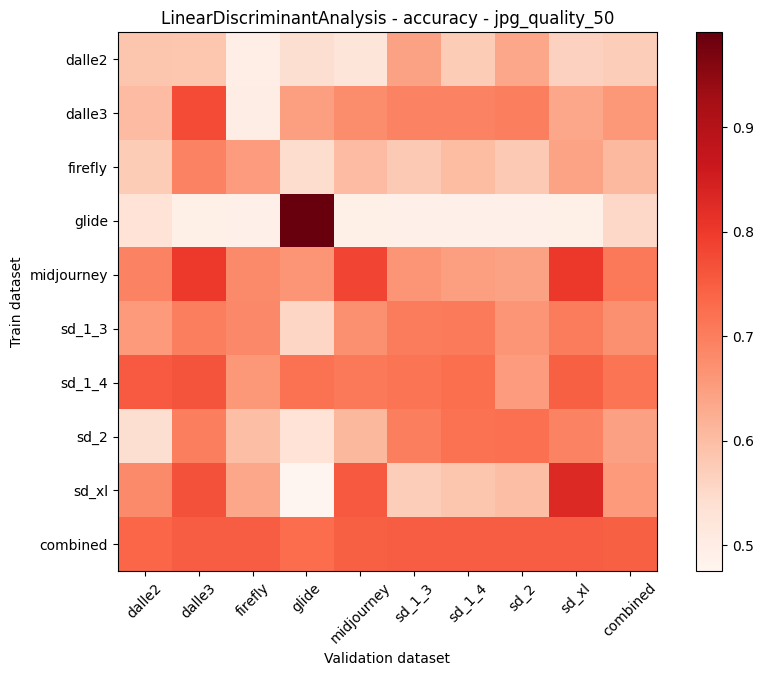

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.587500  0.584375  0.496875  0.540625    0.521875  0.643750   
dalle3         0.603125  0.775000  0.500000  0.646875    0.678125  0.693750   
firefly        0.575000  0.690625  0.653125  0.543750    0.603125  0.578125   
glide          0.531250  0.493750  0.490625  0.990625    0.493750  0.490625   
midjourney     0.693750  0.800000  0.681250  0.662500    0.784375  0.662500   
sd_1_3         0.656250  0.696875  0.684375  0.556250    0.671875  0.703125   
sd_1_4         0.753125  0.762500  0.659375  0.718750    0.709375  0.715625   
sd_2           0.540625  0.700000  0.596875  0.531250    0.609375  0.696875   
sd_xl          0.681250  0.765625  0.634375  0.475000    0.756250  0.571875   
combined       0.737500  0.750000  0.750000  0.728125    0.746875  0.750000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.575000  0.634375  0.565625  0.572222  
dalle3         0.693750  0.700000  0.634375  0.658333  
firefly        0.600000  0.578125  0.640625  0.606944  
glide          0.490625  0.490625  0.493750  0.551736  
midjourney     0.646875  0.643750  0.803125  0.708681  
sd_1_3         0.706250  0.662500  0.703125  0.671181  
sd_1_4         0.725000  0.653125  0.746875  0.715972  
sd_2           0.718750  0.721875  0.693750  0.645486  
sd_xl          0.587500  0.596875  0.828125  0.655208  
combined       0.750000  0.750000  0.750000  0.745833

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.587500  0.584375  0.496875  0.540625    0.521875  0.643750   
dalle3         0.603125  0.775000  0.500000  0.646875    0.678125  0.693750   
firefly        0.575000  0.690625  0.653125  0.543750    0.603125  0.578125   
glide          0.531250  0.493750  0.490625  0.990625    0.493750  0.490625   
midjourney     0.693750  0.800000  0.681250  0.662500    0.784375  0.662500   
sd_1_3         0.656250  0.696875  0.684375  0.556250    0.671875  0.703125   
sd_1_4         0.753125  0.762500  0.659375  0.718750    0.709375  0.715625   
sd_2           0.540625  0.700000  0.596875  0.531250    0.609375  0.696875   
sd_xl          0.681250  0.765625  0.634375  0.475000    0.756250  0.571875   
combined       0.737500  0.750000  0.750000  0.728125    0.746875  0.750000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.575000  0.634375  0.565625  0.572222  
dalle3         0.693750  0.700000  0.634375  0.658333  
firefly        0.600000  0.578125  0.640625  0.606944  
glide          0.490625  0.490625  0.493750  0.551736  
midjourney     0.646875  0.643750  0.803125  0.708681  
sd_1_3         0.706250  0.662500  0.703125  0.671181  
sd_1_4         0.725000  0.653125  0.746875  0.715972  
sd_2           0.718750  0.721875  0.693750  0.645486  
sd_xl          0.587500  0.596875  0.828125  0.655208  
combined       0.750000  0.750000  0.750000  0.745833

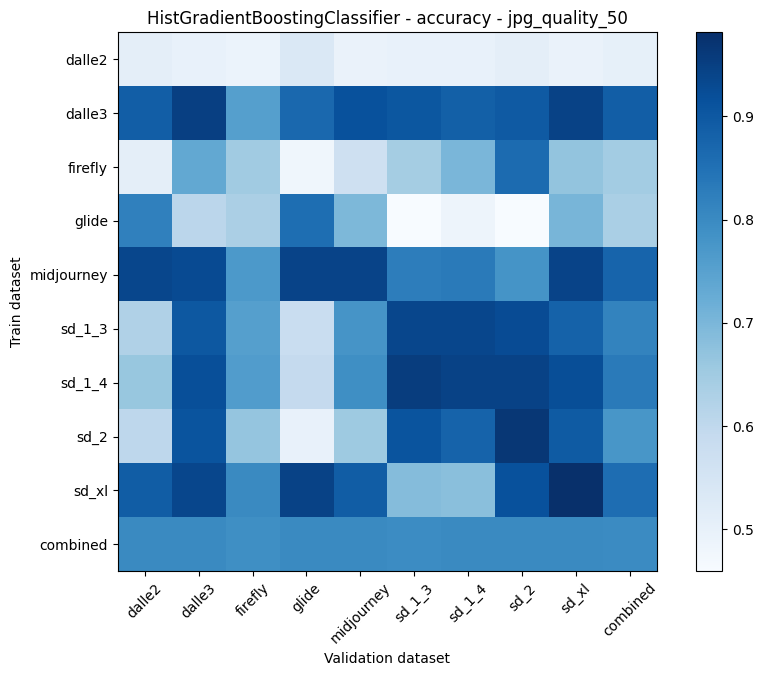

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.509375  0.496875  0.490625  0.534375    0.493750  0.496875   
dalle3         0.887500  0.950000  0.753125  0.868750    0.915625  0.903125   
firefly        0.509375  0.734375  0.650000  0.478125    0.568750  0.643750   
glide          0.818750  0.606250  0.634375  0.856250    0.696875  0.459375   
midjourney     0.934375  0.928125  0.768750  0.940625    0.940625  0.825000   
sd_1_3         0.625000  0.900000  0.753125  0.581250    0.778125  0.934375   
sd_1_4         0.662500  0.918750  0.759375  0.590625    0.790625  0.953125   
sd_2           0.603125  0.909375  0.665625  0.496875    0.653125  0.909375   
sd_xl          0.890625  0.934375  0.800000  0.943750    0.890625  0.687500   
combined       0.800000  0.800000  0.790625  0.800000    0.800000  0.796875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.500000  0.509375  0.493750  0.502778  
dalle3         0.884375  0.896875  0.943750  0.889236  
firefly        0.700000  0.862500  0.668750  0.646181  
glide          0.484375  0.459375  0.703125  0.635417  
midjourney     0.831250  0.781250  0.940625  0.876736  
sd_1_3         0.934375  0.925000  0.881250  0.812500  
sd_1_4         0.943750  0.943750  0.921875  0.831597  
sd_2           0.878125  0.965625  0.893750  0.775000  
sd_xl          0.681250  0.915625  0.981250  0.858333  
combined       0.800000  0.800000  0.800000  0.798611

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.509375  0.496875  0.490625  0.534375    0.493750  0.496875   
dalle3         0.887500  0.950000  0.753125  0.868750    0.915625  0.903125   
firefly        0.509375  0.734375  0.650000  0.478125    0.568750  0.643750   
glide          0.818750  0.606250  0.634375  0.856250    0.696875  0.459375   
midjourney     0.934375  0.928125  0.768750  0.940625    0.940625  0.825000   
sd_1_3         0.625000  0.900000  0.753125  0.581250    0.778125  0.934375   
sd_1_4         0.662500  0.918750  0.759375  0.590625    0.790625  0.953125   
sd_2           0.603125  0.909375  0.665625  0.496875    0.653125  0.909375   
sd_xl          0.890625  0.934375  0.800000  0.943750    0.890625  0.687500   
combined       0.800000  0.800000  0.790625  0.800000    0.800000  0.796875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.500000  0.509375  0.493750  0.502778  
dalle3         0.884375  0.896875  0.943750  0.889236  
firefly        0.700000  0.862500  0.668750  0.646181  
glide          0.484375  0.459375  0.703125  0.635417  
midjourney     0.831250  0.781250  0.940625  0.876736  
sd_1_3         0.934375  0.925000  0.881250  0.812500  
sd_1_4         0.943750  0.943750  0.921875  0.831597  
sd_2           0.878125  0.965625  0.893750  0.775000  
sd_xl          0.681250  0.915625  0.981250  0.858333  
combined       0.800000  0.800000  0.800000  0.798611

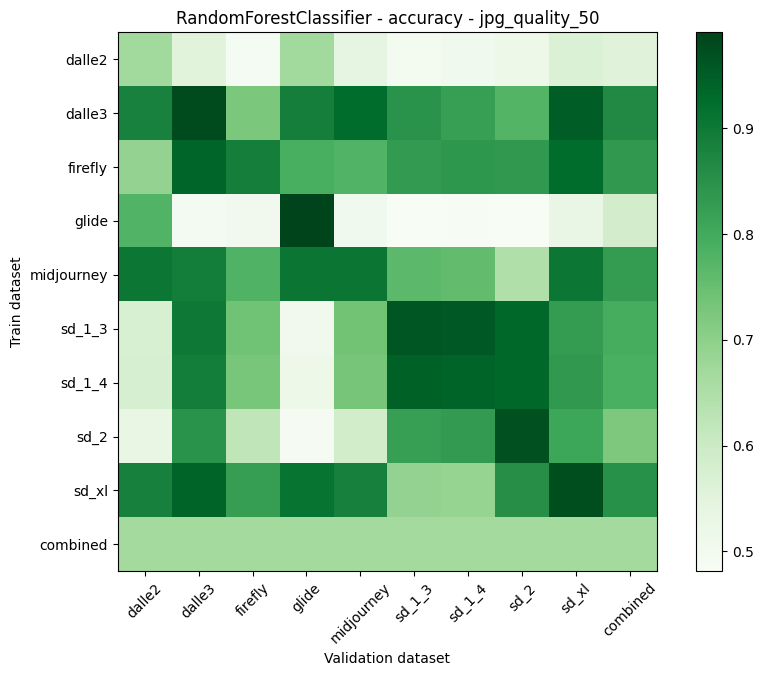

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.668750  0.553125  0.490625  0.668750    0.540625  0.496875   
dalle3         0.881250  0.978125  0.725000  0.887500    0.925000  0.846875   
firefly        0.690625  0.937500  0.887500  0.790625    0.778125  0.831250   
glide          0.778125  0.493750  0.503125  0.990625    0.506250  0.481250   
midjourney     0.903125  0.890625  0.781250  0.906250    0.906250  0.765625   
sd_1_3         0.571875  0.900000  0.740625  0.503125    0.737500  0.962500   
sd_1_4         0.575000  0.890625  0.728125  0.515625    0.731250  0.943750   
sd_2           0.534375  0.846875  0.621875  0.487500    0.587500  0.821875   
sd_xl          0.884375  0.940625  0.825000  0.909375    0.884375  0.690625   
combined       0.665625  0.665625  0.665625  0.665625    0.665625  0.665625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.506250  0.515625  0.565625  0.556250  
dalle3         0.821875  0.775000  0.950000  0.865625  
firefly        0.837500  0.834375  0.925000  0.834722  
glide          0.484375  0.481250  0.528125  0.582986  
midjourney     0.756250  0.646875  0.903125  0.828819  
sd_1_3         0.956250  0.931250  0.828125  0.792361  
sd_1_4         0.940625  0.934375  0.834375  0.788194  
sd_2           0.831250  0.968750  0.809375  0.723264  
sd_xl          0.687500  0.856250  0.975000  0.850347  
combined       0.665625  0.665625  0.665625  0.665625

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.668750  0.553125  0.490625  0.668750    0.540625  0.496875   
dalle3         0.881250  0.978125  0.725000  0.887500    0.925000  0.846875   
firefly        0.690625  0.937500  0.887500  0.790625    0.778125  0.831250   
glide          0.778125  0.493750  0.503125  0.990625    0.506250  0.481250   
midjourney     0.903125  0.890625  0.781250  0.906250    0.906250  0.765625   
sd_1_3         0.571875  0.900000  0.740625  0.503125    0.737500  0.962500   
sd_1_4         0.575000  0.890625  0.728125  0.515625    0.731250  0.943750   
sd_2           0.534375  0.846875  0.621875  0.487500    0.587500  0.821875   
sd_xl          0.884375  0.940625  0.825000  0.909375    0.884375  0.690625   
combined       0.665625  0.665625  0.665625  0.665625    0.665625  0.665625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.506250  0.515625  0.565625  0.556250  
dalle3         0.821875  0.775000  0.950000  0.865625  
firefly        0.837500  0.834375  0.925000  0.834722  
glide          0.484375  0.481250  0.528125  0.582986  
midjourney     0.756250  0.646875  0.903125  0.828819  
sd_1_3         0.956250  0.931250  0.828125  0.792361  
sd_1_4         0.940625  0.934375  0.834375  0.788194  
sd_2           0.831250  0.968750  0.809375  0.723264  
sd_xl          0.687500  0.856250  0.975000  0.850347  
combined       0.665625  0.665625  0.665625  0.665625

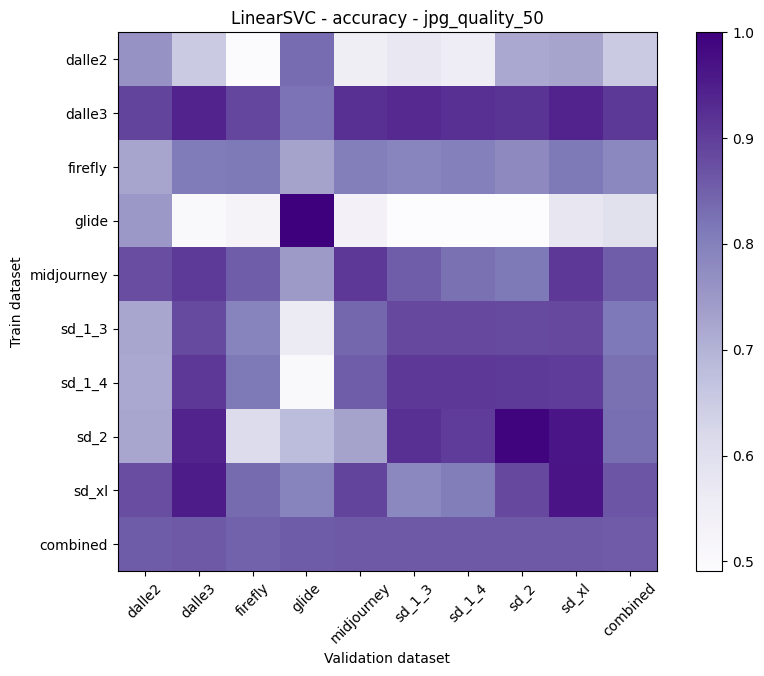

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.762500  0.650000  0.493750  0.831250    0.546875  0.571875   
dalle3         0.890625  0.940625  0.887500  0.821875    0.921875  0.931250   
firefly        0.725000  0.809375  0.812500  0.731250    0.803125  0.790625   
glide          0.750000  0.503125  0.525000  1.000000    0.534375  0.490625   
midjourney     0.878125  0.906250  0.853125  0.743750    0.909375  0.853125   
sd_1_3         0.721875  0.881250  0.793750  0.562500    0.840625  0.884375   
sd_1_4         0.718750  0.909375  0.812500  0.503125    0.853125  0.909375   
sd_2           0.721875  0.940625  0.609375  0.681250    0.731250  0.921875   
sd_xl          0.878125  0.953125  0.834375  0.793750    0.890625  0.784375   
combined       0.856250  0.859375  0.846875  0.856250    0.859375  0.859375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.556250  0.718750  0.728125  0.651042  
dalle3         0.921875  0.915625  0.940625  0.907986  
firefly        0.800000  0.778125  0.812500  0.784722  
glide          0.490625  0.490625  0.575000  0.595486  
midjourney     0.825000  0.812500  0.909375  0.854514  
sd_1_3         0.884375  0.881250  0.884375  0.814931  
sd_1_4         0.909375  0.906250  0.903125  0.825000  
sd_2           0.903125  0.990625  0.962500  0.829167  
sd_xl          0.806250  0.884375  0.965625  0.865625  
combined       0.859375  0.859375  0.859375  0.857292

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.762500  0.650000  0.493750  0.831250    0.546875  0.571875   
dalle3         0.890625  0.940625  0.887500  0.821875    0.921875  0.931250   
firefly        0.725000  0.809375  0.812500  0.731250    0.803125  0.790625   
glide          0.750000  0.503125  0.525000  1.000000    0.534375  0.490625   
midjourney     0.878125  0.906250  0.853125  0.743750    0.909375  0.853125   
sd_1_3         0.721875  0.881250  0.793750  0.562500    0.840625  0.884375   
sd_1_4         0.718750  0.909375  0.812500  0.503125    0.853125  0.909375   
sd_2           0.721875  0.940625  0.609375  0.681250    0.731250  0.921875   
sd_xl          0.878125  0.953125  0.834375  0.793750    0.890625  0.784375   
combined       0.856250  0.859375  0.846875  0.856250    0.859375  0.859375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.556250  0.718750  0.728125  0.651042  
dalle3         0.921875  0.915625  0.940625  0.907986  
firefly        0.800000  0.778125  0.812500  0.784722  
glide          0.490625  0.490625  0.575000  0.595486  
midjourney     0.825000  0.812500  0.909375  0.854514  
sd_1_3         0.884375  0.881250  0.884375  0.814931  
sd_1_4         0.909375  0.906250  0.903125  0.825000  
sd_2           0.903125  0.990625  0.962500  0.829167  
sd_xl          0.806250  0.884375  0.965625  0.865625  
combined       0.859375  0.859375  0.859375  0.857292









 ################ Evaluating models trained on standard and tested on jpg_quality_70. ################


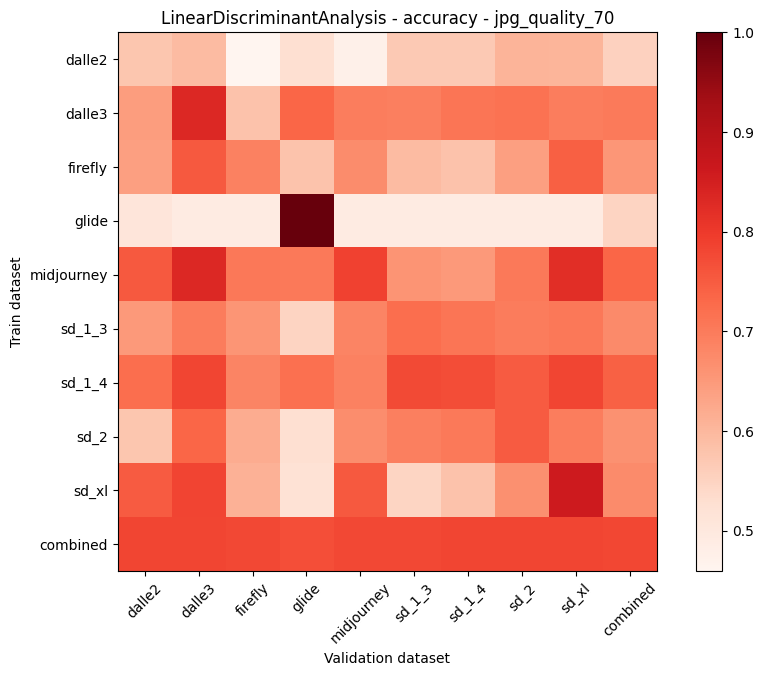

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.575000  0.593750  0.459375  0.525000    0.475000  0.568750   
dalle3         0.643750  0.831250  0.581250  0.734375    0.696875  0.693750   
firefly        0.640625  0.753125  0.690625  0.578125    0.671875  0.593750   
glide          0.509375  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.753125  0.831250  0.706250  0.703125    0.787500  0.659375   
sd_1_3         0.650000  0.700000  0.656250  0.550000    0.684375  0.721875   
sd_1_4         0.721875  0.781250  0.684375  0.718750    0.690625  0.775000   
sd_2           0.575000  0.734375  0.618750  0.525000    0.668750  0.693750   
sd_xl          0.750000  0.784375  0.609375  0.518750    0.753125  0.546875   
combined       0.781250  0.781250  0.778125  0.768750    0.778125  0.778125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.568750  0.606250  0.603125  0.552778  
dalle3         0.709375  0.715625  0.696875  0.700347  
firefly        0.581250  0.640625  0.743750  0.654861  
glide          0.490625  0.490625  0.490625  0.549306  
midjourney     0.650000  0.703125  0.821875  0.735069  
sd_1_3         0.709375  0.700000  0.706250  0.675347  
sd_1_4         0.771875  0.750000  0.781250  0.741667  
sd_2           0.703125  0.750000  0.696875  0.662847  
sd_xl          0.581250  0.665625  0.859375  0.674306  
combined       0.781250  0.781250  0.781250  0.778819

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.575000  0.593750  0.459375  0.525000    0.475000  0.568750   
dalle3         0.643750  0.831250  0.581250  0.734375    0.696875  0.693750   
firefly        0.640625  0.753125  0.690625  0.578125    0.671875  0.593750   
glide          0.509375  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.753125  0.831250  0.706250  0.703125    0.787500  0.659375   
sd_1_3         0.650000  0.700000  0.656250  0.550000    0.684375  0.721875   
sd_1_4         0.721875  0.781250  0.684375  0.718750    0.690625  0.775000   
sd_2           0.575000  0.734375  0.618750  0.525000    0.668750  0.693750   
sd_xl          0.750000  0.784375  0.609375  0.518750    0.753125  0.546875   
combined       0.781250  0.781250  0.778125  0.768750    0.778125  0.778125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.568750  0.606250  0.603125  0.552778  
dalle3         0.709375  0.715625  0.696875  0.700347  
firefly        0.581250  0.640625  0.743750  0.654861  
glide          0.490625  0.490625  0.490625  0.549306  
midjourney     0.650000  0.703125  0.821875  0.735069  
sd_1_3         0.709375  0.700000  0.706250  0.675347  
sd_1_4         0.771875  0.750000  0.781250  0.741667  
sd_2           0.703125  0.750000  0.696875  0.662847  
sd_xl          0.581250  0.665625  0.859375  0.674306  
combined       0.781250  0.781250  0.781250  0.778819

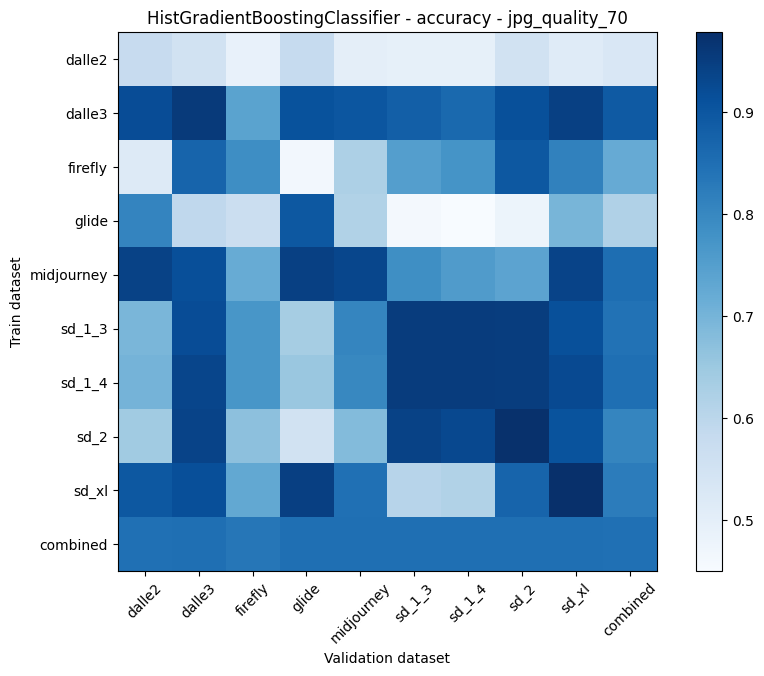

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.578125  0.553125  0.490625  0.581250    0.500000  0.493750   
dalle3         0.918750  0.956250  0.740625  0.909375    0.900000  0.881250   
firefly        0.518750  0.871875  0.787500  0.462500    0.621875  0.750000   
glide          0.806250  0.590625  0.565625  0.896875    0.615625  0.459375   
midjourney     0.940625  0.915625  0.718750  0.943750    0.931250  0.784375   
sd_1_3         0.693750  0.918750  0.768750  0.634375    0.803125  0.953125   
sd_1_4         0.700000  0.934375  0.768750  0.653125    0.800000  0.953125   
sd_2           0.643750  0.937500  0.668750  0.553125    0.681250  0.940625   
sd_xl          0.896875  0.915625  0.728125  0.946875    0.846875  0.606250   
combined       0.846875  0.850000  0.834375  0.850000    0.850000  0.850000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.493750  0.553125  0.512500  0.528472  
dalle3         0.862500  0.912500  0.943750  0.891667  
firefly        0.775000  0.896875  0.812500  0.721875  
glide          0.450000  0.478125  0.696875  0.617708  
midjourney     0.756250  0.737500  0.937500  0.851736  
sd_1_3         0.953125  0.950000  0.912500  0.843056  
sd_1_4         0.953125  0.950000  0.925000  0.848611  
sd_2           0.928125  0.975000  0.906250  0.803819  
sd_xl          0.615625  0.871875  0.978125  0.822917  
combined       0.850000  0.850000  0.850000  0.847917

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.578125  0.553125  0.490625  0.581250    0.500000  0.493750   
dalle3         0.918750  0.956250  0.740625  0.909375    0.900000  0.881250   
firefly        0.518750  0.871875  0.787500  0.462500    0.621875  0.750000   
glide          0.806250  0.590625  0.565625  0.896875    0.615625  0.459375   
midjourney     0.940625  0.915625  0.718750  0.943750    0.931250  0.784375   
sd_1_3         0.693750  0.918750  0.768750  0.634375    0.803125  0.953125   
sd_1_4         0.700000  0.934375  0.768750  0.653125    0.800000  0.953125   
sd_2           0.643750  0.937500  0.668750  0.553125    0.681250  0.940625   
sd_xl          0.896875  0.915625  0.728125  0.946875    0.846875  0.606250   
combined       0.846875  0.850000  0.834375  0.850000    0.850000  0.850000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.493750  0.553125  0.512500  0.528472  
dalle3         0.862500  0.912500  0.943750  0.891667  
firefly        0.775000  0.896875  0.812500  0.721875  
glide          0.450000  0.478125  0.696875  0.617708  
midjourney     0.756250  0.737500  0.937500  0.851736  
sd_1_3         0.953125  0.950000  0.912500  0.843056  
sd_1_4         0.953125  0.950000  0.925000  0.848611  
sd_2           0.928125  0.975000  0.906250  0.803819  
sd_xl          0.615625  0.871875  0.978125  0.822917  
combined       0.850000  0.850000  0.850000  0.847917

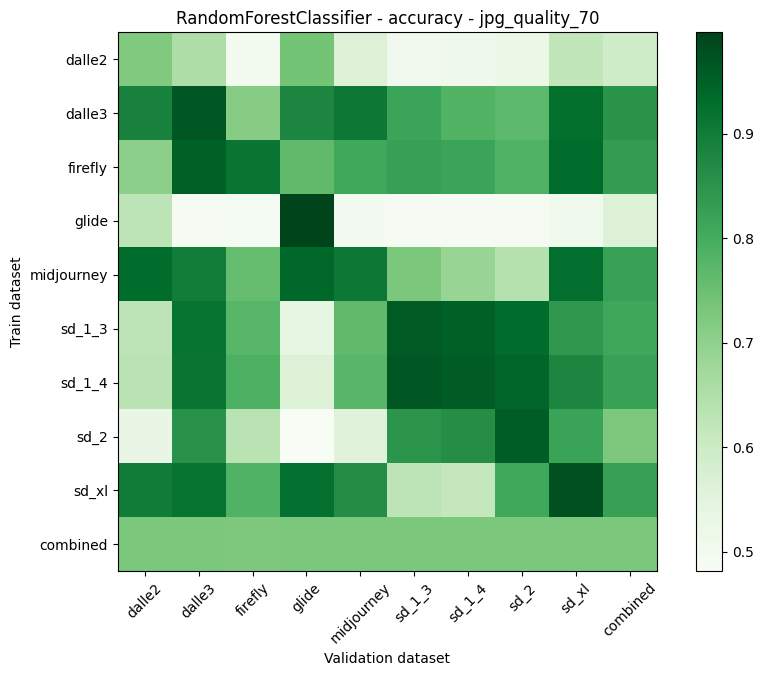

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.721875  0.653125  0.496875  0.737500    0.562500  0.503125   
dalle3         0.887500  0.965625  0.712500  0.878125    0.906250  0.815625   
firefly        0.703125  0.950000  0.912500  0.762500    0.809375  0.825000   
glide          0.628125  0.487500  0.490625  0.996875    0.493750  0.487500   
midjourney     0.931250  0.896875  0.756250  0.937500    0.906250  0.728125   
sd_1_3         0.628125  0.915625  0.775000  0.537500    0.762500  0.959375   
sd_1_4         0.631250  0.912500  0.787500  0.562500    0.775000  0.965625   
sd_2           0.528125  0.853125  0.631250  0.481250    0.556250  0.846875   
sd_xl          0.900000  0.915625  0.784375  0.921875    0.865625  0.628125   
combined       0.728125  0.728125  0.725000  0.728125    0.728125  0.728125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.512500  0.521875  0.621875  0.592361  
dalle3         0.781250  0.768750  0.928125  0.849306  
firefly        0.815625  0.784375  0.931250  0.832639  
glide          0.487500  0.487500  0.509375  0.563194  
midjourney     0.687500  0.640625  0.925000  0.823264  
sd_1_3         0.950000  0.931250  0.840625  0.811111  
sd_1_4         0.959375  0.940625  0.878125  0.823611  
sd_2           0.862500  0.956250  0.818750  0.726042  
sd_xl          0.615625  0.809375  0.975000  0.823958  
combined       0.728125  0.728125  0.728125  0.727778

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.721875  0.653125  0.496875  0.737500    0.562500  0.503125   
dalle3         0.887500  0.965625  0.712500  0.878125    0.906250  0.815625   
firefly        0.703125  0.950000  0.912500  0.762500    0.809375  0.825000   
glide          0.628125  0.487500  0.490625  0.996875    0.493750  0.487500   
midjourney     0.931250  0.896875  0.756250  0.937500    0.906250  0.728125   
sd_1_3         0.628125  0.915625  0.775000  0.537500    0.762500  0.959375   
sd_1_4         0.631250  0.912500  0.787500  0.562500    0.775000  0.965625   
sd_2           0.528125  0.853125  0.631250  0.481250    0.556250  0.846875   
sd_xl          0.900000  0.915625  0.784375  0.921875    0.865625  0.628125   
combined       0.728125  0.728125  0.725000  0.728125    0.728125  0.728125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.512500  0.521875  0.621875  0.592361  
dalle3         0.781250  0.768750  0.928125  0.849306  
firefly        0.815625  0.784375  0.931250  0.832639  
glide          0.487500  0.487500  0.509375  0.563194  
midjourney     0.687500  0.640625  0.925000  0.823264  
sd_1_3         0.950000  0.931250  0.840625  0.811111  
sd_1_4         0.959375  0.940625  0.878125  0.823611  
sd_2           0.862500  0.956250  0.818750  0.726042  
sd_xl          0.615625  0.809375  0.975000  0.823958  
combined       0.728125  0.728125  0.728125  0.727778

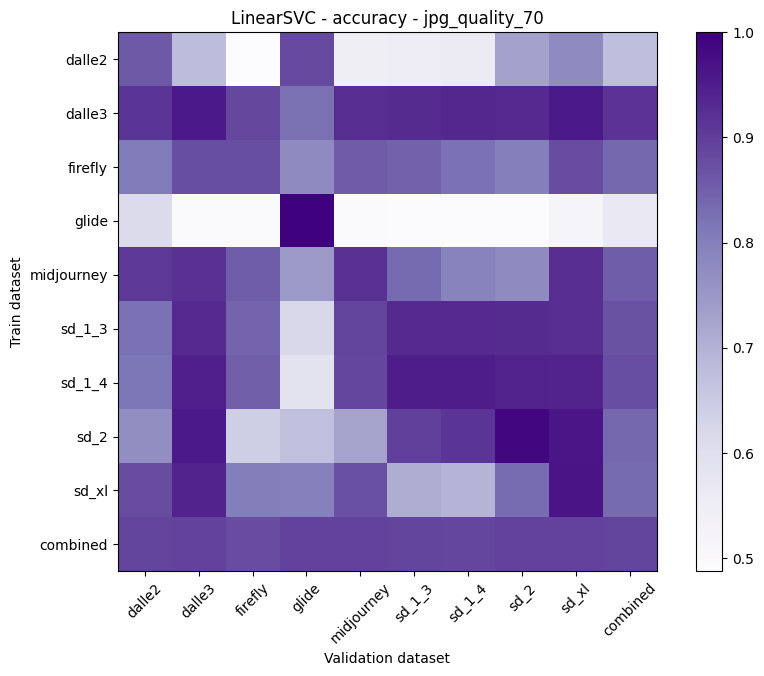

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.859375  0.678125  0.487500  0.881250    0.546875  0.553125   
dalle3         0.912500  0.956250  0.884375  0.825000    0.925000  0.928125   
firefly        0.809375  0.875000  0.875000  0.775000    0.856250  0.846875   
glide          0.612500  0.493750  0.493750  1.000000    0.493750  0.490625   
midjourney     0.909375  0.918750  0.853125  0.746875    0.918750  0.834375   
sd_1_3         0.821875  0.931250  0.843750  0.618750    0.890625  0.931250   
sd_1_4         0.815625  0.946875  0.850000  0.587500    0.887500  0.950000   
sd_2           0.768750  0.956250  0.640625  0.671875    0.728125  0.896875   
sd_xl          0.878125  0.940625  0.803125  0.796875    0.871875  0.709375   
combined       0.890625  0.893750  0.878125  0.893750    0.893750  0.890625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.559375  0.731250  0.775000  0.674653  
dalle3         0.934375  0.931250  0.956250  0.917014  
firefly        0.821875  0.800000  0.878125  0.837500  
glide          0.490625  0.490625  0.518750  0.564931  
midjourney     0.793750  0.775000  0.925000  0.852778  
sd_1_3         0.931250  0.928125  0.925000  0.869097  
sd_1_4         0.950000  0.943750  0.940625  0.874653  
sd_2           0.912500  0.987500  0.962500  0.836111  
sd_xl          0.693750  0.831250  0.965625  0.832292  
combined       0.887500  0.893750  0.893750  0.890625

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.859375  0.678125  0.487500  0.881250    0.546875  0.553125   
dalle3         0.912500  0.956250  0.884375  0.825000    0.925000  0.928125   
firefly        0.809375  0.875000  0.875000  0.775000    0.856250  0.846875   
glide          0.612500  0.493750  0.493750  1.000000    0.493750  0.490625   
midjourney     0.909375  0.918750  0.853125  0.746875    0.918750  0.834375   
sd_1_3         0.821875  0.931250  0.843750  0.618750    0.890625  0.931250   
sd_1_4         0.815625  0.946875  0.850000  0.587500    0.887500  0.950000   
sd_2           0.768750  0.956250  0.640625  0.671875    0.728125  0.896875   
sd_xl          0.878125  0.940625  0.803125  0.796875    0.871875  0.709375   
combined       0.890625  0.893750  0.878125  0.893750    0.893750  0.890625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.559375  0.731250  0.775000  0.674653  
dalle3         0.934375  0.931250  0.956250  0.917014  
firefly        0.821875  0.800000  0.878125  0.837500  
glide          0.490625  0.490625  0.518750  0.564931  
midjourney     0.793750  0.775000  0.925000  0.852778  
sd_1_3         0.931250  0.928125  0.925000  0.869097  
sd_1_4         0.950000  0.943750  0.940625  0.874653  
sd_2           0.912500  0.987500  0.962500  0.836111  
sd_xl          0.693750  0.831250  0.965625  0.832292  
combined       0.887500  0.893750  0.893750  0.890625









 ################ Evaluating models trained on standard and tested on jpg_quality_90. ################


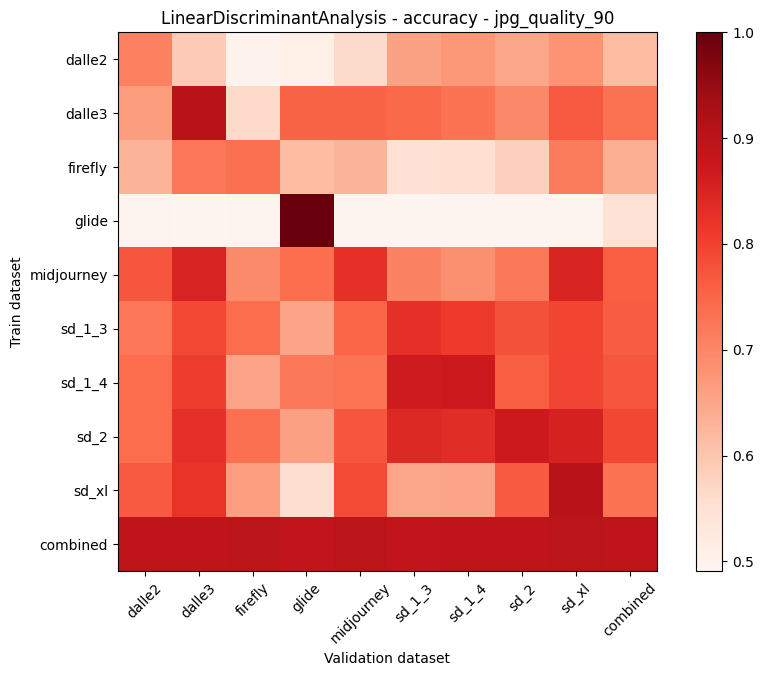

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.709375  0.590625  0.500000  0.509375    0.562500  0.656250   
dalle3         0.665625  0.906250  0.565625  0.753125    0.753125  0.746875   
firefly        0.628125  0.725000  0.734375  0.615625    0.628125  0.550000   
glide          0.493750  0.490625  0.493750  1.000000    0.490625  0.490625   
midjourney     0.771875  0.850000  0.693750  0.737500    0.828125  0.706250   
sd_1_3         0.725000  0.790625  0.740625  0.653125    0.750000  0.828125   
sd_1_4         0.740625  0.806250  0.653125  0.721875    0.728125  0.865625   
sd_2           0.740625  0.828125  0.734375  0.659375    0.771875  0.840625   
sd_xl          0.765625  0.821875  0.662500  0.556250    0.787500  0.650000   
combined       0.893750  0.893750  0.896875  0.887500    0.896875  0.887500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.671875  0.650000  0.678125  0.614236  
dalle3         0.731250  0.696875  0.768750  0.731944  
firefly        0.553125  0.581250  0.715625  0.636806  
glide          0.490625  0.490625  0.490625  0.547917  
midjourney     0.684375  0.721875  0.846875  0.760069  
sd_1_3         0.809375  0.778125  0.793750  0.763194  
sd_1_4         0.868750  0.759375  0.796875  0.771181  
sd_2           0.834375  0.868750  0.853125  0.792361  
sd_xl          0.653125  0.765625  0.903125  0.729514  
combined       0.893750  0.893750  0.896875  0.893403

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.709375  0.590625  0.500000  0.509375    0.562500  0.656250   
dalle3         0.665625  0.906250  0.565625  0.753125    0.753125  0.746875   
firefly        0.628125  0.725000  0.734375  0.615625    0.628125  0.550000   
glide          0.493750  0.490625  0.493750  1.000000    0.490625  0.490625   
midjourney     0.771875  0.850000  0.693750  0.737500    0.828125  0.706250   
sd_1_3         0.725000  0.790625  0.740625  0.653125    0.750000  0.828125   
sd_1_4         0.740625  0.806250  0.653125  0.721875    0.728125  0.865625   
sd_2           0.740625  0.828125  0.734375  0.659375    0.771875  0.840625   
sd_xl          0.765625  0.821875  0.662500  0.556250    0.787500  0.650000   
combined       0.893750  0.893750  0.896875  0.887500    0.896875  0.887500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.671875  0.650000  0.678125  0.614236  
dalle3         0.731250  0.696875  0.768750  0.731944  
firefly        0.553125  0.581250  0.715625  0.636806  
glide          0.490625  0.490625  0.490625  0.547917  
midjourney     0.684375  0.721875  0.846875  0.760069  
sd_1_3         0.809375  0.778125  0.793750  0.763194  
sd_1_4         0.868750  0.759375  0.796875  0.771181  
sd_2           0.834375  0.868750  0.853125  0.792361  
sd_xl          0.653125  0.765625  0.903125  0.729514  
combined       0.893750  0.893750  0.896875  0.893403

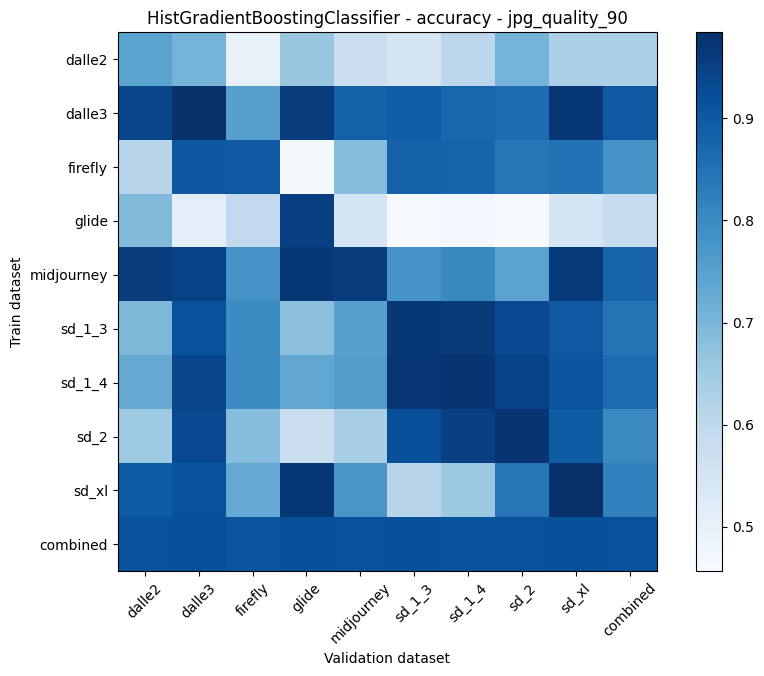

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.746875  0.706250  0.496875  0.662500    0.571875  0.546875   
dalle3         0.940625  0.981250  0.753125  0.959375    0.884375  0.890625   
firefly        0.612500  0.903125  0.900000  0.465625    0.684375  0.884375   
glide          0.690625  0.509375  0.593750  0.953125    0.550000  0.462500   
midjourney     0.959375  0.946875  0.778125  0.968750    0.959375  0.778125   
sd_1_3         0.696875  0.915625  0.796875  0.675000    0.753125  0.968750   
sd_1_4         0.728125  0.940625  0.796875  0.737500    0.759375  0.971875   
sd_2           0.653125  0.931250  0.684375  0.571875    0.637500  0.921875   
sd_xl          0.893750  0.915625  0.731250  0.968750    0.775000  0.609375   
combined       0.915625  0.918750  0.909375  0.918750    0.915625  0.918750   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.603125  0.706250  0.631250  0.630208  
dalle3         0.875000  0.859375  0.968750  0.901389  
firefly        0.878125  0.840625  0.850000  0.779861  
glide          0.471875  0.456250  0.550000  0.581944  
midjourney     0.803125  0.746875  0.965625  0.878472  
sd_1_3         0.962500  0.931250  0.900000  0.844444  
sd_1_4         0.975000  0.946875  0.906250  0.862500  
sd_2           0.950000  0.975000  0.893750  0.802083  
sd_xl          0.656250  0.843750  0.984375  0.819792  
combined       0.915625  0.915625  0.918750  0.916319

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.746875  0.706250  0.496875  0.662500    0.571875  0.546875   
dalle3         0.940625  0.981250  0.753125  0.959375    0.884375  0.890625   
firefly        0.612500  0.903125  0.900000  0.465625    0.684375  0.884375   
glide          0.690625  0.509375  0.593750  0.953125    0.550000  0.462500   
midjourney     0.959375  0.946875  0.778125  0.968750    0.959375  0.778125   
sd_1_3         0.696875  0.915625  0.796875  0.675000    0.753125  0.968750   
sd_1_4         0.728125  0.940625  0.796875  0.737500    0.759375  0.971875   
sd_2           0.653125  0.931250  0.684375  0.571875    0.637500  0.921875   
sd_xl          0.893750  0.915625  0.731250  0.968750    0.775000  0.609375   
combined       0.915625  0.918750  0.909375  0.918750    0.915625  0.918750   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.603125  0.706250  0.631250  0.630208  
dalle3         0.875000  0.859375  0.968750  0.901389  
firefly        0.878125  0.840625  0.850000  0.779861  
glide          0.471875  0.456250  0.550000  0.581944  
midjourney     0.803125  0.746875  0.965625  0.878472  
sd_1_3         0.962500  0.931250  0.900000  0.844444  
sd_1_4         0.975000  0.946875  0.906250  0.862500  
sd_2           0.950000  0.975000  0.893750  0.802083  
sd_xl          0.656250  0.843750  0.984375  0.819792  
combined       0.915625  0.915625  0.918750  0.916319

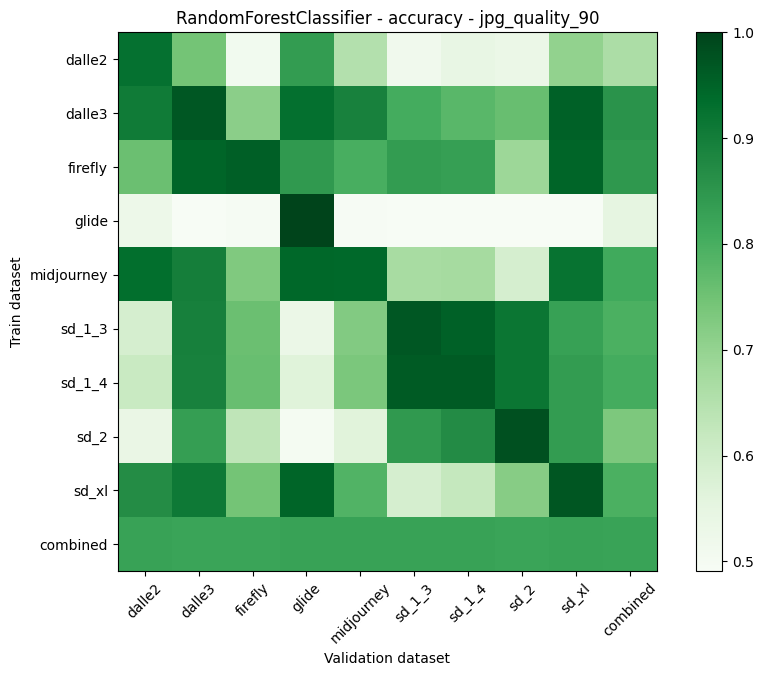

val_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                
dalle2         0.92500  0.743750  0.509375  0.837500    0.650000  0.515625   
dalle3         0.90625  0.968750  0.712500  0.928125    0.890625  0.803125   
firefly        0.75625  0.946875  0.956250  0.843750    0.800000  0.837500   
glide          0.52500  0.490625  0.496875  1.000000    0.493750  0.490625   
midjourney     0.93125  0.896875  0.728125  0.943750    0.940625  0.668750   
sd_1_3         0.58750  0.893750  0.756250  0.534375    0.725000  0.968750   
sd_1_4         0.61250  0.890625  0.759375  0.565625    0.734375  0.962500   
sd_2           0.53750  0.834375  0.631250  0.500000    0.562500  0.843750   
sd_xl          0.86875  0.909375  0.743750  0.946875    0.787500  0.587500   
combined       0.82500  0.821875  0.821875  0.825000    0.825000  0.825000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.540625  0.534375  0.703125  0.662153  
dalle3         0.778125  0.759375  0.953125  0.855556  
firefly        0.831250  0.687500  0.946875  0.845139  
glide          0.490625  0.490625  0.490625  0.552083  
midjourney     0.671875  0.587500  0.921875  0.810069  
sd_1_3         0.953125  0.915625  0.828125  0.795833  
sd_1_4         0.962500  0.915625  0.837500  0.804514  
sd_2           0.871875  0.978125  0.837500  0.732986  
sd_xl          0.621875  0.718750  0.971875  0.795139  
combined       0.825000  0.821875  0.825000  0.823958

val_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                
dalle2         0.92500  0.743750  0.509375  0.837500    0.650000  0.515625   
dalle3         0.90625  0.968750  0.712500  0.928125    0.890625  0.803125   
firefly        0.75625  0.946875  0.956250  0.843750    0.800000  0.837500   
glide          0.52500  0.490625  0.496875  1.000000    0.493750  0.490625   
midjourney     0.93125  0.896875  0.728125  0.943750    0.940625  0.668750   
sd_1_3         0.58750  0.893750  0.756250  0.534375    0.725000  0.968750   
sd_1_4         0.61250  0.890625  0.759375  0.565625    0.734375  0.962500   
sd_2           0.53750  0.834375  0.631250  0.500000    0.562500  0.843750   
sd_xl          0.86875  0.909375  0.743750  0.946875    0.787500  0.587500   
combined       0.82500  0.821875  0.821875  0.825000    0.825000  0.825000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.540625  0.534375  0.703125  0.662153  
dalle3         0.778125  0.759375  0.953125  0.855556  
firefly        0.831250  0.687500  0.946875  0.845139  
glide          0.490625  0.490625  0.490625  0.552083  
midjourney     0.671875  0.587500  0.921875  0.810069  
sd_1_3         0.953125  0.915625  0.828125  0.795833  
sd_1_4         0.962500  0.915625  0.837500  0.804514  
sd_2           0.871875  0.978125  0.837500  0.732986  
sd_xl          0.621875  0.718750  0.971875  0.795139  
combined       0.825000  0.821875  0.825000  0.823958

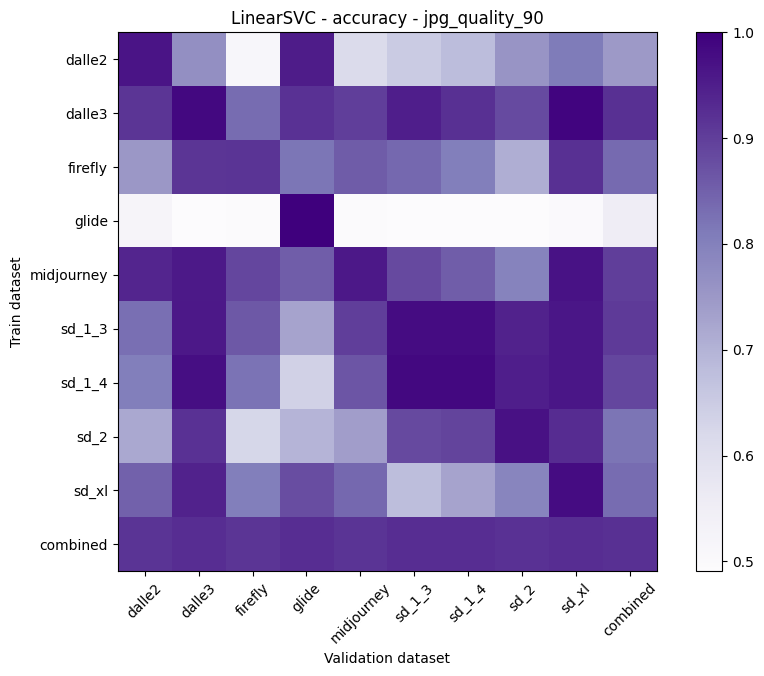

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.965625  0.768750  0.512500  0.953125    0.615625  0.650000   
dalle3         0.912500  0.984375  0.831250  0.918750    0.900000  0.950000   
firefly        0.750000  0.912500  0.915625  0.818750    0.856250  0.837500   
glide          0.518750  0.490625  0.493750  1.000000    0.493750  0.490625   
midjourney     0.937500  0.956250  0.887500  0.853125    0.959375  0.884375   
sd_1_3         0.828125  0.959375  0.862500  0.728125    0.900000  0.978125   
sd_1_4         0.803125  0.975000  0.821875  0.637500    0.865625  0.984375   
sd_2           0.718750  0.918750  0.625000  0.696875    0.737500  0.884375   
sd_xl          0.846875  0.943750  0.803125  0.878125    0.837500  0.678125   
combined       0.915625  0.925000  0.912500  0.925000    0.915625  0.925000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.681250  0.756250  0.809375  0.745833  
dalle3         0.921875  0.881250  0.990625  0.921181  
firefly        0.803125  0.709375  0.921875  0.836111  
glide          0.490625  0.490625  0.496875  0.551736  
midjourney     0.853125  0.793750  0.968750  0.899306  
sd_1_3         0.978125  0.943750  0.962500  0.904514  
sd_1_4         0.984375  0.950000  0.962500  0.887153  
sd_2           0.890625  0.971875  0.928125  0.819097  
sd_xl          0.728125  0.790625  0.978125  0.831597  
combined       0.925000  0.918750  0.925000  0.920833

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.965625  0.768750  0.512500  0.953125    0.615625  0.650000   
dalle3         0.912500  0.984375  0.831250  0.918750    0.900000  0.950000   
firefly        0.750000  0.912500  0.915625  0.818750    0.856250  0.837500   
glide          0.518750  0.490625  0.493750  1.000000    0.493750  0.490625   
midjourney     0.937500  0.956250  0.887500  0.853125    0.959375  0.884375   
sd_1_3         0.828125  0.959375  0.862500  0.728125    0.900000  0.978125   
sd_1_4         0.803125  0.975000  0.821875  0.637500    0.865625  0.984375   
sd_2           0.718750  0.918750  0.625000  0.696875    0.737500  0.884375   
sd_xl          0.846875  0.943750  0.803125  0.878125    0.837500  0.678125   
combined       0.915625  0.925000  0.912500  0.925000    0.915625  0.925000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.681250  0.756250  0.809375  0.745833  
dalle3         0.921875  0.881250  0.990625  0.921181  
firefly        0.803125  0.709375  0.921875  0.836111  
glide          0.490625  0.490625  0.496875  0.551736  
midjourney     0.853125  0.793750  0.968750  0.899306  
sd_1_3         0.978125  0.943750  0.962500  0.904514  
sd_1_4         0.984375  0.950000  0.962500  0.887153  
sd_2           0.890625  0.971875  0.928125  0.819097  
sd_xl          0.728125  0.790625  0.978125  0.831597  
combined       0.925000  0.918750  0.925000  0.920833









 ################ Evaluating models trained on standard and tested on jpg_quality_80. ################


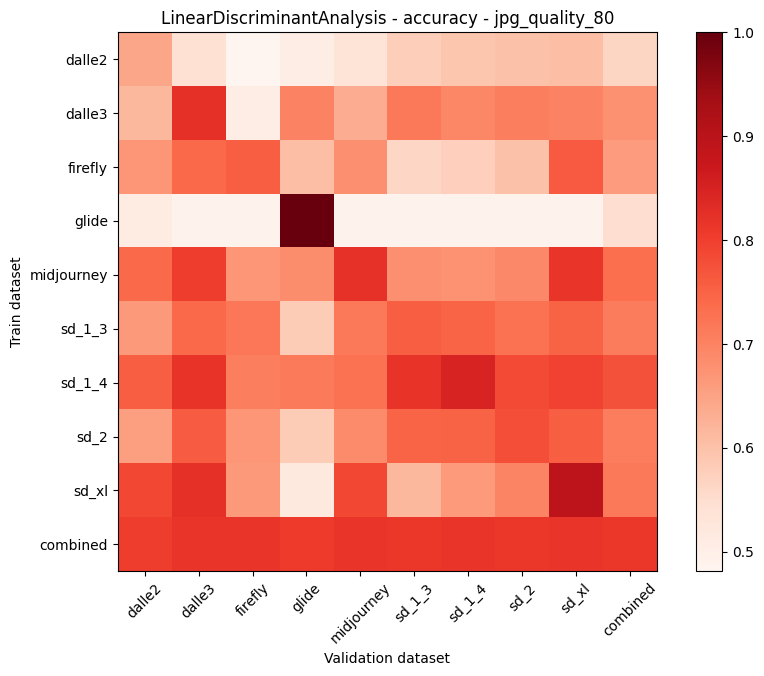

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.643750  0.543750  0.481250  0.506250    0.534375  0.578125   
dalle3         0.615625  0.825000  0.506250  0.700000    0.631250  0.715625   
firefly        0.668750  0.740625  0.756250  0.603125    0.681250  0.562500   
glide          0.512500  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.740625  0.803125  0.668750  0.684375    0.821875  0.681250   
sd_1_3         0.665625  0.740625  0.718750  0.581250    0.715625  0.756250   
sd_1_4         0.756250  0.818750  0.706250  0.712500    0.728125  0.818750   
sd_2           0.656250  0.759375  0.668750  0.581250    0.687500  0.746875   
sd_xl          0.787500  0.825000  0.665625  0.518750    0.787500  0.615625   
combined       0.803125  0.815625  0.815625  0.806250    0.815625  0.812500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.593750  0.600000  0.603125  0.564931  
dalle3         0.693750  0.706250  0.700000  0.677083  
firefly        0.575000  0.600000  0.762500  0.661111  
glide          0.490625  0.490625  0.490625  0.549653  
midjourney     0.675000  0.690625  0.815625  0.731250  
sd_1_3         0.746875  0.728125  0.750000  0.711458  
sd_1_4         0.846875  0.784375  0.793750  0.773958  
sd_2           0.750000  0.778125  0.756250  0.709375  
sd_xl          0.662500  0.696875  0.893750  0.717014  
combined       0.815625  0.812500  0.815625  0.812500

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.643750  0.543750  0.481250  0.506250    0.534375  0.578125   
dalle3         0.615625  0.825000  0.506250  0.700000    0.631250  0.715625   
firefly        0.668750  0.740625  0.756250  0.603125    0.681250  0.562500   
glide          0.512500  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.740625  0.803125  0.668750  0.684375    0.821875  0.681250   
sd_1_3         0.665625  0.740625  0.718750  0.581250    0.715625  0.756250   
sd_1_4         0.756250  0.818750  0.706250  0.712500    0.728125  0.818750   
sd_2           0.656250  0.759375  0.668750  0.581250    0.687500  0.746875   
sd_xl          0.787500  0.825000  0.665625  0.518750    0.787500  0.615625   
combined       0.803125  0.815625  0.815625  0.806250    0.815625  0.812500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.593750  0.600000  0.603125  0.564931  
dalle3         0.693750  0.706250  0.700000  0.677083  
firefly        0.575000  0.600000  0.762500  0.661111  
glide          0.490625  0.490625  0.490625  0.549653  
midjourney     0.675000  0.690625  0.815625  0.731250  
sd_1_3         0.746875  0.728125  0.750000  0.711458  
sd_1_4         0.846875  0.784375  0.793750  0.773958  
sd_2           0.750000  0.778125  0.756250  0.709375  
sd_xl          0.662500  0.696875  0.893750  0.717014  
combined       0.815625  0.812500  0.815625  0.812500

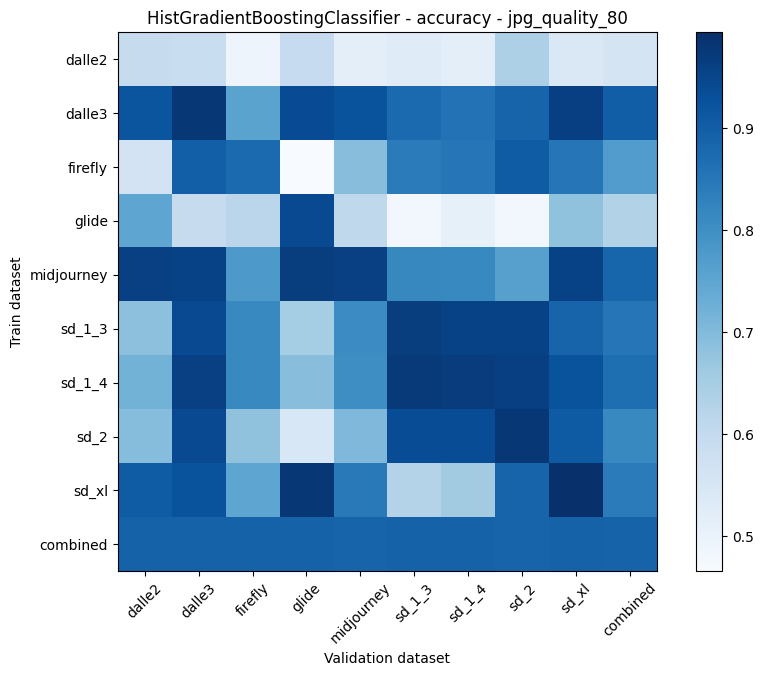

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.593750  0.587500  0.490625  0.596875    0.515625  0.528125   
dalle3         0.918750  0.978125  0.756250  0.937500    0.921875  0.875000   
firefly        0.562500  0.896875  0.875000  0.465625    0.690625  0.840625   
glide          0.750000  0.593750  0.615625  0.940625    0.609375  0.481250   
midjourney     0.959375  0.956250  0.778125  0.965625    0.959375  0.815625   
sd_1_3         0.684375  0.940625  0.812500  0.653125    0.806250  0.965625   
sd_1_4         0.718750  0.959375  0.812500  0.690625    0.803125  0.971875   
sd_2           0.693750  0.940625  0.681250  0.546875    0.703125  0.934375   
sd_xl          0.903125  0.921875  0.750000  0.978125    0.843750  0.628125   
combined       0.890625  0.890625  0.890625  0.890625    0.887500  0.890625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.518750  0.637500  0.540625  0.556597  
dalle3         0.859375  0.887500  0.962500  0.899653  
firefly        0.850000  0.903125  0.853125  0.770833  
glide          0.509375  0.481250  0.681250  0.629167  
midjourney     0.812500  0.762500  0.956250  0.885069  
sd_1_3         0.956250  0.956250  0.887500  0.851389  
sd_1_4         0.968750  0.962500  0.921875  0.867708  
sd_2           0.934375  0.978125  0.906250  0.813194  
sd_xl          0.656250  0.887500  0.993750  0.840278  
combined       0.890625  0.887500  0.890625  0.889931

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.593750  0.587500  0.490625  0.596875    0.515625  0.528125   
dalle3         0.918750  0.978125  0.756250  0.937500    0.921875  0.875000   
firefly        0.562500  0.896875  0.875000  0.465625    0.690625  0.840625   
glide          0.750000  0.593750  0.615625  0.940625    0.609375  0.481250   
midjourney     0.959375  0.956250  0.778125  0.965625    0.959375  0.815625   
sd_1_3         0.684375  0.940625  0.812500  0.653125    0.806250  0.965625   
sd_1_4         0.718750  0.959375  0.812500  0.690625    0.803125  0.971875   
sd_2           0.693750  0.940625  0.681250  0.546875    0.703125  0.934375   
sd_xl          0.903125  0.921875  0.750000  0.978125    0.843750  0.628125   
combined       0.890625  0.890625  0.890625  0.890625    0.887500  0.890625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.518750  0.637500  0.540625  0.556597  
dalle3         0.859375  0.887500  0.962500  0.899653  
firefly        0.850000  0.903125  0.853125  0.770833  
glide          0.509375  0.481250  0.681250  0.629167  
midjourney     0.812500  0.762500  0.956250  0.885069  
sd_1_3         0.956250  0.956250  0.887500  0.851389  
sd_1_4         0.968750  0.962500  0.921875  0.867708  
sd_2           0.934375  0.978125  0.906250  0.813194  
sd_xl          0.656250  0.887500  0.993750  0.840278  
combined       0.890625  0.887500  0.890625  0.889931

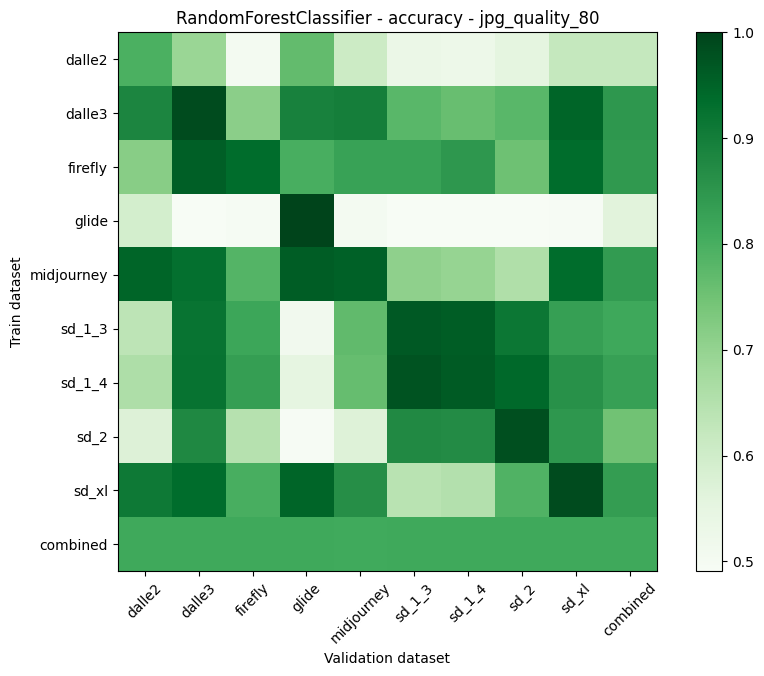

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.796875  0.690625  0.503125  0.765625    0.606250  0.531250   
dalle3         0.884375  0.987500  0.712500  0.890625    0.896875  0.778125   
firefly        0.715625  0.956250  0.934375  0.800000    0.825000  0.825000   
glide          0.590625  0.490625  0.496875  1.000000    0.503125  0.490625   
midjourney     0.946875  0.928125  0.784375  0.959375    0.953125  0.706250   
sd_1_3         0.634375  0.918750  0.818750  0.512500    0.768750  0.965625   
sd_1_4         0.659375  0.921875  0.834375  0.550000    0.762500  0.975000   
sd_2           0.571875  0.878125  0.646875  0.493750    0.568750  0.875000   
sd_xl          0.909375  0.934375  0.800000  0.946875    0.865625  0.640625   
combined       0.812500  0.812500  0.812500  0.812500    0.809375  0.812500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.525000  0.553125  0.621875  0.621528  
dalle3         0.759375  0.778125  0.946875  0.848264  
firefly        0.846875  0.753125  0.934375  0.843403  
glide          0.490625  0.490625  0.493750  0.560764  
midjourney     0.696875  0.656250  0.934375  0.840625  
sd_1_3         0.959375  0.912500  0.831250  0.813542  
sd_1_4         0.962500  0.940625  0.859375  0.829514  
sd_2           0.871875  0.981250  0.846875  0.748264  
sd_xl          0.650000  0.790625  0.987500  0.836111  
combined       0.812500  0.812500  0.812500  0.812153

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.796875  0.690625  0.503125  0.765625    0.606250  0.531250   
dalle3         0.884375  0.987500  0.712500  0.890625    0.896875  0.778125   
firefly        0.715625  0.956250  0.934375  0.800000    0.825000  0.825000   
glide          0.590625  0.490625  0.496875  1.000000    0.503125  0.490625   
midjourney     0.946875  0.928125  0.784375  0.959375    0.953125  0.706250   
sd_1_3         0.634375  0.918750  0.818750  0.512500    0.768750  0.965625   
sd_1_4         0.659375  0.921875  0.834375  0.550000    0.762500  0.975000   
sd_2           0.571875  0.878125  0.646875  0.493750    0.568750  0.875000   
sd_xl          0.909375  0.934375  0.800000  0.946875    0.865625  0.640625   
combined       0.812500  0.812500  0.812500  0.812500    0.809375  0.812500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.525000  0.553125  0.621875  0.621528  
dalle3         0.759375  0.778125  0.946875  0.848264  
firefly        0.846875  0.753125  0.934375  0.843403  
glide          0.490625  0.490625  0.493750  0.560764  
midjourney     0.696875  0.656250  0.934375  0.840625  
sd_1_3         0.959375  0.912500  0.831250  0.813542  
sd_1_4         0.962500  0.940625  0.859375  0.829514  
sd_2           0.871875  0.981250  0.846875  0.748264  
sd_xl          0.650000  0.790625  0.987500  0.836111  
combined       0.812500  0.812500  0.812500  0.812153

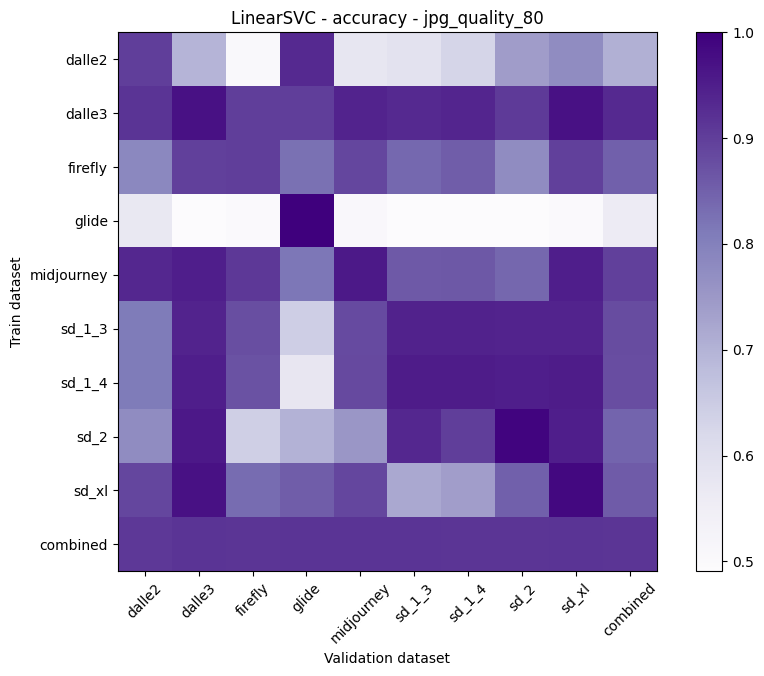

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.900000  0.696875  0.503125  0.931250    0.578125  0.590625   
dalle3         0.915625  0.971875  0.900000  0.900000    0.940625  0.931250   
firefly        0.784375  0.896875  0.900000  0.825000    0.887500  0.837500   
glide          0.571875  0.490625  0.496875  1.000000    0.506250  0.490625   
midjourney     0.934375  0.950000  0.909375  0.815625    0.956250  0.859375   
sd_1_3         0.809375  0.940625  0.875000  0.643750    0.881250  0.943750   
sd_1_4         0.809375  0.950000  0.868750  0.575000    0.884375  0.953125   
sd_2           0.775000  0.959375  0.640625  0.700000    0.753125  0.934375   
sd_xl          0.887500  0.971875  0.831250  0.853125    0.887500  0.718750   
combined       0.909375  0.915625  0.912500  0.915625    0.915625  0.915625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.628125  0.740625  0.775000  0.704861  
dalle3         0.937500  0.906250  0.971875  0.930556  
firefly        0.853125  0.775000  0.896875  0.850694  
glide          0.490625  0.490625  0.496875  0.559375  
midjourney     0.862500  0.840625  0.950000  0.897569  
sd_1_3         0.943750  0.940625  0.940625  0.879861  
sd_1_4         0.953125  0.950000  0.953125  0.877431  
sd_2           0.900000  0.990625  0.950000  0.844792  
sd_xl          0.737500  0.850000  0.984375  0.857986  
combined       0.912500  0.912500  0.915625  0.913889

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.900000  0.696875  0.503125  0.931250    0.578125  0.590625   
dalle3         0.915625  0.971875  0.900000  0.900000    0.940625  0.931250   
firefly        0.784375  0.896875  0.900000  0.825000    0.887500  0.837500   
glide          0.571875  0.490625  0.496875  1.000000    0.506250  0.490625   
midjourney     0.934375  0.950000  0.909375  0.815625    0.956250  0.859375   
sd_1_3         0.809375  0.940625  0.875000  0.643750    0.881250  0.943750   
sd_1_4         0.809375  0.950000  0.868750  0.575000    0.884375  0.953125   
sd_2           0.775000  0.959375  0.640625  0.700000    0.753125  0.934375   
sd_xl          0.887500  0.971875  0.831250  0.853125    0.887500  0.718750   
combined       0.909375  0.915625  0.912500  0.915625    0.915625  0.915625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.628125  0.740625  0.775000  0.704861  
dalle3         0.937500  0.906250  0.971875  0.930556  
firefly        0.853125  0.775000  0.896875  0.850694  
glide          0.490625  0.490625  0.496875  0.559375  
midjourney     0.862500  0.840625  0.950000  0.897569  
sd_1_3         0.943750  0.940625  0.940625  0.879861  
sd_1_4         0.953125  0.950000  0.953125  0.877431  
sd_2           0.900000  0.990625  0.950000  0.844792  
sd_xl          0.737500  0.850000  0.984375  0.857986  
combined       0.912500  0.912500  0.915625  0.913889









 ################ Evaluating models trained on standard and tested on jpg_quality_95. ################


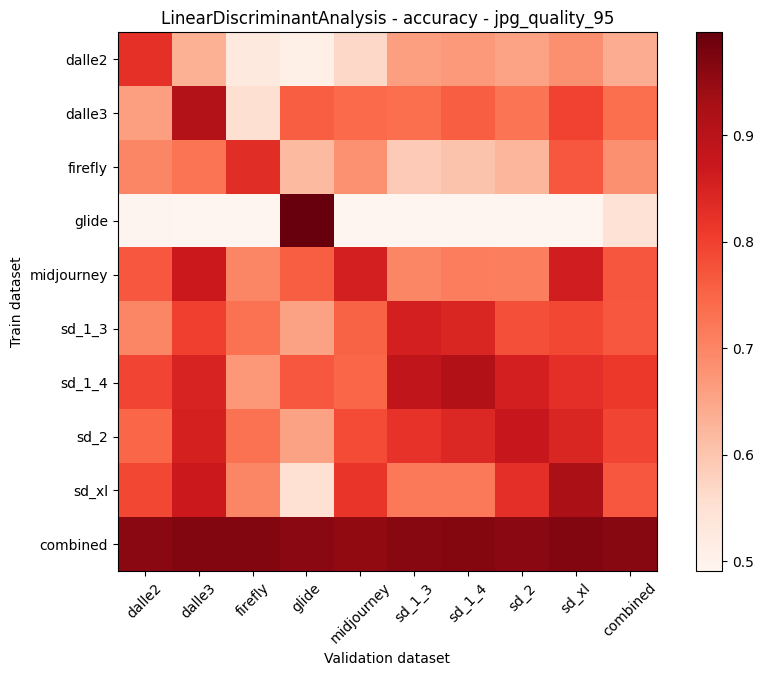

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.825000  0.634375  0.528125  0.509375    0.568750  0.662500   
dalle3         0.659375  0.909375  0.553125  0.759375    0.740625  0.734375   
firefly        0.700000  0.725000  0.831250  0.618750    0.681250  0.590625   
glide          0.493750  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.768750  0.868750  0.700000  0.759375    0.856250  0.700000   
sd_1_3         0.700000  0.800000  0.731250  0.656250    0.753125  0.856250   
sd_1_4         0.793750  0.846875  0.671875  0.768750    0.746875  0.887500   
sd_2           0.746875  0.853125  0.731250  0.656250    0.784375  0.821875   
sd_xl          0.790625  0.868750  0.700000  0.550000    0.815625  0.718750   
combined       0.959375  0.968750  0.968750  0.959375    0.953125  0.962500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.668750  0.653125  0.684375  0.637153  
dalle3         0.759375  0.725000  0.796875  0.737500  
firefly        0.603125  0.625000  0.768750  0.682639  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.712500  0.709375  0.859375  0.770486  
sd_1_3         0.843750  0.778125  0.790625  0.767708  
sd_1_4         0.912500  0.856250  0.828125  0.812500  
sd_2           0.840625  0.875000  0.843750  0.794792  
sd_xl          0.721875  0.828125  0.921875  0.768403  
combined       0.965625  0.959375  0.968750  0.962847

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.825000  0.634375  0.528125  0.509375    0.568750  0.662500   
dalle3         0.659375  0.909375  0.553125  0.759375    0.740625  0.734375   
firefly        0.700000  0.725000  0.831250  0.618750    0.681250  0.590625   
glide          0.493750  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.768750  0.868750  0.700000  0.759375    0.856250  0.700000   
sd_1_3         0.700000  0.800000  0.731250  0.656250    0.753125  0.856250   
sd_1_4         0.793750  0.846875  0.671875  0.768750    0.746875  0.887500   
sd_2           0.746875  0.853125  0.731250  0.656250    0.784375  0.821875   
sd_xl          0.790625  0.868750  0.700000  0.550000    0.815625  0.718750   
combined       0.959375  0.968750  0.968750  0.959375    0.953125  0.962500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.668750  0.653125  0.684375  0.637153  
dalle3         0.759375  0.725000  0.796875  0.737500  
firefly        0.603125  0.625000  0.768750  0.682639  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.712500  0.709375  0.859375  0.770486  
sd_1_3         0.843750  0.778125  0.790625  0.767708  
sd_1_4         0.912500  0.856250  0.828125  0.812500  
sd_2           0.840625  0.875000  0.843750  0.794792  
sd_xl          0.721875  0.828125  0.921875  0.768403  
combined       0.965625  0.959375  0.968750  0.962847

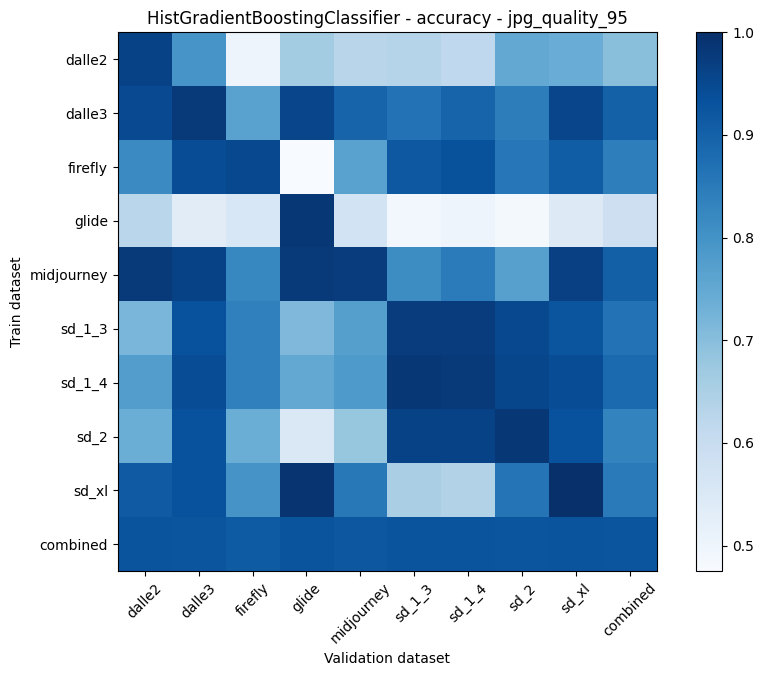

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962500  0.793750  0.500000  0.662500    0.628125  0.631250   
dalle3         0.946875  0.978125  0.765625  0.956250    0.893750  0.865625   
firefly        0.815625  0.940625  0.950000  0.475000    0.765625  0.918750   
glide          0.625000  0.534375  0.556250  0.984375    0.571875  0.487500   
midjourney     0.978125  0.962500  0.825000  0.981250    0.975000  0.812500   
sd_1_3         0.718750  0.934375  0.837500  0.712500    0.771875  0.975000   
sd_1_4         0.775000  0.940625  0.837500  0.750000    0.784375  0.984375   
sd_2           0.737500  0.934375  0.737500  0.550000    0.681250  0.962500   
sd_xl          0.915625  0.934375  0.796875  0.990625    0.853125  0.653125   
combined       0.928125  0.925000  0.912500  0.928125    0.921875  0.928125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.615625  0.750000  0.740625  0.698264  
dalle3         0.893750  0.843750  0.956250  0.900000  
firefly        0.931250  0.856250  0.909375  0.840278  
glide          0.500000  0.484375  0.540625  0.587153  
midjourney     0.846875  0.768750  0.965625  0.901736  
sd_1_3         0.975000  0.950000  0.925000  0.866667  
sd_1_4         0.981250  0.953125  0.940625  0.882986  
sd_2           0.962500  0.984375  0.934375  0.831597  
sd_xl          0.637500  0.862500  1.000000  0.849306  
combined       0.928125  0.925000  0.928125  0.925000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.962500  0.793750  0.500000  0.662500    0.628125  0.631250   
dalle3         0.946875  0.978125  0.765625  0.956250    0.893750  0.865625   
firefly        0.815625  0.940625  0.950000  0.475000    0.765625  0.918750   
glide          0.625000  0.534375  0.556250  0.984375    0.571875  0.487500   
midjourney     0.978125  0.962500  0.825000  0.981250    0.975000  0.812500   
sd_1_3         0.718750  0.934375  0.837500  0.712500    0.771875  0.975000   
sd_1_4         0.775000  0.940625  0.837500  0.750000    0.784375  0.984375   
sd_2           0.737500  0.934375  0.737500  0.550000    0.681250  0.962500   
sd_xl          0.915625  0.934375  0.796875  0.990625    0.853125  0.653125   
combined       0.928125  0.925000  0.912500  0.928125    0.921875  0.928125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.615625  0.750000  0.740625  0.698264  
dalle3         0.893750  0.843750  0.956250  0.900000  
firefly        0.931250  0.856250  0.909375  0.840278  
glide          0.500000  0.484375  0.540625  0.587153  
midjourney     0.846875  0.768750  0.965625  0.901736  
sd_1_3         0.975000  0.950000  0.925000  0.866667  
sd_1_4         0.981250  0.953125  0.940625  0.882986  
sd_2           0.962500  0.984375  0.934375  0.831597  
sd_xl          0.637500  0.862500  1.000000  0.849306  
combined       0.928125  0.925000  0.928125  0.925000

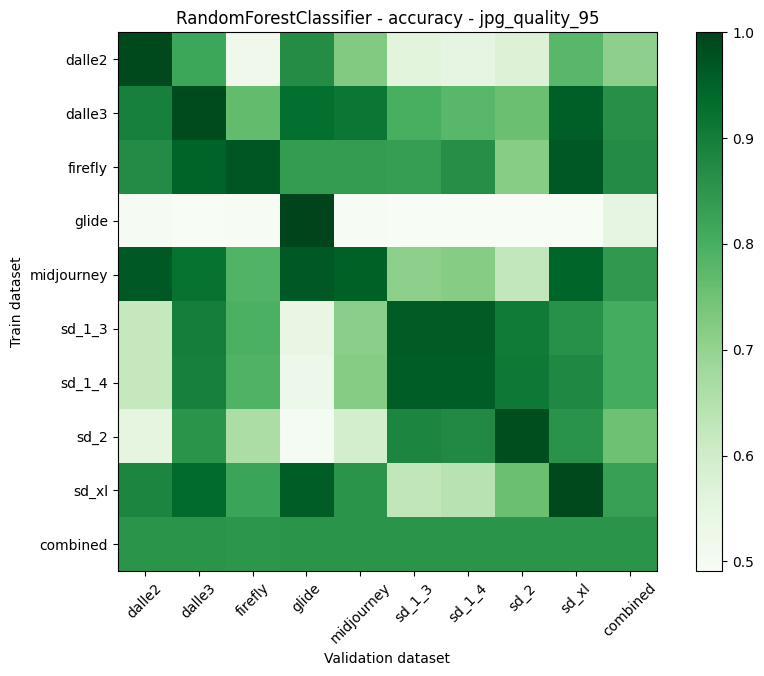

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.818750  0.518750  0.868750    0.725000  0.559375   
dalle3         0.893750  0.987500  0.765625  0.928125    0.912500  0.800000   
firefly        0.871875  0.950000  0.971875  0.837500    0.837500  0.834375   
glide          0.496875  0.490625  0.493750  1.000000    0.493750  0.490625   
midjourney     0.965625  0.921875  0.787500  0.965625    0.953125  0.709375   
sd_1_3         0.621875  0.896875  0.793750  0.543750    0.712500  0.962500   
sd_1_4         0.621875  0.893750  0.790625  0.528125    0.718750  0.959375   
sd_2           0.553125  0.853125  0.665625  0.500000    0.590625  0.884375   
sd_xl          0.884375  0.937500  0.821875  0.959375    0.853125  0.628125   
combined       0.853125  0.853125  0.850000  0.853125    0.853125  0.853125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.550000  0.571875  0.778125  0.709028  
dalle3         0.778125  0.756250  0.956250  0.864236  
firefly        0.865625  0.715625  0.965625  0.872222  
glide          0.490625  0.490625  0.490625  0.548611  
midjourney     0.718750  0.625000  0.946875  0.843750  
sd_1_3         0.962500  0.906250  0.859375  0.806597  
sd_1_4         0.959375  0.909375  0.878125  0.806597  
sd_2           0.875000  0.984375  0.856250  0.751389  
sd_xl          0.643750  0.756250  0.990625  0.830556  
combined       0.853125  0.853125  0.853125  0.852778

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990625  0.818750  0.518750  0.868750    0.725000  0.559375   
dalle3         0.893750  0.987500  0.765625  0.928125    0.912500  0.800000   
firefly        0.871875  0.950000  0.971875  0.837500    0.837500  0.834375   
glide          0.496875  0.490625  0.493750  1.000000    0.493750  0.490625   
midjourney     0.965625  0.921875  0.787500  0.965625    0.953125  0.709375   
sd_1_3         0.621875  0.896875  0.793750  0.543750    0.712500  0.962500   
sd_1_4         0.621875  0.893750  0.790625  0.528125    0.718750  0.959375   
sd_2           0.553125  0.853125  0.665625  0.500000    0.590625  0.884375   
sd_xl          0.884375  0.937500  0.821875  0.959375    0.853125  0.628125   
combined       0.853125  0.853125  0.850000  0.853125    0.853125  0.853125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.550000  0.571875  0.778125  0.709028  
dalle3         0.778125  0.756250  0.956250  0.864236  
firefly        0.865625  0.715625  0.965625  0.872222  
glide          0.490625  0.490625  0.490625  0.548611  
midjourney     0.718750  0.625000  0.946875  0.843750  
sd_1_3         0.962500  0.906250  0.859375  0.806597  
sd_1_4         0.959375  0.909375  0.878125  0.806597  
sd_2           0.875000  0.984375  0.856250  0.751389  
sd_xl          0.643750  0.756250  0.990625  0.830556  
combined       0.853125  0.853125  0.853125  0.852778

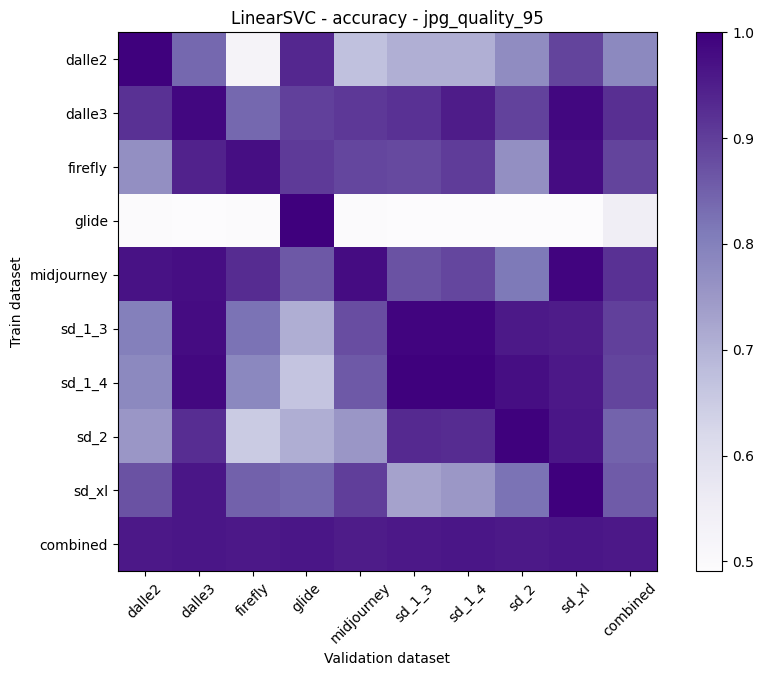

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.996875  0.837500  0.525000  0.934375    0.671875  0.706250   
dalle3         0.918750  0.987500  0.837500  0.896875    0.909375  0.918750   
firefly        0.768750  0.943750  0.975000  0.906250    0.887500  0.884375   
glide          0.493750  0.490625  0.493750  1.000000    0.493750  0.490625   
midjourney     0.968750  0.975000  0.928125  0.862500    0.978125  0.868750   
sd_1_3         0.800000  0.978125  0.821875  0.709375    0.878125  0.990625   
sd_1_4         0.781250  0.984375  0.784375  0.665625    0.859375  0.996875   
sd_2           0.753125  0.925000  0.650000  0.709375    0.753125  0.931250   
sd_xl          0.868750  0.962500  0.846875  0.837500    0.900000  0.731250   
combined       0.959375  0.962500  0.959375  0.962500    0.953125  0.959375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.706250  0.775000  0.890625  0.782639  
dalle3         0.953125  0.893750  0.987500  0.922569  
firefly        0.903125  0.768750  0.978125  0.890625  
glide          0.490625  0.490625  0.490625  0.548264  
midjourney     0.887500  0.812500  0.990625  0.919097  
sd_1_3         0.990625  0.956250  0.953125  0.897569  
sd_1_4         0.996875  0.975000  0.959375  0.889236  
sd_2           0.928125  0.996875  0.962500  0.845486  
sd_xl          0.750000  0.821875  1.000000  0.857639  
combined       0.962500  0.956250  0.962500  0.959722

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.996875  0.837500  0.525000  0.934375    0.671875  0.706250   
dalle3         0.918750  0.987500  0.837500  0.896875    0.909375  0.918750   
firefly        0.768750  0.943750  0.975000  0.906250    0.887500  0.884375   
glide          0.493750  0.490625  0.493750  1.000000    0.493750  0.490625   
midjourney     0.968750  0.975000  0.928125  0.862500    0.978125  0.868750   
sd_1_3         0.800000  0.978125  0.821875  0.709375    0.878125  0.990625   
sd_1_4         0.781250  0.984375  0.784375  0.665625    0.859375  0.996875   
sd_2           0.753125  0.925000  0.650000  0.709375    0.753125  0.931250   
sd_xl          0.868750  0.962500  0.846875  0.837500    0.900000  0.731250   
combined       0.959375  0.962500  0.959375  0.962500    0.953125  0.959375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.706250  0.775000  0.890625  0.782639  
dalle3         0.953125  0.893750  0.987500  0.922569  
firefly        0.903125  0.768750  0.978125  0.890625  
glide          0.490625  0.490625  0.490625  0.548264  
midjourney     0.887500  0.812500  0.990625  0.919097  
sd_1_3         0.990625  0.956250  0.953125  0.897569  
sd_1_4         0.996875  0.975000  0.959375  0.889236  
sd_2           0.928125  0.996875  0.962500  0.845486  
sd_xl          0.750000  0.821875  1.000000  0.857639  
combined       0.962500  0.956250  0.962500  0.959722









 ################ Evaluating models trained on standard and tested on standard. ################


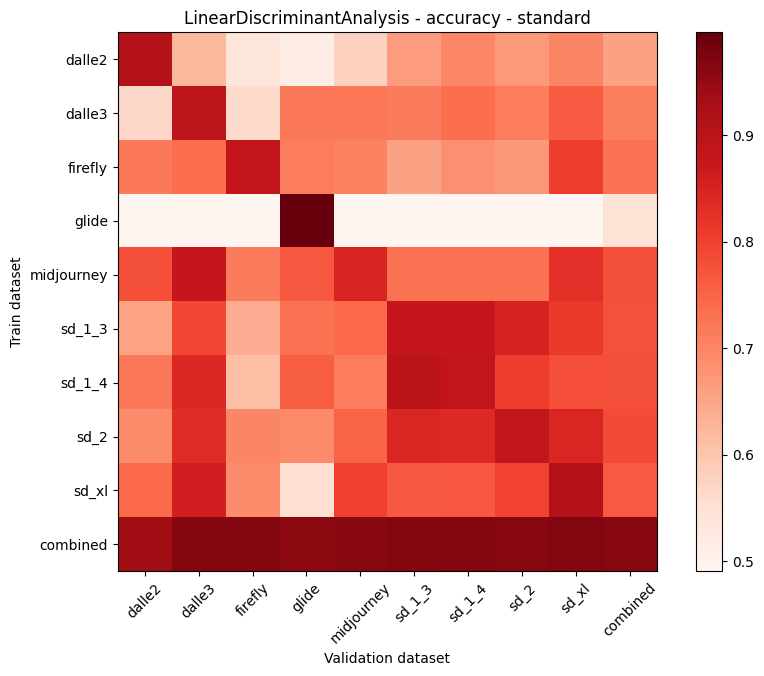

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.909375  0.621875  0.537500  0.515625    0.578125  0.665625   
dalle3         0.568750  0.893750  0.562500  0.718750    0.718750  0.715625   
firefly        0.718750  0.734375  0.884375  0.712500    0.706250  0.656250   
glide          0.493750  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.778125  0.881250  0.715625  0.765625    0.846875  0.731250   
sd_1_3         0.653125  0.790625  0.640625  0.731250    0.743750  0.881250   
sd_1_4         0.718750  0.840625  0.609375  0.759375    0.712500  0.896875   
sd_2           0.690625  0.834375  0.700000  0.690625    0.750000  0.843750   
sd_xl          0.740625  0.859375  0.690625  0.553125    0.800000  0.765625   
combined       0.937500  0.965625  0.965625  0.956250    0.962500  0.965625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.696875  0.668750  0.700000  0.654861  
dalle3         0.737500  0.712500  0.762500  0.710069  
firefly        0.684375  0.671875  0.803125  0.730208  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.731250  0.731250  0.828125  0.778819  
sd_1_3         0.881250  0.850000  0.812500  0.776042  
sd_1_4         0.884375  0.803125  0.781250  0.778472  
sd_2           0.837500  0.887500  0.843750  0.786458  
sd_xl          0.768750  0.796875  0.906250  0.764583  
combined       0.968750  0.962500  0.968750  0.961458

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.909375  0.621875  0.537500  0.515625    0.578125  0.665625   
dalle3         0.568750  0.893750  0.562500  0.718750    0.718750  0.715625   
firefly        0.718750  0.734375  0.884375  0.712500    0.706250  0.656250   
glide          0.493750  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.778125  0.881250  0.715625  0.765625    0.846875  0.731250   
sd_1_3         0.653125  0.790625  0.640625  0.731250    0.743750  0.881250   
sd_1_4         0.718750  0.840625  0.609375  0.759375    0.712500  0.896875   
sd_2           0.690625  0.834375  0.700000  0.690625    0.750000  0.843750   
sd_xl          0.740625  0.859375  0.690625  0.553125    0.800000  0.765625   
combined       0.937500  0.965625  0.965625  0.956250    0.962500  0.965625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.696875  0.668750  0.700000  0.654861  
dalle3         0.737500  0.712500  0.762500  0.710069  
firefly        0.684375  0.671875  0.803125  0.730208  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.731250  0.731250  0.828125  0.778819  
sd_1_3         0.881250  0.850000  0.812500  0.776042  
sd_1_4         0.884375  0.803125  0.781250  0.778472  
sd_2           0.837500  0.887500  0.843750  0.786458  
sd_xl          0.768750  0.796875  0.906250  0.764583  
combined       0.968750  0.962500  0.968750  0.961458

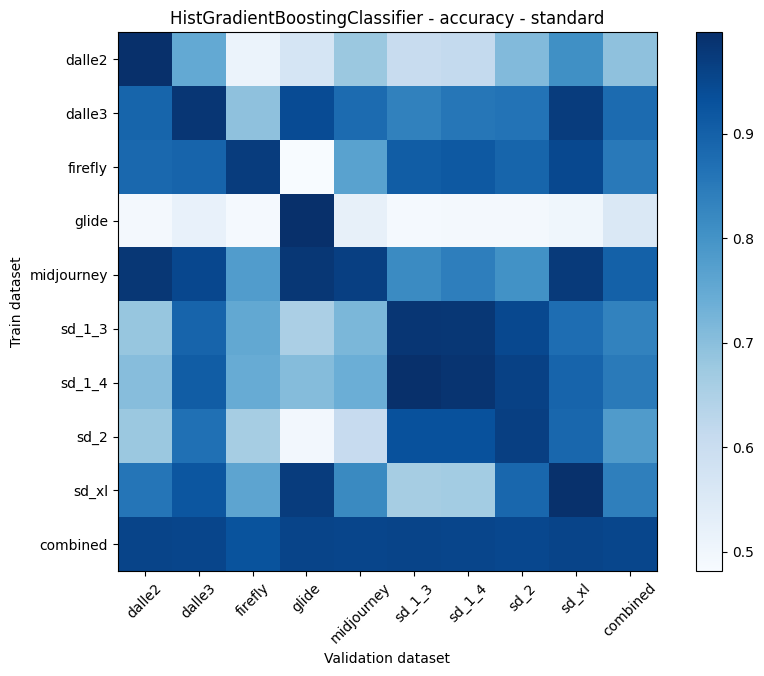

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.996875  0.750000  0.512500  0.568750    0.678125  0.603125   
dalle3         0.890625  0.984375  0.693750  0.940625    0.878125  0.834375   
firefly        0.884375  0.893750  0.971875  0.481250    0.765625  0.906250   
glide          0.490625  0.518750  0.487500  0.996875    0.521875  0.487500   
midjourney     0.981250  0.950000  0.778125  0.981250    0.965625  0.815625   
sd_1_3         0.684375  0.893750  0.753125  0.653125    0.718750  0.984375   
sd_1_4         0.703125  0.906250  0.743750  0.706250    0.737500  0.996875   
sd_2           0.678125  0.868750  0.662500  0.493750    0.606250  0.931250   
sd_xl          0.859375  0.921875  0.759375  0.971875    0.818750  0.662500   
combined       0.956250  0.953125  0.928125  0.956250    0.953125  0.956250   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.612500  0.709375  0.806250  0.693056  
dalle3         0.856250  0.862500  0.971875  0.879167  
firefly        0.915625  0.890625  0.946875  0.850694  
glide          0.490625  0.490625  0.500000  0.553819  
midjourney     0.840625  0.803125  0.975000  0.898958  
sd_1_3         0.981250  0.946875  0.875000  0.832292  
sd_1_4         0.987500  0.962500  0.893750  0.848611  
sd_2           0.931250  0.965625  0.887500  0.780556  
sd_xl          0.665625  0.887500  0.993750  0.837847  
combined       0.953125  0.950000  0.956250  0.951389

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.996875  0.750000  0.512500  0.568750    0.678125  0.603125   
dalle3         0.890625  0.984375  0.693750  0.940625    0.878125  0.834375   
firefly        0.884375  0.893750  0.971875  0.481250    0.765625  0.906250   
glide          0.490625  0.518750  0.487500  0.996875    0.521875  0.487500   
midjourney     0.981250  0.950000  0.778125  0.981250    0.965625  0.815625   
sd_1_3         0.684375  0.893750  0.753125  0.653125    0.718750  0.984375   
sd_1_4         0.703125  0.906250  0.743750  0.706250    0.737500  0.996875   
sd_2           0.678125  0.868750  0.662500  0.493750    0.606250  0.931250   
sd_xl          0.859375  0.921875  0.759375  0.971875    0.818750  0.662500   
combined       0.956250  0.953125  0.928125  0.956250    0.953125  0.956250   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.612500  0.709375  0.806250  0.693056  
dalle3         0.856250  0.862500  0.971875  0.879167  
firefly        0.915625  0.890625  0.946875  0.850694  
glide          0.490625  0.490625  0.500000  0.553819  
midjourney     0.840625  0.803125  0.975000  0.898958  
sd_1_3         0.981250  0.946875  0.875000  0.832292  
sd_1_4         0.987500  0.962500  0.893750  0.848611  
sd_2           0.931250  0.965625  0.887500  0.780556  
sd_xl          0.665625  0.887500  0.993750  0.837847  
combined       0.953125  0.950000  0.956250  0.951389

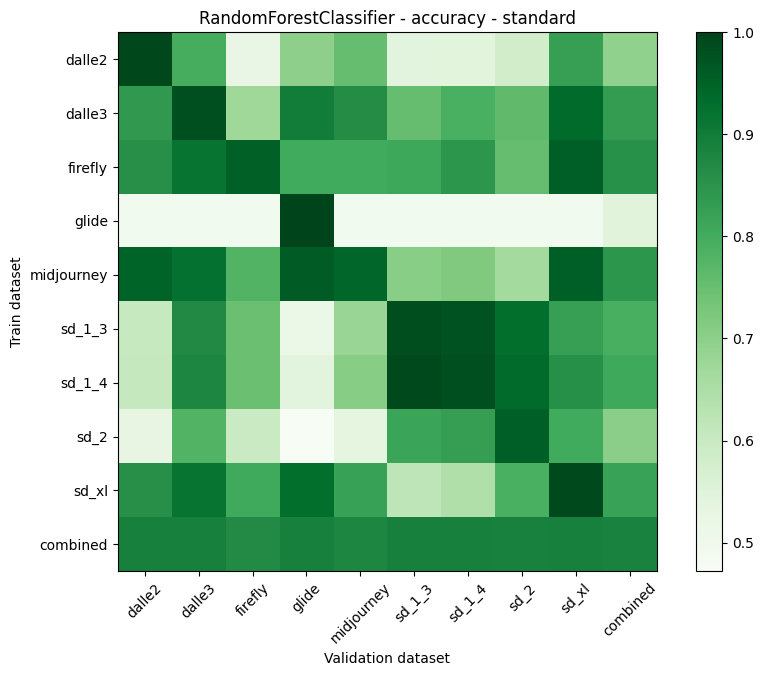

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.793750  0.521875  0.696875    0.753125  0.540625   
dalle3         0.837500  0.981250  0.671875  0.896875    0.865625  0.753125   
firefly        0.859375  0.915625  0.953125  0.800000    0.800000  0.809375   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.946875  0.921875  0.778125  0.962500    0.943750  0.703125   
sd_1_3         0.603125  0.871875  0.746875  0.515625    0.681250  0.984375   
sd_1_4         0.606250  0.878125  0.746875  0.540625    0.706250  0.990625   
sd_2           0.531250  0.778125  0.596875  0.471875    0.537500  0.815625   
sd_xl          0.859375  0.915625  0.803125  0.928125    0.821875  0.618750   
combined       0.890625  0.890625  0.868750  0.890625    0.878125  0.890625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.543750  0.581250  0.825000  0.694444  
dalle3         0.790625  0.759375  0.934375  0.832292  
firefly        0.843750  0.753125  0.956250  0.854514  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.718750  0.662500  0.956250  0.843750  
sd_1_3         0.975000  0.928125  0.825000  0.792361  
sd_1_4         0.981250  0.934375  0.856250  0.804514  
sd_2           0.828125  0.956250  0.800000  0.701736  
sd_xl          0.643750  0.790625  0.990625  0.819097  
combined       0.890625  0.887500  0.890625  0.886458

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.793750  0.521875  0.696875    0.753125  0.540625   
dalle3         0.837500  0.981250  0.671875  0.896875    0.865625  0.753125   
firefly        0.859375  0.915625  0.953125  0.800000    0.800000  0.809375   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.946875  0.921875  0.778125  0.962500    0.943750  0.703125   
sd_1_3         0.603125  0.871875  0.746875  0.515625    0.681250  0.984375   
sd_1_4         0.606250  0.878125  0.746875  0.540625    0.706250  0.990625   
sd_2           0.531250  0.778125  0.596875  0.471875    0.537500  0.815625   
sd_xl          0.859375  0.915625  0.803125  0.928125    0.821875  0.618750   
combined       0.890625  0.890625  0.868750  0.890625    0.878125  0.890625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.543750  0.581250  0.825000  0.694444  
dalle3         0.790625  0.759375  0.934375  0.832292  
firefly        0.843750  0.753125  0.956250  0.854514  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.718750  0.662500  0.956250  0.843750  
sd_1_3         0.975000  0.928125  0.825000  0.792361  
sd_1_4         0.981250  0.934375  0.856250  0.804514  
sd_2           0.828125  0.956250  0.800000  0.701736  
sd_xl          0.643750  0.790625  0.990625  0.819097  
combined       0.890625  0.887500  0.890625  0.886458

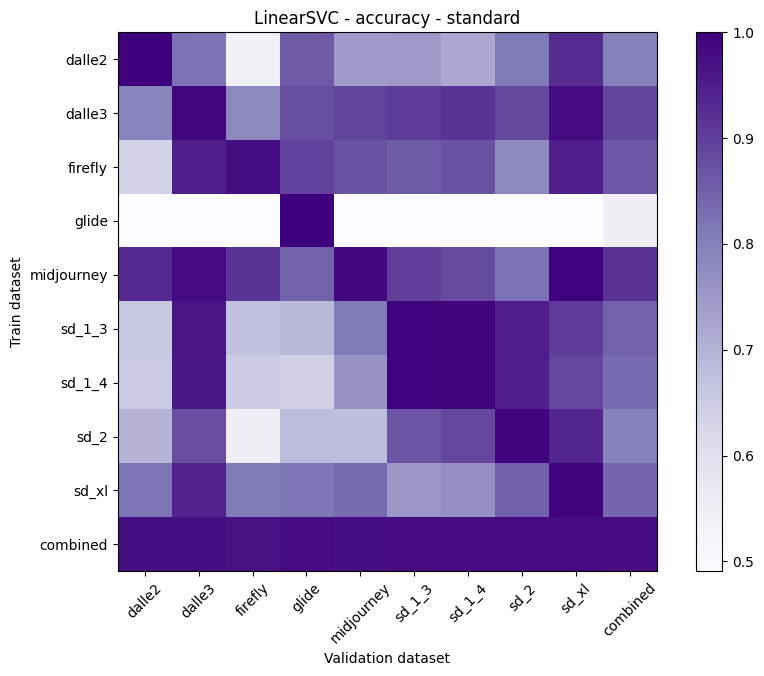

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.821875  0.540625  0.859375    0.743750  0.746875   
dalle3         0.790625  0.987500  0.781250  0.875000    0.890625  0.903125   
firefly        0.634375  0.950000  0.975000  0.893750    0.868750  0.856250   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.931250  0.981250  0.912500  0.846875    0.984375  0.900000   
sd_1_3         0.659375  0.965625  0.671875  0.687500    0.809375  0.996875   
sd_1_4         0.650000  0.962500  0.650000  0.637500    0.762500  0.996875   
sd_2           0.696875  0.878125  0.550000  0.681250    0.678125  0.865625   
sd_xl          0.818750  0.940625  0.809375  0.815625    0.834375  0.750000   
combined       0.975000  0.975000  0.971875  0.981250    0.975000  0.978125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.715625  0.809375  0.928125  0.796181  
dalle3         0.915625  0.884375  0.981250  0.889931  
firefly        0.868750  0.781250  0.950000  0.864236  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.881250  0.821875  0.996875  0.917361  
sd_1_3         0.990625  0.950000  0.903125  0.848264  
sd_1_4         0.990625  0.950000  0.887500  0.831944  
sd_2           0.887500  0.990625  0.937500  0.796181  
sd_xl          0.765625  0.850000  0.990625  0.841667  
combined       0.981250  0.981250  0.981250  0.977778

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.821875  0.540625  0.859375    0.743750  0.746875   
dalle3         0.790625  0.987500  0.781250  0.875000    0.890625  0.903125   
firefly        0.634375  0.950000  0.975000  0.893750    0.868750  0.856250   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.931250  0.981250  0.912500  0.846875    0.984375  0.900000   
sd_1_3         0.659375  0.965625  0.671875  0.687500    0.809375  0.996875   
sd_1_4         0.650000  0.962500  0.650000  0.637500    0.762500  0.996875   
sd_2           0.696875  0.878125  0.550000  0.681250    0.678125  0.865625   
sd_xl          0.818750  0.940625  0.809375  0.815625    0.834375  0.750000   
combined       0.975000  0.975000  0.971875  0.981250    0.975000  0.978125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.715625  0.809375  0.928125  0.796181  
dalle3         0.915625  0.884375  0.981250  0.889931  
firefly        0.868750  0.781250  0.950000  0.864236  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.881250  0.821875  0.996875  0.917361  
sd_1_3         0.990625  0.950000  0.903125  0.848264  
sd_1_4         0.990625  0.950000  0.887500  0.831944  
sd_2           0.887500  0.990625  0.937500  0.796181  
sd_xl          0.765625  0.850000  0.990625  0.841667  
combined       0.981250  0.981250  0.981250  0.977778

In [12]:
print("########################### Accuracy ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "accuracy"
    evaluation_data_name = "Validation"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

### MCC - Validation

########################### MCC ###########################








 ################ Evaluating models trained on standard and tested on jpg_quality_50. ################


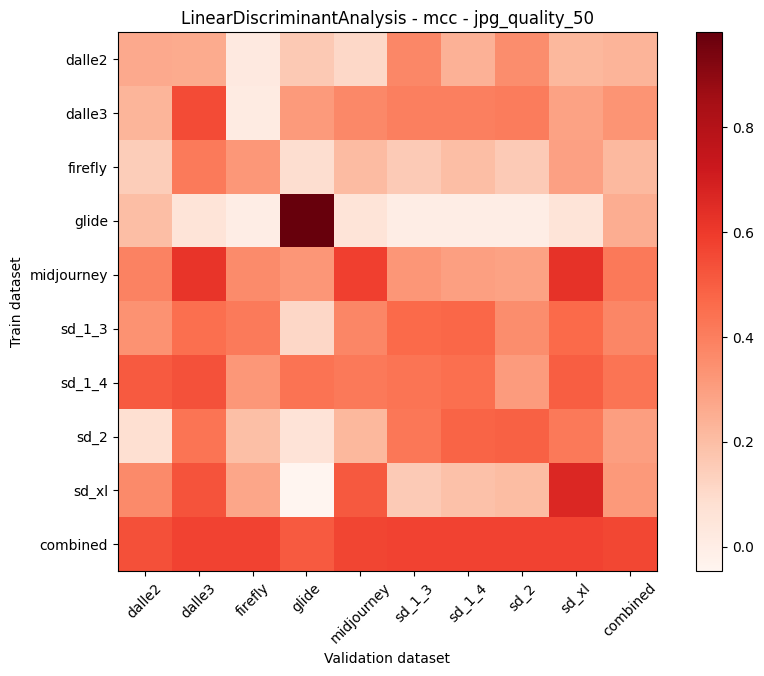

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.265940  0.259582  0.022553  0.160445    0.108820  0.371199   
dalle3         0.228635  0.550545  0.012968  0.310948    0.368719  0.397552   
firefly        0.149221  0.412450  0.319979  0.085796    0.208209  0.155672   
glide          0.201957  0.054949  0.000000  0.981423    0.054949  0.000000   
midjourney     0.387126  0.617794  0.362155  0.325181    0.581021  0.325181   
sd_1_3         0.337460  0.447437  0.411938  0.111197    0.377994  0.465838   
sd_1_4         0.510942  0.531531  0.319065  0.438064    0.418789  0.431614   
sd_2           0.079789  0.431909  0.194235  0.061190    0.220648  0.423822   
sd_xl          0.365934  0.531434  0.277230 -0.046980    0.512346  0.157525   
combined       0.535674  0.573570  0.573570  0.508443    0.563914  0.573570   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.240049  0.354578  0.219730  0.234117  
dalle3         0.397552  0.409102  0.287674  0.332177  
firefly        0.201543  0.155672  0.291002  0.216400  
glide          0.000000  0.000000  0.054949  0.250385  
midjourney     0.294712  0.288647  0.625309  0.417370  
sd_1_3         0.475216  0.353440  0.465838  0.376150  
sd_1_4         0.451044  0.306869  0.497401  0.432329  
sd_2           0.482126  0.490802  0.415808  0.299965  
sd_xl          0.187889  0.205928  0.666072  0.316591  
combined       0.573570  0.573570  0.573570  0.560723

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.265940  0.259582  0.022553  0.160445    0.108820  0.371199   
dalle3         0.228635  0.550545  0.012968  0.310948    0.368719  0.397552   
firefly        0.149221  0.412450  0.319979  0.085796    0.208209  0.155672   
glide          0.201957  0.054949  0.000000  0.981423    0.054949  0.000000   
midjourney     0.387126  0.617794  0.362155  0.325181    0.581021  0.325181   
sd_1_3         0.337460  0.447437  0.411938  0.111197    0.377994  0.465838   
sd_1_4         0.510942  0.531531  0.319065  0.438064    0.418789  0.431614   
sd_2           0.079789  0.431909  0.194235  0.061190    0.220648  0.423822   
sd_xl          0.365934  0.531434  0.277230 -0.046980    0.512346  0.157525   
combined       0.535674  0.573570  0.573570  0.508443    0.563914  0.573570   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.240049  0.354578  0.219730  0.222544  
dalle3         0.397552  0.409102  0.287674  0.329299  
firefly        0.201543  0.155672  0.291002  0.219949  
glide          0.000000  0.000000  0.054949  0.149803  
midjourney     0.294712  0.288647  0.625309  0.423014  
sd_1_3         0.475216  0.353440  0.465838  0.382929  
sd_1_4         0.451044  0.306869  0.497401  0.433924  
sd_2           0.482126  0.490802  0.415808  0.311148  
sd_xl          0.187889  0.205928  0.666072  0.317487  
combined       0.573570  0.573570  0.573570  0.561050

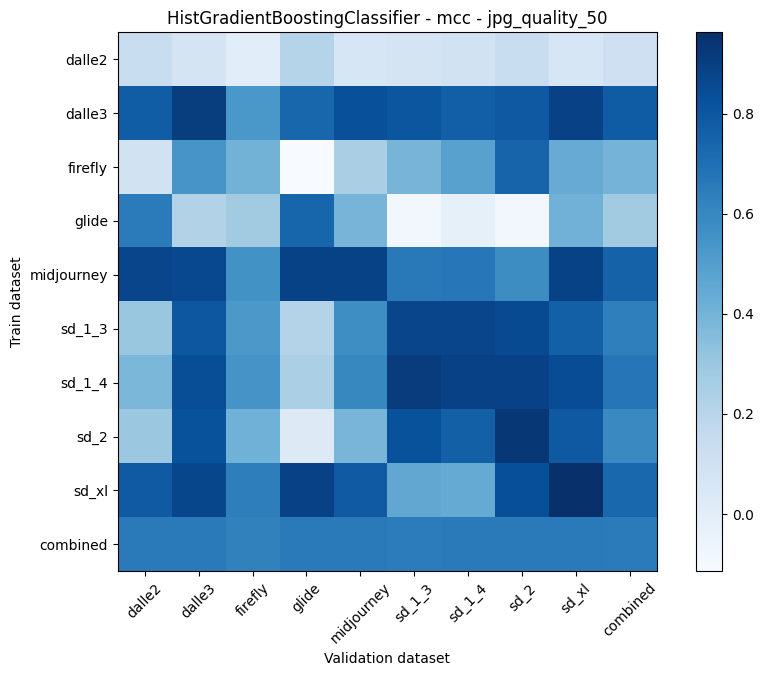

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.135665  0.077832  0.000000  0.209923    0.054949  0.077832   
dalle3         0.775269  0.904330  0.532008  0.739158    0.831499  0.806175   
firefly        0.087675  0.538569  0.402139 -0.114638    0.250573  0.391543   
glide          0.650919  0.220346  0.273978  0.742561    0.394084 -0.082602   
midjourney     0.872331  0.858830  0.555142  0.886010    0.886010  0.655819   
sd_1_3         0.300953  0.800086  0.527787  0.215825    0.571648  0.872331   
sd_1_4         0.377942  0.837629  0.545012  0.243865    0.599018  0.910077   
sd_2           0.296746  0.821672  0.409048  0.022553    0.387564  0.821672   
sd_xl          0.789927  0.870218  0.636428  0.888164    0.789927  0.454464   
combined       0.652188  0.652188  0.626123  0.652188    0.652188  0.643409   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.095474  0.135665  0.054949  0.108855  
dalle3         0.769180  0.793717  0.890705  0.778664  
firefly        0.483977  0.745014  0.433349  0.395677  
glide         -0.025634 -0.082602  0.406321  0.275962  
midjourney     0.667314  0.577169  0.886010  0.753660  
sd_1_3         0.872331  0.852144  0.762532  0.633048  
sd_1_4         0.889817  0.889817  0.844016  0.671507  
sd_2           0.764725  0.931641  0.792889  0.589596  
sd_xl          0.444161  0.835155  0.963139  0.733653  
combined       0.652188  0.652188  0.652188  0.648275

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.135665  0.077832  0.000000  0.209923    0.054949  0.077832   
dalle3         0.775269  0.904330  0.532008  0.739158    0.831499  0.806175   
firefly        0.087675  0.538569  0.402139 -0.114638    0.250573  0.391543   
glide          0.650919  0.220346  0.273978  0.742561    0.394084 -0.082602   
midjourney     0.872331  0.858830  0.555142  0.886010    0.886010  0.655819   
sd_1_3         0.300953  0.800086  0.527787  0.215825    0.571648  0.872331   
sd_1_4         0.377942  0.837629  0.545012  0.243865    0.599018  0.910077   
sd_2           0.296746  0.821672  0.409048  0.022553    0.387564  0.821672   
sd_xl          0.789927  0.870218  0.636428  0.888164    0.789927  0.454464   
combined       0.652188  0.652188  0.626123  0.652188    0.652188  0.643409   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.095474  0.135665  0.054949  0.093588  
dalle3         0.769180  0.793717  0.890705  0.782449  
firefly        0.483977  0.745014  0.433349  0.357578  
glide         -0.025634 -0.082602  0.406321  0.277486  
midjourney     0.667314  0.577169  0.886010  0.760515  
sd_1_3         0.872331  0.852144  0.762532  0.641737  
sd_1_4         0.889817  0.889817  0.844016  0.681910  
sd_2           0.764725  0.931641  0.792889  0.583168  
sd_xl          0.444161  0.835155  0.963139  0.741287  
combined       0.652188  0.652188  0.652188  0.648316

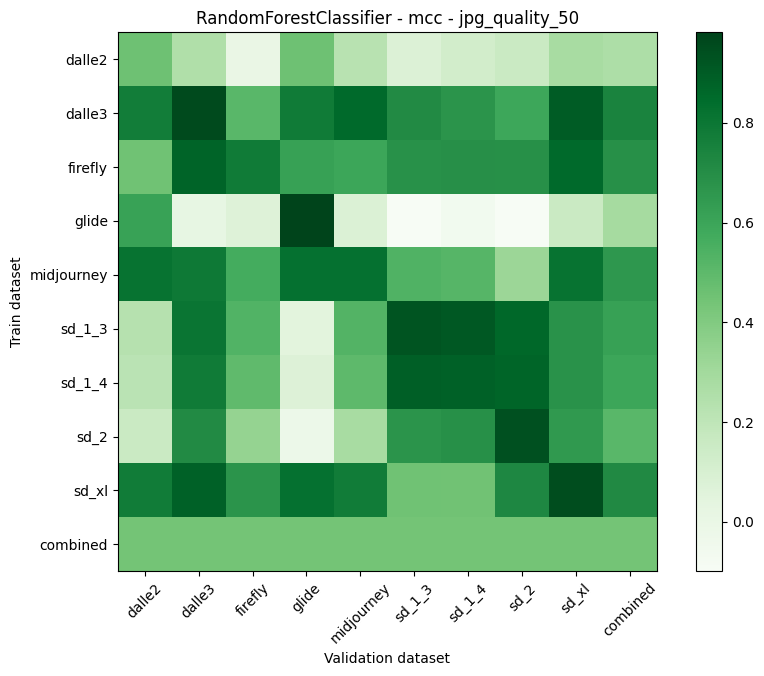

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.456894  0.253402  0.000000  0.456894    0.225154  0.077832   
dalle3         0.771772  0.957117  0.511522  0.782903    0.851785  0.712008   
firefly        0.451134  0.875288  0.781553  0.615320    0.594728  0.683267   
glide          0.611382  0.018563  0.068487  0.981410    0.082239 -0.099123   
midjourney     0.815697  0.787484  0.565226  0.822873    0.822873  0.535905   
sd_1_3         0.233370  0.804324  0.533364  0.046807    0.528258  0.925228   
sd_1_4         0.215141  0.782101  0.494149  0.072456    0.499465  0.889072   
sd_2           0.154579  0.714168  0.342050 -0.020694    0.276706  0.672364   
sd_xl          0.775921  0.881405  0.672685  0.821672    0.775921  0.451134   
combined       0.438477  0.438477  0.438477  0.438477    0.438477  0.438477   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.123648  0.157153  0.279458  0.260094  
dalle3         0.669821  0.592659  0.900059  0.744319  
firefly        0.693906  0.688579  0.851151  0.689170  
glide         -0.058374 -0.099123  0.158208  0.287313  
midjourney     0.518486  0.318839  0.815697  0.657489  
sd_1_3         0.912520  0.863155  0.677969  0.618189  
sd_1_4         0.882484  0.869430  0.677885  0.596781  
sd_2           0.687937  0.937537  0.651768  0.512607  
sd_xl          0.445925  0.726204  0.951128  0.715971  
combined       0.438477  0.438477  0.438477  0.438477

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.456894  0.253402  0.000000  0.456894    0.225154  0.077832   
dalle3         0.771772  0.957117  0.511522  0.782903    0.851785  0.712008   
firefly        0.451134  0.875288  0.781553  0.615320    0.594728  0.683267   
glide          0.611382  0.018563  0.068487  0.981410    0.082239 -0.099123   
midjourney     0.815697  0.787484  0.565226  0.822873    0.822873  0.535905   
sd_1_3         0.233370  0.804324  0.533364  0.046807    0.528258  0.925228   
sd_1_4         0.215141  0.782101  0.494149  0.072456    0.499465  0.889072   
sd_2           0.154579  0.714168  0.342050 -0.020694    0.276706  0.672364   
sd_xl          0.775921  0.881405  0.672685  0.821672    0.775921  0.451134   
combined       0.438477  0.438477  0.438477  0.438477    0.438477  0.438477   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.123648  0.157153  0.279458  0.225604  
dalle3         0.669821  0.592659  0.900059  0.749961  
firefly        0.693906  0.688579  0.851151  0.692770  
glide         -0.058374 -0.099123  0.158208  0.184852  
midjourney     0.518486  0.318839  0.815697  0.667009  
sd_1_3         0.912520  0.863155  0.677969  0.613888  
sd_1_4         0.882484  0.869430  0.677885  0.598020  
sd_2           0.687937  0.937537  0.651768  0.490713  
sd_xl          0.445925  0.726204  0.951128  0.722444  
combined       0.438477  0.438477  0.438477  0.438477

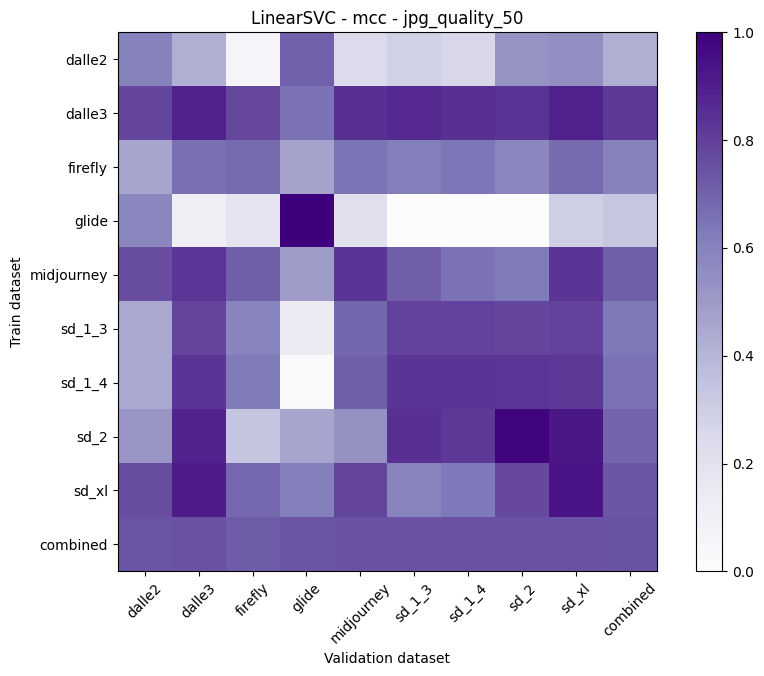

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.599705  0.427332  0.054949  0.705388    0.239601  0.291856   
dalle3         0.781234  0.887254  0.774929  0.648992    0.846265  0.866556   
firefly        0.457046  0.663426  0.672013  0.471012    0.646503  0.613599   
glide          0.580792  0.110419  0.185171  1.000000    0.209923  0.000000   
midjourney     0.761033  0.824635  0.707447  0.494323    0.831952  0.707447   
sd_1_3         0.446492  0.781639  0.587705  0.144042    0.687460  0.789259   
sd_1_4         0.448403  0.831952  0.625005  0.022439    0.707447  0.831952   
sd_2           0.523316  0.884306  0.337401  0.458956    0.538005  0.850035   
sd_xl          0.760942  0.907011  0.682684  0.612872    0.784092  0.597026   
combined       0.739753  0.747690  0.716334  0.739753    0.747690  0.747690   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.260094  0.533542  0.547732  0.428992  
dalle3         0.846265  0.832950  0.887254  0.816895  
firefly        0.638162  0.581839  0.672013  0.598466  
glide          0.000000  0.000000  0.297923  0.335906  
midjourney     0.649846  0.625005  0.831952  0.710360  
sd_1_3         0.789259  0.781639  0.789259  0.631800  
sd_1_4         0.831952  0.824635  0.817372  0.649846  
sd_2           0.816728  0.981410  0.925677  0.692612  
sd_xl          0.634133  0.772467  0.933353  0.738174  
combined       0.747690  0.747690  0.747690  0.742391

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.599705  0.427332  0.054949  0.705388    0.239601  0.291856   
dalle3         0.781234  0.887254  0.774929  0.648992    0.846265  0.866556   
firefly        0.457046  0.663426  0.672013  0.471012    0.646503  0.613599   
glide          0.580792  0.110419  0.185171  1.000000    0.209923  0.000000   
midjourney     0.761033  0.824635  0.707447  0.494323    0.831952  0.707447   
sd_1_3         0.446492  0.781639  0.587705  0.144042    0.687460  0.789259   
sd_1_4         0.448403  0.831952  0.625005  0.022439    0.707447  0.831952   
sd_2           0.523316  0.884306  0.337401  0.458956    0.538005  0.850035   
sd_xl          0.760942  0.907011  0.682684  0.612872    0.784092  0.597026   
combined       0.739753  0.747690  0.716334  0.739753    0.747690  0.747690   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.260094  0.533542  0.547732  0.406689  
dalle3         0.846265  0.832950  0.887254  0.819078  
firefly        0.638162  0.581839  0.672013  0.601735  
glide          0.000000  0.000000  0.297923  0.264914  
midjourney     0.649846  0.625005  0.831952  0.714849  
sd_1_3         0.789259  0.781639  0.789259  0.644084  
sd_1_4         0.831952  0.824635  0.817372  0.660129  
sd_2           0.816728  0.981410  0.925677  0.701759  
sd_xl          0.634133  0.772467  0.933353  0.742731  
combined       0.747690  0.747690  0.747690  0.742442









 ################ Evaluating models trained on standard and tested on jpg_quality_70. ################


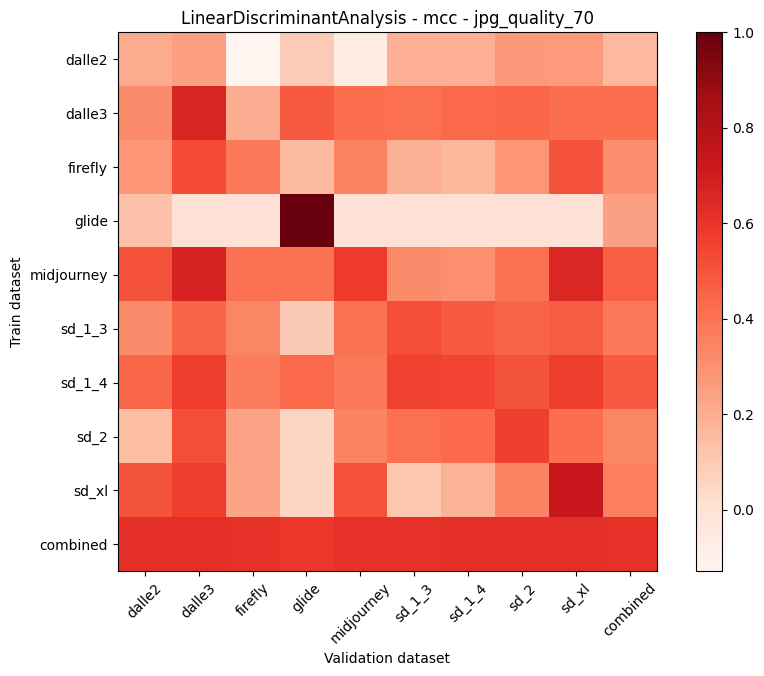

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.208701  0.246900 -0.128621  0.093419   -0.061918  0.195491   
dalle3         0.318777  0.662747  0.199472  0.482328    0.414976  0.409367   
firefly        0.280735  0.526865  0.384622  0.157091    0.344900  0.187654   
glide          0.135665  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.506359  0.676620  0.412997  0.406917    0.578413  0.322966   
sd_1_3         0.320033  0.452902  0.335537  0.098262    0.408992  0.519076   
sd_1_4         0.443523  0.568618  0.369078  0.437214    0.381317  0.554890   
sd_2           0.148853  0.515542  0.239233  0.049447    0.349829  0.409512   
sd_xl          0.500528  0.568624  0.235250  0.053083    0.506613  0.112392   
combined       0.622624  0.622624  0.613540  0.586885    0.613540  0.613540   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.195491  0.271368  0.265316  0.160402  
dalle3         0.437401  0.448616  0.414976  0.421207  
firefly        0.163194  0.280735  0.504327  0.309691  
glide          0.000000  0.000000  0.000000  0.245039  
midjourney     0.305154  0.406917  0.654834  0.469848  
sd_1_3         0.480528  0.452902  0.471204  0.384698  
sd_1_4         0.548083  0.501409  0.568618  0.484033  
sd_2           0.432875  0.560201  0.417235  0.336226  
sd_xl          0.181091  0.340870  0.729872  0.357069  
combined       0.622624  0.622624  0.622624  0.615550

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.208701  0.246900 -0.128621  0.093419   -0.061918  0.195491   
dalle3         0.318777  0.662747  0.199472  0.482328    0.414976  0.409367   
firefly        0.280735  0.526865  0.384622  0.157091    0.344900  0.187654   
glide          0.135665  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.506359  0.676620  0.412997  0.406917    0.578413  0.322966   
sd_1_3         0.320033  0.452902  0.335537  0.098262    0.408992  0.519076   
sd_1_4         0.443523  0.568618  0.369078  0.437214    0.381317  0.554890   
sd_2           0.148853  0.515542  0.239233  0.049447    0.349829  0.409512   
sd_xl          0.500528  0.568624  0.235250  0.053083    0.506613  0.112392   
combined       0.622624  0.622624  0.613540  0.586885    0.613540  0.613540   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.195491  0.271368  0.265316  0.142905  
dalle3         0.437401  0.448616  0.414976  0.420962  
firefly        0.163194  0.280735  0.504327  0.314458  
glide          0.000000  0.000000  0.000000  0.126185  
midjourney     0.305154  0.406917  0.654834  0.474575  
sd_1_3         0.480528  0.452902  0.471204  0.393271  
sd_1_4         0.548083  0.501409  0.568618  0.485861  
sd_2           0.432875  0.560201  0.417235  0.346970  
sd_xl          0.181091  0.340870  0.729872  0.358702  
combined       0.622624  0.622624  0.622624  0.615625

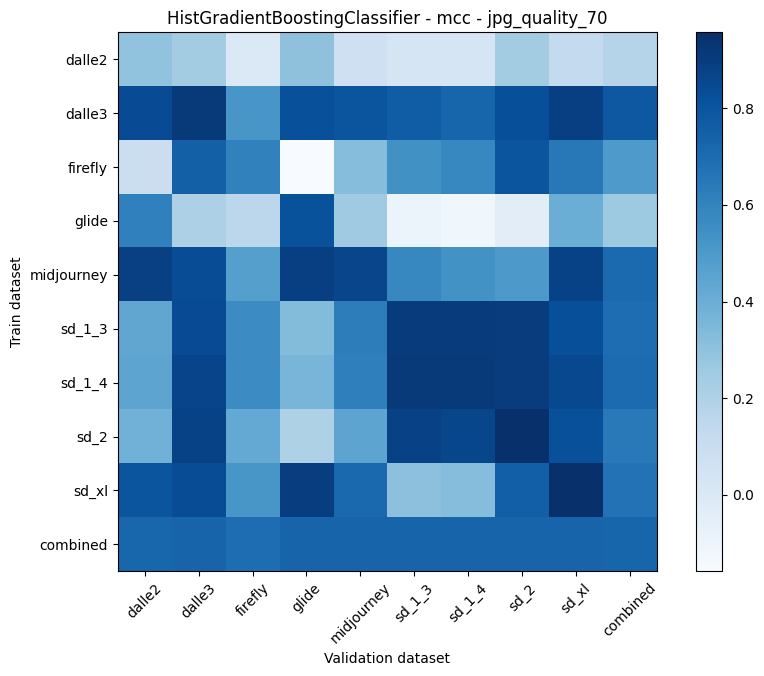

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.294213  0.241956 -0.001487  0.300297    0.073243  0.030609   
dalle3         0.837470  0.915852  0.515409  0.818724    0.800274  0.764186   
firefly        0.092068  0.750757  0.604788 -0.157937    0.322946  0.542352   
glide          0.612374  0.204529  0.155110  0.810451    0.252431 -0.090896   
midjourney     0.884913  0.831850  0.470343  0.891739    0.864702  0.584408   
sd_1_3         0.435437  0.837470  0.563361  0.330712    0.622688  0.909091   
sd_1_4         0.443262  0.869946  0.561136  0.361285    0.615400  0.910077   
sd_2           0.380803  0.876168  0.423369  0.202119    0.444161  0.882149   
sd_xl          0.799774  0.834199  0.516598  0.893907    0.712008  0.307783   
combined       0.724285  0.732345  0.692722  0.732345    0.732345  0.732345   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.030609  0.241956  0.129144  0.180345  
dalle3         0.729062  0.824938  0.889072  0.784107  
firefly        0.583895  0.796619  0.646983  0.495702  
glide         -0.117657 -0.040825  0.403325  0.256371  
midjourney     0.535268  0.502774  0.878132  0.706327  
sd_1_3         0.909091  0.902374  0.824938  0.693508  
sd_1_4         0.910077  0.903279  0.850441  0.702435  
sd_2           0.858412  0.950256  0.818004  0.642667  
sd_xl          0.325360  0.755239  0.957117  0.671561  
combined       0.732345  0.732345  0.732345  0.726964

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.294213  0.241956 -0.001487  0.300297    0.073243  0.030609   
dalle3         0.837470  0.915852  0.515409  0.818724    0.800274  0.764186   
firefly        0.092068  0.750757  0.604788 -0.157937    0.322946  0.542352   
glide          0.612374  0.204529  0.155110  0.810451    0.252431 -0.090896   
midjourney     0.884913  0.831850  0.470343  0.891739    0.864702  0.584408   
sd_1_3         0.435437  0.837470  0.563361  0.330712    0.622688  0.909091   
sd_1_4         0.443262  0.869946  0.561136  0.361285    0.615400  0.910077   
sd_2           0.380803  0.876168  0.423369  0.202119    0.444161  0.882149   
sd_xl          0.799774  0.834199  0.516598  0.893907    0.712008  0.307783   
combined       0.724285  0.732345  0.692722  0.732345    0.732345  0.732345   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.030609  0.241956  0.129144  0.148949  
dalle3         0.729062  0.824938  0.889072  0.788332  
firefly        0.583895  0.796619  0.646983  0.464719  
glide         -0.117657 -0.040825  0.403325  0.243205  
midjourney     0.535268  0.502774  0.878132  0.716014  
sd_1_3         0.909091  0.902374  0.824938  0.703907  
sd_1_4         0.910077  0.903279  0.850441  0.713878  
sd_2           0.858412  0.950256  0.818004  0.648382  
sd_xl          0.325360  0.755239  0.957117  0.677998  
combined       0.732345  0.732345  0.732345  0.727047

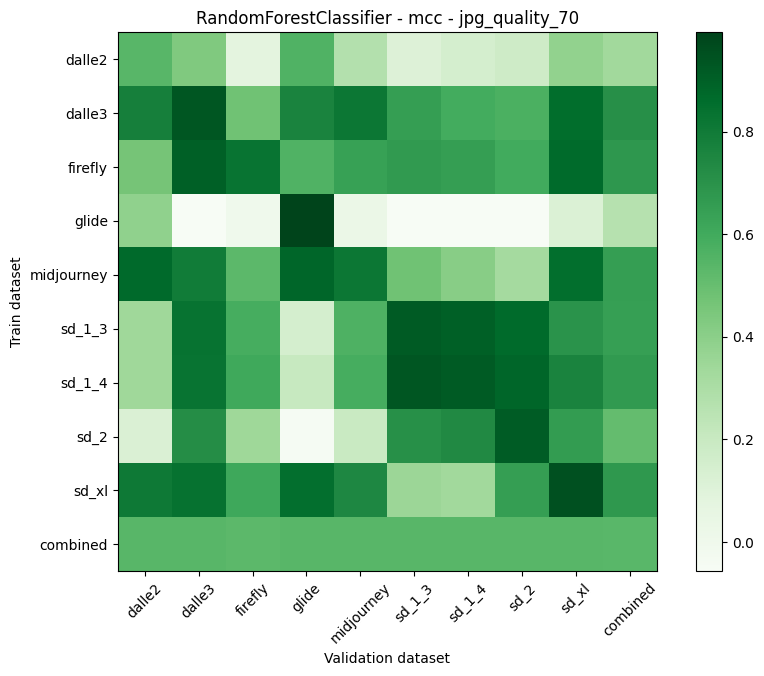

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.538275  0.432305  0.077832  0.561903    0.273113  0.110419   
dalle3         0.779236  0.932634  0.480100  0.762078    0.814243  0.652306   
firefly        0.460985  0.900529  0.825642  0.560296    0.639475  0.666375   
glide          0.384306 -0.057049 -0.001487  0.993766    0.030609 -0.057049   
midjourney     0.867696  0.794270  0.529517  0.881614    0.813810  0.479994   
sd_1_3         0.338762  0.832685  0.586676  0.147800    0.566032  0.919124   
sd_1_4         0.340124  0.826135  0.604788  0.203392    0.583895  0.932634   
sd_2           0.122644  0.718978  0.344429 -0.048520    0.193650  0.708081   
sd_xl          0.806700  0.835155  0.611031  0.846726    0.746175  0.353300   
combined       0.539167  0.539167  0.529049  0.539167    0.539167  0.539167   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.146769  0.176269  0.381468  0.330287  
dalle3         0.594328  0.573486  0.856401  0.710575  
firefly        0.650196  0.597026  0.862452  0.679654  
glide         -0.057049 -0.057049  0.117114  0.263879  
midjourney     0.408552  0.324445  0.853965  0.650569  
sd_1_3         0.900012  0.862786  0.697252  0.646922  
sd_1_4         0.919537  0.881212  0.762078  0.665967  
sd_2           0.735462  0.912714  0.659834  0.505992  
sd_xl          0.330636  0.651768  0.950256  0.675815  
combined       0.539167  0.539167  0.539167  0.538035

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.538275  0.432305  0.077832  0.561903    0.273113  0.110419   
dalle3         0.779236  0.932634  0.480100  0.762078    0.814243  0.652306   
firefly        0.460985  0.900529  0.825642  0.560296    0.639475  0.666375   
glide          0.384306 -0.057049 -0.001487  0.993766    0.030609 -0.057049   
midjourney     0.867696  0.794270  0.529517  0.881614    0.813810  0.479994   
sd_1_3         0.338762  0.832685  0.586676  0.147800    0.566032  0.919124   
sd_1_4         0.340124  0.826135  0.604788  0.203392    0.583895  0.932634   
sd_2           0.122644  0.718978  0.344429 -0.048520    0.193650  0.708081   
sd_xl          0.806700  0.835155  0.611031  0.846726    0.746175  0.353300   
combined       0.539167  0.539167  0.529049  0.539167    0.539167  0.539167   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.146769  0.176269  0.381468  0.299817  
dalle3         0.594328  0.573486  0.856401  0.716090  
firefly        0.650196  0.597026  0.862452  0.684775  
glide         -0.057049 -0.057049  0.117114  0.144012  
midjourney     0.408552  0.324445  0.853965  0.661540  
sd_1_3         0.900012  0.862786  0.697252  0.650125  
sd_1_4         0.919537  0.881212  0.762078  0.672644  
sd_2           0.735462  0.912714  0.659834  0.483030  
sd_xl          0.330636  0.651768  0.950256  0.681305  
combined       0.539167  0.539167  0.539167  0.538042

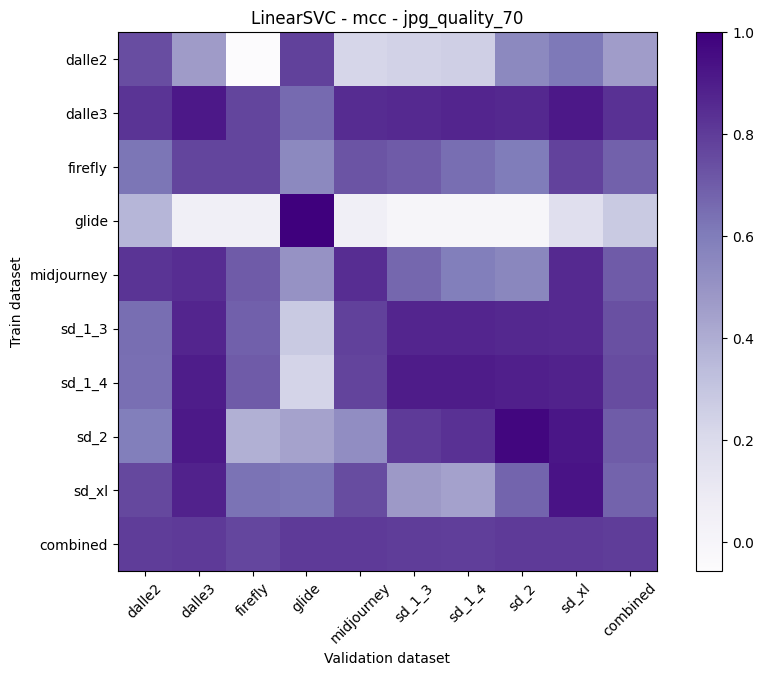

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.747294  0.465291 -0.057049  0.783344    0.227578  0.241956   
dalle3         0.824938  0.915852  0.770130  0.661165    0.850143  0.856534   
firefly        0.621388  0.771072  0.771072  0.549913    0.726109  0.704352   
glide          0.365624  0.054949  0.054949  1.000000    0.054949  0.000000   
midjourney     0.824143  0.845097  0.706126  0.506333    0.845097  0.669154   
sd_1_3         0.646299  0.870412  0.688093  0.278868    0.782184  0.870412   
sd_1_4         0.641431  0.897495  0.703974  0.234385    0.775269  0.904330   
sd_2           0.592872  0.913173  0.386203  0.438479    0.528688  0.804106   
sd_xl          0.760942  0.881322  0.628802  0.618172    0.749513  0.471495   
combined       0.797620  0.805125  0.768152  0.805125    0.805125  0.797620   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.255724  0.547405  0.614413  0.459828  
dalle3         0.869430  0.862963  0.915852  0.833975  
firefly        0.648386  0.601518  0.778770  0.683033  
glide          0.000000  0.000000  0.166954  0.278056  
midjourney     0.591969  0.557380  0.859308  0.705432  
sd_1_3         0.870412  0.863356  0.856348  0.738102  
sd_1_4         0.904330  0.890705  0.883961  0.750419  
sd_2           0.831846  0.975285  0.925298  0.701128  
sd_xl          0.445158  0.677232  0.933353  0.679048  
combined       0.790171  0.805125  0.805125  0.797620

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.747294  0.465291 -0.057049  0.783344    0.227578  0.241956   
dalle3         0.824938  0.915852  0.770130  0.661165    0.850143  0.856534   
firefly        0.621388  0.771072  0.771072  0.549913    0.726109  0.704352   
glide          0.365624  0.054949  0.054949  1.000000    0.054949  0.000000   
midjourney     0.824143  0.845097  0.706126  0.506333    0.845097  0.669154   
sd_1_3         0.646299  0.870412  0.688093  0.278868    0.782184  0.870412   
sd_1_4         0.641431  0.897495  0.703974  0.234385    0.775269  0.904330   
sd_2           0.592872  0.913173  0.386203  0.438479    0.528688  0.804106   
sd_xl          0.760942  0.881322  0.628802  0.618172    0.749513  0.471495   
combined       0.797620  0.805125  0.768152  0.805125    0.805125  0.797620   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.255724  0.547405  0.614413  0.425106  
dalle3         0.869430  0.862963  0.915852  0.836334  
firefly        0.648386  0.601518  0.778770  0.685842  
glide          0.000000  0.000000  0.166954  0.188603  
midjourney     0.591969  0.557380  0.859308  0.711623  
sd_1_3         0.870412  0.863356  0.856348  0.747376  
sd_1_4         0.904330  0.890705  0.883961  0.759542  
sd_2           0.831846  0.975285  0.925298  0.710661  
sd_xl          0.445158  0.677232  0.933353  0.685110  
combined       0.790171  0.805125  0.805125  0.797688









 ################ Evaluating models trained on standard and tested on jpg_quality_90. ################


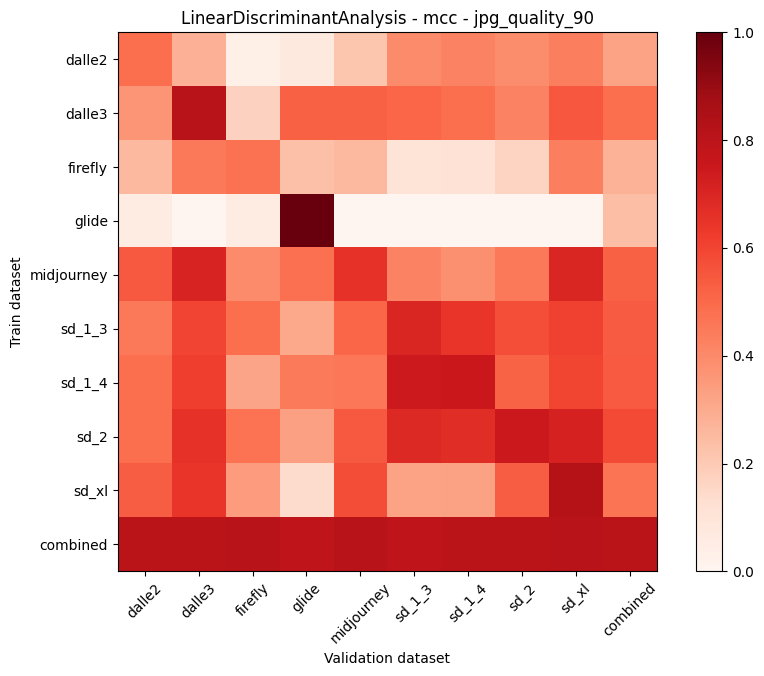

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.486066  0.277400  0.037365  0.072631    0.218026  0.397500   
dalle3         0.364975  0.815265  0.173630  0.520608    0.520608  0.509457   
firefly        0.256550  0.454203  0.474672  0.232157    0.256550  0.104683   
glide          0.054949  0.000000  0.054949  1.000000    0.000000  0.000000   
midjourney     0.544485  0.703750  0.397552  0.478951    0.657245  0.420670   
sd_1_3         0.452709  0.601349  0.486446  0.306093    0.507124  0.696973   
sd_1_4         0.482377  0.613552  0.317541  0.446492    0.458398  0.744395   
sd_2           0.482876  0.659191  0.470925  0.330336    0.543654  0.686322   
sd_xl          0.534255  0.643613  0.344226  0.140040    0.575968  0.321231   
combined       0.802984  0.802984  0.810451  0.788216    0.810451  0.788216   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.424018  0.386737  0.434493  0.322783  
dalle3         0.481681  0.420752  0.548627  0.482913  
firefly        0.110789  0.165458  0.434048  0.273571  
glide          0.000000  0.000000  0.000000  0.241943  
midjourney     0.380248  0.449699  0.696995  0.521759  
sd_1_3         0.647938  0.571465  0.608960  0.536848  
sd_1_4         0.751734  0.518841  0.594121  0.542165  
sd_2           0.672678  0.749885  0.714112  0.584659  
sd_xl          0.326991  0.534255  0.819192  0.466958  
combined       0.802984  0.802984  0.810451  0.802157

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.486066  0.277400  0.037365  0.072631    0.218026  0.397500   
dalle3         0.364975  0.815265  0.173630  0.520608    0.520608  0.509457   
firefly        0.256550  0.454203  0.474672  0.232157    0.256550  0.104683   
glide          0.054949  0.000000  0.054949  1.000000    0.000000  0.000000   
midjourney     0.544485  0.703750  0.397552  0.478951    0.657245  0.420670   
sd_1_3         0.452709  0.601349  0.486446  0.306093    0.507124  0.696973   
sd_1_4         0.482377  0.613552  0.317541  0.446492    0.458398  0.744395   
sd_2           0.482876  0.659191  0.470925  0.330336    0.543654  0.686322   
sd_xl          0.534255  0.643613  0.344226  0.140040    0.575968  0.321231   
combined       0.802984  0.802984  0.810451  0.788216    0.810451  0.788216   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.424018  0.386737  0.434493  0.303804  
dalle3         0.481681  0.420752  0.548627  0.483956  
firefly        0.110789  0.165458  0.434048  0.276568  
glide          0.000000  0.000000  0.000000  0.123322  
midjourney     0.380248  0.449699  0.696995  0.525510  
sd_1_3         0.647938  0.571465  0.608960  0.542117  
sd_1_4         0.751734  0.518841  0.594121  0.547495  
sd_2           0.672678  0.749885  0.714112  0.589998  
sd_xl          0.326991  0.534255  0.819192  0.471086  
combined       0.802984  0.802984  0.810451  0.802191

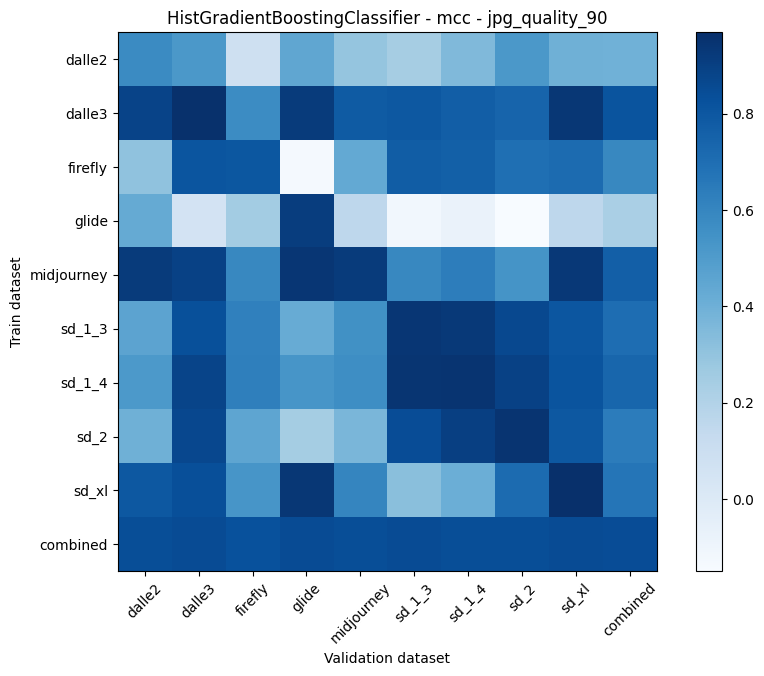

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.576069  0.514569  0.077832  0.447110    0.291856  0.239601   
dalle3         0.884306  0.962487  0.572212  0.919668    0.784270  0.795002   
firefly        0.305420  0.808340  0.802466 -0.135315    0.432880  0.773493   
glide          0.427081  0.052673  0.250105  0.910077    0.156936 -0.118569   
midjourney     0.919124  0.893718  0.591849  0.938596    0.919124  0.591849   
sd_1_3         0.457652  0.832685  0.623033  0.420843    0.550586  0.938596   
sd_1_4         0.512930  0.881405  0.625661  0.528258    0.564000  0.944591   
sd_2           0.396945  0.864300  0.449319  0.244324    0.369899  0.846726   
sd_xl          0.796994  0.836244  0.529456  0.937478    0.599241  0.324747   
combined       0.841094  0.848299  0.826836  0.848299    0.841094  0.848299   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.349420  0.514569  0.397005  0.395292  
dalle3         0.768324  0.742125  0.937800  0.813688  
firefly        0.762078  0.695382  0.711796  0.592008  
glide         -0.076539 -0.150194  0.156936  0.226249  
midjourney     0.633495  0.540298  0.932064  0.763964  
sd_1_3         0.925573  0.862786  0.803331  0.703862  
sd_1_4         0.951128  0.893743  0.815863  0.737111  
sd_2           0.900293  0.950256  0.795494  0.639830  
sd_xl          0.407311  0.711236  0.969195  0.671633  
combined       0.841094  0.841094  0.848299  0.842690

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.576069  0.514569  0.077832  0.447110    0.291856  0.239601   
dalle3         0.884306  0.962487  0.572212  0.919668    0.784270  0.795002   
firefly        0.305420  0.808340  0.802466 -0.135315    0.432880  0.773493   
glide          0.427081  0.052673  0.250105  0.910077    0.156936 -0.118569   
midjourney     0.919124  0.893718  0.591849  0.938596    0.919124  0.591849   
sd_1_3         0.457652  0.832685  0.623033  0.420843    0.550586  0.938596   
sd_1_4         0.512930  0.881405  0.625661  0.528258    0.564000  0.944591   
sd_2           0.396945  0.864300  0.449319  0.244324    0.369899  0.846726   
sd_xl          0.796994  0.836244  0.529456  0.937478    0.599241  0.324747   
combined       0.841094  0.848299  0.826836  0.848299    0.841094  0.848299   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.349420  0.514569  0.397005  0.378670  
dalle3         0.768324  0.742125  0.937800  0.818466  
firefly        0.762078  0.695382  0.711796  0.572949  
glide         -0.076539 -0.150194  0.156936  0.178723  
midjourney     0.633495  0.540298  0.932064  0.773346  
sd_1_3         0.925573  0.862786  0.803331  0.712787  
sd_1_4         0.951128  0.893743  0.815863  0.746398  
sd_2           0.900293  0.950256  0.795494  0.646395  
sd_xl          0.407311  0.711236  0.969195  0.679100  
combined       0.841094  0.841094  0.848299  0.842712

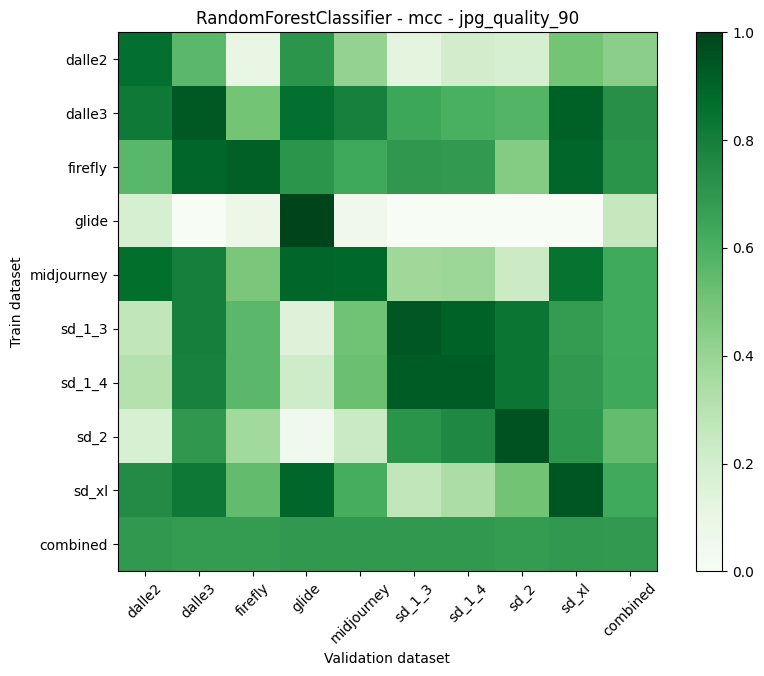

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.856993  0.561937  0.104414  0.709013    0.413972  0.127912   
dalle3         0.819273  0.937478  0.499462  0.859253    0.791484  0.644495   
firefly        0.565670  0.894211  0.912561  0.708892    0.636428  0.698386   
glide          0.185171  0.000000  0.077832  1.000000    0.054949  0.000000   
midjourney     0.865559  0.793745  0.484262  0.892919    0.886010  0.380367   
sd_1_3         0.271132  0.794126  0.562202  0.149051    0.511522  0.937742   
sd_1_4         0.309855  0.786043  0.560881  0.214858    0.519723  0.925573   
sd_2           0.176302  0.698278  0.369996  0.047928    0.236896  0.713719   
sd_xl          0.749769  0.822617  0.541940  0.893907    0.613056  0.271132   
combined       0.691963  0.683558  0.683558  0.691963    0.691963  0.691963   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.201753  0.185339  0.498867  0.433816  
dalle3         0.604244  0.574287  0.906715  0.731063  
firefly        0.687937  0.454464  0.894211  0.711235  
glide          0.000000  0.000000  0.000000  0.251142  
midjourney     0.385908  0.228494  0.845500  0.628651  
sd_1_3         0.906246  0.834199  0.680284  0.626715  
sd_1_4         0.925573  0.832685  0.691862  0.635825  
sd_2           0.760892  0.956248  0.703411  0.536374  
sd_xl          0.336848  0.501357  0.944159  0.625575  
combined       0.691963  0.683558  0.691963  0.689152

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.856993  0.561937  0.104414  0.709013    0.413972  0.127912   
dalle3         0.819273  0.937478  0.499462  0.859253    0.791484  0.644495   
firefly        0.565670  0.894211  0.912561  0.708892    0.636428  0.698386   
glide          0.185171  0.000000  0.077832  1.000000    0.054949  0.000000   
midjourney     0.865559  0.793745  0.484262  0.892919    0.886010  0.380367   
sd_1_3         0.271132  0.794126  0.562202  0.149051    0.511522  0.937742   
sd_1_4         0.309855  0.786043  0.560881  0.214858    0.519723  0.925573   
sd_2           0.176302  0.698278  0.369996  0.047928    0.236896  0.713719   
sd_xl          0.749769  0.822617  0.541940  0.893907    0.613056  0.271132   
combined       0.691963  0.683558  0.683558  0.691963    0.691963  0.691963   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.201753  0.185339  0.498867  0.406689  
dalle3         0.604244  0.574287  0.906715  0.737410  
firefly        0.687937  0.454464  0.894211  0.716973  
glide          0.000000  0.000000  0.000000  0.146439  
midjourney     0.385908  0.228494  0.845500  0.640307  
sd_1_3         0.906246  0.834199  0.680284  0.627389  
sd_1_4         0.925573  0.832685  0.691862  0.640784  
sd_2           0.760892  0.956248  0.703411  0.518185  
sd_xl          0.336848  0.501357  0.944159  0.630532  
combined       0.691963  0.683558  0.691963  0.689161

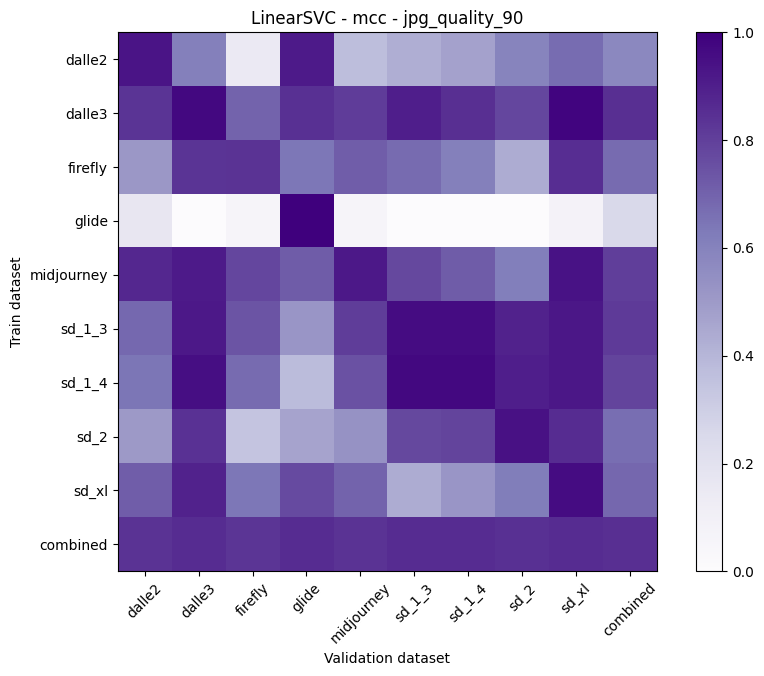

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.933519  0.609179  0.146769  0.910380    0.370943  0.427332   
dalle3         0.833268  0.968754  0.695985  0.844420    0.811262  0.901842   
firefly        0.510575  0.832439  0.839507  0.638510    0.712487  0.675015   
glide          0.166954  0.000000  0.054949  1.000000    0.054949  0.000000   
midjourney     0.874956  0.913051  0.779236  0.717303    0.919537  0.773493   
sd_1_3         0.680284  0.918730  0.738889  0.516598    0.805446  0.957117   
sd_1_4         0.644495  0.950045  0.675047  0.375206    0.748164  0.969195   
sd_2           0.501357  0.840032  0.342530  0.465571    0.531809  0.777326   
sd_xl          0.712008  0.887791  0.638714  0.766239    0.696079  0.434493   
combined       0.838065  0.859308  0.831081  0.859308    0.838065  0.859308   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.476290  0.590244  0.671317  0.574495  
dalle3         0.850035  0.778935  0.981410  0.848784  
firefly        0.608719  0.437401  0.853792  0.672279  
glide          0.000000  0.000000  0.077832  0.250385  
midjourney     0.717303  0.615279  0.939247  0.801164  
sd_1_3         0.957117  0.887791  0.925028  0.813684  
sd_1_4         0.969195  0.900668  0.925064  0.785387  
sd_2           0.788503  0.944159  0.857707  0.665187  
sd_xl          0.516598  0.618172  0.957117  0.686119  
combined       0.859308  0.845097  0.859308  0.849812

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.933519  0.609179  0.146769  0.910380    0.370943  0.427332   
dalle3         0.833268  0.968754  0.695985  0.844420    0.811262  0.901842   
firefly        0.510575  0.832439  0.839507  0.638510    0.712487  0.675015   
glide          0.166954  0.000000  0.054949  1.000000    0.054949  0.000000   
midjourney     0.874956  0.913051  0.779236  0.717303    0.919537  0.773493   
sd_1_3         0.680284  0.918730  0.738889  0.516598    0.805446  0.957117   
sd_1_4         0.644495  0.950045  0.675047  0.375206    0.748164  0.969195   
sd_2           0.501357  0.840032  0.342530  0.465571    0.531809  0.777326   
sd_xl          0.712008  0.887791  0.638714  0.766239    0.696079  0.434493   
combined       0.838065  0.859308  0.831081  0.859308    0.838065  0.859308   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.476290  0.590244  0.671317  0.570664  
dalle3         0.850035  0.778935  0.981410  0.851768  
firefly        0.608719  0.437401  0.853792  0.678716  
glide          0.000000  0.000000  0.077832  0.150520  
midjourney     0.717303  0.615279  0.939247  0.805489  
sd_1_3         0.957117  0.887791  0.925028  0.820778  
sd_1_4         0.969195  0.900668  0.925064  0.795231  
sd_2           0.788503  0.944159  0.857707  0.672110  
sd_xl          0.516598  0.618172  0.957117  0.691913  
combined       0.859308  0.845097  0.859308  0.849872









 ################ Evaluating models trained on standard and tested on jpg_quality_80. ################


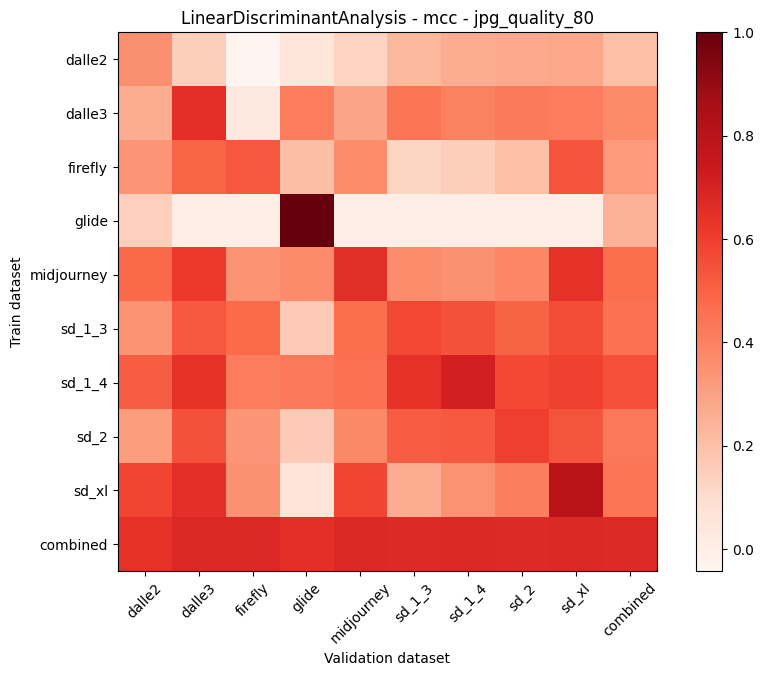

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.354779  0.151787 -0.042836  0.048518    0.128382  0.228967   
dalle3         0.258776  0.649846  0.030017  0.414204    0.288131  0.442693   
firefly        0.337477  0.492278  0.528655  0.206820    0.363245  0.127738   
glide          0.146769  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.481103  0.613725  0.340208  0.370216    0.656477  0.364195   
sd_1_3         0.341408  0.529541  0.470537  0.161464    0.462430  0.574463   
sd_1_4         0.512260  0.643679  0.414283  0.426303    0.456600  0.643679   
sd_2           0.313111  0.546867  0.339260  0.162649    0.379354  0.515739   
sd_xl          0.576474  0.649846  0.351542  0.059488    0.576474  0.258776   
combined       0.643314  0.676987  0.676987  0.651612    0.676987  0.668447   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.260842  0.273181  0.279273  0.200676  
dalle3         0.402824  0.425591  0.414204  0.372464  
firefly        0.152053  0.200719  0.543564  0.321908  
glide          0.000000  0.000000  0.000000  0.245808  
midjourney     0.352184  0.382289  0.642039  0.462203  
sd_1_3         0.547206  0.495320  0.556187  0.451736  
sd_1_4         0.707801  0.569831  0.589548  0.548249  
sd_2           0.523427  0.595617  0.538989  0.427717  
sd_xl          0.345823  0.408514  0.795888  0.445230  
combined       0.676987  0.668447  0.676987  0.668447

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.354779  0.151787 -0.042836  0.048518    0.128382  0.228967   
dalle3         0.258776  0.649846  0.030017  0.414204    0.288131  0.442693   
firefly        0.337477  0.492278  0.528655  0.206820    0.363245  0.127738   
glide          0.146769  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.481103  0.613725  0.340208  0.370216    0.656477  0.364195   
sd_1_3         0.341408  0.529541  0.470537  0.161464    0.462430  0.574463   
sd_1_4         0.512260  0.643679  0.414283  0.426303    0.456600  0.643679   
sd_2           0.313111  0.546867  0.339260  0.162649    0.379354  0.515739   
sd_xl          0.576474  0.649846  0.351542  0.059488    0.576474  0.258776   
combined       0.643314  0.676987  0.676987  0.651612    0.676987  0.668447   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.260842  0.273181  0.279273  0.186988  
dalle3         0.402824  0.425591  0.414204  0.369587  
firefly        0.152053  0.200719  0.543564  0.328061  
glide          0.000000  0.000000  0.000000  0.127419  
midjourney     0.352184  0.382289  0.642039  0.466937  
sd_1_3         0.547206  0.495320  0.556187  0.459840  
sd_1_4         0.707801  0.569831  0.589548  0.551554  
sd_2           0.523427  0.595617  0.538989  0.435002  
sd_xl          0.345823  0.408514  0.795888  0.446980  
combined       0.676987  0.668447  0.676987  0.668529

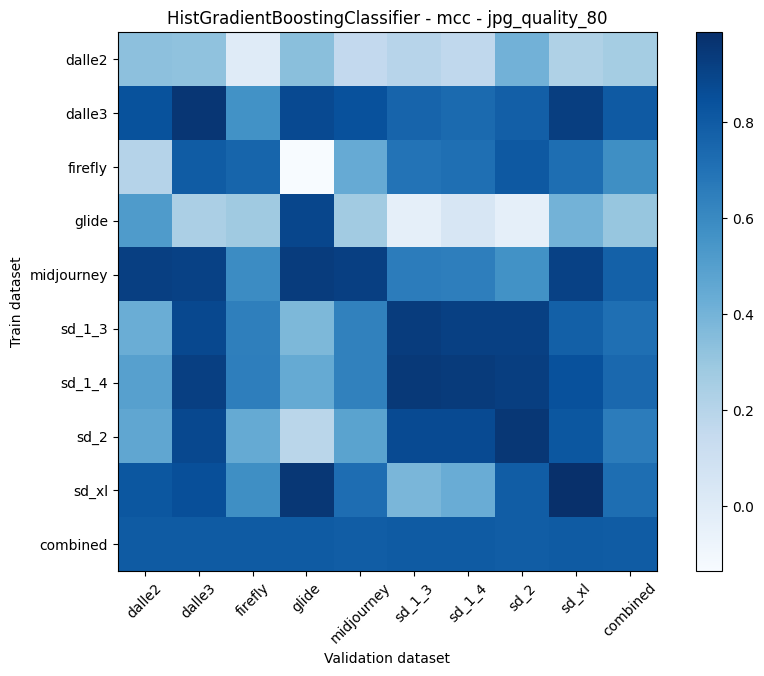

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.332791  0.321431  0.000000  0.338386    0.157153  0.193719   
dalle3         0.840032  0.957117  0.562202  0.875659    0.845894  0.760729   
firefly        0.203392  0.796619  0.756406 -0.135315    0.443444  0.695382   
glide          0.520354  0.238220  0.280547  0.887254    0.268633 -0.036615   
midjourney     0.919124  0.912714  0.591849  0.932064    0.919124  0.654543   
sd_1_3         0.429237  0.881322  0.644829  0.375190    0.634133  0.933353   
sd_1_4         0.493957  0.919124  0.649264  0.447198    0.633495  0.945171   
sd_2           0.464714  0.882149  0.444161  0.186982    0.480007  0.870218   
sd_xl          0.820343  0.852932  0.576090  0.956727    0.722041  0.384306   
combined       0.799818  0.799818  0.799818  0.799818    0.792275  0.799818   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.166954  0.407215  0.225154  0.260829  
dalle3         0.733477  0.782903  0.925028  0.804815  
firefly        0.711796  0.808340  0.717303  0.576953  
glide          0.046968 -0.036615  0.399918  0.305944  
midjourney     0.649264  0.566032  0.912714  0.775905  
sd_1_3         0.913533  0.913533  0.778267  0.712662  
sd_1_4         0.938596  0.925573  0.844631  0.744696  
sd_2           0.870218  0.956677  0.818004  0.658042  
sd_xl          0.430541  0.793812  0.987496  0.716479  
combined       0.799818  0.792275  0.799818  0.798137

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.332791  0.321431  0.000000  0.338386    0.157153  0.193719   
dalle3         0.840032  0.957117  0.562202  0.875659    0.845894  0.760729   
firefly        0.203392  0.796619  0.756406 -0.135315    0.443444  0.695382   
glide          0.520354  0.238220  0.280547  0.887254    0.268633 -0.036615   
midjourney     0.919124  0.912714  0.591849  0.932064    0.919124  0.654543   
sd_1_3         0.429237  0.881322  0.644829  0.375190    0.634133  0.933353   
sd_1_4         0.493957  0.919124  0.649264  0.447198    0.633495  0.945171   
sd_2           0.464714  0.882149  0.444161  0.186982    0.480007  0.870218   
sd_xl          0.820343  0.852932  0.576090  0.956727    0.722041  0.384306   
combined       0.799818  0.799818  0.799818  0.799818    0.792275  0.799818   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.166954  0.407215  0.225154  0.238089  
dalle3         0.733477  0.782903  0.925028  0.809227  
firefly        0.711796  0.808340  0.717303  0.555263  
glide          0.046968 -0.036615  0.399918  0.285407  
midjourney     0.649264  0.566032  0.912714  0.784159  
sd_1_3         0.913533  0.913533  0.778267  0.722600  
sd_1_4         0.938596  0.925573  0.844631  0.755223  
sd_2           0.870218  0.956677  0.818004  0.663681  
sd_xl          0.430541  0.793812  0.987496  0.724921  
combined       0.799818  0.792275  0.799818  0.798142

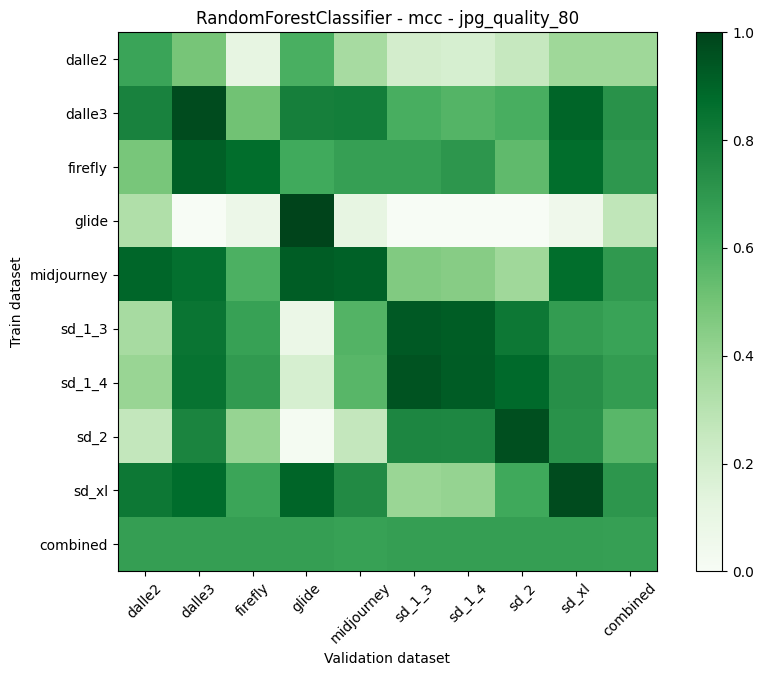

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.652068  0.490711  0.110419  0.604440    0.354865  0.201957   
dalle3         0.782331  0.975285  0.503914  0.793174    0.804106  0.607729   
firefly        0.485306  0.913051  0.868736  0.625806    0.668352  0.668352   
glide          0.327141  0.000000  0.077832  1.000000    0.110419  0.000000   
midjourney     0.894484  0.856199  0.594625  0.920802    0.907559  0.462972   
sd_1_3         0.354578  0.839271  0.662155  0.079491    0.579346  0.931641   
sd_1_4         0.398350  0.845196  0.688579  0.183700    0.569112  0.951128   
sd_2           0.264630  0.773620  0.402655  0.018563    0.258030  0.768324   
sd_xl          0.827730  0.872767  0.645913  0.895965    0.752551  0.392122   
combined       0.672013  0.672013  0.672013  0.672013    0.663426  0.672013   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.185171  0.253402  0.381468  0.380887  
dalle3         0.578048  0.607729  0.895240  0.721201  
firefly        0.706307  0.547534  0.868736  0.700229  
glide          0.000000  0.000000  0.054949  0.269542  
midjourney     0.447081  0.376972  0.868811  0.692012  
sd_1_3         0.918855  0.827510  0.683267  0.653418  
sd_1_4         0.925228  0.881405  0.731648  0.680322  
sd_2           0.763048  0.962487  0.721470  0.564612  
sd_xl          0.407881  0.631074  0.975062  0.703877  
combined       0.672013  0.672013  0.672013  0.671054

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.652068  0.490711  0.110419  0.604440    0.354865  0.201957   
dalle3         0.782331  0.975285  0.503914  0.793174    0.804106  0.607729   
firefly        0.485306  0.913051  0.868736  0.625806    0.668352  0.668352   
glide          0.327141  0.000000  0.077832  1.000000    0.110419  0.000000   
midjourney     0.894484  0.856199  0.594625  0.920802    0.907559  0.462972   
sd_1_3         0.354578  0.839271  0.662155  0.079491    0.579346  0.931641   
sd_1_4         0.398350  0.845196  0.688579  0.183700    0.569112  0.951128   
sd_2           0.264630  0.773620  0.402655  0.018563    0.258030  0.768324   
sd_xl          0.827730  0.872767  0.645913  0.895965    0.752551  0.392122   
combined       0.672013  0.672013  0.672013  0.672013    0.663426  0.672013   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.185171  0.253402  0.381468  0.359389  
dalle3         0.578048  0.607729  0.895240  0.727506  
firefly        0.706307  0.547534  0.868736  0.705798  
glide          0.000000  0.000000  0.054949  0.174482  
midjourney     0.447081  0.376972  0.868811  0.703278  
sd_1_3         0.918855  0.827510  0.683267  0.652902  
sd_1_4         0.925228  0.881405  0.731648  0.686039  
sd_2           0.763048  0.962487  0.721470  0.548092  
sd_xl          0.407881  0.631074  0.975062  0.711229  
combined       0.672013  0.672013  0.672013  0.671058

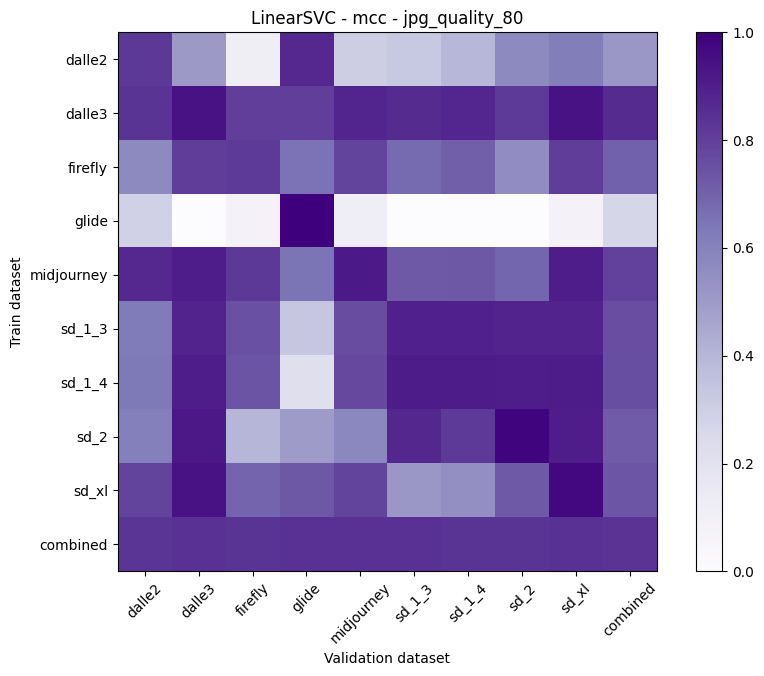

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.817073  0.500278  0.110419  0.871042    0.303909  0.327141   
dalle3         0.832685  0.945171  0.803331  0.803331    0.881239  0.862786   
firefly        0.569129  0.808367  0.815796  0.650364    0.786404  0.676339   
glide          0.291856  0.000000  0.077832  1.000000    0.123648  0.000000   
midjourney     0.869430  0.902374  0.818724  0.644590    0.915852  0.723291   
sd_1_3         0.627397  0.886010  0.750264  0.335481    0.762532  0.892919   
sd_1_4         0.631892  0.903279  0.739856  0.211829    0.769595  0.910077   
sd_2           0.610351  0.920262  0.398415  0.493976    0.576441  0.873895   
sd_xl          0.787742  0.943755  0.693158  0.729294    0.787742  0.513839   
combined       0.828396  0.842828  0.835586  0.842828    0.842828  0.842828   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.391857  0.566625  0.618670  0.512456  
dalle3         0.875054  0.814988  0.945171  0.861431  
firefly        0.709596  0.550952  0.808367  0.704361  
glide          0.000000  0.000000  0.077832  0.266661  
midjourney     0.729062  0.689119  0.902374  0.795536  
sd_1_3         0.892919  0.886010  0.886010  0.759795  
sd_1_4         0.910077  0.903279  0.910077  0.756295  
sd_2           0.813057  0.981260  0.902642  0.720807  
sd_xl          0.543506  0.724087  0.968899  0.737426  
combined       0.835586  0.835586  0.842828  0.838798

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.817073  0.500278  0.110419  0.871042    0.303909  0.327141   
dalle3         0.832685  0.945171  0.803331  0.803331    0.881239  0.862786   
firefly        0.569129  0.808367  0.815796  0.650364    0.786404  0.676339   
glide          0.291856  0.000000  0.077832  1.000000    0.123648  0.000000   
midjourney     0.869430  0.902374  0.818724  0.644590    0.915852  0.723291   
sd_1_3         0.627397  0.886010  0.750264  0.335481    0.762532  0.892919   
sd_1_4         0.631892  0.903279  0.739856  0.211829    0.769595  0.910077   
sd_2           0.610351  0.920262  0.398415  0.493976    0.576441  0.873895   
sd_xl          0.787742  0.943755  0.693158  0.729294    0.787742  0.513839   
combined       0.828396  0.842828  0.835586  0.842828    0.842828  0.842828   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.391857  0.566625  0.618670  0.500779  
dalle3         0.875054  0.814988  0.945171  0.862640  
firefly        0.709596  0.550952  0.808367  0.708368  
glide          0.000000  0.000000  0.077832  0.174574  
midjourney     0.729062  0.689119  0.902374  0.799424  
sd_1_3         0.892919  0.886010  0.886010  0.768838  
sd_1_4         0.910077  0.903279  0.910077  0.765551  
sd_2           0.813057  0.981260  0.902642  0.730033  
sd_xl          0.543506  0.724087  0.968899  0.743558  
combined       0.835586  0.835586  0.842828  0.838810









 ################ Evaluating models trained on standard and tested on jpg_quality_95. ################


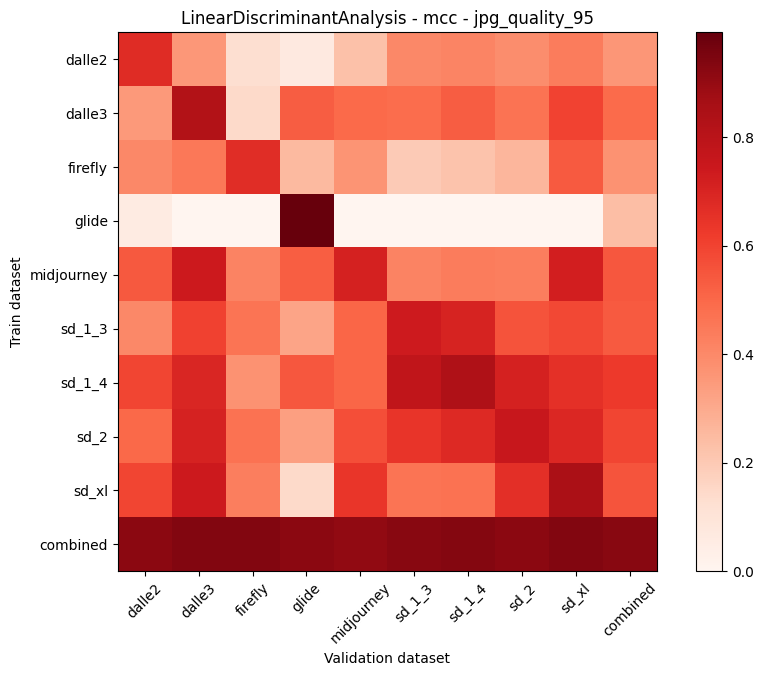

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.672685  0.354578  0.126928  0.069020    0.226599  0.403710   
dalle3         0.351488  0.823005  0.144937  0.530306    0.496663  0.485501   
firefly        0.403606  0.451332  0.669047  0.250719    0.368210  0.197009   
glide          0.054949  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.542659  0.739127  0.417226  0.525305    0.713023  0.417226   
sd_1_3         0.401275  0.604601  0.462311  0.317765    0.506156  0.734612   
sd_1_4         0.591969  0.693692  0.371964  0.545961    0.506333  0.776799   
sd_2           0.499115  0.708048  0.470160  0.332744    0.569954  0.643613   
sd_xl          0.592272  0.737761  0.432897  0.146478    0.637518  0.465696   
combined       0.919537  0.939247  0.939247  0.919537    0.906606  0.926064   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.414367  0.387564  0.440703  0.359532  
dalle3         0.530306  0.468790  0.598731  0.491079  
firefly        0.221009  0.262534  0.537288  0.370824  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.439829  0.434176  0.719496  0.545886  
sd_1_3         0.704293  0.557779  0.584324  0.536049  
sd_1_4         0.831081  0.712387  0.657040  0.627158  
sd_2           0.681884  0.755280  0.688373  0.590082  
sd_xl          0.471156  0.660540  0.846265  0.552746  
combined       0.932634  0.919537  0.939247  0.926792

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.672685  0.354578  0.126928  0.069020    0.226599  0.403710   
dalle3         0.351488  0.823005  0.144937  0.530306    0.496663  0.485501   
firefly        0.403606  0.451332  0.669047  0.250719    0.368210  0.197009   
glide          0.054949  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.542659  0.739127  0.417226  0.525305    0.713023  0.417226   
sd_1_3         0.401275  0.604601  0.462311  0.317765    0.506156  0.734612   
sd_1_4         0.591969  0.693692  0.371964  0.545961    0.506333  0.776799   
sd_2           0.499115  0.708048  0.470160  0.332744    0.569954  0.643613   
sd_xl          0.592272  0.737761  0.432897  0.146478    0.637518  0.465696   
combined       0.919537  0.939247  0.939247  0.919537    0.906606  0.926064   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.414367  0.387564  0.440703  0.344017  
dalle3         0.530306  0.468790  0.598731  0.492192  
firefly        0.221009  0.262534  0.537288  0.373417  
glide          0.000000  0.000000  0.000000  0.116524  
midjourney     0.439829  0.434176  0.719496  0.549785  
sd_1_3         0.704293  0.557779  0.584324  0.541457  
sd_1_4         0.831081  0.712387  0.657040  0.631914  
sd_2           0.681884  0.755280  0.688373  0.594352  
sd_xl          0.471156  0.660540  0.846265  0.554509  
combined       0.932634  0.919537  0.939247  0.926851

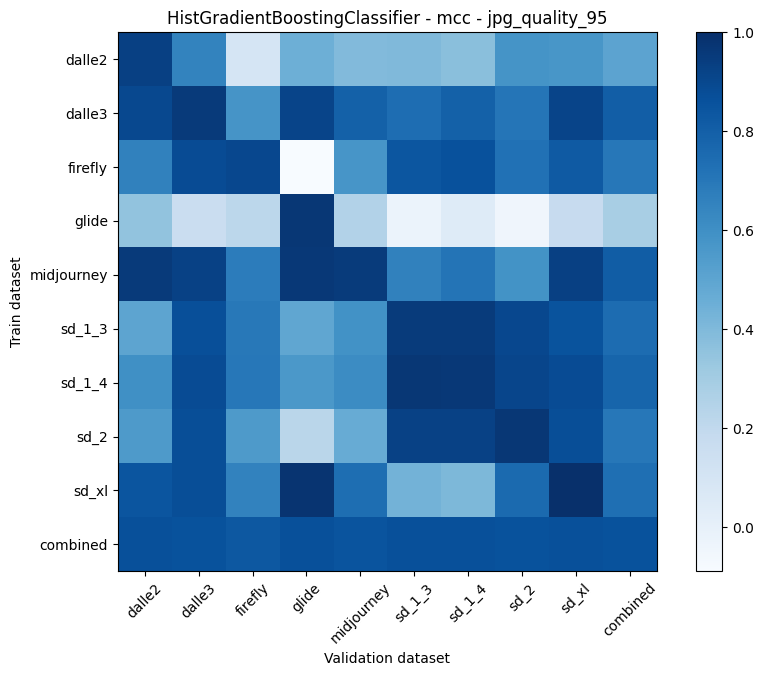

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.927686  0.647276  0.095474  0.447110    0.391857  0.397005   
dalle3         0.893907  0.957117  0.577415  0.912469    0.794126  0.744319   
firefly        0.656909  0.881405  0.899965 -0.089315    0.574227  0.839271   
glide          0.353180  0.160792  0.215762  0.969195    0.250504 -0.022095   
midjourney     0.956677  0.924974  0.677543  0.963139    0.950256  0.656900   
sd_1_3         0.501357  0.869643  0.696079  0.491170    0.587573  0.950617   
sd_1_4         0.599241  0.882729  0.700828  0.559344    0.614266  0.969195   
sd_2           0.552268  0.873895  0.552268  0.224707    0.464424  0.926201   
sd_xl          0.843755  0.876577  0.652068  0.981423    0.740065  0.432305   
combined       0.864848  0.857755  0.829863  0.864848    0.850710  0.864848   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.370943  0.580792  0.566625  0.502399  
dalle3         0.794126  0.706683  0.912469  0.805446  
firefly        0.863155  0.726204  0.821672  0.698654  
glide          0.043637 -0.043042  0.177459  0.282015  
midjourney     0.714168  0.585791  0.931236  0.809829  
sd_1_3         0.950617  0.900059  0.851785  0.746134  
sd_1_4         0.962771  0.906715  0.882729  0.778107  
sd_2           0.926201  0.968762  0.873895  0.699519  
sd_xl          0.407215  0.755147  1.000000  0.733961  
combined       0.864848  0.857755  0.864848  0.857755

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.927686  0.647276  0.095474  0.447110    0.391857  0.397005   
dalle3         0.893907  0.957117  0.577415  0.912469    0.794126  0.744319   
firefly        0.656909  0.881405  0.899965 -0.089315    0.574227  0.839271   
glide          0.353180  0.160792  0.215762  0.969195    0.250504 -0.022095   
midjourney     0.956677  0.924974  0.677543  0.963139    0.950256  0.656900   
sd_1_3         0.501357  0.869643  0.696079  0.491170    0.587573  0.950617   
sd_1_4         0.599241  0.882729  0.700828  0.559344    0.614266  0.969195   
sd_2           0.552268  0.873895  0.552268  0.224707    0.464424  0.926201   
sd_xl          0.843755  0.876577  0.652068  0.981423    0.740065  0.432305   
combined       0.864848  0.857755  0.829863  0.864848    0.850710  0.864848   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.370943  0.580792  0.566625  0.491641  
dalle3         0.794126  0.706683  0.912469  0.810292  
firefly        0.863155  0.726204  0.821672  0.685944  
glide          0.043637 -0.043042  0.177459  0.233933  
midjourney     0.714168  0.585791  0.931236  0.817854  
sd_1_3         0.950617  0.900059  0.851785  0.755433  
sd_1_4         0.962771  0.906715  0.882729  0.786424  
sd_2           0.926201  0.968762  0.873895  0.706958  
sd_xl          0.407215  0.755147  1.000000  0.743173  
combined       0.864848  0.857755  0.864848  0.857814

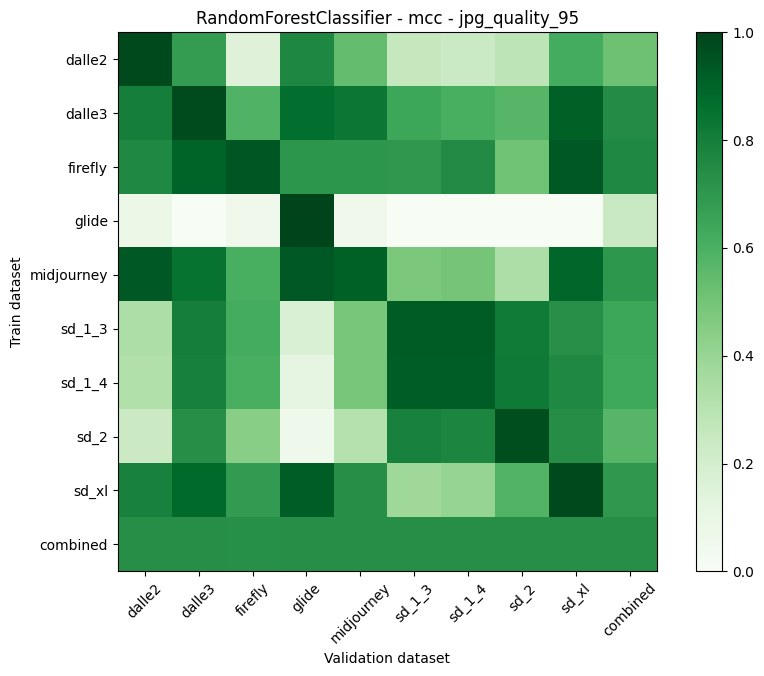

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981265  0.682347  0.150860  0.762638    0.537833  0.255724   
dalle3         0.798629  0.975285  0.587928  0.860230    0.831846  0.642597   
firefly        0.760892  0.901184  0.943755  0.703411    0.703411  0.698278   
glide          0.077832  0.000000  0.054949  1.000000    0.054949  0.000000   
midjourney     0.932064  0.844631  0.607407  0.932064    0.906344  0.478442   
sd_1_3         0.331946  0.798593  0.620487  0.168355    0.487307  0.925228   
sd_1_4         0.318806  0.789944  0.607582  0.115247    0.487212  0.920096   
sd_2           0.231991  0.734382  0.439429  0.061298    0.309854  0.786348   
sd_xl          0.786348  0.879586  0.683979  0.920262    0.734382  0.377267   
combined       0.737447  0.737447  0.729428  0.737447    0.737447  0.737447   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.234850  0.281786  0.619220  0.513302  
dalle3         0.607729  0.573111  0.913173  0.747942  
firefly        0.750288  0.508879  0.931414  0.761483  
glide          0.000000  0.000000  0.000000  0.243495  
midjourney     0.493957  0.333060  0.893718  0.702658  
sd_1_3         0.925228  0.815863  0.731648  0.641817  
sd_1_4         0.920096  0.819619  0.760942  0.634726  
sd_2           0.770567  0.968762  0.739501  0.573754  
sd_xl          0.403627  0.581277  0.981260  0.697848  
combined       0.737447  0.737447  0.737447  0.736552

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.981265  0.682347  0.150860  0.762638    0.537833  0.255724   
dalle3         0.798629  0.975285  0.587928  0.860230    0.831846  0.642597   
firefly        0.760892  0.901184  0.943755  0.703411    0.703411  0.698278   
glide          0.077832  0.000000  0.054949  1.000000    0.054949  0.000000   
midjourney     0.932064  0.844631  0.607407  0.932064    0.906344  0.478442   
sd_1_3         0.331946  0.798593  0.620487  0.168355    0.487307  0.925228   
sd_1_4         0.318806  0.789944  0.607582  0.115247    0.487212  0.920096   
sd_2           0.231991  0.734382  0.439429  0.061298    0.309854  0.786348   
sd_xl          0.786348  0.879586  0.683979  0.920262    0.734382  0.377267   
combined       0.737447  0.737447  0.729428  0.737447    0.737447  0.737447   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.234850  0.281786  0.619220  0.500725  
dalle3         0.607729  0.573111  0.913173  0.754503  
firefly        0.750288  0.508879  0.931414  0.766835  
glide          0.000000  0.000000  0.000000  0.131970  
midjourney     0.493957  0.333060  0.893718  0.713521  
sd_1_3         0.925228  0.815863  0.731648  0.644962  
sd_1_4         0.920096  0.819619  0.760942  0.637727  
sd_2           0.770567  0.968762  0.739501  0.560237  
sd_xl          0.403627  0.581277  0.981260  0.705332  
combined       0.737447  0.737447  0.737447  0.736556

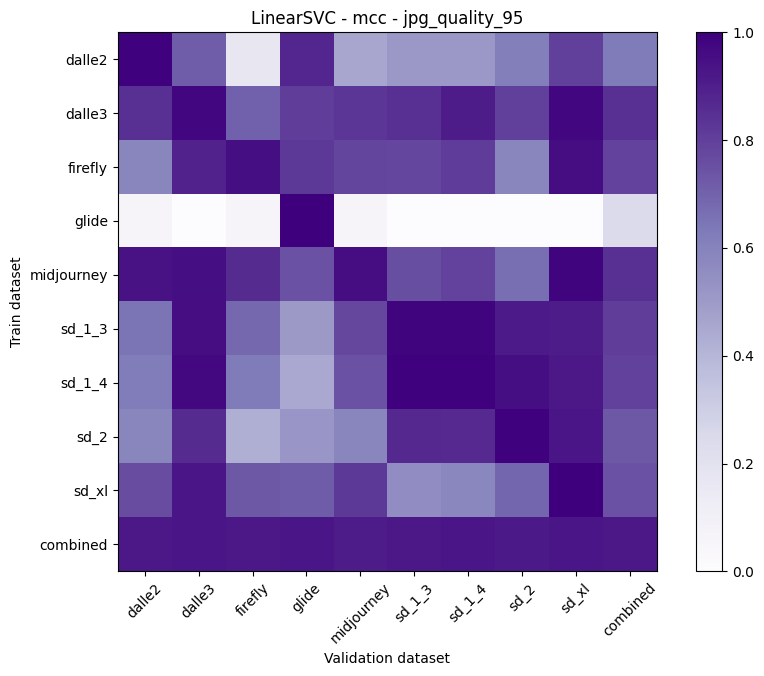

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993766  0.712041  0.170293  0.875165    0.455445  0.509021   
dalle3         0.844420  0.975062  0.706137  0.805820    0.827730  0.844420   
firefly        0.585791  0.888164  0.950256  0.818004    0.784383  0.778862   
glide          0.054949  0.000000  0.054949  1.000000    0.054949  0.000000   
midjourney     0.937800  0.950068  0.861345  0.747329    0.956258  0.757791   
sd_1_3         0.645913  0.956258  0.680850  0.503663    0.773620  0.981410   
sd_1_4         0.624033  0.968920  0.628851  0.445536    0.747294  0.993766   
sd_2           0.585517  0.860051  0.427332  0.519320    0.585517  0.871042   
sd_xl          0.765283  0.927686  0.730087  0.715228    0.817073  0.552457   
combined       0.920802  0.927489  0.920802  0.927489    0.907559  0.920802   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.509021  0.614413  0.799076  0.626173  
dalle3         0.907751  0.800400  0.975062  0.851286  
firefly        0.812339  0.585791  0.956677  0.789927  
glide          0.000000  0.000000  0.000000  0.242720  
midjourney     0.789625  0.665817  0.981410  0.845042  
sd_1_3         0.981410  0.913693  0.907751  0.807027  
sd_1_4         0.993766  0.950686  0.921001  0.796734  
sd_2           0.865533  0.993768  0.927686  0.727878  
sd_xl          0.580792  0.690720  1.000000  0.747309  
combined       0.927489  0.914159  0.927489  0.921543

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993766  0.712041  0.170293  0.875165    0.455445  0.509021   
dalle3         0.844420  0.975062  0.706137  0.805820    0.827730  0.844420   
firefly        0.585791  0.888164  0.950256  0.818004    0.784383  0.778862   
glide          0.054949  0.000000  0.054949  1.000000    0.054949  0.000000   
midjourney     0.937800  0.950068  0.861345  0.747329    0.956258  0.757791   
sd_1_3         0.645913  0.956258  0.680850  0.503663    0.773620  0.981410   
sd_1_4         0.624033  0.968920  0.628851  0.445536    0.747294  0.993766   
sd_2           0.585517  0.860051  0.427332  0.519320    0.585517  0.871042   
sd_xl          0.765283  0.927686  0.730087  0.715228    0.817073  0.552457   
combined       0.920802  0.927489  0.920802  0.927489    0.907559  0.920802   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.509021  0.614413  0.799076  0.626471  
dalle3         0.907751  0.800400  0.975062  0.854089  
firefly        0.812339  0.585791  0.956677  0.795585  
glide          0.000000  0.000000  0.000000  0.129427  
midjourney     0.789625  0.665817  0.981410  0.849716  
sd_1_3         0.981410  0.913693  0.907751  0.816063  
sd_1_4         0.993766  0.950686  0.921001  0.808206  
sd_2           0.865533  0.993768  0.927686  0.737307  
sd_xl          0.580792  0.690720  1.000000  0.753259  
combined       0.927489  0.914159  0.927489  0.921565









 ################ Evaluating models trained on standard and tested on standard. ################


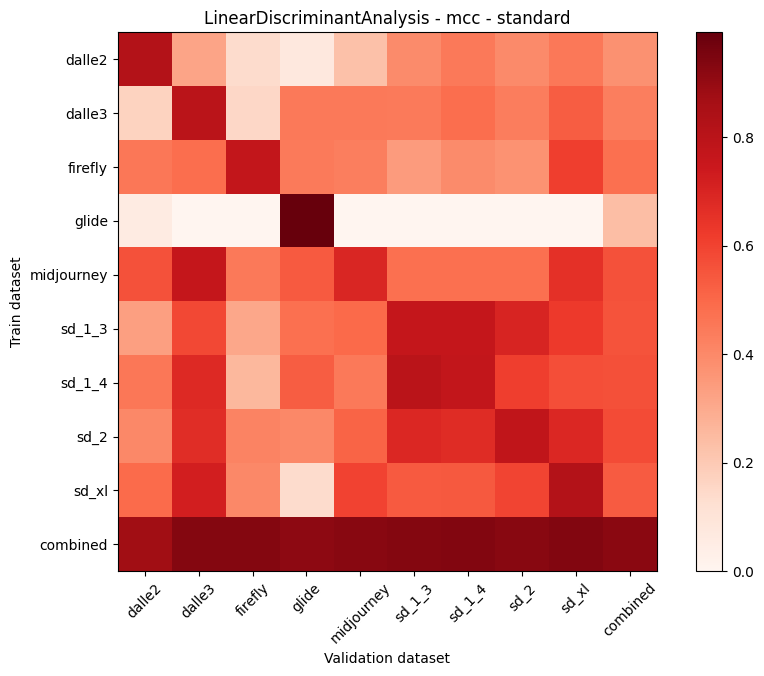

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.819192  0.314882  0.136325  0.077097    0.228967  0.393389   
dalle3         0.167182  0.795888  0.154417  0.448403    0.448403  0.442693   
firefly        0.455899  0.483869  0.770198  0.444730    0.433563  0.343691   
glide          0.054949  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.561035  0.764972  0.447007  0.537907    0.693657  0.475220   
sd_1_3         0.332120  0.583665  0.309123  0.473828    0.496616  0.765826   
sd_1_4         0.457664  0.681657  0.258750  0.530306    0.446543  0.796004   
sd_2           0.401973  0.668685  0.418861  0.401973    0.509273  0.687371   
sd_xl          0.490907  0.719496  0.400277  0.137974    0.601502  0.536861   
combined       0.874956  0.932634  0.932634  0.913051    0.926064  0.932634   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.447081  0.398824  0.452386  0.374524  
dalle3         0.482794  0.436989  0.529181  0.432555  
firefly        0.394429  0.371964  0.609480  0.476401  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.475220  0.475220  0.656365  0.562327  
sd_1_3         0.765826  0.700177  0.625571  0.556241  
sd_1_4         0.769646  0.610338  0.569991  0.564919  
sd_2           0.674886  0.778417  0.687371  0.576586  
sd_xl          0.542659  0.595537  0.821256  0.534932  
combined       0.939247  0.926064  0.939247  0.923884

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.819192  0.314882  0.136325  0.077097    0.228967  0.393389   
dalle3         0.167182  0.795888  0.154417  0.448403    0.448403  0.442693   
firefly        0.455899  0.483869  0.770198  0.444730    0.433563  0.343691   
glide          0.054949  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.561035  0.764972  0.447007  0.537907    0.693657  0.475220   
sd_1_3         0.332120  0.583665  0.309123  0.473828    0.496616  0.765826   
sd_1_4         0.457664  0.681657  0.258750  0.530306    0.446543  0.796004   
sd_2           0.401973  0.668685  0.418861  0.401973    0.509273  0.687371   
sd_xl          0.490907  0.719496  0.400277  0.137974    0.601502  0.536861   
combined       0.874956  0.932634  0.932634  0.913051    0.926064  0.932634   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.447081  0.398824  0.452386  0.363127  
dalle3         0.482794  0.436989  0.529181  0.433994  
firefly        0.394429  0.371964  0.609480  0.478647  
glide          0.000000  0.000000  0.000000  0.116524  
midjourney     0.475220  0.475220  0.656365  0.565178  
sd_1_3         0.765826  0.700177  0.625571  0.561417  
sd_1_4         0.769646  0.610338  0.569991  0.568989  
sd_2           0.674886  0.778417  0.687371  0.580979  
sd_xl          0.542659  0.595537  0.821256  0.538497  
combined       0.939247  0.926064  0.939247  0.924059

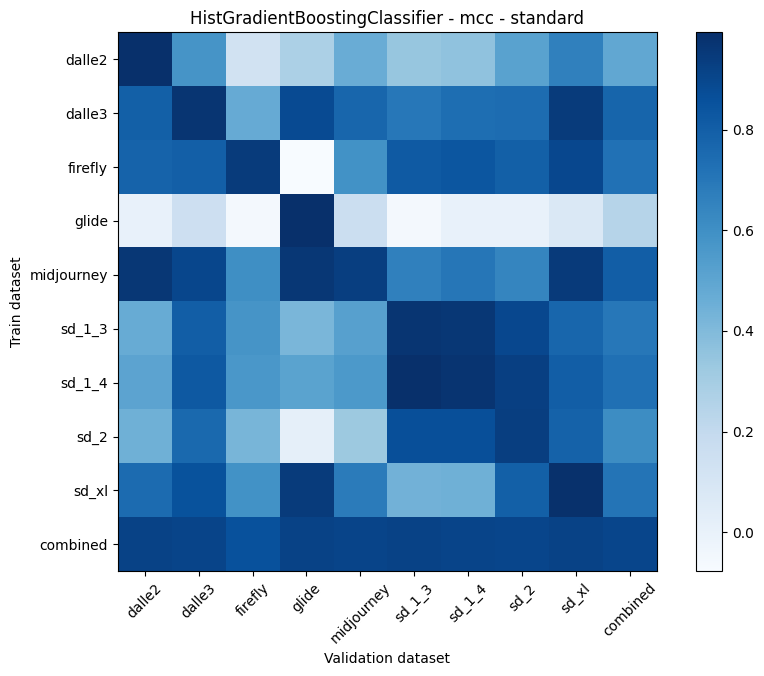

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993766  0.576090  0.129144  0.275433    0.465291  0.340942   
dalle3         0.793174  0.968899  0.473955  0.883448    0.771571  0.698278   
firefly        0.782331  0.798629  0.943755 -0.077969    0.587928  0.820677   
glide         -0.001487  0.150860 -0.057049  0.993766    0.160815 -0.057049   
midjourney     0.963139  0.900293  0.600920  0.963139    0.931236  0.662044   
sd_1_3         0.469378  0.802309  0.576441  0.419107    0.523209  0.968762   
sd_1_4         0.504199  0.825715  0.566530  0.509021    0.556970  0.993766   
sd_2           0.448688  0.755581  0.423032  0.015715    0.325078  0.865990   
sd_xl          0.747294  0.852932  0.590440  0.944680    0.682347  0.440556   
combined       0.915852  0.909091  0.856534  0.915852    0.909091  0.915852   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.357520  0.513836  0.662773  0.488606  
dalle3         0.734517  0.745014  0.943755  0.773359  
firefly        0.837469  0.793174  0.895240  0.725242  
glide         -0.001487 -0.001487  0.073243  0.243514  
midjourney     0.703631  0.641532  0.950256  0.804825  
sd_1_3         0.962571  0.896833  0.770567  0.700633  
sd_1_4         0.975073  0.926871  0.804360  0.729857  
sd_2           0.865990  0.931414  0.787742  0.611588  
sd_xl          0.445536  0.793812  0.987496  0.712595  
combined       0.909091  0.902374  0.915852  0.905354

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993766  0.576090  0.129144  0.275433    0.465291  0.340942   
dalle3         0.793174  0.968899  0.473955  0.883448    0.771571  0.698278   
firefly        0.782331  0.798629  0.943755 -0.077969    0.587928  0.820677   
glide         -0.001487  0.150860 -0.057049  0.993766    0.160815 -0.057049   
midjourney     0.963139  0.900293  0.600920  0.963139    0.931236  0.662044   
sd_1_3         0.469378  0.802309  0.576441  0.419107    0.523209  0.968762   
sd_1_4         0.504199  0.825715  0.566530  0.509021    0.556970  0.993766   
sd_2           0.448688  0.755581  0.423032  0.015715    0.325078  0.865990   
sd_xl          0.747294  0.852932  0.590440  0.944680    0.682347  0.440556   
combined       0.915852  0.909091  0.856534  0.915852    0.909091  0.915852   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.357520  0.513836  0.662773  0.479422  
dalle3         0.734517  0.745014  0.943755  0.779179  
firefly        0.837469  0.793174  0.895240  0.709026  
glide         -0.001487 -0.001487  0.073243  0.140014  
midjourney     0.703631  0.641532  0.950256  0.812910  
sd_1_3         0.962571  0.896833  0.770567  0.709909  
sd_1_4         0.975073  0.926871  0.804360  0.740278  
sd_2           0.865990  0.931414  0.787742  0.602137  
sd_xl          0.445536  0.793812  0.987496  0.720566  
combined       0.909091  0.902374  0.915852  0.905510

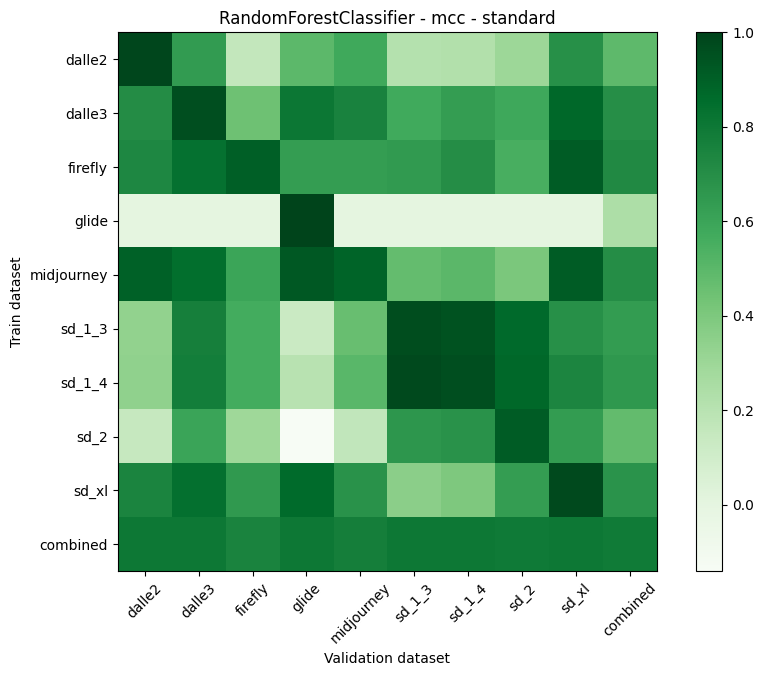

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.643343  0.160815  0.494531    0.580872  0.212470   
dalle3         0.706137  0.962487  0.443828  0.805820    0.752551  0.572212   
firefly        0.731648  0.833376  0.906224  0.630844    0.630844  0.646451   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.893743  0.845196  0.594728  0.925228    0.887556  0.471859   
sd_1_3         0.333140  0.765346  0.566771  0.127912    0.464424  0.968762   
sd_1_4         0.338817  0.775808  0.566771  0.201753    0.503749  0.981260   
sd_2           0.145945  0.600920  0.295217 -0.140849    0.162983  0.662044   
sd_xl          0.742125  0.838831  0.650876  0.861345    0.680850  0.354237   
combined       0.799818  0.799818  0.748173  0.799818    0.769983  0.799818   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.220124  0.300297  0.692198  0.490762  
dalle3         0.631074  0.581988  0.872767  0.697673  
firefly        0.704606  0.553784  0.912520  0.723188  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.497571  0.403710  0.912520  0.704606  
sd_1_3         0.950303  0.862600  0.688961  0.637418  
sd_1_4         0.962571  0.873895  0.739501  0.656491  
sd_2           0.682733  0.912561  0.636428  0.477747  
sd_xl          0.397402  0.631074  0.981410  0.676385  
combined       0.799818  0.792275  0.799818  0.789773

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.643343  0.160815  0.494531    0.580872  0.212470   
dalle3         0.706137  0.962487  0.443828  0.805820    0.752551  0.572212   
firefly        0.731648  0.833376  0.906224  0.630844    0.630844  0.646451   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.893743  0.845196  0.594728  0.925228    0.887556  0.471859   
sd_1_3         0.333140  0.765346  0.566771  0.127912    0.464424  0.968762   
sd_1_4         0.338817  0.775808  0.566771  0.201753    0.503749  0.981260   
sd_2           0.145945  0.600920  0.295217 -0.140849    0.162983  0.662044   
sd_xl          0.742125  0.838831  0.650876  0.861345    0.680850  0.354237   
combined       0.799818  0.799818  0.748173  0.799818    0.769983  0.799818   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.220124  0.300297  0.692198  0.476905  
dalle3         0.631074  0.581988  0.872767  0.703207  
firefly        0.704606  0.553784  0.912520  0.727811  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.497571  0.403710  0.912520  0.714679  
sd_1_3         0.950303  0.862600  0.688961  0.636469  
sd_1_4         0.962571  0.873895  0.739501  0.660458  
sd_2           0.682733  0.912561  0.636428  0.439776  
sd_xl          0.397402  0.631074  0.981410  0.682016  
combined       0.799818  0.792275  0.799818  0.789927

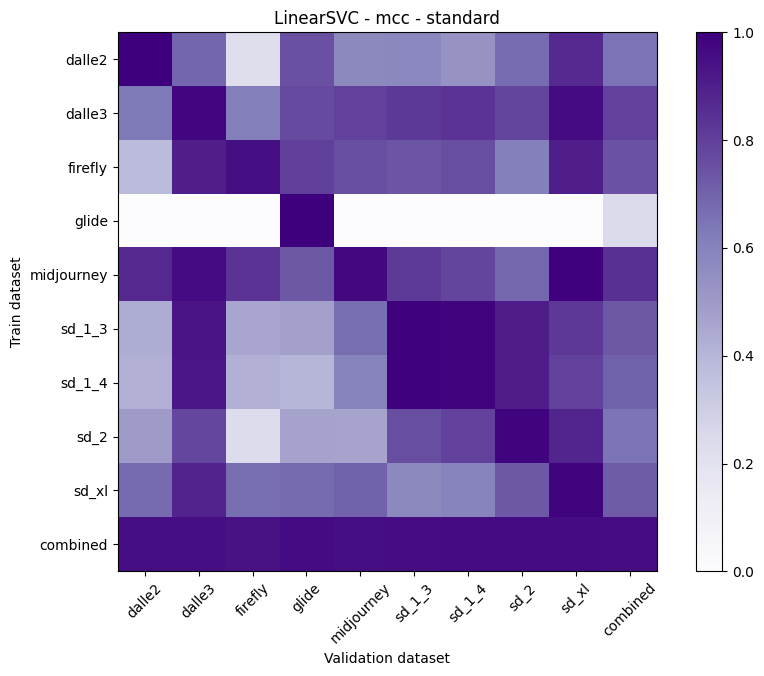

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.690720  0.225154  0.750104    0.571347  0.576069   
dalle3         0.631074  0.975062  0.616296  0.768324    0.795002  0.816728   
firefly        0.375431  0.901184  0.949982  0.798629    0.755581  0.734517   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.869566  0.962805  0.836529  0.727062    0.968920  0.814993   
sd_1_3         0.435558  0.932773  0.455445  0.479961    0.667652  0.993766   
sd_1_4         0.420443  0.926871  0.420443  0.399961    0.595228  0.993766   
sd_2           0.494531  0.778140  0.234850  0.470194    0.465291  0.757507   
sd_xl          0.679008  0.885305  0.664157  0.674047    0.703981  0.571606   
combined       0.950256  0.950256  0.943877  0.963139    0.950256  0.956677   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.528806  0.671317  0.865533  0.651002  
dalle3         0.838831  0.784270  0.962487  0.793805  
firefly        0.755581  0.612691  0.901184  0.747942  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.783344  0.687267  0.993766  0.845006  
sd_1_3         0.981265  0.903585  0.820343  0.729298  
sd_1_4         0.981265  0.903585  0.793812  0.703197  
sd_2           0.793812  0.981265  0.880791  0.647111  
sd_xl          0.595799  0.729279  0.981260  0.715743  
combined       0.963139  0.963139  0.963139  0.955962

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.690720  0.225154  0.750104    0.571347  0.576069   
dalle3         0.631074  0.975062  0.616296  0.768324    0.795002  0.816728   
firefly        0.375431  0.901184  0.949982  0.798629    0.755581  0.734517   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.869566  0.962805  0.836529  0.727062    0.968920  0.814993   
sd_1_3         0.435558  0.932773  0.455445  0.479961    0.667652  0.993766   
sd_1_4         0.420443  0.926871  0.420443  0.399961    0.595228  0.993766   
sd_2           0.494531  0.778140  0.234850  0.470194    0.465291  0.757507   
sd_xl          0.679008  0.885305  0.664157  0.674047    0.703981  0.571606   
combined       0.950256  0.950256  0.943877  0.963139    0.950256  0.956677   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.528806  0.671317  0.865533  0.653228  
dalle3         0.838831  0.784270  0.962487  0.798675  
firefly        0.755581  0.612691  0.901184  0.753865  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.783344  0.687267  0.993766  0.849362  
sd_1_3         0.981265  0.903585  0.820343  0.741150  
sd_1_4         0.981265  0.903585  0.793812  0.715042  
sd_2           0.793812  0.981265  0.880791  0.650709  
sd_xl          0.595799  0.729279  0.981260  0.720493  
combined       0.963139  0.963139  0.963139  0.955987

In [13]:
print("########################### MCC ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "mcc"
    evaluation_data_name = "Validation"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

## Test data

In [14]:
perturbed_results = {}   

for perturbed_name, X_test, y_test in zip(perturbed_X_test.keys(), perturbed_X_test.values(), perturbed_y_test.values()):
    results = {}
    X_train = perturbed_X_train[base_perturbed_name]
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    for dataset_name in models.keys():
        print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
        for test_dataset_name in X_test.keys():
            print(f"\n\nValidation set: {test_dataset_name}")
            for model_name, model in models[dataset_name].items():
                print()  
                X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
                X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
                accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
                model_results = {
                    "accuracy": accuracy,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "mcc": mcc
                }
                results[(dataset_name, test_dataset_name, model_name)] = model_results
                
    perturbed_results[perturbed_name] = results









 ################ Evaluating models trained on standard and tested on jpg_quality_50. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5175
F1: 0.3711
Precision: 0.7545
Recall: 0.5175
MCC: 0.1335

Model: LinearDiscriminantAnalysis
Accuracy: 0.5400
F1: 0.4819
Precision: 0.5726
Recall: 0.5400
MCC: 0.1078

Model: RandomForestClassifier
Accuracy: 0.6325
F1: 0.5751
Precision: 0.7882
Recall: 0.6325
MCC: 0.3908

Model: LinearSVC
Accuracy: 0.8000
F1: 0.7917
Precision: 0.8571
Recall: 0.8000
MCC: 0.6547


Validation set: dalle3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5475
F1: 0.4931
Precision: 0.5832
Recall: 0.5475
MCC: 0.1257

Model: RandomForestClassifier
Accuracy: 0.5675
F1: 0.4680
Precision: 0.7681
Recall: 0.5675
MCC: 0.2690

Model: LinearSVC
Accuracy: 0.6425
F1: 0.5901
Precision: 0.7915
Recall: 0.6425
MCC: 0.4077


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4725
F1: 0.3705
Precision: 0.4219
Recall: 0.4725
MCC: -0.0927



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5625
F1: 0.4589
Precision: 0.7667
Recall: 0.5625
MCC: 0.2582

Model: LinearDiscriminantAnalysis
Accuracy: 0.4900
F1: 0.4013
Precision: 0.4754
Recall: 0.4900
MCC: -0.0313

Model: RandomForestClassifier
Accuracy: 0.7225
F1: 0.6993
Precision: 0.8215
Recall: 0.7225
MCC: 0.5350

Model: LinearSVC
Accuracy: 0.8775
F1: 0.8756
Precision: 0.9016
Recall: 0.8775
MCC: 0.7787


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: LinearDiscriminantAnalysis
Accuracy: 0.4875
F1: 0.3969
Precision: 0.4687
Recall: 0.4875
MCC: -0.0396

Model: RandomForestClassifier
Accuracy: 0.5425
F1: 0.4214
Precision: 0.7611
Recall: 0.5425
MCC: 0.2107

Model: Line

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5675
F1: 0.5223
Precision: 0.6086
Recall: 0.5675
MCC: 0.1712

Model: RandomForestClassifier
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: LinearSVC
Accuracy: 0.5475
F1: 0.4310
Precision: 0.7625
Recall: 0.5475
MCC: 0.2233


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5975
F1: 0.5639
Precision: 0.6409
Recall: 0.5975
MCC: 0.2344

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearSVC
Accuracy: 0.5700
F1: 0.4725
Precision: 0.7688
Recall: 0.5700
MCC: 0.2744


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5275
F1: 0.3917
Precision: 0.7571
Recall: 0.5275
MCC: 0.1682

Model: LinearDiscriminantAnalysis
Accuracy: 0.6225
F1: 0.5968
Precision: 0.6644
Recall: 0.6225
MCC: 0.2839

Model: RandomForestClassifier
Accuracy: 0.5250
F1: 0.3866
Precision: 0.7564
Recall: 0.5250
MCC: 0.1601

Model: LinearSVC
Accuracy: 0.7300
F1: 0.7088
Precision: 0.8247
Recall: 0.7300
MCC: 0.5465


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3605
Precision: 0.7532
Recall: 0.5125
MCC: 0.1125

Model: Line

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4775
F1: 0.4419
Precision: 0.4698
Recall: 0.4775
MCC: -0.0521

Model: LinearDiscriminantAnalysis
Accuracy: 0.4900
F1: 0.3289
Precision: 0.2475
Recall: 0.4900
MCC: -0.1005

Model: RandomForestClassifier
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4925
F1: 0.4622
Precision: 0.4903
Recall: 0.4925
MCC: -0.0170



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4900
F1: 0.3289
Precision: 0.2475
Recall: 0.4900
MCC: -0.1005

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3366
Precision: 0.4160
Recall: 0.4975
MCC: -0.0290

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.7150
F1: 0.7149
Precision: 0.7152
Recall: 0.7150
MCC: 0.4302

Model: LinearDiscriminantAnalysis
Accuracy: 0.4925
F1: 0.3343
Precision: 0.3481
Recall: 0.4925
MCC: -0.0675

Model: RandomForestClassifier
Accuracy: 0.5450
F1: 0.4327
Precision: 0.7165
Recall: 0.5450
MCC: 0.1974

Model: LinearSVC
Accuracy: 0.5650
F1: 0.4635
Precision: 0.7674
Recall: 0.5650
MCC: 0.2637


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6425
F1: 0.6397
Precision: 0.6470
Recall: 0.6425
MCC: 0.2895

Model: LinearDiscriminantAnalysis
Accuracy: 0.5528
F1: 0.4529
Precision: 0.6955
Recall: 0.5528
MCC: 0.2032

Model: R

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5075
F1: 0.3540
Precision: 0.6519
Recall: 0.5075
MCC: 0.0675

Model: LinearSVC
Accuracy: 0.5075
F1: 0.3540
Precision: 0.6519
Recall: 0.5075
MCC: 0.0675


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5550
F1: 0.5383
Precision: 0.5643
Recall: 0.5550
MCC: 0.1189



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5050
F1: 0.3486
Precision: 0.6263
Recall: 0.5050
MCC: 0.0503

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3486
Precision: 0.6263
Recall: 0.5050
MCC: 0.0503


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.8725
F1: 0.8704
Precision: 0.8984
Recall: 0.8725
MCC: 0.7705

Model: LinearDiscriminantAnalysis
Accuracy: 0.9850
F1: 0.9850
Precision: 0.9854
Recall: 0.9850
MCC: 0.9704

Model: RandomForestClassifier
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: LinearSVC
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.6025
F1: 0.5943
Precision: 0.6116
Recall: 0.6025
MCC: 0.2139

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: Ra

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4500
F1: 0.3976
Precision: 0.4233
Recall: 0.4500
MCC: -0.1239



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4650
F1: 0.4195
Precision: 0.4490
Recall: 0.4650
MCC: -0.0845



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.6725
F1: 0.6708
Precision: 0.6762
Recall: 0.6725
MCC: 0.3487

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: RandomForestClassifier
Accuracy: 0.5050
F1: 0.3486
Precision: 0.6263
Recall: 0.5050
MCC: 0.0503

Model: LinearSVC
Accuracy: 0.5275
F1: 0.3953
Precision: 0.7186
Recall: 0.5275
MCC: 0.1551


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5931
F1: 0.5834
Precision: 0.6025
Recall: 0.5931
MCC: 0.1953

Model: LinearDiscriminantAnalysis
Accuracy: 0.5567
F1: 0.4482
Precision: 0.7650
Recall: 0.5567
MCC: 0.2451

Model: Ra

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5775
F1: 0.5232
Precision: 0.6424
Recall: 0.5775
MCC: 0.2101

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9575
F1: 0.9574
Precision: 0.9608
Recall: 0.9575
MCC: 0.9183

Model: LinearDiscriminantAnalysis
Accuracy: 0.9925
F1: 0.9925
Precision: 0.9925
Recall: 0.9925
MCC: 0.9850

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSV

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3729
Precision: 0.4535
Recall: 0.4875
MCC: -0.0482

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3729
Precision: 0.4535
Recall: 0.4875
MCC: -0.0482

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5850
F1: 0.5343
Precision: 0.6506
Recall: 0.5850
MCC: 0.2263

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6019
F1: 0.5587
Precision: 0.6677
Recall: 0.6019
MCC: 0.2615

Model: LinearDiscriminantAnalysis
Accuracy: 0.5542
F1: 0.4466
Precision: 0.7433
Recall: 0.5542
MCC: 0.2296

Model: RandomForestClassifier
Accuracy: 0.5625
F1: 0.4589
Precision: 0.7667
Recall: 0.5625
MCC: 0.2582

Model: LinearSVC
Accuracy: 0.5608
F1: 0.4559
Precision: 0.7662
Recall: 0.5608
MCC: 0.2545




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9525
F1: 0.95

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4875
F1: 0.3555
Precision: 0.4309
Recall: 0.4875
MCC: -0.0588

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.6225
F1: 0.5598
Precision: 0.7849
Recall: 0.6225
MCC: 0.3736

Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.4127
Precision: 0.5612
Recall: 0.5175
MCC: 0.0654

Model: RandomForestClassifier
Accuracy: 0.7850
F1: 0.7751
Precision: 0.8460
Recall: 0.7850
MCC: 0.6281

Model: LinearSVC
Accuracy: 0.9225
F1: 0.9220
Precision: 0.9329
Recall: 0.9225
MCC: 0.8553


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5325
F1: 0.4017
Precision: 0.7584
Recall: 0.5325
MCC: 0.1833

Mode

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4575
F1: 0.3780
Precision: 0.4130
Recall: 0.4575
MCC: -0.1216

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4575
F1: 0.3780
Precision: 0.4130
Recall: 0.4575
MCC: -0.1216

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.6300
F1: 0.6169
Precision: 0.6506
Recall: 0.6300
MCC: 0.2799

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearSVC
Accuracy: 0.5150
F1: 0.3698
Precision: 0.6913
Recall: 0.5150
MCC: 0.1071


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5992
F1: 0.5796
Precision: 0.6219
Recall: 0.5992
MCC: 0.2199

Model: LinearDiscriminantAnalysis
Accuracy: 0.5536
F1: 0.4456
Precision: 0.7429
Recall: 0.5536
MCC: 0.2282

Model: RandomForestClassifier
Accuracy: 0.5694
F1: 0.4715
Precision: 0.7687
Recall: 0.5694
MCC: 0.2732

Model: Linear

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5475
F1: 0.4463
Precision: 0.6766
Recall: 0.5475
MCC: 0.1832

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9875
F1: 0.9875
Precision: 0.9878
Recall: 0.9875
MCC: 0.9753

Model: LinearDiscriminantAnalysis
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5875
F1: 0.5146
Precision: 0.7191
Recall: 0.5875
MCC: 0.2769

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: Linea

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3595
Precision: 0.5234
Recall: 0.5025
MCC: 0.0153

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3543
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5550
F1: 0.4597
Precision: 0.6868
Recall: 0.5550
MCC: 0.2027

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5947
F1: 0.5262
Precision: 0.7247
Recall: 0.5947
MCC: 0.2918

Model: LinearDiscriminantAnalysis
Accuracy: 0.5531
F1: 0.4446
Precision: 0.7426
Recall: 0.5531
MCC: 0.2269

Model: RandomForestClassifier
Accuracy: 0.5564
F1: 0.4477
Precision: 0.7649
Recall: 0.5564
MCC: 0.2445

Model: LinearSVC
Accuracy: 0.5581
F1: 0.4508
Precision: 0.7654
Recall: 0.5581
MCC: 0.2483




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9725
F1: 0.9725
Precision: 0.9739
Recall: 0.9725
MCC: 0.9464

Model: LinearDiscriminantAnalysis
Accuracy: 0.7900
F1: 0.7894
Precision: 0.7936
Recall: 0.7900
MCC: 0.5835

Model: RandomForestClassifier
Accuracy: 0.9600
F1: 0.9600
Precision: 0.9617
Recall: 0.9600
MCC: 0.9217

Model: LinearSVC
Accuracy: 0.9700
F1: 0.9700
Precision: 0.9704
Recall: 0.9700
MCC: 0.9404


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.9525
F1: 0.9525


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5175
F1: 0.3750
Precision: 0.6989
Recall: 0.5175
MCC: 0.1180



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: LinearDiscriminantAnalysis
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5300
F1: 0.4003
Precision: 0.7221
Recall: 0.5300
MCC: 0.1632

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3540
Precision: 0.6519
Recall: 0.5075
MCC: 0.0675

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5611
F1: 0.4593
Precision: 0.7475
Recall: 0.5611
MCC: 0.2459

Model: LinearDiscriminantAnalysis
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425

Model: RandomForestClassifier
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425

Model: LinearSVC
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9752
Recall: 0.9750
MCC: 0.9502

Model: LinearDiscriminantAnalysis
Accuracy: 0.7350
F1: 0.7345
Precision: 0.7369
Recall: 0.7350
MCC: 0.4719

Model: RandomForestClassifier
Accuracy: 0.9625
F1: 0.9625
Precision: 0.9639
Recall: 0.9625
MCC: 0.9264

Model: LinearSVC
Accuracy: 0.9400
F1: 0.9399
Precision: 0.9428
Recall: 0.9400
MCC: 0.8828


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.9725
F1: 0.9725


### Accuracy - Test

########################### Accuracy ###########################








 ################ Evaluating models trained on standard and tested on jpg_quality_50. ################


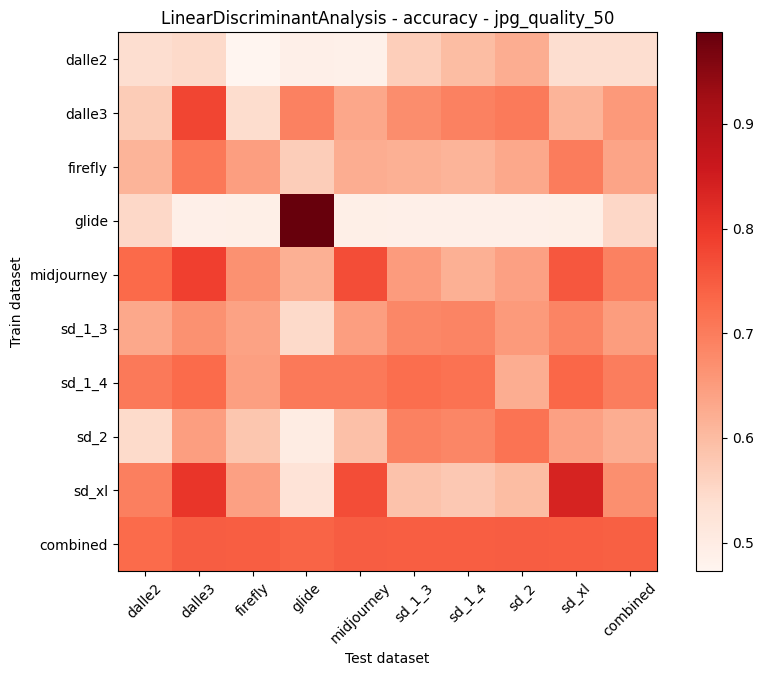

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5400  0.5475   0.4725  0.4900      0.4875  0.5675  0.5975   
dalle3         0.5725  0.7800   0.5425  0.6925      0.6325  0.6725  0.6925   
firefly        0.6125  0.7075   0.6475  0.5700      0.6225  0.6175  0.6125   
glide          0.5500  0.4900   0.4925  0.9875      0.4925  0.4900  0.4900   
midjourney     0.7300  0.7875   0.6675  0.6175      0.7700  0.6500  0.6175   
sd_1_3         0.6300  0.6675   0.6400  0.5475      0.6475  0.6825  0.6875   
sd_1_4         0.7050  0.7275   0.6450  0.7050      0.7050  0.7225  0.7175   
sd_2           0.5450  0.6475   0.5825  0.5000      0.5925  0.6925  0.6850   
sd_xl          0.6950  0.8025   0.6425  0.5250      0.7700  0.5875  0.5775   
combined       0.7275  0.7475   0.7450  0.7375      0.7475  0.7450  0.7450   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6225  0.5400  0.540556  
dalle3         0.7025  0.6125  0.655556  
firefly        0.6300  0.7000  0.635556  
glide          0.4900  0.4925  0.552778  
midjourney     0.6425  0.7550  0.693056  
sd_1_3         0.6525  0.6875  0.649167  
sd_1_4         0.6225  0.7325  0.698056  
sd_2           0.7150  0.6425  0.622500  
sd_xl          0.5975  0.8375  0.670556  
combined       0.7475  0.7450  0.743056

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5400  0.5475   0.4725  0.4900      0.4875  0.5675  0.5975   
dalle3         0.5725  0.7800   0.5425  0.6925      0.6325  0.6725  0.6925   
firefly        0.6125  0.7075   0.6475  0.5700      0.6225  0.6175  0.6125   
glide          0.5500  0.4900   0.4925  0.9875      0.4925  0.4900  0.4900   
midjourney     0.7300  0.7875   0.6675  0.6175      0.7700  0.6500  0.6175   
sd_1_3         0.6300  0.6675   0.6400  0.5475      0.6475  0.6825  0.6875   
sd_1_4         0.7050  0.7275   0.6450  0.7050      0.7050  0.7225  0.7175   
sd_2           0.5450  0.6475   0.5825  0.5000      0.5925  0.6925  0.6850   
sd_xl          0.6950  0.8025   0.6425  0.5250      0.7700  0.5875  0.5775   
combined       0.7275  0.7475   0.7450  0.7375      0.7475  0.7450  0.7450   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6225  0.5400  0.540556  
dalle3         0.7025  0.6125  0.655556  
firefly        0.6300  0.7000  0.635556  
glide          0.4900  0.4925  0.552778  
midjourney     0.6425  0.7550  0.693056  
sd_1_3         0.6525  0.6875  0.649167  
sd_1_4         0.6225  0.7325  0.698056  
sd_2           0.7150  0.6425  0.622500  
sd_xl          0.5975  0.8375  0.670556  
combined       0.7475  0.7450  0.743056

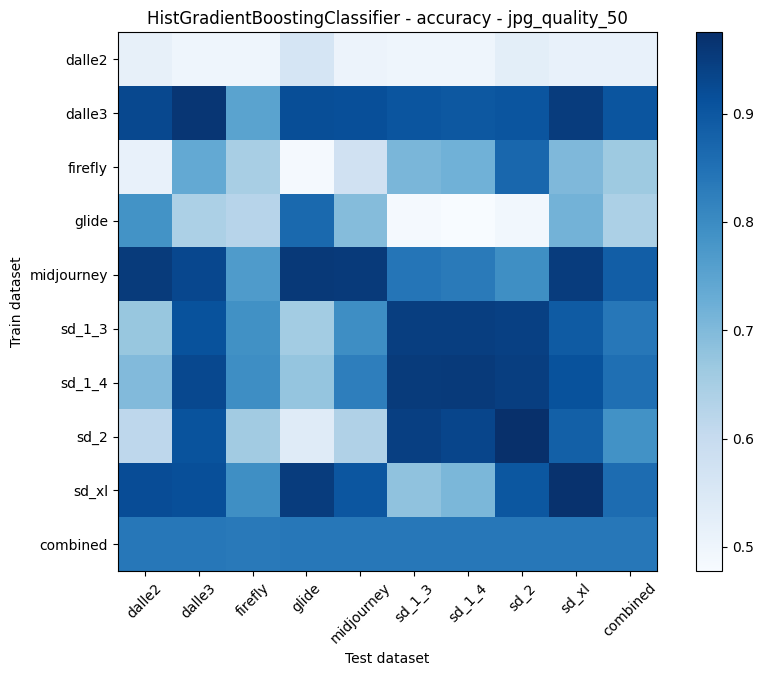

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5175  0.5000   0.5000  0.5625      0.5050  0.5000  0.5000   
dalle3         0.9275  0.9625   0.7500  0.9175      0.9150  0.9050  0.8975   
firefly        0.5150  0.7375   0.6475  0.4850      0.5750  0.7075  0.7200   
glide          0.7850  0.6425   0.6250  0.8650      0.6950  0.4850  0.4775   
midjourney     0.9525  0.9300   0.7675  0.9575      0.9550  0.8425  0.8325   
sd_1_3         0.6700  0.9100   0.7900  0.6550      0.7950  0.9475  0.9475   
sd_1_4         0.6975  0.9275   0.7950  0.6750      0.8250  0.9525  0.9550   
sd_2           0.6150  0.9075   0.6575  0.5375      0.6350  0.9450  0.9325   
sd_xl          0.9200  0.9150   0.7925  0.9500      0.9025  0.6800  0.7050   
combined       0.8375  0.8375   0.8350  0.8375      0.8375  0.8375  0.8375   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5275  0.5125  0.513889  
dalle3         0.9050  0.9500  0.903333  
firefly        0.8700  0.7025  0.662222  
glide          0.4925  0.7150  0.642500  
midjourney     0.7925  0.9500  0.886667  
sd_1_3         0.9425  0.8925  0.838889  
sd_1_4         0.9475  0.9100  0.853889  
sd_2           0.9750  0.8825  0.787500  
sd_xl          0.9000  0.9700  0.859444  
combined       0.8375  0.8375  0.837222

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5175  0.5000   0.5000  0.5625      0.5050  0.5000  0.5000   
dalle3         0.9275  0.9625   0.7500  0.9175      0.9150  0.9050  0.8975   
firefly        0.5150  0.7375   0.6475  0.4850      0.5750  0.7075  0.7200   
glide          0.7850  0.6425   0.6250  0.8650      0.6950  0.4850  0.4775   
midjourney     0.9525  0.9300   0.7675  0.9575      0.9550  0.8425  0.8325   
sd_1_3         0.6700  0.9100   0.7900  0.6550      0.7950  0.9475  0.9475   
sd_1_4         0.6975  0.9275   0.7950  0.6750      0.8250  0.9525  0.9550   
sd_2           0.6150  0.9075   0.6575  0.5375      0.6350  0.9450  0.9325   
sd_xl          0.9200  0.9150   0.7925  0.9500      0.9025  0.6800  0.7050   
combined       0.8375  0.8375   0.8350  0.8375      0.8375  0.8375  0.8375   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5275  0.5125  0.513889  
dalle3         0.9050  0.9500  0.903333  
firefly        0.8700  0.7025  0.662222  
glide          0.4925  0.7150  0.642500  
midjourney     0.7925  0.9500  0.886667  
sd_1_3         0.9425  0.8925  0.838889  
sd_1_4         0.9475  0.9100  0.853889  
sd_2           0.9750  0.8825  0.787500  
sd_xl          0.9000  0.9700  0.859444  
combined       0.8375  0.8375  0.837222

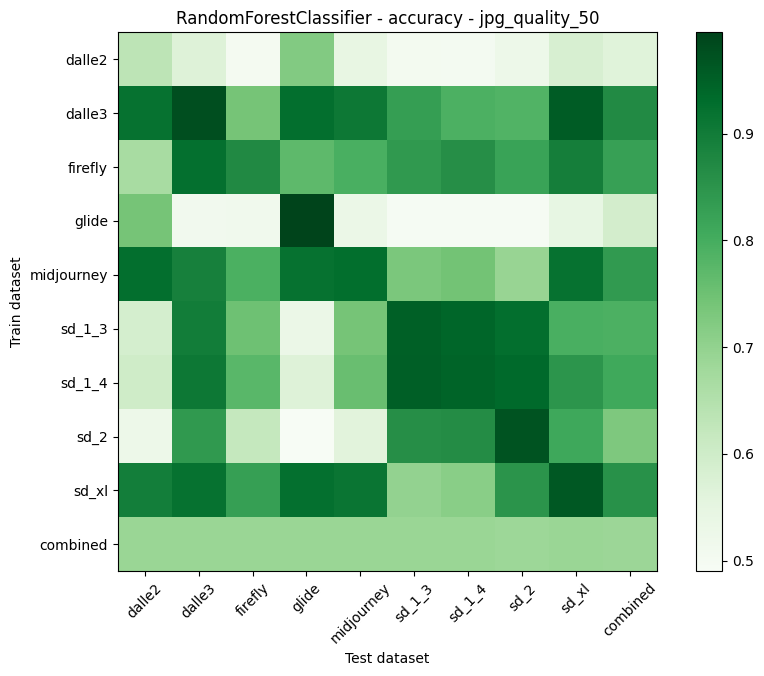

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6325  0.5675   0.5000  0.7225      0.5425  0.5050  0.5025   
dalle3         0.9200  0.9775   0.7400  0.9250      0.9075  0.8300  0.7900   
firefly        0.6675  0.9225   0.8725  0.7700      0.7950  0.8400  0.8625   
glide          0.7400  0.5100   0.5125  0.9950      0.5325  0.4950  0.4950   
midjourney     0.9250  0.8900   0.7925  0.9200      0.9275  0.7325  0.7425   
sd_1_3         0.5875  0.8975   0.7500  0.5325      0.7400  0.9500  0.9400   
sd_1_4         0.6000  0.9075   0.7750  0.5675      0.7550  0.9525  0.9450   
sd_2           0.5250  0.8400   0.6200  0.4900      0.5600  0.8625  0.8650   
sd_xl          0.8950  0.9200   0.8275  0.9225      0.9125  0.6975  0.7125   
combined       0.6875  0.6875   0.6875  0.6875      0.6875  0.6875  0.6875   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5250  0.5825  0.564444  
dalle3         0.7850  0.9575  0.870278  
firefly        0.8200  0.8925  0.826944  
glide          0.4975  0.5450  0.591389  
midjourney     0.6925  0.9200  0.838056  
sd_1_3         0.9250  0.7950  0.790833  
sd_1_4         0.9350  0.8475  0.809444  
sd_2           0.9700  0.8100  0.726944  
sd_xl          0.8500  0.9625  0.855556  
combined       0.6850  0.6875  0.687222

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6325  0.5675   0.5000  0.7225      0.5425  0.5050  0.5025   
dalle3         0.9200  0.9775   0.7400  0.9250      0.9075  0.8300  0.7900   
firefly        0.6675  0.9225   0.8725  0.7700      0.7950  0.8400  0.8625   
glide          0.7400  0.5100   0.5125  0.9950      0.5325  0.4950  0.4950   
midjourney     0.9250  0.8900   0.7925  0.9200      0.9275  0.7325  0.7425   
sd_1_3         0.5875  0.8975   0.7500  0.5325      0.7400  0.9500  0.9400   
sd_1_4         0.6000  0.9075   0.7750  0.5675      0.7550  0.9525  0.9450   
sd_2           0.5250  0.8400   0.6200  0.4900      0.5600  0.8625  0.8650   
sd_xl          0.8950  0.9200   0.8275  0.9225      0.9125  0.6975  0.7125   
combined       0.6875  0.6875   0.6875  0.6875      0.6875  0.6875  0.6875   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5250  0.5825  0.564444  
dalle3         0.7850  0.9575  0.870278  
firefly        0.8200  0.8925  0.826944  
glide          0.4975  0.5450  0.591389  
midjourney     0.6925  0.9200  0.838056  
sd_1_3         0.9250  0.7950  0.790833  
sd_1_4         0.9350  0.8475  0.809444  
sd_2           0.9700  0.8100  0.726944  
sd_xl          0.8500  0.9625  0.855556  
combined       0.6850  0.6875  0.687222

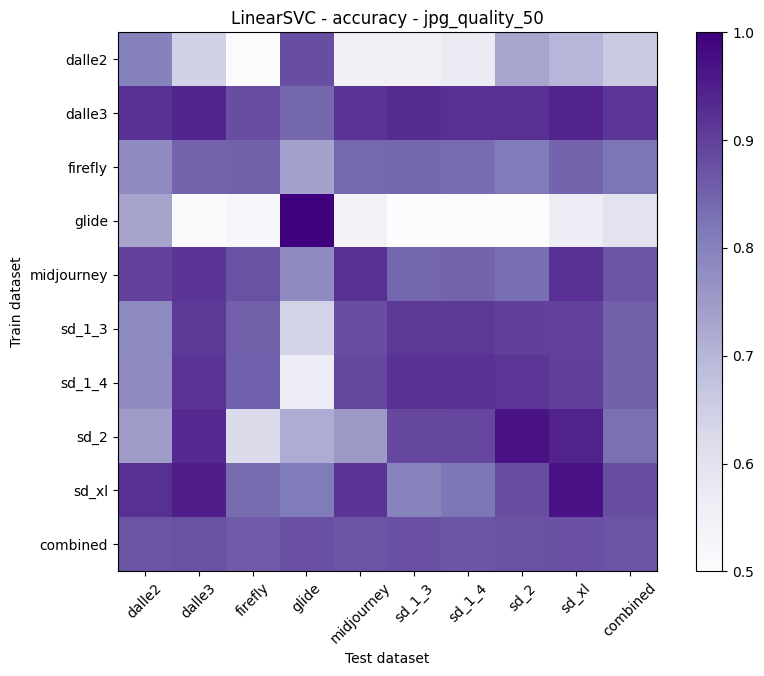

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8000  0.6425   0.5025  0.8775      0.5500  0.5475  0.5700   
dalle3         0.9200  0.9425   0.8800  0.8425      0.9175  0.9300  0.9250   
firefly        0.7800  0.8475   0.8500  0.7375      0.8400  0.8425  0.8350   
glide          0.7325  0.5075   0.5200  1.0000      0.5375  0.5000  0.5000   
midjourney     0.8950  0.9150   0.8725  0.7775      0.9200  0.8450  0.8475   
sd_1_3         0.7850  0.9100   0.8550  0.6400      0.8800  0.9100  0.9100   
sd_1_4         0.7775  0.9175   0.8525  0.5650      0.8900  0.9200  0.9200   
sd_2           0.7450  0.9325   0.6225  0.7175      0.7500  0.8875  0.8900   
sd_xl          0.9225  0.9500   0.8375  0.8125      0.9150  0.7975  0.8200   
combined       0.8700  0.8725   0.8600  0.8750      0.8700  0.8750  0.8675   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7300  0.7000  0.657778  
dalle3         0.9200  0.9425  0.913333  
firefly        0.8125  0.8475  0.821389  
glide          0.5025  0.5650  0.596111  
midjourney     0.8325  0.9225  0.869722  
sd_1_3         0.9000  0.8975  0.854167  
sd_1_4         0.9125  0.9000  0.850556  
sd_2           0.9725  0.9450  0.829167  
sd_xl          0.8800  0.9675  0.878056  
combined       0.8725  0.8750  0.870833

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8000  0.6425   0.5025  0.8775      0.5500  0.5475  0.5700   
dalle3         0.9200  0.9425   0.8800  0.8425      0.9175  0.9300  0.9250   
firefly        0.7800  0.8475   0.8500  0.7375      0.8400  0.8425  0.8350   
glide          0.7325  0.5075   0.5200  1.0000      0.5375  0.5000  0.5000   
midjourney     0.8950  0.9150   0.8725  0.7775      0.9200  0.8450  0.8475   
sd_1_3         0.7850  0.9100   0.8550  0.6400      0.8800  0.9100  0.9100   
sd_1_4         0.7775  0.9175   0.8525  0.5650      0.8900  0.9200  0.9200   
sd_2           0.7450  0.9325   0.6225  0.7175      0.7500  0.8875  0.8900   
sd_xl          0.9225  0.9500   0.8375  0.8125      0.9150  0.7975  0.8200   
combined       0.8700  0.8725   0.8600  0.8750      0.8700  0.8750  0.8675   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7300  0.7000  0.657778  
dalle3         0.9200  0.9425  0.913333  
firefly        0.8125  0.8475  0.821389  
glide          0.5025  0.5650  0.596111  
midjourney     0.8325  0.9225  0.869722  
sd_1_3         0.9000  0.8975  0.854167  
sd_1_4         0.9125  0.9000  0.850556  
sd_2           0.9725  0.9450  0.829167  
sd_xl          0.8800  0.9675  0.878056  
combined       0.8725  0.8750  0.870833









 ################ Evaluating models trained on standard and tested on jpg_quality_70. ################


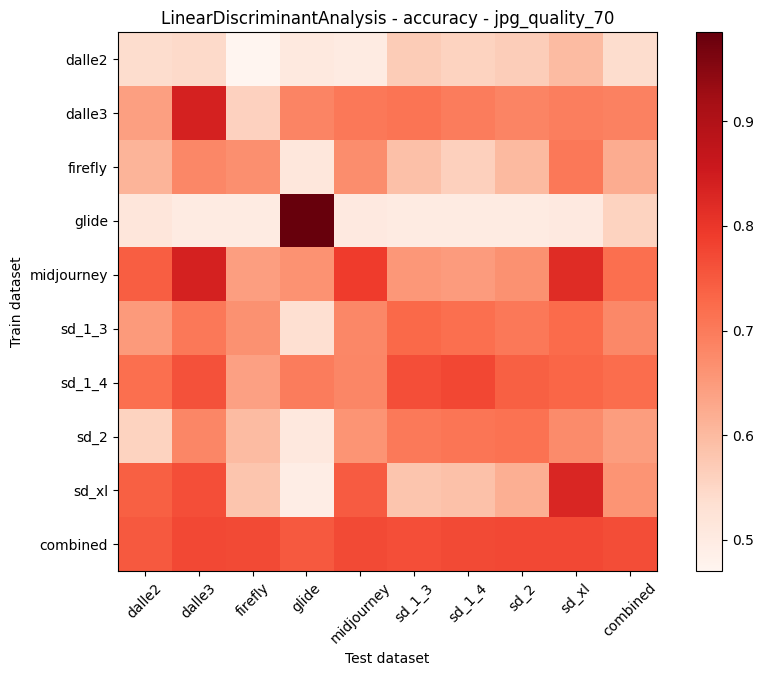

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5400  0.5450   0.4700  0.5075      0.5000  0.5700  0.5575   
dalle3         0.6425  0.8400   0.5600  0.6850      0.7050  0.7100  0.6975   
firefly        0.6100  0.6800   0.6675  0.5125      0.6700  0.5900  0.5625   
glide          0.5150  0.5000   0.5000  0.9850      0.5050  0.5000  0.5000   
midjourney     0.7425  0.8400   0.6450  0.6625      0.7900  0.6550  0.6475   
sd_1_3         0.6500  0.7050   0.6650  0.5325      0.6800  0.7275  0.7175   
sd_1_4         0.7175  0.7600   0.6400  0.6975      0.6825  0.7650  0.7750   
sd_2           0.5575  0.6825   0.5975  0.5100      0.6600  0.7025  0.7075   
sd_xl          0.7400  0.7650   0.5825  0.4925      0.7475  0.5825  0.5875   
combined       0.7500  0.7725   0.7700  0.7500      0.7700  0.7650  0.7700   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5675  0.5975  0.539444  
dalle3         0.6850  0.6950  0.691111  
firefly        0.6000  0.7050  0.621944  
glide          0.5000  0.5050  0.556667  
midjourney     0.6650  0.8200  0.718611  
sd_1_3         0.7050  0.7250  0.678611  
sd_1_4         0.7400  0.7325  0.723333  
sd_2           0.7150  0.6750  0.645278  
sd_xl          0.6175  0.8300  0.660556  
combined       0.7725  0.7725  0.765833

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5400  0.5450   0.4700  0.5075      0.5000  0.5700  0.5575   
dalle3         0.6425  0.8400   0.5600  0.6850      0.7050  0.7100  0.6975   
firefly        0.6100  0.6800   0.6675  0.5125      0.6700  0.5900  0.5625   
glide          0.5150  0.5000   0.5000  0.9850      0.5050  0.5000  0.5000   
midjourney     0.7425  0.8400   0.6450  0.6625      0.7900  0.6550  0.6475   
sd_1_3         0.6500  0.7050   0.6650  0.5325      0.6800  0.7275  0.7175   
sd_1_4         0.7175  0.7600   0.6400  0.6975      0.6825  0.7650  0.7750   
sd_2           0.5575  0.6825   0.5975  0.5100      0.6600  0.7025  0.7075   
sd_xl          0.7400  0.7650   0.5825  0.4925      0.7475  0.5825  0.5875   
combined       0.7500  0.7725   0.7700  0.7500      0.7700  0.7650  0.7700   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5675  0.5975  0.539444  
dalle3         0.6850  0.6950  0.691111  
firefly        0.6000  0.7050  0.621944  
glide          0.5000  0.5050  0.556667  
midjourney     0.6650  0.8200  0.718611  
sd_1_3         0.7050  0.7250  0.678611  
sd_1_4         0.7400  0.7325  0.723333  
sd_2           0.7150  0.6750  0.645278  
sd_xl          0.6175  0.8300  0.660556  
combined       0.7725  0.7725  0.765833

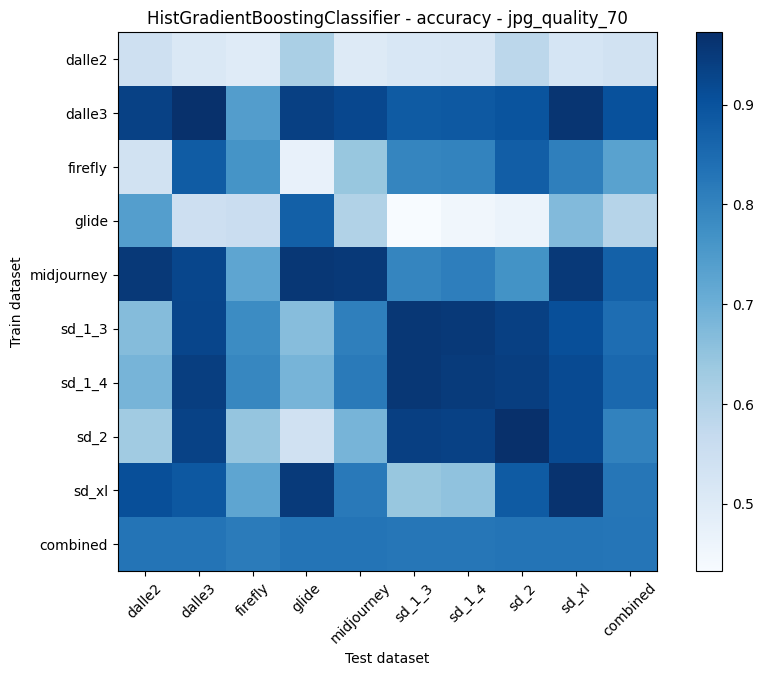

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5425  0.5100   0.4975  0.6150      0.5025  0.5150  0.5175   
dalle3         0.9350  0.9700   0.7425  0.9375      0.9225  0.8825  0.8875   
firefly        0.5350  0.8800   0.7650  0.4725      0.6425  0.7950  0.7975   
glide          0.7400  0.5475   0.5550  0.8725      0.6025  0.4325  0.4500   
midjourney     0.9525  0.9250   0.7225  0.9575      0.9525  0.7950  0.8100   
sd_1_3         0.6675  0.9275   0.7825  0.6650      0.8075  0.9575  0.9525   
sd_1_4         0.6875  0.9425   0.7925  0.6875      0.8175  0.9575  0.9475   
sd_2           0.6300  0.9325   0.6475  0.5400      0.6875  0.9400  0.9350   
sd_xl          0.9075  0.8900   0.7225  0.9500      0.8200  0.6425  0.6525   
combined       0.8300  0.8300   0.8150  0.8300      0.8300  0.8250  0.8250   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5825  0.5250  0.534167  
dalle3         0.8975  0.9600  0.903889  
firefly        0.8775  0.8075  0.730278  
glide          0.4650  0.6725  0.593056  
midjourney     0.7675  0.9525  0.870556  
sd_1_3         0.9375  0.9075  0.845000  
sd_1_4         0.9425  0.9175  0.854722  
sd_2           0.9725  0.9175  0.800278  
sd_xl          0.8825  0.9650  0.825833  
combined       0.8300  0.8300  0.827222

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5425  0.5100   0.4975  0.6150      0.5025  0.5150  0.5175   
dalle3         0.9350  0.9700   0.7425  0.9375      0.9225  0.8825  0.8875   
firefly        0.5350  0.8800   0.7650  0.4725      0.6425  0.7950  0.7975   
glide          0.7400  0.5475   0.5550  0.8725      0.6025  0.4325  0.4500   
midjourney     0.9525  0.9250   0.7225  0.9575      0.9525  0.7950  0.8100   
sd_1_3         0.6675  0.9275   0.7825  0.6650      0.8075  0.9575  0.9525   
sd_1_4         0.6875  0.9425   0.7925  0.6875      0.8175  0.9575  0.9475   
sd_2           0.6300  0.9325   0.6475  0.5400      0.6875  0.9400  0.9350   
sd_xl          0.9075  0.8900   0.7225  0.9500      0.8200  0.6425  0.6525   
combined       0.8300  0.8300   0.8150  0.8300      0.8300  0.8250  0.8250   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5825  0.5250  0.534167  
dalle3         0.8975  0.9600  0.903889  
firefly        0.8775  0.8075  0.730278  
glide          0.4650  0.6725  0.593056  
midjourney     0.7675  0.9525  0.870556  
sd_1_3         0.9375  0.9075  0.845000  
sd_1_4         0.9425  0.9175  0.854722  
sd_2           0.9725  0.9175  0.800278  
sd_xl          0.8825  0.9650  0.825833  
combined       0.8300  0.8300  0.827222

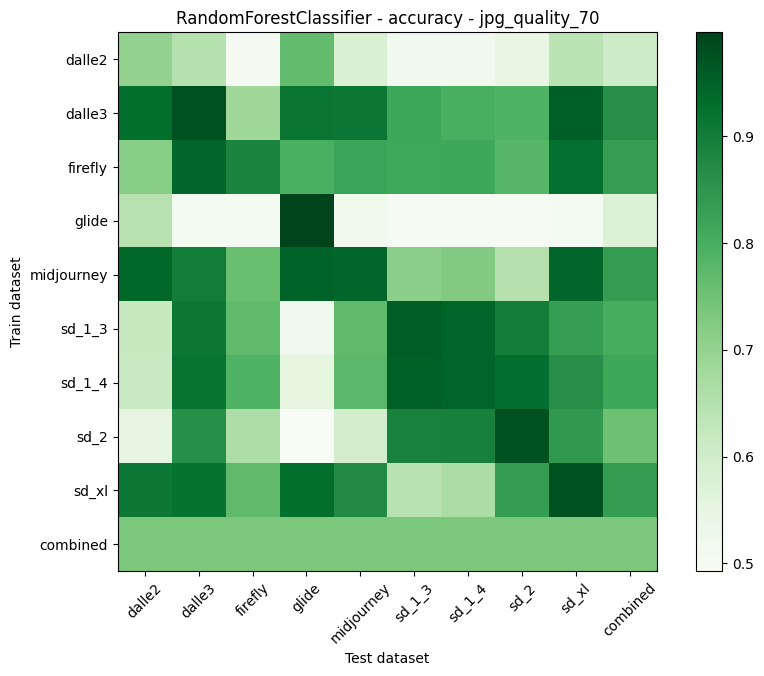

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.7025  0.6500   0.5025  0.7650      0.5800  0.5150  0.5150   
dalle3         0.9300  0.9775   0.6850  0.9150      0.9125  0.8175  0.8000   
firefly        0.7150  0.9425   0.8850  0.7975      0.8200  0.8125  0.8150   
glide          0.6450  0.5075   0.5050  0.9975      0.5200  0.4975  0.4975   
midjourney     0.9400  0.9000   0.7575  0.9475      0.9425  0.7100  0.7250   
sd_1_3         0.6175  0.9100   0.7700  0.5175      0.7675  0.9575  0.9450   
sd_1_4         0.6150  0.9175   0.7900  0.5550      0.7750  0.9525  0.9450   
sd_2           0.5500  0.8600   0.6600  0.4925      0.5950  0.8900  0.8925   
sd_xl          0.9100  0.9200   0.7675  0.9300      0.8725  0.6425  0.6625   
combined       0.7350  0.7350   0.7350  0.7350      0.7350  0.7350  0.7350   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5450  0.6375  0.601389  
dalle3         0.7900  0.9550  0.864722  
firefly        0.7800  0.9250  0.832500  
glide          0.4975  0.5050  0.574722  
midjourney     0.6475  0.9425  0.834722  
sd_1_3         0.9000  0.8325  0.801944  
sd_1_4         0.9275  0.8625  0.815556  
sd_2           0.9775  0.8425  0.751111  
sd_xl          0.8350  0.9725  0.834722  
combined       0.7350  0.7350  0.735000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.7025  0.6500   0.5025  0.7650      0.5800  0.5150  0.5150   
dalle3         0.9300  0.9775   0.6850  0.9150      0.9125  0.8175  0.8000   
firefly        0.7150  0.9425   0.8850  0.7975      0.8200  0.8125  0.8150   
glide          0.6450  0.5075   0.5050  0.9975      0.5200  0.4975  0.4975   
midjourney     0.9400  0.9000   0.7575  0.9475      0.9425  0.7100  0.7250   
sd_1_3         0.6175  0.9100   0.7700  0.5175      0.7675  0.9575  0.9450   
sd_1_4         0.6150  0.9175   0.7900  0.5550      0.7750  0.9525  0.9450   
sd_2           0.5500  0.8600   0.6600  0.4925      0.5950  0.8900  0.8925   
sd_xl          0.9100  0.9200   0.7675  0.9300      0.8725  0.6425  0.6625   
combined       0.7350  0.7350   0.7350  0.7350      0.7350  0.7350  0.7350   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5450  0.6375  0.601389  
dalle3         0.7900  0.9550  0.864722  
firefly        0.7800  0.9250  0.832500  
glide          0.4975  0.5050  0.574722  
midjourney     0.6475  0.9425  0.834722  
sd_1_3         0.9000  0.8325  0.801944  
sd_1_4         0.9275  0.8625  0.815556  
sd_2           0.9775  0.8425  0.751111  
sd_xl          0.8350  0.9725  0.834722  
combined       0.7350  0.7350  0.735000

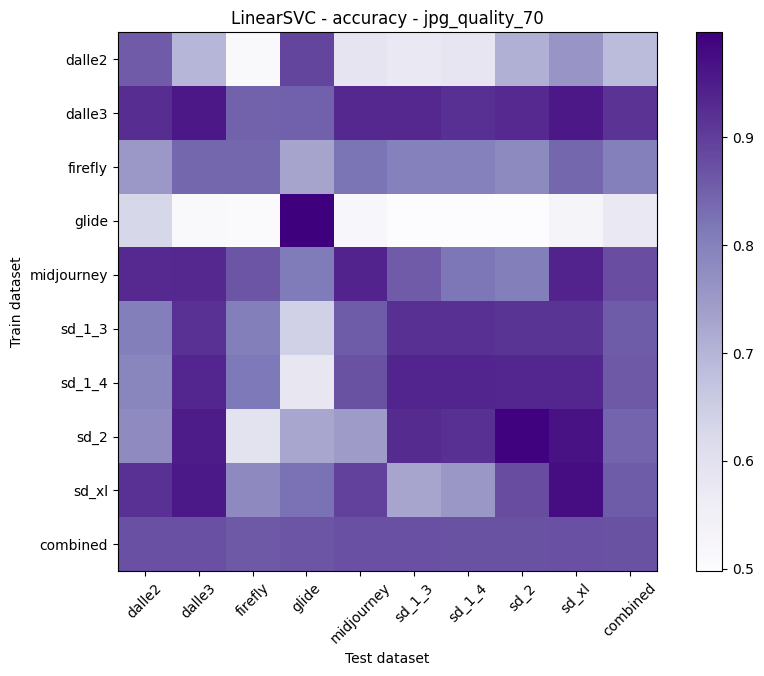

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8575  0.6975   0.5100  0.8900      0.5875  0.5750  0.5850   
dalle3         0.9250  0.9575   0.8475  0.8500      0.9325  0.9325  0.9200   
firefly        0.7525  0.8400   0.8400  0.7300      0.8200  0.8000  0.8000   
glide          0.6300  0.5075   0.5050  0.9975      0.5175  0.4975  0.4975   
midjourney     0.9300  0.9325   0.8650  0.8100      0.9400  0.8575  0.8175   
sd_1_3         0.8050  0.9175   0.8050  0.6425      0.8550  0.9200  0.9200   
sd_1_4         0.7900  0.9350   0.8150  0.5800      0.8700  0.9375  0.9375   
sd_2           0.7775  0.9525   0.5950  0.7250      0.7450  0.9275  0.9200   
sd_xl          0.9175  0.9550   0.7800  0.8250      0.8950  0.7275  0.7550   
combined       0.8725  0.8725   0.8600  0.8650      0.8725  0.8725  0.8700   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7100  0.7575  0.685556  
dalle3         0.9300  0.9575  0.916944  
firefly        0.7825  0.8400  0.800556  
glide          0.4975  0.5275  0.575278  
midjourney     0.8050  0.9400  0.877500  
sd_1_3         0.9150  0.9150  0.855000  
sd_1_4         0.9350  0.9350  0.859444  
sd_2           0.9925  0.9700  0.845000  
sd_xl          0.8800  0.9750  0.856667  
combined       0.8700  0.8725  0.869722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8575  0.6975   0.5100  0.8900      0.5875  0.5750  0.5850   
dalle3         0.9250  0.9575   0.8475  0.8500      0.9325  0.9325  0.9200   
firefly        0.7525  0.8400   0.8400  0.7300      0.8200  0.8000  0.8000   
glide          0.6300  0.5075   0.5050  0.9975      0.5175  0.4975  0.4975   
midjourney     0.9300  0.9325   0.8650  0.8100      0.9400  0.8575  0.8175   
sd_1_3         0.8050  0.9175   0.8050  0.6425      0.8550  0.9200  0.9200   
sd_1_4         0.7900  0.9350   0.8150  0.5800      0.8700  0.9375  0.9375   
sd_2           0.7775  0.9525   0.5950  0.7250      0.7450  0.9275  0.9200   
sd_xl          0.9175  0.9550   0.7800  0.8250      0.8950  0.7275  0.7550   
combined       0.8725  0.8725   0.8600  0.8650      0.8725  0.8725  0.8700   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7100  0.7575  0.685556  
dalle3         0.9300  0.9575  0.916944  
firefly        0.7825  0.8400  0.800556  
glide          0.4975  0.5275  0.575278  
midjourney     0.8050  0.9400  0.877500  
sd_1_3         0.9150  0.9150  0.855000  
sd_1_4         0.9350  0.9350  0.859444  
sd_2           0.9925  0.9700  0.845000  
sd_xl          0.8800  0.9750  0.856667  
combined       0.8700  0.8725  0.869722









 ################ Evaluating models trained on standard and tested on jpg_quality_90. ################


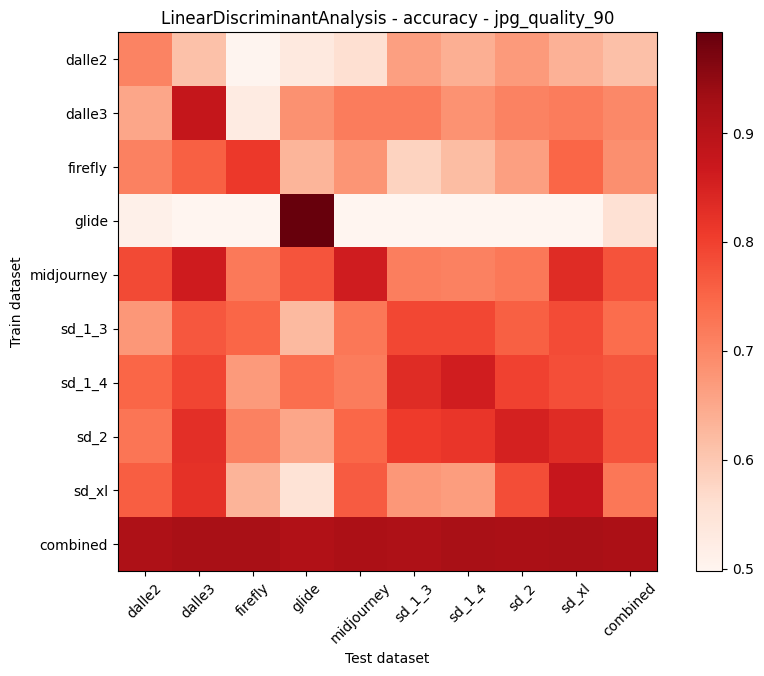

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.7050  0.6100   0.5000  0.5325      0.5575  0.6625  0.6400   
dalle3         0.6525  0.8800   0.5250  0.6850      0.7175  0.7175  0.6825   
firefly        0.7100  0.7575   0.8125  0.6300      0.6775  0.5825  0.6175   
glide          0.5125  0.4975   0.4975  0.9925      0.4975  0.4975  0.4975   
midjourney     0.7875  0.8625   0.7200  0.7725      0.8600  0.7125  0.7100   
sd_1_3         0.6750  0.7700   0.7500  0.6225      0.7250  0.7900  0.7900   
sd_1_4         0.7500  0.7925   0.6700  0.7375      0.7175  0.8325  0.8575   
sd_2           0.7275  0.8275   0.7100  0.6525      0.7475  0.8075  0.8150   
sd_xl          0.7600  0.8225   0.6325  0.5500      0.7625  0.6750  0.6675   
combined       0.9150  0.9225   0.9225  0.9100      0.9175  0.9150  0.9225   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6700  0.6350  0.612500  
dalle3         0.7075  0.7175  0.698333  
firefly        0.6625  0.7500  0.688889  
glide          0.4975  0.4975  0.554167  
midjourney     0.7225  0.8325  0.775556  
sd_1_3         0.7575  0.7850  0.740556  
sd_1_4         0.7975  0.7800  0.770556  
sd_2           0.8525  0.8325  0.774722  
sd_xl          0.7825  0.8750  0.725278  
combined       0.9200  0.9225  0.918611

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.7050  0.6100   0.5000  0.5325      0.5575  0.6625  0.6400   
dalle3         0.6525  0.8800   0.5250  0.6850      0.7175  0.7175  0.6825   
firefly        0.7100  0.7575   0.8125  0.6300      0.6775  0.5825  0.6175   
glide          0.5125  0.4975   0.4975  0.9925      0.4975  0.4975  0.4975   
midjourney     0.7875  0.8625   0.7200  0.7725      0.8600  0.7125  0.7100   
sd_1_3         0.6750  0.7700   0.7500  0.6225      0.7250  0.7900  0.7900   
sd_1_4         0.7500  0.7925   0.6700  0.7375      0.7175  0.8325  0.8575   
sd_2           0.7275  0.8275   0.7100  0.6525      0.7475  0.8075  0.8150   
sd_xl          0.7600  0.8225   0.6325  0.5500      0.7625  0.6750  0.6675   
combined       0.9150  0.9225   0.9225  0.9100      0.9175  0.9150  0.9225   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6700  0.6350  0.612500  
dalle3         0.7075  0.7175  0.698333  
firefly        0.6625  0.7500  0.688889  
glide          0.4975  0.4975  0.554167  
midjourney     0.7225  0.8325  0.775556  
sd_1_3         0.7575  0.7850  0.740556  
sd_1_4         0.7975  0.7800  0.770556  
sd_2           0.8525  0.8325  0.774722  
sd_xl          0.7825  0.8750  0.725278  
combined       0.9200  0.9225  0.918611

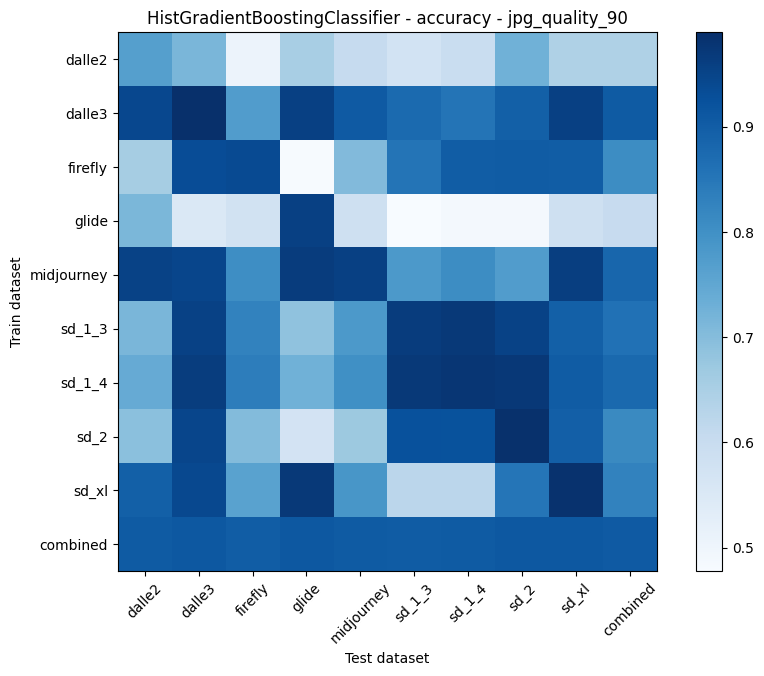

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.7675  0.7150   0.5075  0.6525      0.6050  0.5725  0.5975   
dalle3         0.9425  0.9900   0.7725  0.9575      0.9075  0.8750  0.8550   
firefly        0.6575  0.9325   0.9375  0.4800      0.7050  0.8550  0.9000   
glide          0.7125  0.5500   0.5775  0.9575      0.5825  0.4775  0.4875   
midjourney     0.9525  0.9475   0.8050  0.9650      0.9575  0.7800  0.8075   
sd_1_3         0.7150  0.9550   0.8275  0.6875      0.7800  0.9650  0.9700   
sd_1_4         0.7400  0.9625   0.8375  0.7275      0.8000  0.9700  0.9775   
sd_2           0.6925  0.9475   0.7025  0.5700      0.6700  0.9250  0.9225   
sd_xl          0.8950  0.9400   0.7600  0.9700      0.7875  0.6225  0.6225   
combined       0.9050  0.9100   0.9000  0.9100      0.9050  0.9025  0.9050   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7275  0.6425  0.643056  
dalle3         0.8950  0.9575  0.905833  
firefly        0.9025  0.9000  0.807778  
glide          0.4875  0.5850  0.601944  
midjourney     0.7725  0.9600  0.883056  
sd_1_3         0.9525  0.8950  0.860833  
sd_1_4         0.9725  0.9025  0.876667  
sd_2           0.9875  0.8975  0.812778  
sd_xl          0.8525  0.9850  0.826111  
combined       0.9100  0.9100  0.906389

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.7675  0.7150   0.5075  0.6525      0.6050  0.5725  0.5975   
dalle3         0.9425  0.9900   0.7725  0.9575      0.9075  0.8750  0.8550   
firefly        0.6575  0.9325   0.9375  0.4800      0.7050  0.8550  0.9000   
glide          0.7125  0.5500   0.5775  0.9575      0.5825  0.4775  0.4875   
midjourney     0.9525  0.9475   0.8050  0.9650      0.9575  0.7800  0.8075   
sd_1_3         0.7150  0.9550   0.8275  0.6875      0.7800  0.9650  0.9700   
sd_1_4         0.7400  0.9625   0.8375  0.7275      0.8000  0.9700  0.9775   
sd_2           0.6925  0.9475   0.7025  0.5700      0.6700  0.9250  0.9225   
sd_xl          0.8950  0.9400   0.7600  0.9700      0.7875  0.6225  0.6225   
combined       0.9050  0.9100   0.9000  0.9100      0.9050  0.9025  0.9050   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7275  0.6425  0.643056  
dalle3         0.8950  0.9575  0.905833  
firefly        0.9025  0.9000  0.807778  
glide          0.4875  0.5850  0.601944  
midjourney     0.7725  0.9600  0.883056  
sd_1_3         0.9525  0.8950  0.860833  
sd_1_4         0.9725  0.9025  0.876667  
sd_2           0.9875  0.8975  0.812778  
sd_xl          0.8525  0.9850  0.826111  
combined       0.9100  0.9100  0.906389

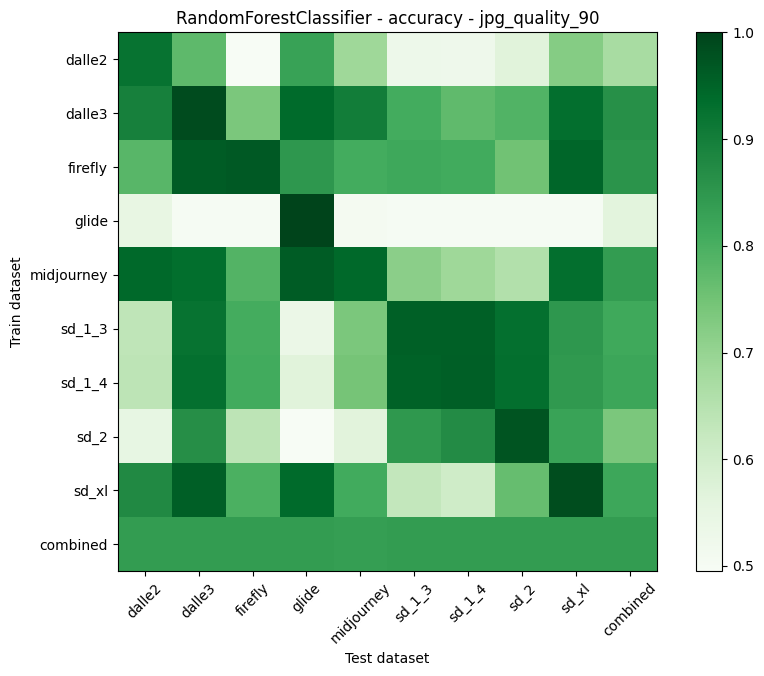

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9225  0.7750   0.4950  0.8275      0.6875  0.5275  0.5250   
dalle3         0.8950  0.9875   0.7375  0.9375      0.9025  0.8075  0.7725   
firefly        0.7825  0.9625   0.9650  0.8500      0.8075  0.8150  0.8100   
glide          0.5475  0.5000   0.5025  1.0000      0.5050  0.5000  0.5025   
midjourney     0.9425  0.9325   0.7875  0.9625      0.9425  0.7150  0.6875   
sd_1_3         0.6350  0.9225   0.8050  0.5375      0.7375  0.9550  0.9550   
sd_1_4         0.6375  0.9275   0.8100  0.5675      0.7450  0.9525  0.9575   
sd_2           0.5500  0.8675   0.6375  0.4950      0.5650  0.8475  0.8725   
sd_xl          0.8775  0.9575   0.7975  0.9375      0.8100  0.6275  0.6050   
combined       0.8400  0.8400   0.8400  0.8400      0.8350  0.8400  0.8400   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5675  0.7225  0.672222  
dalle3         0.7900  0.9300  0.862222  
firefly        0.7500  0.9450  0.854167  
glide          0.5025  0.5025  0.562500  
midjourney     0.6550  0.9300  0.839444  
sd_1_3         0.9275  0.8500  0.813889  
sd_1_4         0.9300  0.8450  0.819167  
sd_2           0.9725  0.8250  0.736944  
sd_xl          0.7650  0.9850  0.818056  
combined       0.8400  0.8400  0.839444

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9225  0.7750   0.4950  0.8275      0.6875  0.5275  0.5250   
dalle3         0.8950  0.9875   0.7375  0.9375      0.9025  0.8075  0.7725   
firefly        0.7825  0.9625   0.9650  0.8500      0.8075  0.8150  0.8100   
glide          0.5475  0.5000   0.5025  1.0000      0.5050  0.5000  0.5025   
midjourney     0.9425  0.9325   0.7875  0.9625      0.9425  0.7150  0.6875   
sd_1_3         0.6350  0.9225   0.8050  0.5375      0.7375  0.9550  0.9550   
sd_1_4         0.6375  0.9275   0.8100  0.5675      0.7450  0.9525  0.9575   
sd_2           0.5500  0.8675   0.6375  0.4950      0.5650  0.8475  0.8725   
sd_xl          0.8775  0.9575   0.7975  0.9375      0.8100  0.6275  0.6050   
combined       0.8400  0.8400   0.8400  0.8400      0.8350  0.8400  0.8400   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5675  0.7225  0.672222  
dalle3         0.7900  0.9300  0.862222  
firefly        0.7500  0.9450  0.854167  
glide          0.5025  0.5025  0.562500  
midjourney     0.6550  0.9300  0.839444  
sd_1_3         0.9275  0.8500  0.813889  
sd_1_4         0.9300  0.8450  0.819167  
sd_2           0.9725  0.8250  0.736944  
sd_xl          0.7650  0.9850  0.818056  
combined       0.8400  0.8400  0.839444

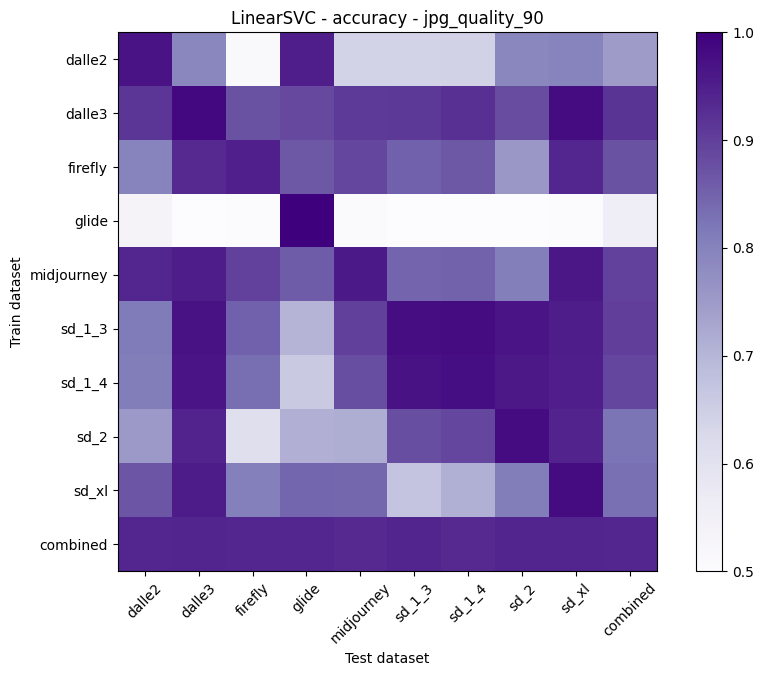

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9675  0.7900   0.5100  0.9500      0.6400  0.6400  0.6425   
dalle3         0.9125  0.9850   0.8725  0.8850      0.9075  0.9100  0.9225   
firefly        0.7975  0.9325   0.9475  0.8650      0.8900  0.8525  0.8650   
glide          0.5350  0.5000   0.5025  1.0000      0.5075  0.5000  0.5000   
midjourney     0.9375  0.9525   0.8975  0.8575      0.9575  0.8475  0.8500   
sd_1_3         0.8125  0.9700   0.8525  0.7025      0.9000  0.9775  0.9800   
sd_1_4         0.8100  0.9650   0.8325  0.6600      0.8775  0.9725  0.9750   
sd_2           0.7525  0.9425   0.6075  0.7100      0.7150  0.8775  0.8900   
sd_xl          0.8675  0.9550   0.8050  0.8450      0.8425  0.6700  0.7125   
combined       0.9375  0.9400   0.9375  0.9375      0.9325  0.9400  0.9325   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7900  0.7950  0.747222  
dalle3         0.8825  0.9800  0.917500  
firefly        0.7575  0.9375  0.871667  
glide          0.5000  0.5025  0.560833  
midjourney     0.8075  0.9625  0.896667  
sd_1_3         0.9650  0.9525  0.901389  
sd_1_4         0.9600  0.9500  0.889167  
sd_2           0.9800  0.9425  0.824167  
sd_xl          0.8100  0.9800  0.831944  
combined       0.9400  0.9400  0.937500

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9675  0.7900   0.5100  0.9500      0.6400  0.6400  0.6425   
dalle3         0.9125  0.9850   0.8725  0.8850      0.9075  0.9100  0.9225   
firefly        0.7975  0.9325   0.9475  0.8650      0.8900  0.8525  0.8650   
glide          0.5350  0.5000   0.5025  1.0000      0.5075  0.5000  0.5000   
midjourney     0.9375  0.9525   0.8975  0.8575      0.9575  0.8475  0.8500   
sd_1_3         0.8125  0.9700   0.8525  0.7025      0.9000  0.9775  0.9800   
sd_1_4         0.8100  0.9650   0.8325  0.6600      0.8775  0.9725  0.9750   
sd_2           0.7525  0.9425   0.6075  0.7100      0.7150  0.8775  0.8900   
sd_xl          0.8675  0.9550   0.8050  0.8450      0.8425  0.6700  0.7125   
combined       0.9375  0.9400   0.9375  0.9375      0.9325  0.9400  0.9325   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7900  0.7950  0.747222  
dalle3         0.8825  0.9800  0.917500  
firefly        0.7575  0.9375  0.871667  
glide          0.5000  0.5025  0.560833  
midjourney     0.8075  0.9625  0.896667  
sd_1_3         0.9650  0.9525  0.901389  
sd_1_4         0.9600  0.9500  0.889167  
sd_2           0.9800  0.9425  0.824167  
sd_xl          0.8100  0.9800  0.831944  
combined       0.9400  0.9400  0.937500









 ################ Evaluating models trained on standard and tested on jpg_quality_80. ################


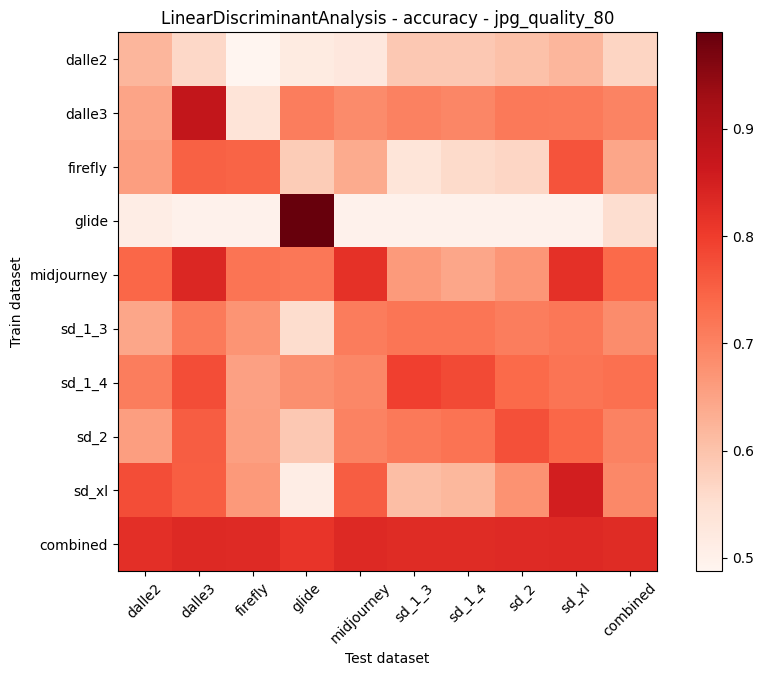

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6200  0.5625   0.4875  0.5175      0.5275  0.5900  0.5900   
dalle3         0.6475  0.8775   0.5375  0.7075      0.6875  0.7025  0.6950   
firefly        0.6575  0.7500   0.7450  0.5850      0.6375  0.5350  0.5600   
glide          0.5100  0.4975   0.4975  0.9900      0.4975  0.4975  0.4975   
midjourney     0.7425  0.8350   0.7225  0.7175      0.8175  0.6625  0.6450   
sd_1_3         0.6450  0.7125   0.6725  0.5550      0.7100  0.7200  0.7200   
sd_1_4         0.7075  0.7775   0.6525  0.6800      0.6925  0.7950  0.7800   
sd_2           0.6575  0.7550   0.6550  0.5900      0.7000  0.7150  0.7250   
sd_xl          0.7775  0.7525   0.6650  0.5100      0.7550  0.6075  0.6175   
combined       0.8225  0.8325   0.8300  0.8125      0.8325  0.8275  0.8275   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6025  0.6200  0.568611  
dalle3         0.7150  0.7125  0.698056  
firefly        0.5675  0.7700  0.645278  
glide          0.4975  0.4975  0.553611  
midjourney     0.6700  0.8200  0.736944  
sd_1_3         0.7075  0.7175  0.684444  
sd_1_4         0.7375  0.7225  0.727222  
sd_2           0.7725  0.7425  0.701389  
sd_xl          0.6750  0.8525  0.690278  
combined       0.8300  0.8325  0.827500

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6200  0.5625   0.4875  0.5175      0.5275  0.5900  0.5900   
dalle3         0.6475  0.8775   0.5375  0.7075      0.6875  0.7025  0.6950   
firefly        0.6575  0.7500   0.7450  0.5850      0.6375  0.5350  0.5600   
glide          0.5100  0.4975   0.4975  0.9900      0.4975  0.4975  0.4975   
midjourney     0.7425  0.8350   0.7225  0.7175      0.8175  0.6625  0.6450   
sd_1_3         0.6450  0.7125   0.6725  0.5550      0.7100  0.7200  0.7200   
sd_1_4         0.7075  0.7775   0.6525  0.6800      0.6925  0.7950  0.7800   
sd_2           0.6575  0.7550   0.6550  0.5900      0.7000  0.7150  0.7250   
sd_xl          0.7775  0.7525   0.6650  0.5100      0.7550  0.6075  0.6175   
combined       0.8225  0.8325   0.8300  0.8125      0.8325  0.8275  0.8275   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6025  0.6200  0.568611  
dalle3         0.7150  0.7125  0.698056  
firefly        0.5675  0.7700  0.645278  
glide          0.4975  0.4975  0.553611  
midjourney     0.6700  0.8200  0.736944  
sd_1_3         0.7075  0.7175  0.684444  
sd_1_4         0.7375  0.7225  0.727222  
sd_2           0.7725  0.7425  0.701389  
sd_xl          0.6750  0.8525  0.690278  
combined       0.8300  0.8325  0.827500

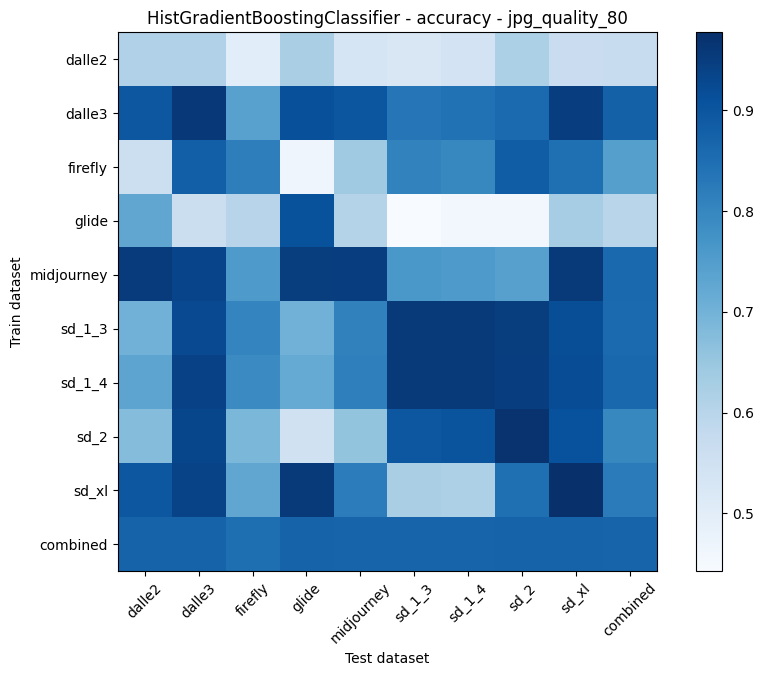

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6125  0.6125   0.5000  0.6225      0.5325  0.5225  0.5400   
dalle3         0.8975  0.9600   0.7400  0.9125      0.9000  0.8325  0.8425   
firefly        0.5575  0.8800   0.8150  0.4650      0.6400  0.8075  0.7975   
glide          0.7275  0.5625   0.6000  0.9075      0.6075  0.4425  0.4575   
midjourney     0.9525  0.9350   0.7575  0.9500      0.9475  0.7625  0.7575   
sd_1_3         0.7000  0.9250   0.8025  0.7000      0.8100  0.9550  0.9575   
sd_1_4         0.7325  0.9400   0.7900  0.7200      0.8125  0.9550  0.9575   
sd_2           0.6750  0.9300   0.6875  0.5475      0.6575  0.8975  0.9025   
sd_xl          0.8975  0.9375   0.7275  0.9575      0.8200  0.6225  0.6175   
combined       0.8725  0.8725   0.8500  0.8725      0.8700  0.8700  0.8700   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6200  0.5650  0.569722  
dalle3         0.8575  0.9475  0.876667  
firefly        0.8850  0.8475  0.743889  
glide          0.4575  0.6300  0.599167  
midjourney     0.7425  0.9550  0.862222  
sd_1_3         0.9500  0.9150  0.857222  
sd_1_4         0.9475  0.9175  0.863611  
sd_2           0.9700  0.9100  0.797500  
sd_xl          0.8475  0.9775  0.822778  
combined       0.8725  0.8725  0.869167

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6125  0.6125   0.5000  0.6225      0.5325  0.5225  0.5400   
dalle3         0.8975  0.9600   0.7400  0.9125      0.9000  0.8325  0.8425   
firefly        0.5575  0.8800   0.8150  0.4650      0.6400  0.8075  0.7975   
glide          0.7275  0.5625   0.6000  0.9075      0.6075  0.4425  0.4575   
midjourney     0.9525  0.9350   0.7575  0.9500      0.9475  0.7625  0.7575   
sd_1_3         0.7000  0.9250   0.8025  0.7000      0.8100  0.9550  0.9575   
sd_1_4         0.7325  0.9400   0.7900  0.7200      0.8125  0.9550  0.9575   
sd_2           0.6750  0.9300   0.6875  0.5475      0.6575  0.8975  0.9025   
sd_xl          0.8975  0.9375   0.7275  0.9575      0.8200  0.6225  0.6175   
combined       0.8725  0.8725   0.8500  0.8725      0.8700  0.8700  0.8700   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6200  0.5650  0.569722  
dalle3         0.8575  0.9475  0.876667  
firefly        0.8850  0.8475  0.743889  
glide          0.4575  0.6300  0.599167  
midjourney     0.7425  0.9550  0.862222  
sd_1_3         0.9500  0.9150  0.857222  
sd_1_4         0.9475  0.9175  0.863611  
sd_2           0.9700  0.9100  0.797500  
sd_xl          0.8475  0.9775  0.822778  
combined       0.8725  0.8725  0.869167

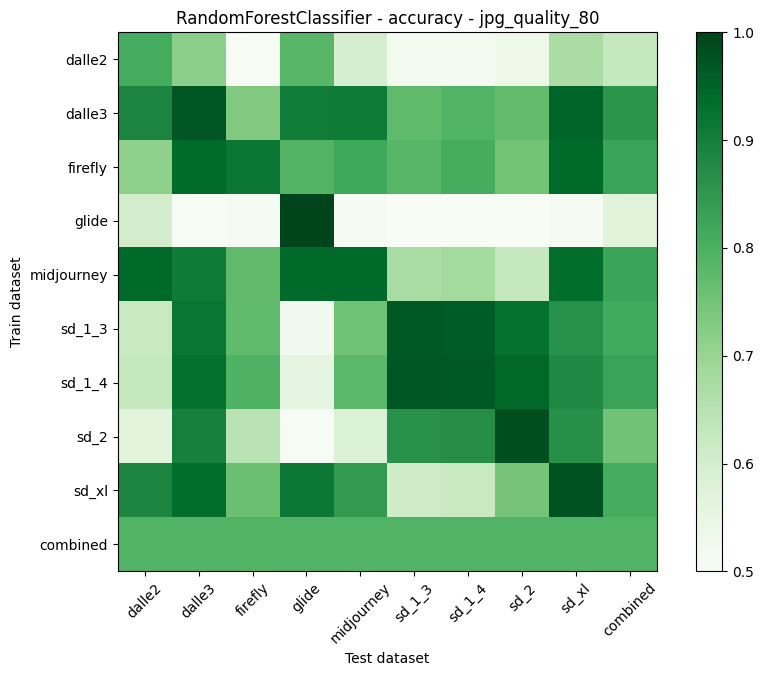

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8075  0.7150   0.5025  0.7850      0.5950  0.5150  0.5150   
dalle3         0.8875  0.9725   0.7325  0.9050      0.9075  0.7750  0.7925   
firefly        0.7125  0.9375   0.9150  0.7900      0.8150  0.7850  0.8050   
glide          0.6000  0.5025   0.5075  1.0000      0.5075  0.5000  0.5000   
midjourney     0.9400  0.9075   0.7725  0.9400      0.9400  0.6750  0.6825   
sd_1_3         0.6225  0.9175   0.7750  0.5225      0.7550  0.9675  0.9625   
sd_1_4         0.6275  0.9275   0.7950  0.5575      0.7800  0.9700  0.9675   
sd_2           0.5675  0.8950   0.6450  0.5025      0.5825  0.8600  0.8700   
sd_xl          0.8850  0.9350   0.7600  0.9125      0.8450  0.6075  0.6225   
combined       0.7925  0.7925   0.7900  0.7925      0.7925  0.7925  0.7925   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5350  0.6725  0.626944  
dalle3         0.7700  0.9475  0.854444  
firefly        0.7500  0.9400  0.827778  
glide          0.5000  0.5075  0.569444  
midjourney     0.6275  0.9350  0.824444  
sd_1_3         0.9250  0.8625  0.812222  
sd_1_4         0.9425  0.8800  0.827500  
sd_2           0.9850  0.8650  0.752500  
sd_xl          0.7475  0.9750  0.810000  
combined       0.7925  0.7925  0.792222

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8075  0.7150   0.5025  0.7850      0.5950  0.5150  0.5150   
dalle3         0.8875  0.9725   0.7325  0.9050      0.9075  0.7750  0.7925   
firefly        0.7125  0.9375   0.9150  0.7900      0.8150  0.7850  0.8050   
glide          0.6000  0.5025   0.5075  1.0000      0.5075  0.5000  0.5000   
midjourney     0.9400  0.9075   0.7725  0.9400      0.9400  0.6750  0.6825   
sd_1_3         0.6225  0.9175   0.7750  0.5225      0.7550  0.9675  0.9625   
sd_1_4         0.6275  0.9275   0.7950  0.5575      0.7800  0.9700  0.9675   
sd_2           0.5675  0.8950   0.6450  0.5025      0.5825  0.8600  0.8700   
sd_xl          0.8850  0.9350   0.7600  0.9125      0.8450  0.6075  0.6225   
combined       0.7925  0.7925   0.7900  0.7925      0.7925  0.7925  0.7925   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5350  0.6725  0.626944  
dalle3         0.7700  0.9475  0.854444  
firefly        0.7500  0.9400  0.827778  
glide          0.5000  0.5075  0.569444  
midjourney     0.6275  0.9350  0.824444  
sd_1_3         0.9250  0.8625  0.812222  
sd_1_4         0.9425  0.8800  0.827500  
sd_2           0.9850  0.8650  0.752500  
sd_xl          0.7475  0.9750  0.810000  
combined       0.7925  0.7925  0.792222

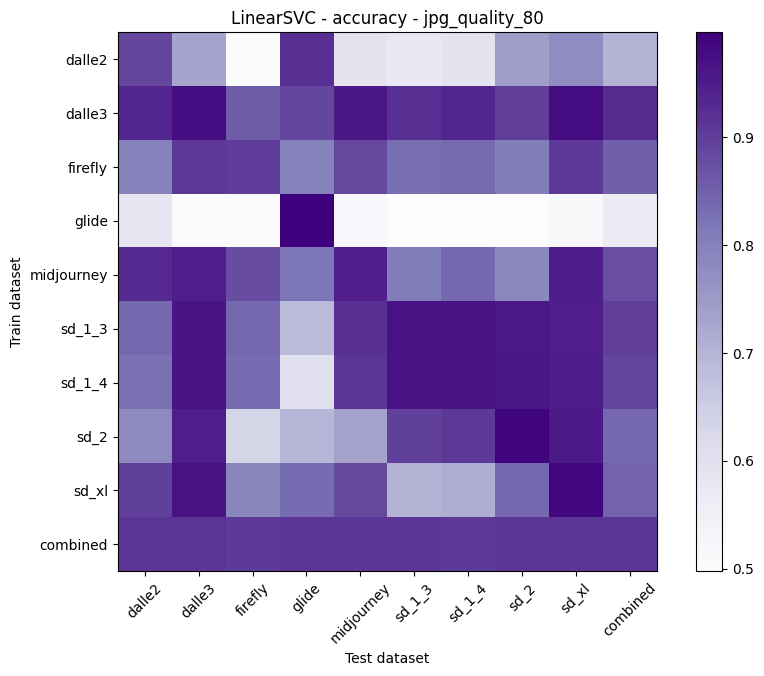

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8875  0.7300   0.5050  0.9225      0.5925  0.5725  0.5925   
dalle3         0.9350  0.9750   0.8550  0.8875      0.9600  0.9200  0.9350   
firefly        0.7975  0.9075   0.9025  0.8000      0.8850  0.8300  0.8350   
glide          0.5875  0.5000   0.5050  0.9975      0.5125  0.4975  0.4975   
midjourney     0.9300  0.9475   0.8800  0.8175      0.9475  0.8075  0.8375   
sd_1_3         0.8375  0.9625   0.8400  0.6875      0.9225  0.9650  0.9650   
sd_1_4         0.8275  0.9625   0.8325  0.6050      0.9100  0.9650  0.9650   
sd_2           0.7800  0.9475   0.6325  0.6975      0.7325  0.8975  0.9075   
sd_xl          0.8975  0.9700   0.7900  0.8325      0.8825  0.7025  0.7125   
combined       0.9100  0.9125   0.9050  0.9125      0.9100  0.9100  0.9075   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7400  0.7750  0.701944  
dalle3         0.9000  0.9775  0.927222  
firefly        0.8075  0.9075  0.852500  
glide          0.4975  0.5150  0.567778  
midjourney     0.7850  0.9500  0.878056  
sd_1_3         0.9575  0.9450  0.898056  
sd_1_4         0.9600  0.9500  0.886389  
sd_2           0.9900  0.9550  0.837778  
sd_xl          0.8375  0.9875  0.845833  
combined       0.9125  0.9125  0.910278

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8875  0.7300   0.5050  0.9225      0.5925  0.5725  0.5925   
dalle3         0.9350  0.9750   0.8550  0.8875      0.9600  0.9200  0.9350   
firefly        0.7975  0.9075   0.9025  0.8000      0.8850  0.8300  0.8350   
glide          0.5875  0.5000   0.5050  0.9975      0.5125  0.4975  0.4975   
midjourney     0.9300  0.9475   0.8800  0.8175      0.9475  0.8075  0.8375   
sd_1_3         0.8375  0.9625   0.8400  0.6875      0.9225  0.9650  0.9650   
sd_1_4         0.8275  0.9625   0.8325  0.6050      0.9100  0.9650  0.9650   
sd_2           0.7800  0.9475   0.6325  0.6975      0.7325  0.8975  0.9075   
sd_xl          0.8975  0.9700   0.7900  0.8325      0.8825  0.7025  0.7125   
combined       0.9100  0.9125   0.9050  0.9125      0.9100  0.9100  0.9075   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7400  0.7750  0.701944  
dalle3         0.9000  0.9775  0.927222  
firefly        0.8075  0.9075  0.852500  
glide          0.4975  0.5150  0.567778  
midjourney     0.7850  0.9500  0.878056  
sd_1_3         0.9575  0.9450  0.898056  
sd_1_4         0.9600  0.9500  0.886389  
sd_2           0.9900  0.9550  0.837778  
sd_xl          0.8375  0.9875  0.845833  
combined       0.9125  0.9125  0.910278









 ################ Evaluating models trained on standard and tested on jpg_quality_95. ################


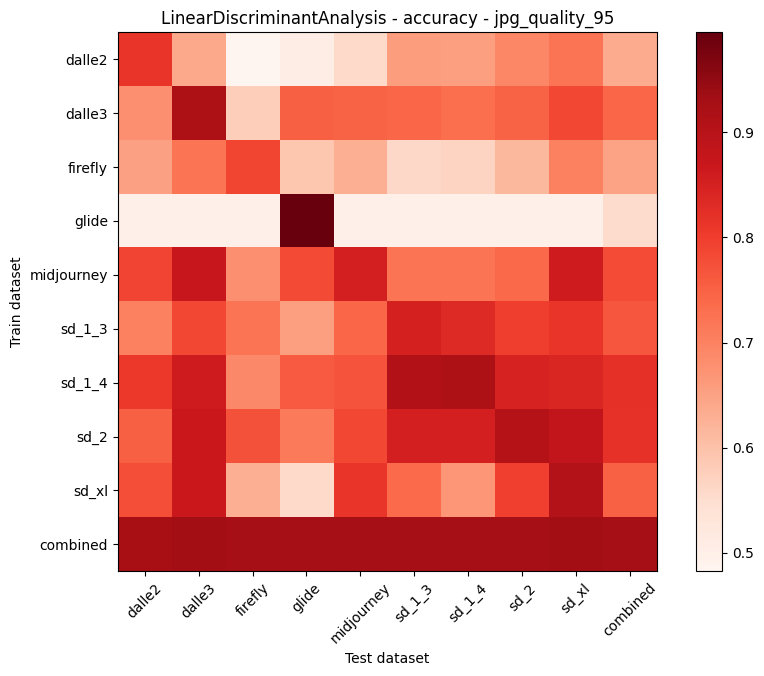

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8125  0.6400   0.4825  0.5075      0.5575  0.6575  0.6550   
dalle3         0.6800  0.9150   0.5775  0.7525      0.7475  0.7425  0.7325   
firefly        0.6525  0.7225   0.7875  0.5925      0.6300  0.5600  0.5675   
glide          0.5000  0.4975   0.4975  0.9950      0.4975  0.4975  0.4975   
midjourney     0.7900  0.8725   0.6800  0.7825      0.8525  0.7225  0.7200   
sd_1_3         0.7025  0.7850   0.7225  0.6550      0.7425  0.8500  0.8325   
sd_1_4         0.8075  0.8600   0.6900  0.7600      0.7700  0.9100  0.9150   
sd_2           0.7525  0.8675   0.7725  0.7125      0.7850  0.8525  0.8525   
sd_xl          0.7750  0.8675   0.6300  0.5575      0.8125  0.7350  0.6675   
combined       0.9250  0.9325   0.9275  0.9275      0.9300  0.9275  0.9300   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6925  0.7225  0.636389  
dalle3         0.7475  0.7850  0.742222  
firefly        0.6150  0.7025  0.647778  
glide          0.4975  0.4975  0.553056  
midjourney     0.7400  0.8600  0.780000  
sd_1_3         0.7975  0.8125  0.766667  
sd_1_4         0.8450  0.8400  0.821944  
sd_2           0.9025  0.8825  0.820000  
sd_xl          0.7950  0.9050  0.749444  
combined       0.9300  0.9325  0.929167

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.8125  0.6400   0.4825  0.5075      0.5575  0.6575  0.6550   
dalle3         0.6800  0.9150   0.5775  0.7525      0.7475  0.7425  0.7325   
firefly        0.6525  0.7225   0.7875  0.5925      0.6300  0.5600  0.5675   
glide          0.5000  0.4975   0.4975  0.9950      0.4975  0.4975  0.4975   
midjourney     0.7900  0.8725   0.6800  0.7825      0.8525  0.7225  0.7200   
sd_1_3         0.7025  0.7850   0.7225  0.6550      0.7425  0.8500  0.8325   
sd_1_4         0.8075  0.8600   0.6900  0.7600      0.7700  0.9100  0.9150   
sd_2           0.7525  0.8675   0.7725  0.7125      0.7850  0.8525  0.8525   
sd_xl          0.7750  0.8675   0.6300  0.5575      0.8125  0.7350  0.6675   
combined       0.9250  0.9325   0.9275  0.9275      0.9300  0.9275  0.9300   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6925  0.7225  0.636389  
dalle3         0.7475  0.7850  0.742222  
firefly        0.6150  0.7025  0.647778  
glide          0.4975  0.4975  0.553056  
midjourney     0.7400  0.8600  0.780000  
sd_1_3         0.7975  0.8125  0.766667  
sd_1_4         0.8450  0.8400  0.821944  
sd_2           0.9025  0.8825  0.820000  
sd_xl          0.7950  0.9050  0.749444  
combined       0.9300  0.9325  0.929167

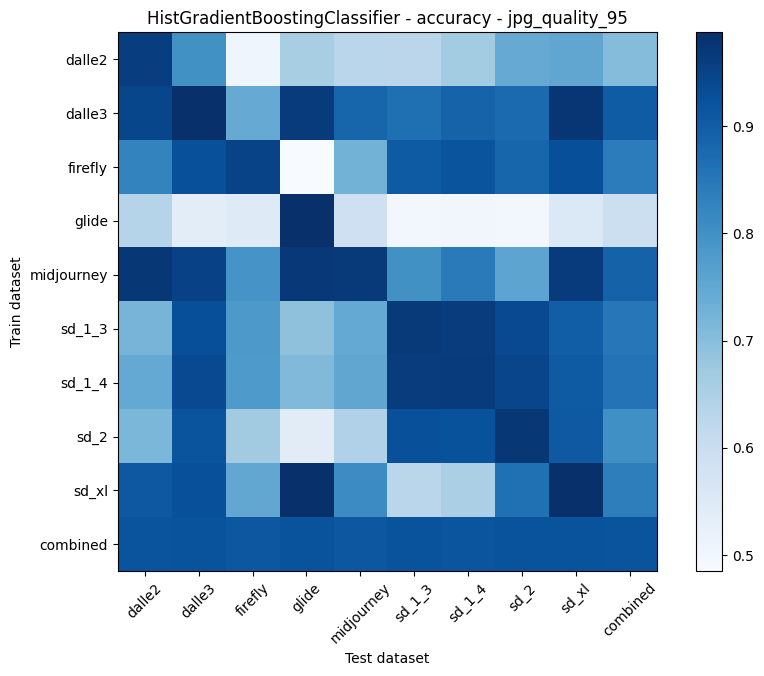

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9600  0.8000   0.5075  0.6575      0.6300  0.6275  0.6650   
dalle3         0.9425  0.9875   0.7425  0.9650      0.8850  0.8650  0.8875   
firefly        0.8250  0.9250   0.9500  0.4850      0.7250  0.9050  0.9175   
glide          0.6350  0.5375   0.5475  0.9875      0.5875  0.5000  0.5025   
midjourney     0.9725  0.9525   0.7925  0.9700      0.9675  0.8000  0.8425   
sd_1_3         0.7225  0.9275   0.7825  0.6925      0.7475  0.9675  0.9625   
sd_1_4         0.7475  0.9375   0.7800  0.7100      0.7525  0.9625  0.9650   
sd_2           0.7150  0.9175   0.6675  0.5400      0.6450  0.9250  0.9225   
sd_xl          0.9100  0.9250   0.7500  0.9875      0.8100  0.6300  0.6525   
combined       0.9175  0.9200   0.9125  0.9200      0.9125  0.9200  0.9150   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7425  0.7525  0.704722  
dalle3         0.8750  0.9750  0.902778  
firefly        0.8850  0.9275  0.838333  
glide          0.5000  0.5550  0.594722  
midjourney     0.7575  0.9650  0.891111  
sd_1_3         0.9375  0.8975  0.848611  
sd_1_4         0.9450  0.9050  0.856111  
sd_2           0.9725  0.9075  0.801389  
sd_xl          0.8625  0.9875  0.835000  
combined       0.9200  0.9200  0.917500

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9600  0.8000   0.5075  0.6575      0.6300  0.6275  0.6650   
dalle3         0.9425  0.9875   0.7425  0.9650      0.8850  0.8650  0.8875   
firefly        0.8250  0.9250   0.9500  0.4850      0.7250  0.9050  0.9175   
glide          0.6350  0.5375   0.5475  0.9875      0.5875  0.5000  0.5025   
midjourney     0.9725  0.9525   0.7925  0.9700      0.9675  0.8000  0.8425   
sd_1_3         0.7225  0.9275   0.7825  0.6925      0.7475  0.9675  0.9625   
sd_1_4         0.7475  0.9375   0.7800  0.7100      0.7525  0.9625  0.9650   
sd_2           0.7150  0.9175   0.6675  0.5400      0.6450  0.9250  0.9225   
sd_xl          0.9100  0.9250   0.7500  0.9875      0.8100  0.6300  0.6525   
combined       0.9175  0.9200   0.9125  0.9200      0.9125  0.9200  0.9150   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7425  0.7525  0.704722  
dalle3         0.8750  0.9750  0.902778  
firefly        0.8850  0.9275  0.838333  
glide          0.5000  0.5550  0.594722  
midjourney     0.7575  0.9650  0.891111  
sd_1_3         0.9375  0.8975  0.848611  
sd_1_4         0.9450  0.9050  0.856111  
sd_2           0.9725  0.9075  0.801389  
sd_xl          0.8625  0.9875  0.835000  
combined       0.9200  0.9200  0.917500

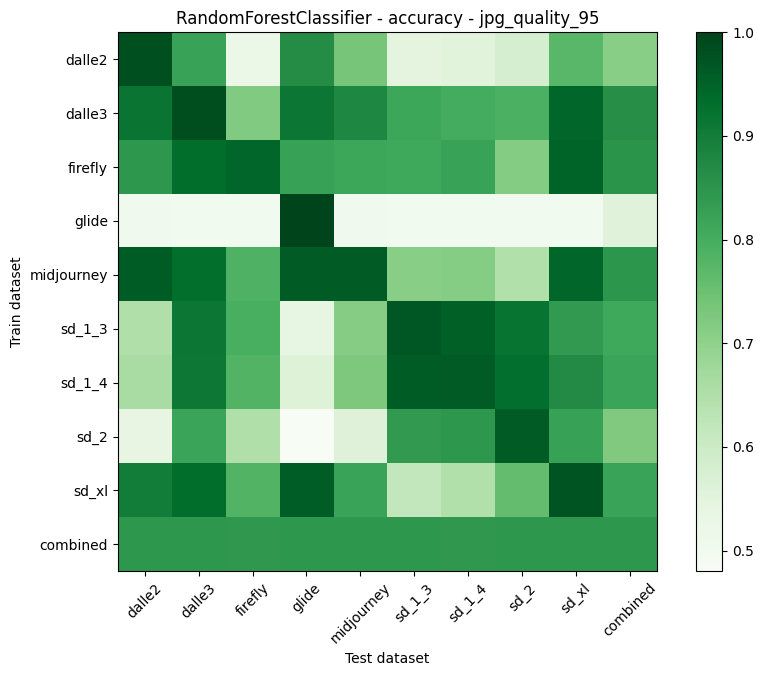

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9800  0.8225   0.5225  0.8675      0.7350  0.5450  0.5525   
dalle3         0.9150  0.9850   0.7200  0.9125      0.8775  0.8150  0.8000   
firefly        0.8450  0.9325   0.9450  0.8250      0.8150  0.8100  0.8225   
glide          0.5050  0.5000   0.5000  1.0000      0.5025  0.5000  0.5000   
midjourney     0.9600  0.9300   0.7875  0.9625      0.9625  0.7075  0.7150   
sd_1_3         0.6500  0.9125   0.7950  0.5350      0.7125  0.9675  0.9550   
sd_1_4         0.6625  0.9100   0.7825  0.5600      0.7275  0.9600  0.9625   
sd_2           0.5375  0.8175   0.6500  0.4800      0.5575  0.8375  0.8450   
sd_xl          0.9000  0.9325   0.7825  0.9575      0.8200  0.6175  0.6450   
combined       0.8450  0.8450   0.8425  0.8450      0.8450  0.8450  0.8425   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5775  0.7725  0.708333  
dalle3         0.7925  0.9450  0.862500  
firefly        0.7175  0.9475  0.851111  
glide          0.5000  0.5000  0.556389  
midjourney     0.6450  0.9450  0.846111  
sd_1_3         0.9175  0.8375  0.809167  
sd_1_4         0.9275  0.8700  0.818056  
sd_2           0.9625  0.8250  0.723611  
sd_xl          0.7600  0.9725  0.820833  
combined       0.8450  0.8450  0.844444

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9800  0.8225   0.5225  0.8675      0.7350  0.5450  0.5525   
dalle3         0.9150  0.9850   0.7200  0.9125      0.8775  0.8150  0.8000   
firefly        0.8450  0.9325   0.9450  0.8250      0.8150  0.8100  0.8225   
glide          0.5050  0.5000   0.5000  1.0000      0.5025  0.5000  0.5000   
midjourney     0.9600  0.9300   0.7875  0.9625      0.9625  0.7075  0.7150   
sd_1_3         0.6500  0.9125   0.7950  0.5350      0.7125  0.9675  0.9550   
sd_1_4         0.6625  0.9100   0.7825  0.5600      0.7275  0.9600  0.9625   
sd_2           0.5375  0.8175   0.6500  0.4800      0.5575  0.8375  0.8450   
sd_xl          0.9000  0.9325   0.7825  0.9575      0.8200  0.6175  0.6450   
combined       0.8450  0.8450   0.8425  0.8450      0.8450  0.8450  0.8425   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5775  0.7725  0.708333  
dalle3         0.7925  0.9450  0.862500  
firefly        0.7175  0.9475  0.851111  
glide          0.5000  0.5000  0.556389  
midjourney     0.6450  0.9450  0.846111  
sd_1_3         0.9175  0.8375  0.809167  
sd_1_4         0.9275  0.8700  0.818056  
sd_2           0.9625  0.8250  0.723611  
sd_xl          0.7600  0.9725  0.820833  
combined       0.8450  0.8450  0.844444

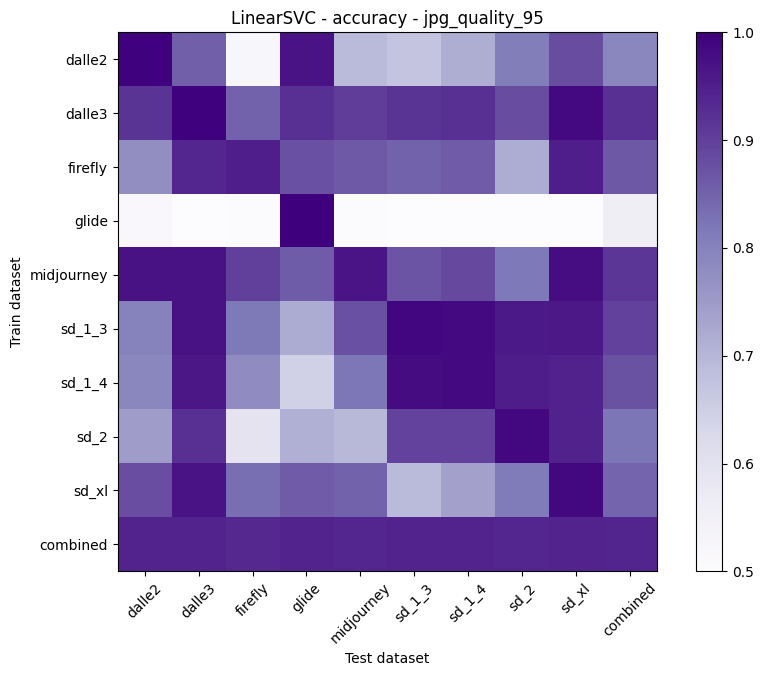

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9975  0.8550   0.5200  0.9675      0.6900  0.6700  0.7150   
dalle3         0.9175  0.9975   0.8500  0.9250      0.9025  0.9175  0.9250   
firefly        0.7750  0.9375   0.9500  0.8750      0.8625  0.8500  0.8600   
glide          0.5150  0.5000   0.5025  1.0000      0.5050  0.5000  0.5000   
midjourney     0.9700  0.9725   0.9000  0.8575      0.9650  0.8700  0.8850   
sd_1_3         0.8000  0.9725   0.8150  0.7200      0.8750  0.9875  0.9825   
sd_1_4         0.7900  0.9625   0.7775  0.6450      0.8200  0.9800  0.9825   
sd_2           0.7450  0.9225   0.5950  0.7125      0.6950  0.8950  0.8950   
sd_xl          0.8800  0.9675   0.8325  0.8600      0.8500  0.6900  0.7400   
combined       0.9425  0.9425   0.9350  0.9425      0.9375  0.9425  0.9425   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.8100  0.8825  0.789722  
dalle3         0.8825  0.9825  0.922222  
firefly        0.7175  0.9500  0.864167  
glide          0.5000  0.5000  0.558056  
midjourney     0.8175  0.9775  0.912778  
sd_1_3         0.9575  0.9600  0.896667  
sd_1_4         0.9525  0.9450  0.872778  
sd_2           0.9850  0.9450  0.821111  
sd_xl          0.8125  0.9850  0.846389  
combined       0.9375  0.9425  0.940556

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9975  0.8550   0.5200  0.9675      0.6900  0.6700  0.7150   
dalle3         0.9175  0.9975   0.8500  0.9250      0.9025  0.9175  0.9250   
firefly        0.7750  0.9375   0.9500  0.8750      0.8625  0.8500  0.8600   
glide          0.5150  0.5000   0.5025  1.0000      0.5050  0.5000  0.5000   
midjourney     0.9700  0.9725   0.9000  0.8575      0.9650  0.8700  0.8850   
sd_1_3         0.8000  0.9725   0.8150  0.7200      0.8750  0.9875  0.9825   
sd_1_4         0.7900  0.9625   0.7775  0.6450      0.8200  0.9800  0.9825   
sd_2           0.7450  0.9225   0.5950  0.7125      0.6950  0.8950  0.8950   
sd_xl          0.8800  0.9675   0.8325  0.8600      0.8500  0.6900  0.7400   
combined       0.9425  0.9425   0.9350  0.9425      0.9375  0.9425  0.9425   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.8100  0.8825  0.789722  
dalle3         0.8825  0.9825  0.922222  
firefly        0.7175  0.9500  0.864167  
glide          0.5000  0.5000  0.558056  
midjourney     0.8175  0.9775  0.912778  
sd_1_3         0.9575  0.9600  0.896667  
sd_1_4         0.9525  0.9450  0.872778  
sd_2           0.9850  0.9450  0.821111  
sd_xl          0.8125  0.9850  0.846389  
combined       0.9375  0.9425  0.940556









 ################ Evaluating models trained on standard and tested on standard. ################


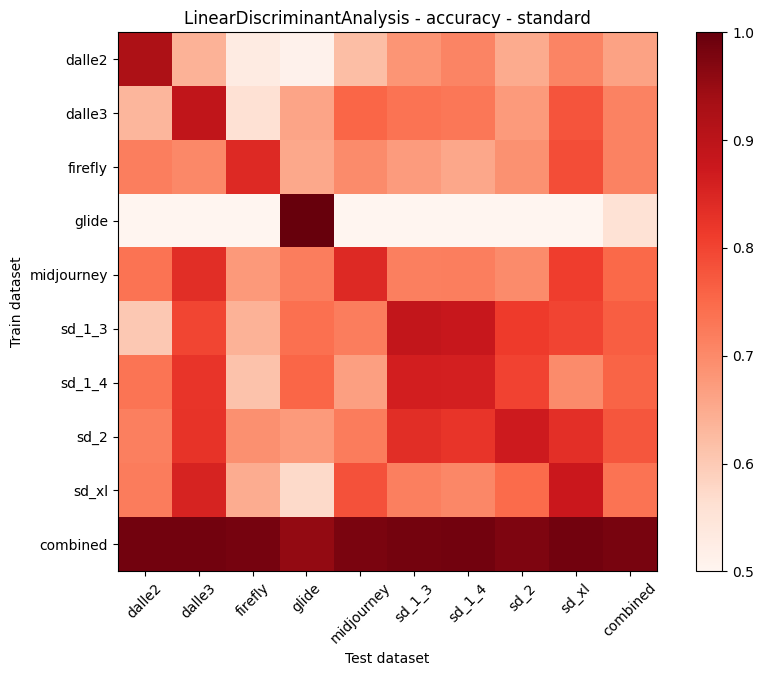

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9225  0.6375   0.5275  0.5100      0.6200  0.6825  0.7075   
dalle3         0.6325  0.8925   0.5575  0.6600      0.7550  0.7350  0.7300   
firefly        0.7175  0.7025   0.8425  0.6525      0.6975  0.6725  0.6550   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.7350  0.8350   0.6775  0.7200      0.8425  0.7150  0.7175   
sd_1_3         0.6025  0.7975   0.6375  0.7400      0.7200  0.8875  0.8800   
sd_1_4         0.7325  0.8225   0.6125  0.7550      0.6675  0.8625  0.8600   
sd_2           0.7150  0.8250   0.6900  0.6750      0.7225  0.8350  0.8225   
sd_xl          0.7225  0.8550   0.6475  0.5725      0.7825  0.7150  0.7050   
combined       0.9875  0.9875   0.9825  0.9550      0.9800  0.9850  0.9875   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6500  0.7075  0.662778  
dalle3         0.6750  0.7775  0.712778  
firefly        0.6875  0.7875  0.712778  
glide          0.5000  0.5000  0.555556  
midjourney     0.6975  0.8100  0.750000  
sd_1_3         0.8125  0.8000  0.764167  
sd_1_4         0.8025  0.6975  0.756944  
sd_2           0.8700  0.8325  0.776389  
sd_xl          0.7475  0.8750  0.735833  
combined       0.9750  0.9875  0.980833

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9225  0.6375   0.5275  0.5100      0.6200  0.6825  0.7075   
dalle3         0.6325  0.8925   0.5575  0.6600      0.7550  0.7350  0.7300   
firefly        0.7175  0.7025   0.8425  0.6525      0.6975  0.6725  0.6550   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.7350  0.8350   0.6775  0.7200      0.8425  0.7150  0.7175   
sd_1_3         0.6025  0.7975   0.6375  0.7400      0.7200  0.8875  0.8800   
sd_1_4         0.7325  0.8225   0.6125  0.7550      0.6675  0.8625  0.8600   
sd_2           0.7150  0.8250   0.6900  0.6750      0.7225  0.8350  0.8225   
sd_xl          0.7225  0.8550   0.6475  0.5725      0.7825  0.7150  0.7050   
combined       0.9875  0.9875   0.9825  0.9550      0.9800  0.9850  0.9875   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6500  0.7075  0.662778  
dalle3         0.6750  0.7775  0.712778  
firefly        0.6875  0.7875  0.712778  
glide          0.5000  0.5000  0.555556  
midjourney     0.6975  0.8100  0.750000  
sd_1_3         0.8125  0.8000  0.764167  
sd_1_4         0.8025  0.6975  0.756944  
sd_2           0.8700  0.8325  0.776389  
sd_xl          0.7475  0.8750  0.735833  
combined       0.9750  0.9875  0.980833

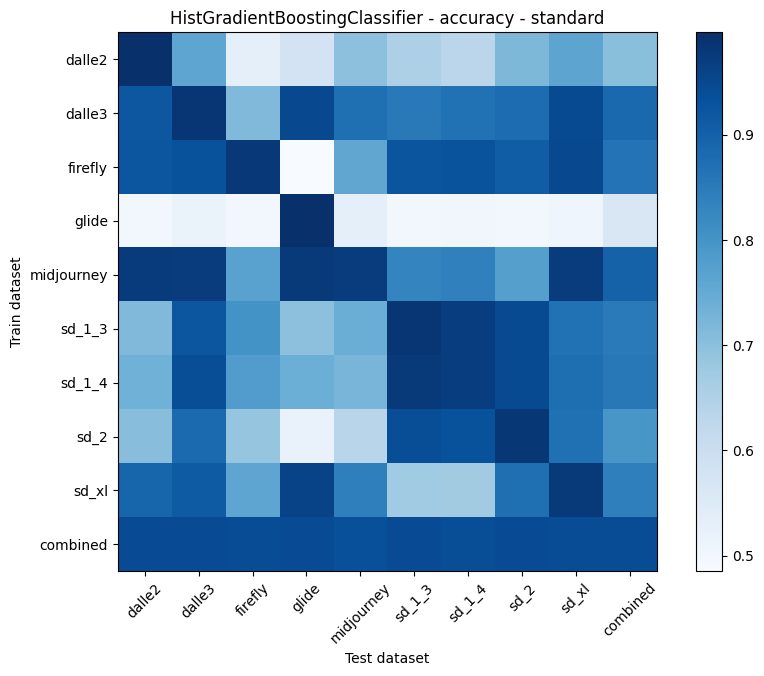

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9950  0.7600   0.5300  0.5775      0.6975  0.6525  0.6300   
dalle3         0.9200  0.9850   0.7150  0.9475      0.8725  0.8525  0.8675   
firefly        0.9225  0.9300   0.9800  0.4850      0.7575  0.9250  0.9275   
glide          0.5000  0.5175   0.5000  0.9975      0.5300  0.4975  0.5025   
midjourney     0.9750  0.9725   0.7675  0.9775      0.9725  0.8300  0.8375   
sd_1_3         0.7150  0.9225   0.8025  0.6975      0.7425  0.9850  0.9675   
sd_1_4         0.7350  0.9375   0.7800  0.7400      0.7250  0.9775  0.9675   
sd_2           0.7050  0.8825   0.6875  0.5200      0.6350  0.9375  0.9300   
sd_xl          0.8925  0.9125   0.7600  0.9575      0.8400  0.6725  0.6700   
combined       0.9425  0.9425   0.9400  0.9425      0.9350  0.9425  0.9375   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7175  0.7625  0.702500  
dalle3         0.8775  0.9450  0.886944  
firefly        0.9075  0.9475  0.864722  
glide          0.4975  0.5075  0.561111  
midjourney     0.7750  0.9725  0.897778  
sd_1_3         0.9450  0.8675  0.849444  
sd_1_4         0.9450  0.8750  0.853611  
sd_2           0.9825  0.8700  0.794444  
sd_xl          0.8725  0.9775  0.839444  
combined       0.9425  0.9400  0.940556

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9950  0.7600   0.5300  0.5775      0.6975  0.6525  0.6300   
dalle3         0.9200  0.9850   0.7150  0.9475      0.8725  0.8525  0.8675   
firefly        0.9225  0.9300   0.9800  0.4850      0.7575  0.9250  0.9275   
glide          0.5000  0.5175   0.5000  0.9975      0.5300  0.4975  0.5025   
midjourney     0.9750  0.9725   0.7675  0.9775      0.9725  0.8300  0.8375   
sd_1_3         0.7150  0.9225   0.8025  0.6975      0.7425  0.9850  0.9675   
sd_1_4         0.7350  0.9375   0.7800  0.7400      0.7250  0.9775  0.9675   
sd_2           0.7050  0.8825   0.6875  0.5200      0.6350  0.9375  0.9300   
sd_xl          0.8925  0.9125   0.7600  0.9575      0.8400  0.6725  0.6700   
combined       0.9425  0.9425   0.9400  0.9425      0.9350  0.9425  0.9375   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7175  0.7625  0.702500  
dalle3         0.8775  0.9450  0.886944  
firefly        0.9075  0.9475  0.864722  
glide          0.4975  0.5075  0.561111  
midjourney     0.7750  0.9725  0.897778  
sd_1_3         0.9450  0.8675  0.849444  
sd_1_4         0.9450  0.8750  0.853611  
sd_2           0.9825  0.8700  0.794444  
sd_xl          0.8725  0.9775  0.839444  
combined       0.9425  0.9400  0.940556

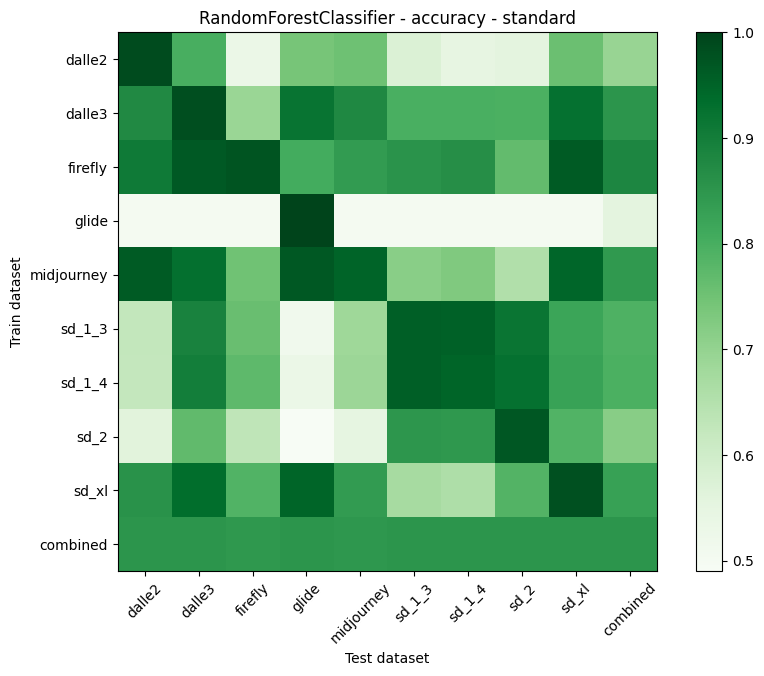

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.8000   0.5300  0.7400      0.7525  0.5750  0.5475   
dalle3         0.8750  0.9825   0.6900  0.9200      0.8775  0.7975  0.7975   
firefly        0.9075  0.9650   0.9725  0.8050      0.8400  0.8550  0.8650   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9625  0.9275   0.7500  0.9675      0.9500  0.7150  0.7275   
sd_1_3         0.6250  0.8900   0.7575  0.5125      0.6850  0.9575  0.9525   
sd_1_4         0.6225  0.9000   0.7725  0.5325      0.6875  0.9575  0.9475   
sd_2           0.5600  0.7675   0.6300  0.4900      0.5500  0.8500  0.8450   
sd_xl          0.8575  0.9325   0.7875  0.9475      0.8400  0.6700  0.6575   
combined       0.8525  0.8525   0.8450  0.8525      0.8475  0.8525  0.8525   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5550  0.7550  0.693611  
dalle3         0.7950  0.9250  0.851111  
firefly        0.7650  0.9625  0.881944  
glide          0.5000  0.5000  0.555556  
midjourney     0.6550  0.9450  0.844444  
sd_1_3         0.9175  0.8200  0.790833  
sd_1_4         0.9250  0.8250  0.796667  
sd_2           0.9700  0.7875  0.716667  
sd_xl          0.7850  0.9800  0.828611  
combined       0.8525  0.8525  0.851111

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.8000   0.5300  0.7400      0.7525  0.5750  0.5475   
dalle3         0.8750  0.9825   0.6900  0.9200      0.8775  0.7975  0.7975   
firefly        0.9075  0.9650   0.9725  0.8050      0.8400  0.8550  0.8650   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9625  0.9275   0.7500  0.9675      0.9500  0.7150  0.7275   
sd_1_3         0.6250  0.8900   0.7575  0.5125      0.6850  0.9575  0.9525   
sd_1_4         0.6225  0.9000   0.7725  0.5325      0.6875  0.9575  0.9475   
sd_2           0.5600  0.7675   0.6300  0.4900      0.5500  0.8500  0.8450   
sd_xl          0.8575  0.9325   0.7875  0.9475      0.8400  0.6700  0.6575   
combined       0.8525  0.8525   0.8450  0.8525      0.8475  0.8525  0.8525   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5550  0.7550  0.693611  
dalle3         0.7950  0.9250  0.851111  
firefly        0.7650  0.9625  0.881944  
glide          0.5000  0.5000  0.555556  
midjourney     0.6550  0.9450  0.844444  
sd_1_3         0.9175  0.8200  0.790833  
sd_1_4         0.9250  0.8250  0.796667  
sd_2           0.9700  0.7875  0.716667  
sd_xl          0.7850  0.9800  0.828611  
combined       0.8525  0.8525  0.851111

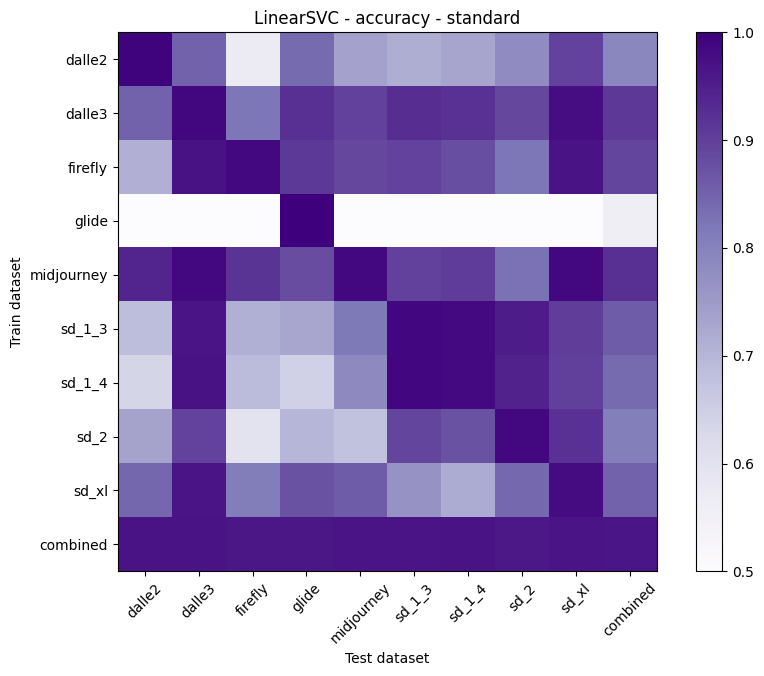

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8500   0.5700  0.8375      0.7375  0.7150  0.7300   
dalle3         0.8500  0.9900   0.8200  0.9225      0.8975  0.9275  0.9200   
firefly        0.7100  0.9725   0.9850  0.9100      0.8875  0.8950  0.8775   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9400  0.9850   0.9175  0.8825      0.9850  0.8975  0.9050   
sd_1_3         0.6850  0.9650   0.7125  0.7275      0.8150  0.9875  0.9825   
sd_1_4         0.6350  0.9700   0.6875  0.6450      0.7825  0.9875  0.9825   
sd_2           0.7350  0.8950   0.5975  0.7000      0.6775  0.8925  0.8725   
sd_xl          0.8425  0.9650   0.8100  0.8725      0.8575  0.7650  0.7200   
combined       0.9675  0.9675   0.9625  0.9625      0.9650  0.9650  0.9675   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7775  0.8950  0.789444  
dalle3         0.8875  0.9775  0.910278  
firefly        0.8200  0.9675  0.891667  
glide          0.5000  0.5000  0.555556  
midjourney     0.8275  0.9850  0.925000  
sd_1_3         0.9550  0.9025  0.859167  
sd_1_4         0.9450  0.9000  0.837222  
sd_2           0.9850  0.9200  0.808333  
sd_xl          0.8400  0.9800  0.850278  
combined       0.9600  0.9650  0.964722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8500   0.5700  0.8375      0.7375  0.7150  0.7300   
dalle3         0.8500  0.9900   0.8200  0.9225      0.8975  0.9275  0.9200   
firefly        0.7100  0.9725   0.9850  0.9100      0.8875  0.8950  0.8775   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9400  0.9850   0.9175  0.8825      0.9850  0.8975  0.9050   
sd_1_3         0.6850  0.9650   0.7125  0.7275      0.8150  0.9875  0.9825   
sd_1_4         0.6350  0.9700   0.6875  0.6450      0.7825  0.9875  0.9825   
sd_2           0.7350  0.8950   0.5975  0.7000      0.6775  0.8925  0.8725   
sd_xl          0.8425  0.9650   0.8100  0.8725      0.8575  0.7650  0.7200   
combined       0.9675  0.9675   0.9625  0.9625      0.9650  0.9650  0.9675   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7775  0.8950  0.789444  
dalle3         0.8875  0.9775  0.910278  
firefly        0.8200  0.9675  0.891667  
glide          0.5000  0.5000  0.555556  
midjourney     0.8275  0.9850  0.925000  
sd_1_3         0.9550  0.9025  0.859167  
sd_1_4         0.9450  0.9000  0.837222  
sd_2           0.9850  0.9200  0.808333  
sd_xl          0.8400  0.9800  0.850278  
combined       0.9600  0.9650  0.964722

In [15]:
print("########################### Accuracy ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "accuracy"
    evaluation_data_name = "Test"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

### MCC - Test

########################### MCC ###########################








 ################ Evaluating models trained on standard and tested on jpg_quality_50. ################


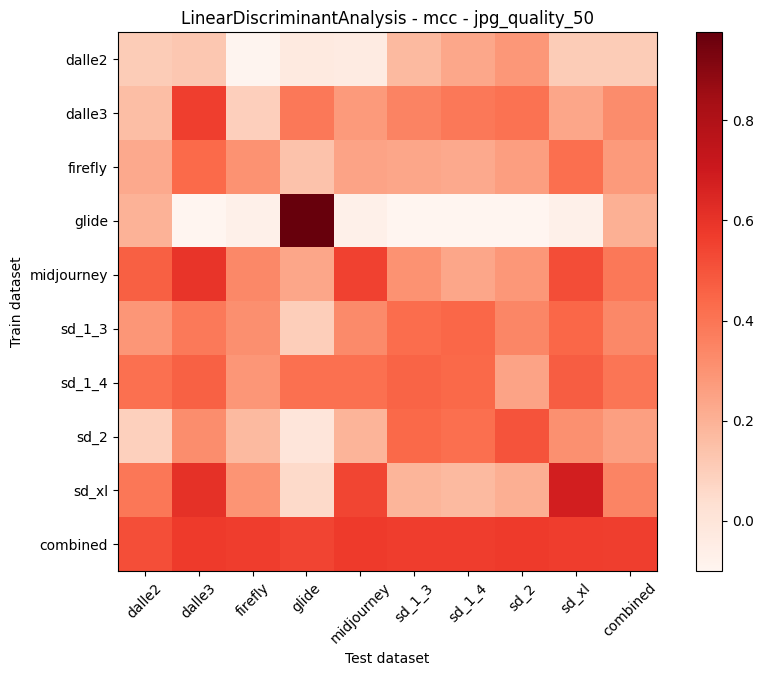

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.107764  0.125723 -0.092706 -0.031346   -0.039559  0.171205   
dalle3         0.159372  0.560000  0.096592  0.391034    0.277343  0.353261   
firefly        0.226503  0.435763  0.300182  0.140063    0.247264  0.236858   
glide          0.195965 -0.100504 -0.067505  0.975110   -0.067505 -0.100504   
midjourney     0.464575  0.594659  0.335038  0.235854    0.553562  0.300060   
sd_1_3         0.286494  0.385548  0.311805  0.098248    0.331278  0.428856   
sd_1_4         0.412984  0.461323  0.290000  0.412984    0.412984  0.450444   
sd_2           0.091494  0.319639  0.170641  0.000000    0.192419  0.437507   
sd_xl          0.395090  0.605917  0.295567  0.057735    0.540027  0.188776   
combined       0.513944  0.573501  0.565803  0.543159    0.573501  0.565803   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.234417  0.283854  0.107764  0.109114  
dalle3         0.391034  0.409955  0.238798  0.321219  
firefly        0.226503  0.262975  0.417961  0.274700  
glide         -0.100504 -0.100504 -0.067505  0.203170  
midjourney     0.235854  0.285175  0.519462  0.386958  
sd_1_3         0.443865  0.344512  0.443865  0.335666  
sd_1_4         0.439646  0.245248  0.472288  0.398360  
sd_2           0.416705  0.503415  0.307435  0.260025  
sd_xl          0.168720  0.208586  0.680336  0.348806  
combined       0.565803  0.573501  0.565803  0.559869

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.107764  0.125723 -0.092706 -0.031346   -0.039559  0.171205   
dalle3         0.159372  0.560000  0.096592  0.391034    0.277343  0.353261   
firefly        0.226503  0.435763  0.300182  0.140063    0.247264  0.236858   
glide          0.195965 -0.100504 -0.067505  0.975110   -0.067505 -0.100504   
midjourney     0.464575  0.594659  0.335038  0.235854    0.553562  0.300060   
sd_1_3         0.286494  0.385548  0.311805  0.098248    0.331278  0.428856   
sd_1_4         0.412984  0.461323  0.290000  0.412984    0.412984  0.450444   
sd_2           0.091494  0.319639  0.170641  0.000000    0.192419  0.437507   
sd_xl          0.395090  0.605917  0.295567  0.057735    0.540027  0.188776   
combined       0.513944  0.573501  0.565803  0.543159    0.573501  0.565803   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.234417  0.283854  0.107764  0.096346  
dalle3         0.391034  0.409955  0.238798  0.319710  
firefly        0.226503  0.262975  0.417961  0.277119  
glide         -0.100504 -0.100504 -0.067505  0.062949  
midjourney     0.235854  0.285175  0.519462  0.391582  
sd_1_3         0.443865  0.344512  0.443865  0.341608  
sd_1_4         0.439646  0.245248  0.472288  0.399767  
sd_2           0.416705  0.503415  0.307435  0.271028  
sd_xl          0.168720  0.208586  0.680336  0.348973  
combined       0.565803  0.573501  0.565803  0.560091

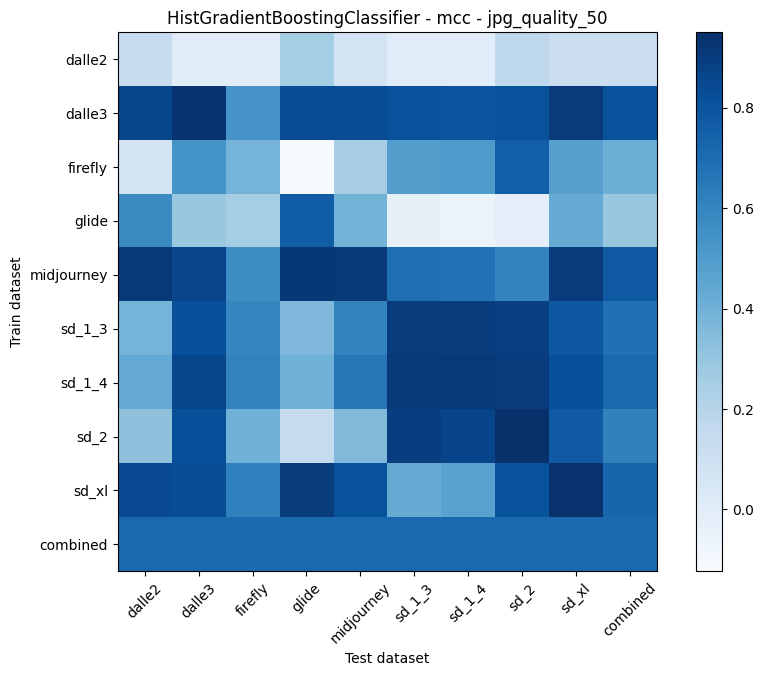

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.133460  0.000000  0.000000  0.258199    0.070888  0.000000   
dalle3         0.855011  0.927613  0.533761  0.835094    0.830166  0.810649   
firefly        0.072357  0.536535  0.386033 -0.123404    0.244656  0.487603   
glide          0.573480  0.289467  0.255702  0.758158    0.390959 -0.034415   
midjourney     0.906918  0.860172  0.561767  0.917584    0.912238  0.693380   
sd_1_3         0.387567  0.820000  0.597462  0.360392    0.606253  0.897528   
sd_1_4         0.438679  0.855267  0.607763  0.398966    0.660793  0.907556   
sd_2           0.317763  0.819530  0.395617  0.140248    0.355294  0.890401   
sd_xl          0.841516  0.832041  0.616379  0.900000    0.808657  0.427724   
combined       0.713746  0.713746  0.707186  0.713746    0.713746  0.713746   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.000000  0.168160  0.112509  0.118678  
dalle3         0.796205  0.810649  0.901127  0.807425  
firefly        0.508068  0.755259  0.479374  0.411683  
glide         -0.052136 -0.017046  0.430194  0.289467  
midjourney     0.675423  0.605001  0.901624  0.775058  
sd_1_3         0.897528  0.886876  0.785481  0.684738  
sd_1_4         0.912926  0.896897  0.820041  0.713124  
sd_2           0.866311  0.950428  0.774359  0.612613  
sd_xl          0.470333  0.804030  0.940753  0.730977  
combined       0.713746  0.713746  0.713746  0.713015

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.133460  0.000000  0.000000  0.258199    0.070888  0.000000   
dalle3         0.855011  0.927613  0.533761  0.835094    0.830166  0.810649   
firefly        0.072357  0.536535  0.386033 -0.123404    0.244656  0.487603   
glide          0.573480  0.289467  0.255702  0.758158    0.390959 -0.034415   
midjourney     0.906918  0.860172  0.561767  0.917584    0.912238  0.693380   
sd_1_3         0.387567  0.820000  0.597462  0.360392    0.606253  0.897528   
sd_1_4         0.438679  0.855267  0.607763  0.398966    0.660793  0.907556   
sd_2           0.317763  0.819530  0.395617  0.140248    0.355294  0.890401   
sd_xl          0.841516  0.832041  0.616379  0.900000    0.808657  0.427724   
combined       0.713746  0.713746  0.707186  0.713746    0.713746  0.713746   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.000000  0.168160  0.112509  0.082580  
dalle3         0.796205  0.810649  0.901127  0.811142  
firefly        0.508068  0.755259  0.479374  0.371831  
glide         -0.052136 -0.017046  0.430194  0.288262  
midjourney     0.675423  0.605001  0.901624  0.781567  
sd_1_3         0.897528  0.886876  0.785481  0.693232  
sd_1_4         0.912926  0.896897  0.820041  0.722099  
sd_2           0.866311  0.950428  0.774359  0.612217  
sd_xl          0.470333  0.804030  0.940753  0.737937  
combined       0.713746  0.713746  0.713746  0.713017

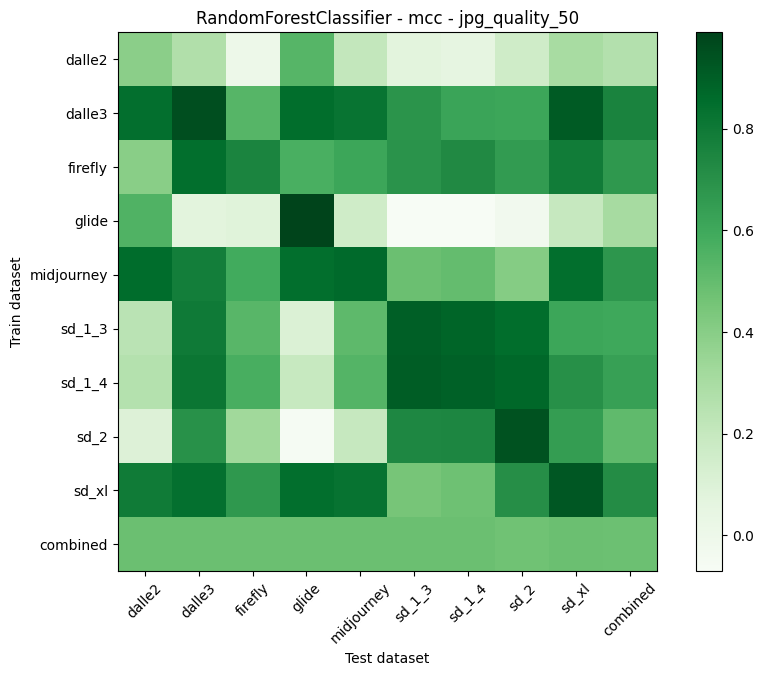

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.390817  0.269047  0.000000  0.534952    0.210681  0.070888   
dalle3         0.843423  0.955299  0.537497  0.852733    0.820443  0.685458   
firefly        0.393607  0.845095  0.749976  0.569970    0.612758  0.691291   
glide          0.554256  0.071429  0.084287  0.990050    0.161109 -0.070888   
midjourney     0.857275  0.781408  0.590405  0.846114    0.862899  0.480898   
sd_1_3         0.237186  0.796205  0.533761  0.104924    0.516667  0.901127   
sd_1_4         0.260290  0.815255  0.574697  0.190353    0.540265  0.906918   
sd_2           0.097983  0.698733  0.323293 -0.054413    0.195724  0.737734   
sd_xl          0.792540  0.840378  0.670685  0.845264    0.825837  0.448871   
combined       0.480384  0.480384  0.480384  0.480384    0.480384  0.480384   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.050063  0.160128  0.299864  0.262457  
dalle3         0.619162  0.610964  0.915103  0.754213  
firefly        0.731698  0.656074  0.787217  0.668237  
glide         -0.070888 -0.028976  0.197386  0.302770  
midjourney     0.498974  0.408610  0.846114  0.676763  
sd_1_3         0.880396  0.850000  0.611014  0.603811  
sd_1_4         0.891115  0.870392  0.702423  0.634596  
sd_2           0.742121  0.940423  0.647840  0.510032  
sd_xl          0.474579  0.710340  0.926402  0.720261  
combined       0.480384  0.471577  0.480384  0.479400

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.390817  0.269047  0.000000  0.534952    0.210681  0.070888   
dalle3         0.843423  0.955299  0.537497  0.852733    0.820443  0.685458   
firefly        0.393607  0.845095  0.749976  0.569970    0.612758  0.691291   
glide          0.554256  0.071429  0.084287  0.990050    0.161109 -0.070888   
midjourney     0.857275  0.781408  0.590405  0.846114    0.862899  0.480898   
sd_1_3         0.237186  0.796205  0.533761  0.104924    0.516667  0.901127   
sd_1_4         0.260290  0.815255  0.574697  0.190353    0.540265  0.906918   
sd_2           0.097983  0.698733  0.323293 -0.054413    0.195724  0.737734   
sd_xl          0.792540  0.840378  0.670685  0.845264    0.825837  0.448871   
combined       0.480384  0.480384  0.480384  0.480384    0.480384  0.480384   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.050063  0.160128  0.299864  0.220715  
dalle3         0.619162  0.610964  0.915103  0.760009  
firefly        0.731698  0.656074  0.787217  0.670854  
glide         -0.070888 -0.028976  0.197386  0.209751  
midjourney     0.498974  0.408610  0.846114  0.685855  
sd_1_3         0.880396  0.850000  0.611014  0.603476  
sd_1_4         0.891115  0.870392  0.702423  0.639079  
sd_2           0.742121  0.940423  0.647840  0.481049  
sd_xl          0.474579  0.710340  0.926402  0.726100  
combined       0.480384  0.471577  0.480384  0.479406

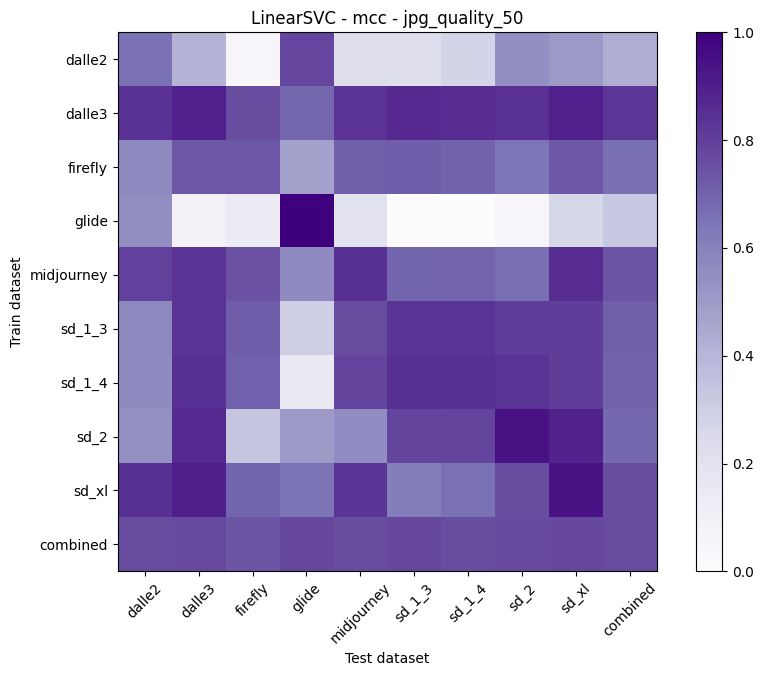

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.654654  0.407653  0.050063  0.778733    0.229416  0.223313   
dalle3         0.842066  0.890911  0.760038  0.687488    0.836770  0.863504   
firefly        0.567309  0.727370  0.733799  0.476342    0.708333  0.714638   
glide          0.550392  0.086929  0.142857  1.000000    0.197386  0.000000   
midjourney     0.793980  0.838256  0.746129  0.560128    0.849613  0.690000   
sd_1_3         0.571402  0.833616  0.711746  0.300123    0.765532  0.833616   
sd_1_4         0.559387  0.845215  0.705220  0.155658    0.783929  0.850963   
sd_2           0.542739  0.866311  0.332060  0.497419    0.550950  0.783278   
sd_xl          0.845518  0.900180  0.689647  0.646368    0.831039  0.620744   
combined       0.762279  0.768419  0.738083  0.774597    0.762279  0.774597   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.274352  0.546536  0.500000  0.432822  
dalle3         0.852733  0.842066  0.890911  0.827997  
firefly        0.695843  0.641448  0.727370  0.662602  
glide          0.000000  0.050063  0.263664  0.326084  
midjourney     0.695009  0.665208  0.855337  0.740350  
sd_1_3         0.833616  0.810441  0.804726  0.709993  
sd_1_4         0.850963  0.833812  0.805823  0.701267  
sd_2           0.787758  0.945295  0.890401  0.682099  
sd_xl          0.659269  0.765532  0.936417  0.761981  
combined       0.756176  0.768419  0.774597  0.764322

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.654654  0.407653  0.050063  0.778733    0.229416  0.223313   
dalle3         0.842066  0.890911  0.760038  0.687488    0.836770  0.863504   
firefly        0.567309  0.727370  0.733799  0.476342    0.708333  0.714638   
glide          0.550392  0.086929  0.142857  1.000000    0.197386  0.000000   
midjourney     0.793980  0.838256  0.746129  0.560128    0.849613  0.690000   
sd_1_3         0.571402  0.833616  0.711746  0.300123    0.765532  0.833616   
sd_1_4         0.559387  0.845215  0.705220  0.155658    0.783929  0.850963   
sd_2           0.542739  0.866311  0.332060  0.497419    0.550950  0.783278   
sd_xl          0.845518  0.900180  0.689647  0.646368    0.831039  0.620744   
combined       0.762279  0.768419  0.738083  0.774597    0.762279  0.774597   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.274352  0.546536  0.500000  0.407191  
dalle3         0.852733  0.842066  0.890911  0.829610  
firefly        0.695843  0.641448  0.727370  0.665828  
glide          0.000000  0.050063  0.263664  0.254588  
midjourney     0.695009  0.665208  0.855337  0.743740  
sd_1_3         0.833616  0.810441  0.804726  0.718313  
sd_1_4         0.850963  0.833812  0.805823  0.710108  
sd_2           0.787758  0.945295  0.890401  0.688468  
sd_xl          0.659269  0.765532  0.936417  0.766079  
combined       0.756176  0.768419  0.774597  0.764383









 ################ Evaluating models trained on standard and tested on jpg_quality_70. ################


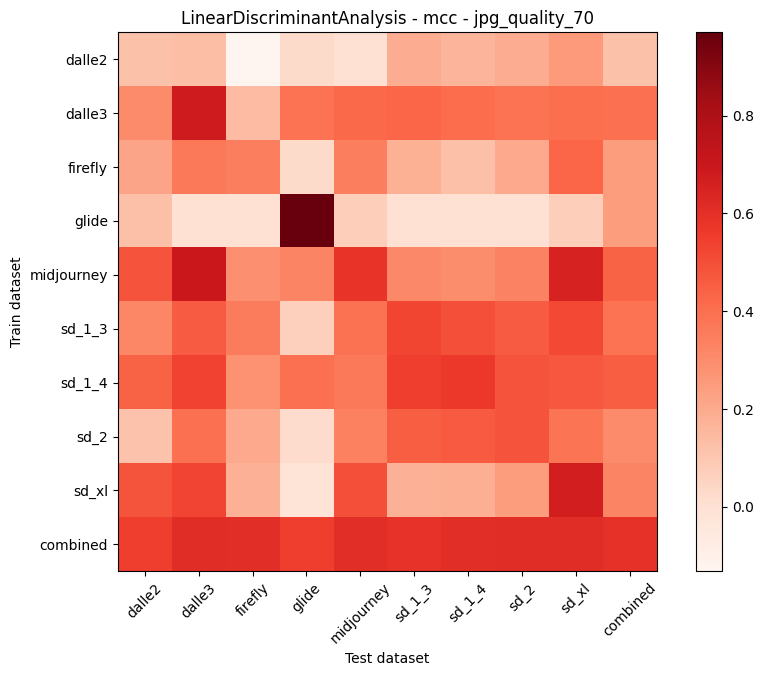

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.120949  0.133808 -0.131590  0.025886    0.000000  0.193421   
dalle3         0.306120  0.680306  0.141510  0.385417    0.422344  0.431570   
firefly        0.221108  0.370839  0.343022  0.025114    0.348539  0.180325   
glide          0.123404  0.000000  0.000000  0.970437    0.070888  0.000000   
midjourney     0.485297  0.698733  0.293785  0.327569    0.584964  0.313083   
sd_1_3         0.319005  0.459112  0.355209  0.065361    0.392792  0.523655   
sd_1_4         0.439019  0.533060  0.280056  0.396795    0.365774  0.544600   
sd_2           0.116228  0.397309  0.200132  0.020025    0.341607  0.449785   
sd_xl          0.480096  0.530239  0.175119 -0.017499    0.495006  0.175119   
combined       0.548194  0.612022  0.604684  0.548194    0.604684  0.590202   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.164491  0.187758  0.252423  0.119497  
dalle3         0.408505  0.385417  0.403890  0.396710  
firefly        0.125002  0.200643  0.428410  0.245782  
glide          0.000000  0.000000  0.070888  0.245093  
midjourney     0.298609  0.332402  0.651874  0.437258  
sd_1_3         0.494326  0.459112  0.516219  0.389249  
sd_1_4         0.568038  0.487970  0.471462  0.451550  
sd_2           0.463412  0.484278  0.378384  0.306742  
sd_xl          0.185045  0.243713  0.668614  0.326376  
combined       0.604684  0.612022  0.612022  0.592598

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.120949  0.133808 -0.131590  0.025886    0.000000  0.193421   
dalle3         0.306120  0.680306  0.141510  0.385417    0.422344  0.431570   
firefly        0.221108  0.370839  0.343022  0.025114    0.348539  0.180325   
glide          0.123404  0.000000  0.000000  0.970437    0.070888  0.000000   
midjourney     0.485297  0.698733  0.293785  0.327569    0.584964  0.313083   
sd_1_3         0.319005  0.459112  0.355209  0.065361    0.392792  0.523655   
sd_1_4         0.439019  0.533060  0.280056  0.396795    0.365774  0.544600   
sd_2           0.116228  0.397309  0.200132  0.020025    0.341607  0.449785   
sd_xl          0.480096  0.530239  0.175119 -0.017499    0.495006  0.175119   
combined       0.548194  0.612022  0.604684  0.548194    0.604684  0.590202   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.164491  0.187758  0.252423  0.105238  
dalle3         0.408505  0.385417  0.403890  0.396120  
firefly        0.125002  0.200643  0.428410  0.249222  
glide          0.000000  0.000000  0.070888  0.137291  
midjourney     0.298609  0.332402  0.651874  0.442924  
sd_1_3         0.494326  0.459112  0.516219  0.398310  
sd_1_4         0.568038  0.487970  0.471462  0.454086  
sd_2           0.463412  0.484278  0.378384  0.316796  
sd_xl          0.185045  0.243713  0.668614  0.326161  
combined       0.604684  0.612022  0.612022  0.592967

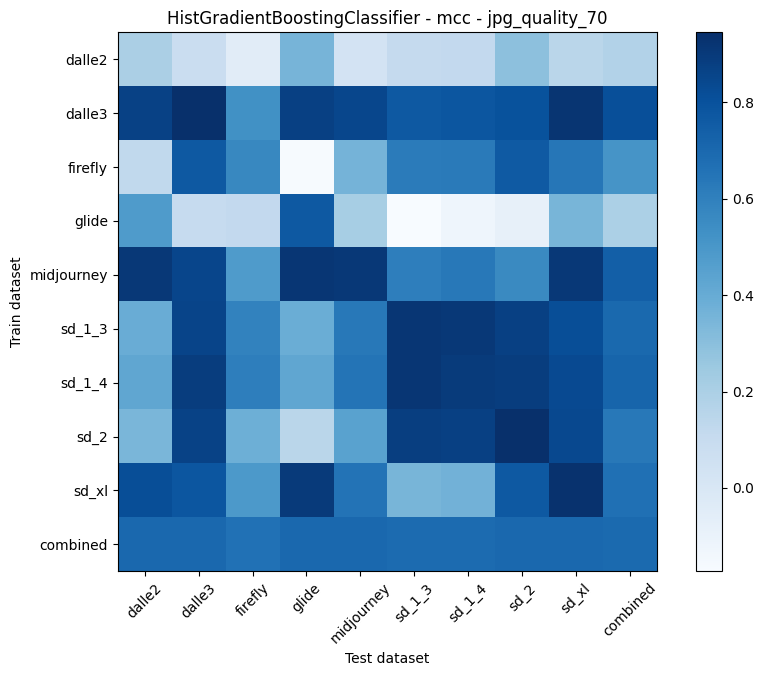

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.199807  0.082269 -0.050063  0.353888    0.028976  0.107143   
dalle3         0.870044  0.941697  0.527931  0.875011    0.845518  0.770109   
firefly        0.122300  0.766505  0.568089 -0.168160    0.357939  0.618488   
glide          0.480024  0.103409  0.118921  0.770471    0.213870 -0.172938   
midjourney     0.907556  0.850170  0.482167  0.918323    0.907556  0.607763   
sd_1_3         0.390812  0.855011  0.589446  0.386342    0.632719  0.916939   
sd_1_4         0.423580  0.885897  0.605001  0.423580    0.648779  0.917584   
sd_2           0.346083  0.866311  0.377902  0.147442    0.447261  0.880705   
sd_xl          0.815826  0.782508  0.489107  0.900721    0.656074  0.348345   
combined       0.701810  0.701810  0.662644  0.701810    0.701810  0.688573   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.118002  0.291967  0.146553  0.176125  
dalle3         0.779308  0.797888  0.920737  0.809893  
firefly        0.622712  0.761975  0.639663  0.509976  
glide         -0.123854 -0.084491  0.348685  0.195350  
midjourney     0.634140  0.559918  0.907556  0.744056  
sd_1_3         0.906372  0.875274  0.815500  0.699005  
sd_1_4         0.896357  0.885897  0.835010  0.715569  
sd_2           0.871090  0.945295  0.838033  0.633761  
sd_xl          0.366652  0.768476  0.932287  0.666286  
combined       0.688573  0.701810  0.701810  0.694433

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.199807  0.082269 -0.050063  0.353888    0.028976  0.107143   
dalle3         0.870044  0.941697  0.527931  0.875011    0.845518  0.770109   
firefly        0.122300  0.766505  0.568089 -0.168160    0.357939  0.618488   
glide          0.480024  0.103409  0.118921  0.770471    0.213870 -0.172938   
midjourney     0.907556  0.850170  0.482167  0.918323    0.907556  0.607763   
sd_1_3         0.390812  0.855011  0.589446  0.386342    0.632719  0.916939   
sd_1_4         0.423580  0.885897  0.605001  0.423580    0.648779  0.917584   
sd_2           0.346083  0.866311  0.377902  0.147442    0.447261  0.880705   
sd_xl          0.815826  0.782508  0.489107  0.900721    0.656074  0.348345   
combined       0.701810  0.701810  0.662644  0.701810    0.701810  0.688573   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.118002  0.291967  0.146553  0.142060  
dalle3         0.779308  0.797888  0.920737  0.814249  
firefly        0.622712  0.761975  0.639663  0.476612  
glide         -0.123854 -0.084491  0.348685  0.183788  
midjourney     0.634140  0.559918  0.907556  0.752794  
sd_1_3         0.906372  0.875274  0.815500  0.707601  
sd_1_4         0.896357  0.885897  0.835010  0.724632  
sd_2           0.871090  0.945295  0.838033  0.635569  
sd_xl          0.366652  0.768476  0.932287  0.673333  
combined       0.688573  0.701810  0.701810  0.694517

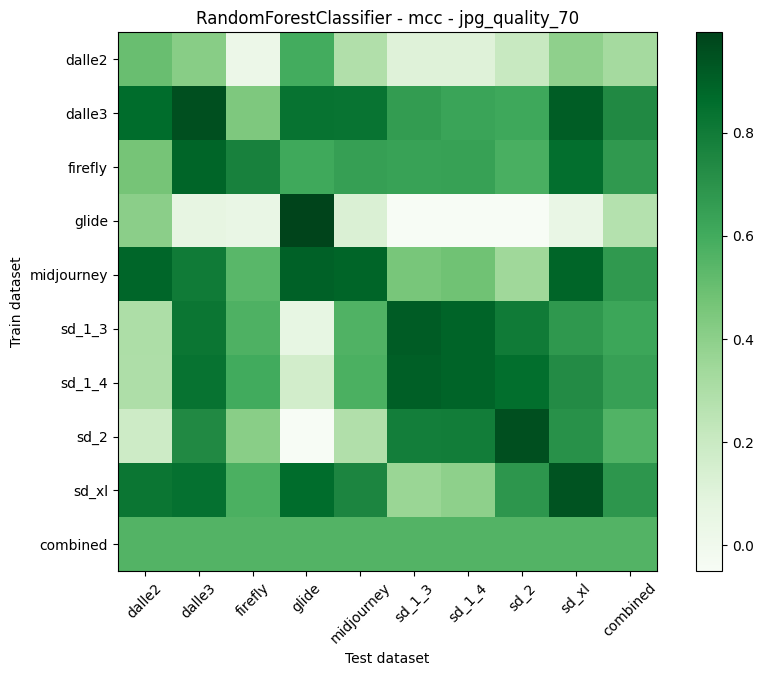

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.499363  0.414474  0.028976  0.596901    0.286860  0.107143   
dalle3         0.861077  0.955968  0.439605  0.832669    0.827997  0.660465   
firefly        0.466978  0.886876  0.770964  0.610658    0.650627  0.637233   
glide          0.406081  0.067505  0.050252  0.995012    0.128103 -0.050063   
midjourney     0.882164  0.800040  0.538986  0.898251    0.887500  0.456118   
sd_1_3         0.298024  0.820369  0.567981  0.060401    0.563697  0.916939   
sd_1_4         0.293142  0.835094  0.602372  0.163543    0.576557  0.906372   
sd_2           0.184302  0.738083  0.407850 -0.050572    0.287253  0.790180   
sd_xl          0.822637  0.841516  0.574646  0.860689    0.754114  0.361433   
combined       0.554247  0.554247  0.554247  0.554247    0.554247  0.554247   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.107143  0.206474  0.393349  0.328827  
dalle3         0.631090  0.614419  0.910000  0.741633  
firefly        0.641689  0.579945  0.850383  0.673135  
glide         -0.050063 -0.050063  0.050252  0.275868  
midjourney     0.482340  0.344148  0.887500  0.676157  
sd_1_3         0.890713  0.801002  0.676681  0.623053  
sd_1_4         0.890713  0.855011  0.730731  0.646796  
sd_2           0.794603  0.955107  0.708420  0.558594  
sd_xl          0.397236  0.688457  0.945958  0.687979  
combined       0.554247  0.554247  0.554247  0.554247

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.499363  0.414474  0.028976  0.596901    0.286860  0.107143   
dalle3         0.861077  0.955968  0.439605  0.832669    0.827997  0.660465   
firefly        0.466978  0.886876  0.770964  0.610658    0.650627  0.637233   
glide          0.406081  0.067505  0.050252  0.995012    0.128103 -0.050063   
midjourney     0.882164  0.800040  0.538986  0.898251    0.887500  0.456118   
sd_1_3         0.298024  0.820369  0.567981  0.060401    0.563697  0.916939   
sd_1_4         0.293142  0.835094  0.602372  0.163543    0.576557  0.906372   
sd_2           0.184302  0.738083  0.407850 -0.050572    0.287253  0.790180   
sd_xl          0.822637  0.841516  0.574646  0.860689    0.754114  0.361433   
combined       0.554247  0.554247  0.554247  0.554247    0.554247  0.554247   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.107143  0.206474  0.393349  0.293409  
dalle3         0.631090  0.614419  0.910000  0.748143  
firefly        0.641689  0.579945  0.850383  0.677261  
glide         -0.050063 -0.050063  0.050252  0.171891  
midjourney     0.482340  0.344148  0.887500  0.686338  
sd_1_3         0.890713  0.801002  0.676681  0.621756  
sd_1_4         0.890713  0.855011  0.730731  0.650393  
sd_2           0.794603  0.955107  0.708420  0.535025  
sd_xl          0.397236  0.688457  0.945958  0.694076  
combined       0.554247  0.554247  0.554247  0.554247

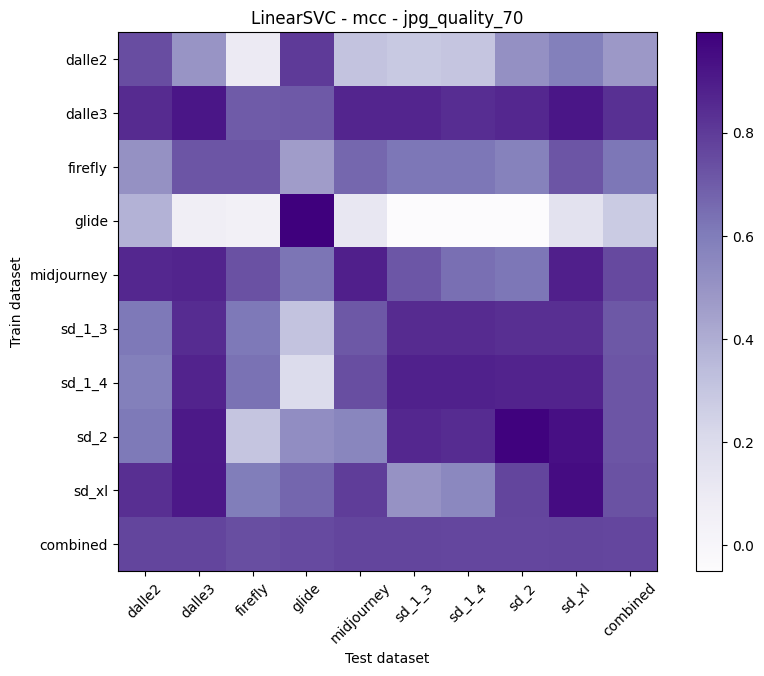

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.745936  0.496091  0.100504  0.799590    0.309662  0.284747   
dalle3         0.850170  0.918323  0.701421  0.705991    0.865530  0.865530   
firefly        0.510394  0.717741  0.717741  0.462317    0.666667  0.618064   
glide          0.380424  0.067505  0.050252  0.995012    0.118002 -0.050063   
midjourney     0.864333  0.869808  0.730329  0.626167    0.886405  0.715725   
sd_1_3         0.611500  0.845215  0.611500  0.310227    0.710320  0.850963   
sd_1_4         0.588567  0.876332  0.634586  0.198166    0.740037  0.881917   
sd_2           0.610010  0.906918  0.303621  0.526830    0.558552  0.860710   
sd_xl          0.836770  0.910046  0.595475  0.671317    0.794823  0.508079   
combined       0.770471  0.770471  0.739834  0.751978    0.770471  0.770471   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.304789  0.515580  0.588898  0.477316  
dalle3         0.840042  0.860387  0.918323  0.833895  
firefly        0.618064  0.577260  0.717741  0.619384  
glide         -0.050063 -0.050063  0.155083  0.277039  
midjourney     0.640020  0.616981  0.886405  0.755009  
sd_1_3         0.850963  0.839498  0.839498  0.710320  
sd_1_4         0.881917  0.876332  0.876332  0.719237  
sd_2           0.847189  0.985111  0.940423  0.718750  
sd_xl          0.553857  0.767559  0.951190  0.726096  
combined       0.764269  0.764269  0.770471  0.763582

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.745936  0.496091  0.100504  0.799590    0.309662  0.284747   
dalle3         0.850170  0.918323  0.701421  0.705991    0.865530  0.865530   
firefly        0.510394  0.717741  0.717741  0.462317    0.666667  0.618064   
glide          0.380424  0.067505  0.050252  0.995012    0.118002 -0.050063   
midjourney     0.864333  0.869808  0.730329  0.626167    0.886405  0.715725   
sd_1_3         0.611500  0.845215  0.611500  0.310227    0.710320  0.850963   
sd_1_4         0.588567  0.876332  0.634586  0.198166    0.740037  0.881917   
sd_2           0.610010  0.906918  0.303621  0.526830    0.558552  0.860710   
sd_xl          0.836770  0.910046  0.595475  0.671317    0.794823  0.508079   
combined       0.770471  0.770471  0.739834  0.751978    0.770471  0.770471   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.304789  0.515580  0.588898  0.460644  
dalle3         0.840042  0.860387  0.918323  0.836191  
firefly        0.618064  0.577260  0.717741  0.622888  
glide         -0.050063 -0.050063  0.155083  0.179566  
midjourney     0.640020  0.616981  0.886405  0.759575  
sd_1_3         0.850963  0.839498  0.839498  0.718854  
sd_1_4         0.881917  0.876332  0.876332  0.728243  
sd_2           0.847189  0.985111  0.940423  0.726596  
sd_xl          0.553857  0.767559  0.951190  0.732124  
combined       0.764269  0.764269  0.770471  0.763634









 ################ Evaluating models trained on standard and tested on jpg_quality_90. ################


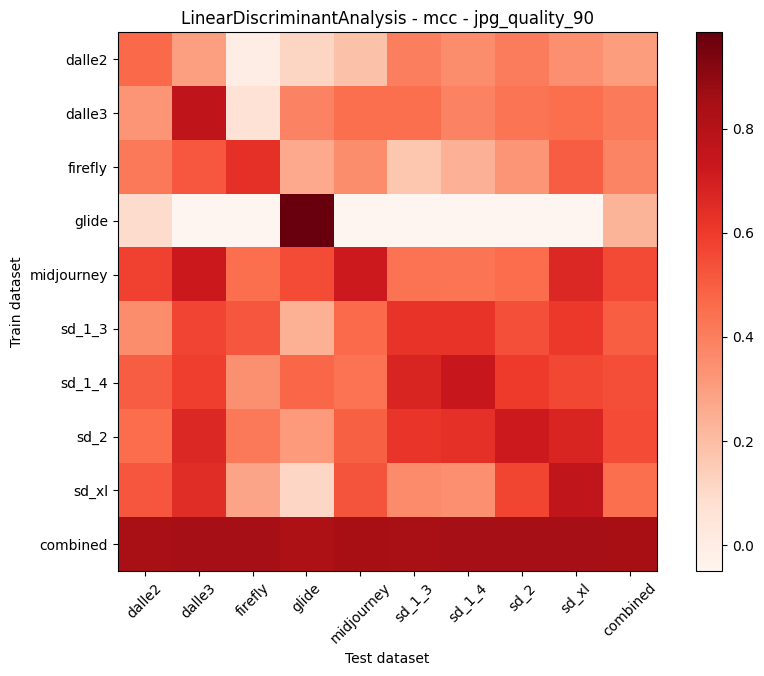

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.470333  0.300050  0.000000  0.118128    0.185635  0.397236   
dalle3         0.327602  0.763097  0.063727  0.387865    0.447533  0.447533   
firefly        0.420189  0.516091  0.634796  0.264824    0.356613  0.172139   
glide          0.095329 -0.050063 -0.050063  0.985012   -0.050063 -0.050063   
midjourney     0.577612  0.726099  0.452121  0.549308    0.720902  0.438360   
sd_1_3         0.352996  0.569970  0.520833  0.245077    0.462397  0.621682   
sd_1_4         0.500100  0.588252  0.343382  0.475006    0.435441  0.676681   
sd_2           0.455461  0.663013  0.421350  0.310970    0.495006  0.619107   
sd_xl          0.521279  0.645978  0.280212  0.114715    0.526113  0.360537   
combined       0.838256  0.855337  0.855337  0.827018    0.843919  0.838256   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.356869  0.410384  0.347672  0.304953  
dalle3         0.383262  0.429189  0.447533  0.412370  
firefly        0.240627  0.327569  0.500626  0.378767  
glide         -0.050063 -0.050063 -0.050063  0.229582  
midjourney     0.433774  0.456711  0.665008  0.555048  
sd_1_3         0.621682  0.538986  0.608487  0.498401  
sd_1_4         0.735600  0.598974  0.561801  0.542124  
sd_2           0.635392  0.720298  0.674241  0.550117  
sd_xl          0.346453  0.565177  0.759788  0.455001  
combined       0.855337  0.849613  0.855337  0.846446

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.470333  0.300050  0.000000  0.118128    0.185635  0.397236   
dalle3         0.327602  0.763097  0.063727  0.387865    0.447533  0.447533   
firefly        0.420189  0.516091  0.634796  0.264824    0.356613  0.172139   
glide          0.095329 -0.050063 -0.050063  0.985012   -0.050063 -0.050063   
midjourney     0.577612  0.726099  0.452121  0.549308    0.720902  0.438360   
sd_1_3         0.352996  0.569970  0.520833  0.245077    0.462397  0.621682   
sd_1_4         0.500100  0.588252  0.343382  0.475006    0.435441  0.676681   
sd_2           0.455461  0.663013  0.421350  0.310970    0.495006  0.619107   
sd_xl          0.521279  0.645978  0.280212  0.114715    0.526113  0.360537   
combined       0.838256  0.855337  0.855337  0.827018    0.843919  0.838256   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.356869  0.410384  0.347672  0.287367  
dalle3         0.383262  0.429189  0.447533  0.410816  
firefly        0.240627  0.327569  0.500626  0.381497  
glide         -0.050063 -0.050063 -0.050063  0.081100  
midjourney     0.433774  0.456711  0.665008  0.557766  
sd_1_3         0.621682  0.538986  0.608487  0.504679  
sd_1_4         0.735600  0.598974  0.561801  0.546137  
sd_2           0.635392  0.720298  0.674241  0.554982  
sd_xl          0.346453  0.565177  0.759788  0.457806  
combined       0.855337  0.849613  0.855337  0.846490

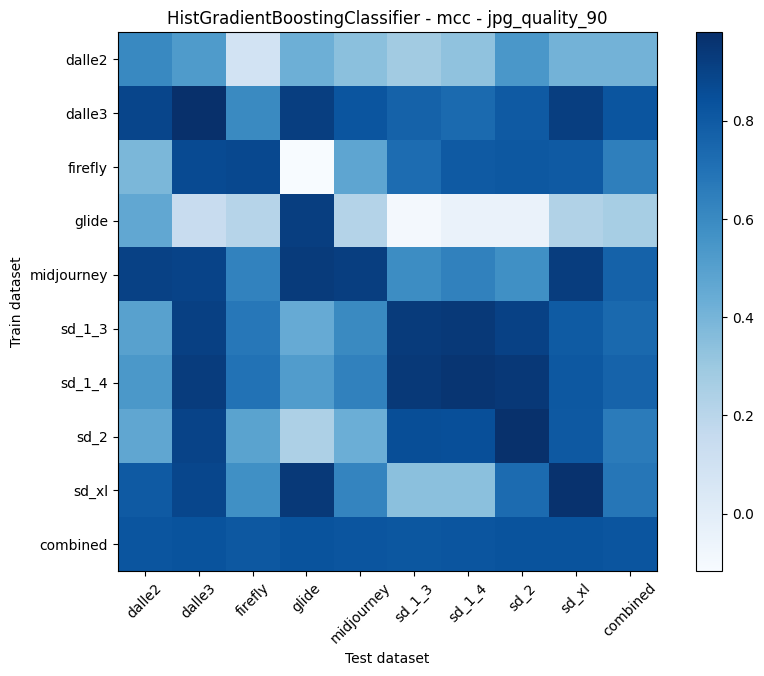

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.604308  0.523341  0.086929  0.424195    0.342518  0.279584   
dalle3         0.888214  0.980049  0.602081  0.916387    0.824970  0.768837   
firefly        0.388393  0.865530  0.875274 -0.117242    0.470333  0.723173   
glide          0.464828  0.146317  0.210079  0.918323    0.220930 -0.092952   
midjourney     0.905918  0.895549  0.630005  0.932287    0.916387  0.587040   
sd_1_3         0.493276  0.910046  0.679286  0.447261    0.600245  0.930047   
sd_1_4         0.537497  0.925012  0.698078  0.517054    0.635606  0.940047   
sd_2           0.466615  0.896357  0.483042  0.238733    0.429075  0.854282   
sd_xl          0.800310  0.882164  0.575967  0.940047    0.620264  0.345456   
combined       0.821964  0.833616  0.810441  0.833616    0.821964  0.816187   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.328684  0.542677  0.407653  0.408579  
dalle3         0.735288  0.803118  0.916387  0.822036  
firefly        0.804030  0.808657  0.804030  0.642078  
glide         -0.048204 -0.048204  0.226285  0.261485  
midjourney     0.634333  0.574233  0.921660  0.769510  
sd_1_3         0.940188  0.905102  0.796761  0.736293  
sd_1_4         0.955299  0.945106  0.811364  0.765372  
sd_2           0.849697  0.975305  0.804726  0.661330  
sd_xl          0.345456  0.727162  0.970194  0.683216  
combined       0.821964  0.833616  0.833616  0.825188

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.604308  0.523341  0.086929  0.424195    0.342518  0.279584   
dalle3         0.888214  0.980049  0.602081  0.916387    0.824970  0.768837   
firefly        0.388393  0.865530  0.875274 -0.117242    0.470333  0.723173   
glide          0.464828  0.146317  0.210079  0.918323    0.220930 -0.092952   
midjourney     0.905918  0.895549  0.630005  0.932287    0.916387  0.587040   
sd_1_3         0.493276  0.910046  0.679286  0.447261    0.600245  0.930047   
sd_1_4         0.537497  0.925012  0.698078  0.517054    0.635606  0.940047   
sd_2           0.466615  0.896357  0.483042  0.238733    0.429075  0.854282   
sd_xl          0.800310  0.882164  0.575967  0.940047    0.620264  0.345456   
combined       0.821964  0.833616  0.810441  0.833616    0.821964  0.816187   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.328684  0.542677  0.407653  0.393321  
dalle3         0.735288  0.803118  0.916387  0.826148  
firefly        0.804030  0.808657  0.804030  0.624687  
glide         -0.048204 -0.048204  0.226285  0.221934  
midjourney     0.634333  0.574233  0.921660  0.777490  
sd_1_3         0.940188  0.905102  0.796761  0.744690  
sd_1_4         0.955299  0.945106  0.811364  0.773896  
sd_2           0.849697  0.975305  0.804726  0.666426  
sd_xl          0.345456  0.727162  0.970194  0.689669  
combined       0.821964  0.833616  0.833616  0.825220

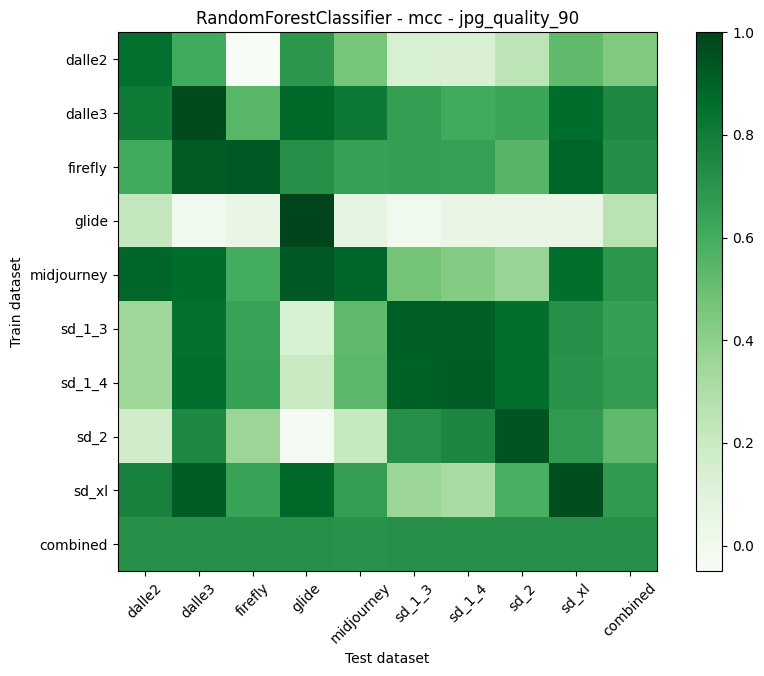

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.851680  0.606045 -0.050252  0.690134    0.466577  0.136323   
dalle3         0.803118  0.975012  0.546673  0.878975    0.816187  0.657848   
firefly        0.604364  0.925012  0.930047  0.717581    0.645769  0.658289   
glide          0.223313  0.000000  0.050063  1.000000    0.070888  0.000000   
midjourney     0.885543  0.865097  0.598059  0.927613    0.885543  0.473817   
sd_1_3         0.351391  0.846791  0.639454  0.136302    0.527525  0.910000   
sd_1_4         0.348751  0.855524  0.643915  0.205879    0.534634  0.905102   
sd_2           0.174714  0.747910  0.359862 -0.027206    0.212035  0.713290   
sd_xl          0.771383  0.915928  0.639093  0.878178    0.659276  0.359556   
combined       0.717741  0.717741  0.717741  0.717741    0.704717  0.717741   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.127578  0.245343  0.522851  0.441494  
dalle3         0.602081  0.629877  0.865251  0.747326  
firefly        0.649937  0.550950  0.890401  0.724755  
glide          0.050063  0.050063  0.050063  0.258199  
midjourney     0.426143  0.368318  0.860043  0.689051  
sd_1_3         0.910000  0.856296  0.715965  0.654379  
sd_1_4         0.915286  0.860387  0.704228  0.659562  
sd_2           0.756677  0.945295  0.675072  0.529498  
sd_xl          0.317490  0.587044  0.970049  0.672354  
combined       0.717741  0.717741  0.717741  0.716285

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.851680  0.606045 -0.050252  0.690134    0.466577  0.136323   
dalle3         0.803118  0.975012  0.546673  0.878975    0.816187  0.657848   
firefly        0.604364  0.925012  0.930047  0.717581    0.645769  0.658289   
glide          0.223313  0.000000  0.050063  1.000000    0.070888  0.000000   
midjourney     0.885543  0.865097  0.598059  0.927613    0.885543  0.473817   
sd_1_3         0.351391  0.846791  0.639454  0.136302    0.527525  0.910000   
sd_1_4         0.348751  0.855524  0.643915  0.205879    0.534634  0.905102   
sd_2           0.174714  0.747910  0.359862 -0.027206    0.212035  0.713290   
sd_xl          0.771383  0.915928  0.639093  0.878178    0.659276  0.359556   
combined       0.717741  0.717741  0.717741  0.717741    0.704717  0.717741   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.127578  0.245343  0.522851  0.399586  
dalle3         0.602081  0.629877  0.865251  0.752780  
firefly        0.649937  0.550950  0.890401  0.730261  
glide          0.050063  0.050063  0.050063  0.166050  
midjourney     0.426143  0.368318  0.860043  0.698908  
sd_1_3         0.910000  0.856296  0.715965  0.654858  
sd_1_4         0.915286  0.860387  0.704228  0.663745  
sd_2           0.756677  0.945295  0.675072  0.506405  
sd_xl          0.317490  0.587044  0.970049  0.677555  
combined       0.717741  0.717741  0.717741  0.716293

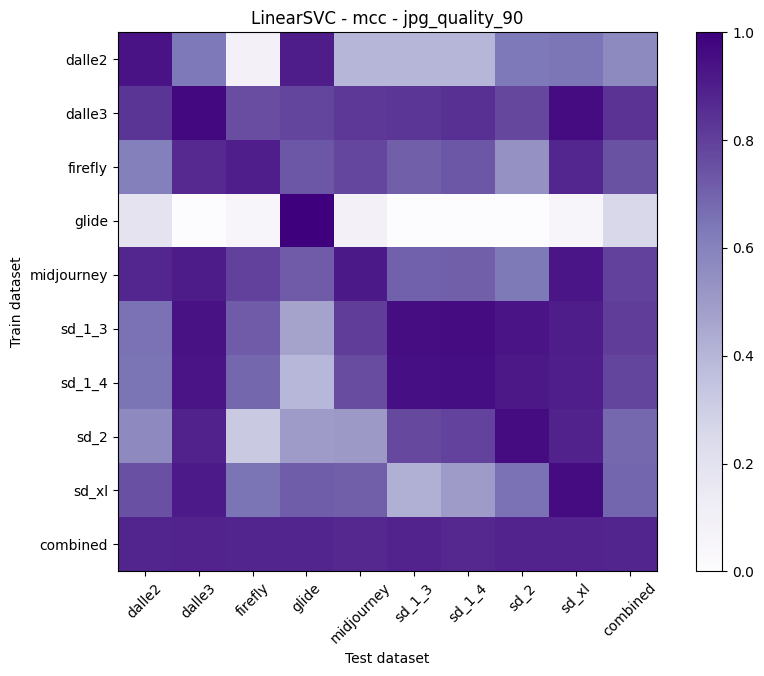

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.936417  0.635905  0.082269  0.903667    0.397613  0.397613   
dalle3         0.830510  0.970437  0.759582  0.781374    0.821443  0.825969   
firefly        0.607911  0.866833  0.899066  0.731795    0.780156  0.708203   
glide          0.190445  0.000000  0.050063  1.000000    0.086929  0.000000   
midjourney     0.875274  0.906372  0.796205  0.721606    0.916939  0.703502   
sd_1_3         0.654110  0.940188  0.721882  0.472474    0.805823  0.955585   
sd_1_4         0.645833  0.930419  0.684160  0.392823    0.763064  0.945958   
sd_2           0.563912  0.886876  0.317078  0.495284    0.503415  0.769777   
sd_xl          0.750949  0.910410  0.646199  0.712629    0.708420  0.425000   
combined       0.880844  0.886405  0.880844  0.880844    0.869808  0.886405   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.401857  0.635905  0.643743  0.569259  
dalle3         0.848839  0.776990  0.960192  0.839641  
firefly        0.731795  0.537282  0.877471  0.744530  
glide          0.000000  0.000000  0.050063  0.254507  
midjourney     0.708010  0.632719  0.927613  0.794610  
sd_1_3         0.960769  0.930047  0.905102  0.808351  
sd_1_4         0.951190  0.920184  0.900000  0.784159  
sd_2           0.791521  0.960048  0.886876  0.680013  
sd_xl          0.495806  0.654411  0.960192  0.690741  
combined       0.869808  0.886405  0.886405  0.880844

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.936417  0.635905  0.082269  0.903667    0.397613  0.397613   
dalle3         0.830510  0.970437  0.759582  0.781374    0.821443  0.825969   
firefly        0.607911  0.866833  0.899066  0.731795    0.780156  0.708203   
glide          0.190445  0.000000  0.050063  1.000000    0.086929  0.000000   
midjourney     0.875274  0.906372  0.796205  0.721606    0.916939  0.703502   
sd_1_3         0.654110  0.940188  0.721882  0.472474    0.805823  0.955585   
sd_1_4         0.645833  0.930419  0.684160  0.392823    0.763064  0.945958   
sd_2           0.563912  0.886876  0.317078  0.495284    0.503415  0.769777   
sd_xl          0.750949  0.910410  0.646199  0.712629    0.708420  0.425000   
combined       0.880844  0.886405  0.880844  0.880844    0.869808  0.886405   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.401857  0.635905  0.643743  0.559443  
dalle3         0.848839  0.776990  0.960192  0.841704  
firefly        0.731795  0.537282  0.877471  0.748946  
glide          0.000000  0.000000  0.050063  0.153056  
midjourney     0.708010  0.632719  0.927613  0.798693  
sd_1_3         0.960769  0.930047  0.905102  0.816220  
sd_1_4         0.951190  0.920184  0.900000  0.792626  
sd_2           0.791521  0.960048  0.886876  0.686087  
sd_xl          0.495806  0.654411  0.960192  0.696002  
combined       0.869808  0.886405  0.886405  0.880863









 ################ Evaluating models trained on standard and tested on jpg_quality_80. ################


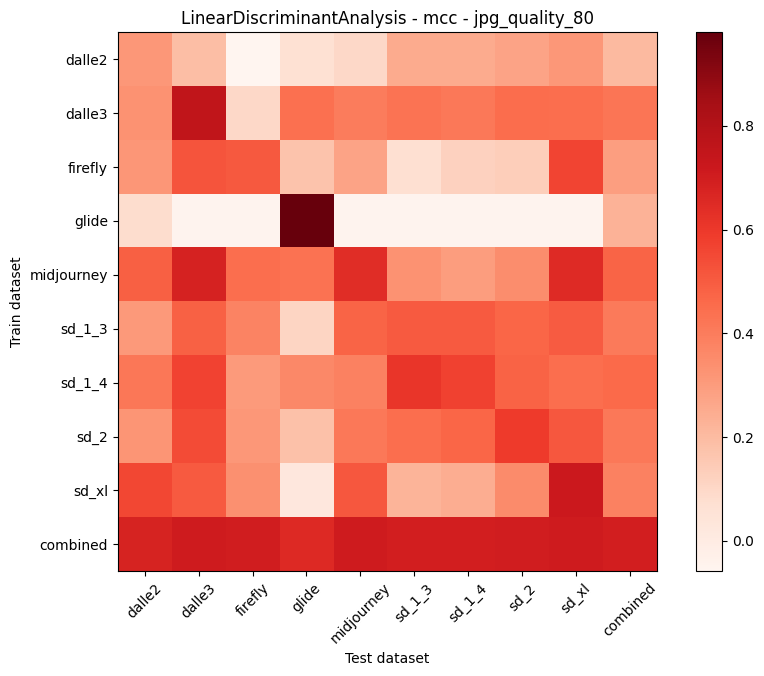

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.312348  0.190629 -0.058767  0.065449    0.097322  0.252050   
dalle3         0.327621  0.755236  0.099255  0.437260    0.401127  0.428248   
firefly        0.315890  0.517808  0.506070  0.170418    0.275169  0.071034   
glide          0.082269 -0.050063 -0.050063  0.980049   -0.050063 -0.050063   
midjourney     0.485006  0.681125  0.445451  0.435659    0.641783  0.329516   
sd_1_3         0.308371  0.482962  0.375538  0.111436    0.475831  0.504748   
sd_1_4         0.416172  0.568290  0.305187  0.360072    0.385390  0.609349   
sd_2           0.318854  0.544436  0.313547  0.180036    0.412043  0.446586   
sd_xl          0.555563  0.505006  0.335480  0.022943    0.510000  0.225014   
combined       0.679597  0.705781  0.699167  0.654110    0.705781  0.692598   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.252050  0.277846  0.312348  0.204951  
dalle3         0.414706  0.450762  0.446263  0.420227  
firefly        0.120873  0.135750  0.566074  0.290928  
glide         -0.050063 -0.050063 -0.050063  0.228234  
midjourney     0.295980  0.343891  0.647324  0.473950  
sd_1_3         0.504748  0.468762  0.497419  0.406249  
sd_1_4         0.574065  0.479389  0.447474  0.457450  
sd_2           0.470206  0.590519  0.512840  0.415200  
sd_xl          0.244424  0.354568  0.718799  0.383784  
combined       0.692598  0.699167  0.705781  0.692598

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.312348  0.190629 -0.058767  0.065449    0.097322  0.252050   
dalle3         0.327621  0.755236  0.099255  0.437260    0.401127  0.428248   
firefly        0.315890  0.517808  0.506070  0.170418    0.275169  0.071034   
glide          0.082269 -0.050063 -0.050063  0.980049   -0.050063 -0.050063   
midjourney     0.485006  0.681125  0.445451  0.435659    0.641783  0.329516   
sd_1_3         0.308371  0.482962  0.375538  0.111436    0.475831  0.504748   
sd_1_4         0.416172  0.568290  0.305187  0.360072    0.385390  0.609349   
sd_2           0.318854  0.544436  0.313547  0.180036    0.412043  0.446586   
sd_xl          0.555563  0.505006  0.335480  0.022943    0.510000  0.225014   
combined       0.679597  0.705781  0.699167  0.654110    0.705781  0.692598   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.252050  0.277846  0.312348  0.189031  
dalle3         0.414706  0.450762  0.446263  0.417831  
firefly        0.120873  0.135750  0.566074  0.297676  
glide         -0.050063 -0.050063 -0.050063  0.079098  
midjourney     0.295980  0.343891  0.647324  0.478415  
sd_1_3         0.504748  0.468762  0.497419  0.414424  
sd_1_4         0.574065  0.479389  0.447474  0.460599  
sd_2           0.470206  0.590519  0.512840  0.421007  
sd_xl          0.244424  0.354568  0.718799  0.385755  
combined       0.692598  0.699167  0.705781  0.692731

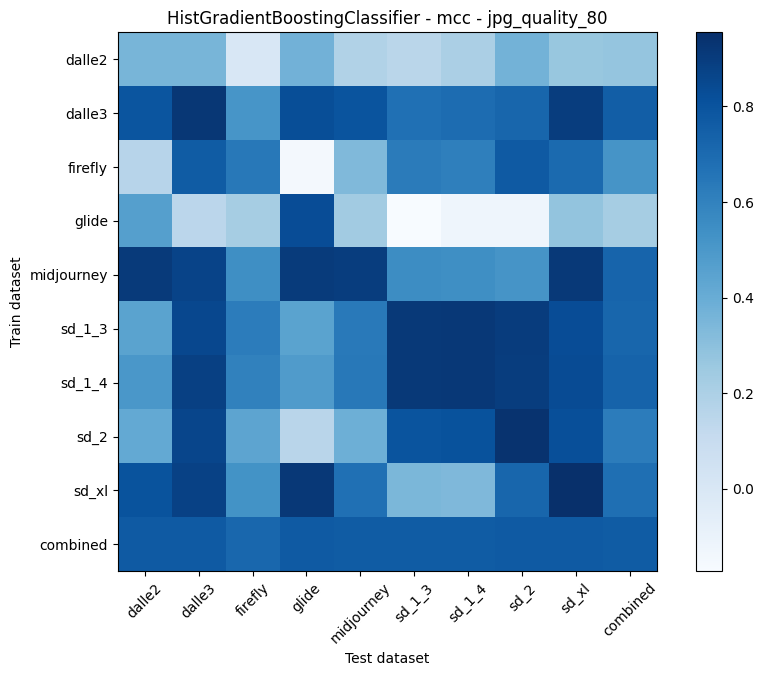

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.356034  0.356034  0.000000  0.373632    0.183280  0.151717   
dalle3         0.795806  0.922958  0.514496  0.825093    0.800641  0.675423   
firefly        0.162153  0.761372  0.641689 -0.153522    0.332674  0.628345   
glide          0.462131  0.144824  0.221526  0.829315    0.236310 -0.172397   
midjourney     0.907556  0.870697  0.542624  0.902213    0.896897  0.551267   
sd_1_3         0.447914  0.850000  0.624018  0.447914    0.637080  0.911642   
sd_1_4         0.501605  0.880705  0.600657  0.480079    0.639966  0.912238   
sd_2           0.415842  0.860387  0.437476  0.156608    0.385013  0.798612   
sd_xl          0.804726  0.877471  0.523655  0.915561    0.673162  0.345456   
combined       0.770471  0.770471  0.715965  0.770471    0.764269  0.764269   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.204124  0.369274  0.263664  0.273766  
dalle3         0.693380  0.720652  0.896357  0.756179  
firefly        0.610658  0.770964  0.700494  0.517151  
glide         -0.121581 -0.121581  0.279861  0.219874  
midjourney     0.542624  0.516726  0.912926  0.728514  
sd_1_3         0.916939  0.901127  0.830166  0.721100  
sd_1_4         0.917584  0.896357  0.835010  0.731892  
sd_2           0.807924  0.941177  0.822016  0.622712  
sd_xl          0.336135  0.718761  0.955012  0.677727  
combined       0.764269  0.770471  0.770471  0.762210

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.356034  0.356034  0.000000  0.373632    0.183280  0.151717   
dalle3         0.795806  0.922958  0.514496  0.825093    0.800641  0.675423   
firefly        0.162153  0.761372  0.641689 -0.153522    0.332674  0.628345   
glide          0.462131  0.144824  0.221526  0.829315    0.236310 -0.172397   
midjourney     0.907556  0.870697  0.542624  0.902213    0.896897  0.551267   
sd_1_3         0.447914  0.850000  0.624018  0.447914    0.637080  0.911642   
sd_1_4         0.501605  0.880705  0.600657  0.480079    0.639966  0.912238   
sd_2           0.415842  0.860387  0.437476  0.156608    0.385013  0.798612   
sd_xl          0.804726  0.877471  0.523655  0.915561    0.673162  0.345456   
combined       0.770471  0.770471  0.715965  0.770471    0.764269  0.764269   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.204124  0.369274  0.263664  0.250862  
dalle3         0.693380  0.720652  0.896357  0.760534  
firefly        0.610658  0.770964  0.700494  0.494981  
glide         -0.121581 -0.121581  0.279861  0.195379  
midjourney     0.542624  0.516726  0.912926  0.738170  
sd_1_3         0.916939  0.901127  0.830166  0.729645  
sd_1_4         0.917584  0.896357  0.835010  0.740467  
sd_2           0.807924  0.941177  0.822016  0.625006  
sd_xl          0.336135  0.718761  0.955012  0.683327  
combined       0.764269  0.770471  0.770471  0.762347

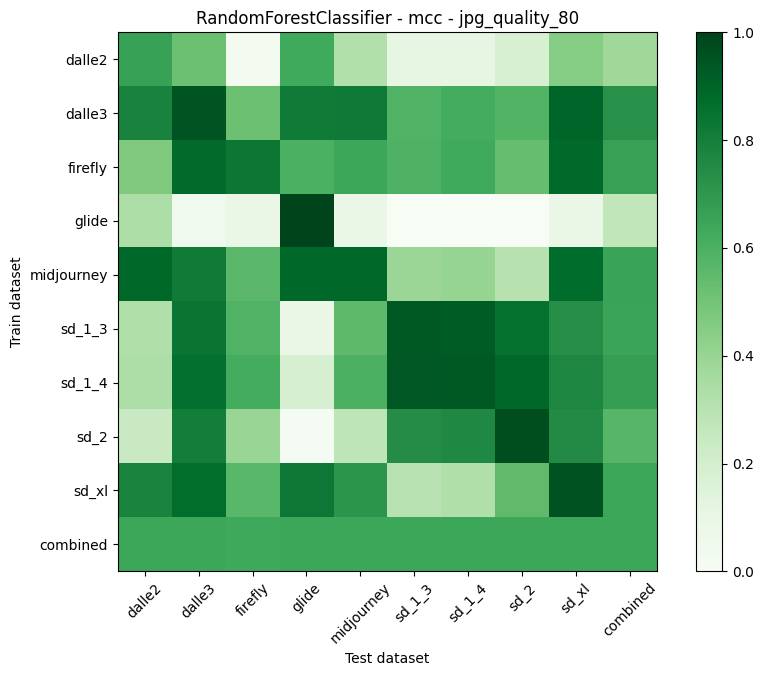

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.663413  0.519015  0.028976  0.628082    0.316667  0.107143   
dalle3         0.782160  0.945579  0.519245  0.814081    0.818703  0.589526   
firefly        0.467125  0.875536  0.830042  0.600657    0.644369  0.591986   
glide          0.333333  0.050063  0.086929  1.000000    0.086929  0.000000   
midjourney     0.883586  0.815255  0.562132  0.883586    0.883586  0.389756   
sd_1_3         0.324233  0.836770  0.587137  0.086767    0.553857  0.935573   
sd_1_4         0.333690  0.855867  0.620571  0.185635    0.595475  0.940753   
sd_2           0.245343  0.803118  0.395520  0.019066    0.278117  0.743613   
sd_xl          0.777659  0.870697  0.564717  0.827997    0.707330  0.299022   
combined       0.642983  0.642983  0.635905  0.642983    0.642983  0.642983   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.107143  0.178609  0.451463  0.375098  
dalle3         0.618580  0.581250  0.895101  0.723675  
firefly        0.626804  0.531674  0.880705  0.666999  
glide          0.000000  0.000000  0.086929  0.273179  
midjourney     0.403229  0.301828  0.872797  0.655447  
sd_1_3         0.925289  0.851064  0.736363  0.649593  
sd_1_4         0.935573  0.885100  0.767559  0.675590  
sd_2           0.760385  0.970000  0.751978  0.570421  
sd_xl          0.328047  0.544063  0.950761  0.647840  
combined       0.642983  0.642983  0.642983  0.642194

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.663413  0.519015  0.028976  0.628082    0.316667  0.107143   
dalle3         0.782160  0.945579  0.519245  0.814081    0.818703  0.589526   
firefly        0.467125  0.875536  0.830042  0.600657    0.644369  0.591986   
glide          0.333333  0.050063  0.086929  1.000000    0.086929  0.000000   
midjourney     0.883586  0.815255  0.562132  0.883586    0.883586  0.389756   
sd_1_3         0.324233  0.836770  0.587137  0.086767    0.553857  0.935573   
sd_1_4         0.333690  0.855867  0.620571  0.185635    0.595475  0.940753   
sd_2           0.245343  0.803118  0.395520  0.019066    0.278117  0.743613   
sd_xl          0.777659  0.870697  0.564717  0.827997    0.707330  0.299022   
combined       0.642983  0.642983  0.635905  0.642983    0.642983  0.642983   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.107143  0.178609  0.451463  0.333390  
dalle3         0.618580  0.581250  0.895101  0.729358  
firefly        0.626804  0.531674  0.880705  0.672100  
glide          0.000000  0.000000  0.086929  0.182687  
midjourney     0.403229  0.301828  0.872797  0.666195  
sd_1_3         0.925289  0.851064  0.736363  0.648562  
sd_1_4         0.935573  0.885100  0.767559  0.680025  
sd_2           0.760385  0.970000  0.751978  0.551904  
sd_xl          0.328047  0.544063  0.950761  0.652255  
combined       0.642983  0.642983  0.642983  0.642197

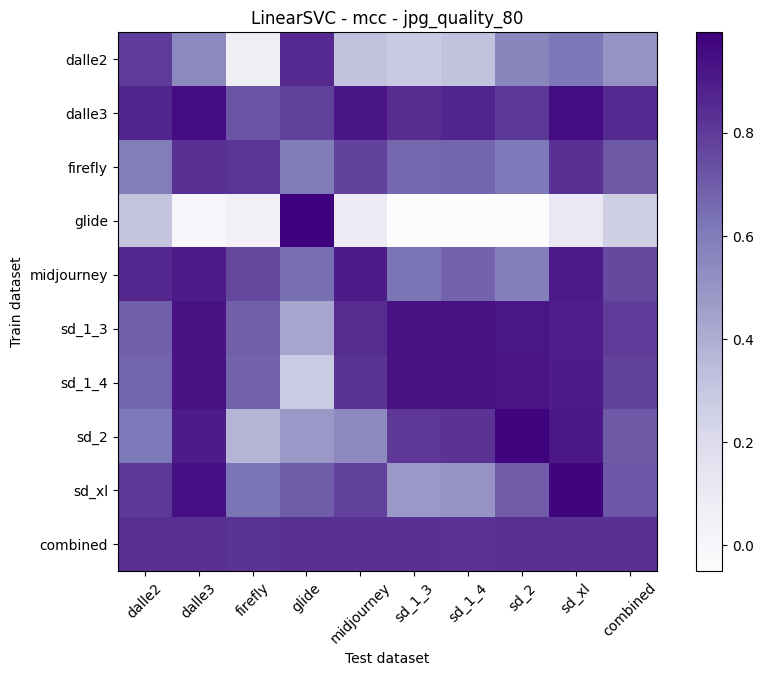

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.795395  0.546536  0.070888  0.855337    0.319262  0.279584   
dalle3         0.870697  0.950761  0.724641  0.782160    0.920046  0.842066   
firefly        0.595365  0.829315  0.817617  0.600270    0.777659  0.660297   
glide          0.302005  0.000000  0.050252  0.995012    0.095329 -0.050063   
midjourney     0.861552  0.899066  0.760609  0.643825    0.899066  0.625802   
sd_1_3         0.686856  0.926960  0.691291  0.428810    0.845095  0.932287   
sd_1_4         0.669213  0.926960  0.678016  0.276340    0.820657  0.932287   
sd_2           0.613978  0.897528  0.373657  0.482795    0.538744  0.807460   
sd_xl          0.804726  0.940047  0.624306  0.693772    0.778437  0.483042   
combined       0.832112  0.837931  0.820571  0.837931    0.832112  0.832112   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.319262  0.561951  0.615882  0.503036  
dalle3         0.870697  0.804884  0.955968  0.855766  
firefly        0.670537  0.615069  0.829315  0.706991  
glide         -0.050063 -0.050063  0.107143  0.260913  
midjourney     0.680336  0.585702  0.904534  0.756840  
sd_1_3         0.932287  0.916387  0.890401  0.797741  
sd_1_4         0.932287  0.921660  0.900721  0.775734  
sd_2           0.824970  0.980049  0.911642  0.706893  
sd_xl          0.499352  0.702069  0.975305  0.715970  
combined       0.826326  0.837931  0.837931  0.832757

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.795395  0.546536  0.070888  0.855337    0.319262  0.279584   
dalle3         0.870697  0.950761  0.724641  0.782160    0.920046  0.842066   
firefly        0.595365  0.829315  0.817617  0.600270    0.777659  0.660297   
glide          0.302005  0.000000  0.050252  0.995012    0.095329 -0.050063   
midjourney     0.861552  0.899066  0.760609  0.643825    0.899066  0.625802   
sd_1_3         0.686856  0.926960  0.691291  0.428810    0.845095  0.932287   
sd_1_4         0.669213  0.926960  0.678016  0.276340    0.820657  0.932287   
sd_2           0.613978  0.897528  0.373657  0.482795    0.538744  0.807460   
sd_xl          0.804726  0.940047  0.624306  0.693772    0.778437  0.483042   
combined       0.832112  0.837931  0.820571  0.837931    0.832112  0.832112   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.319262  0.561951  0.615882  0.484900  
dalle3         0.870697  0.804884  0.955968  0.857991  
firefly        0.670537  0.615069  0.829315  0.710605  
glide         -0.050063 -0.050063  0.107143  0.155506  
midjourney     0.680336  0.585702  0.904534  0.762277  
sd_1_3         0.932287  0.916387  0.890401  0.805597  
sd_1_4         0.932287  0.921660  0.900721  0.784238  
sd_2           0.824970  0.980049  0.911642  0.714536  
sd_xl          0.499352  0.702069  0.975305  0.722340  
combined       0.826326  0.837931  0.837931  0.832773









 ################ Evaluating models trained on standard and tested on jpg_quality_95. ################


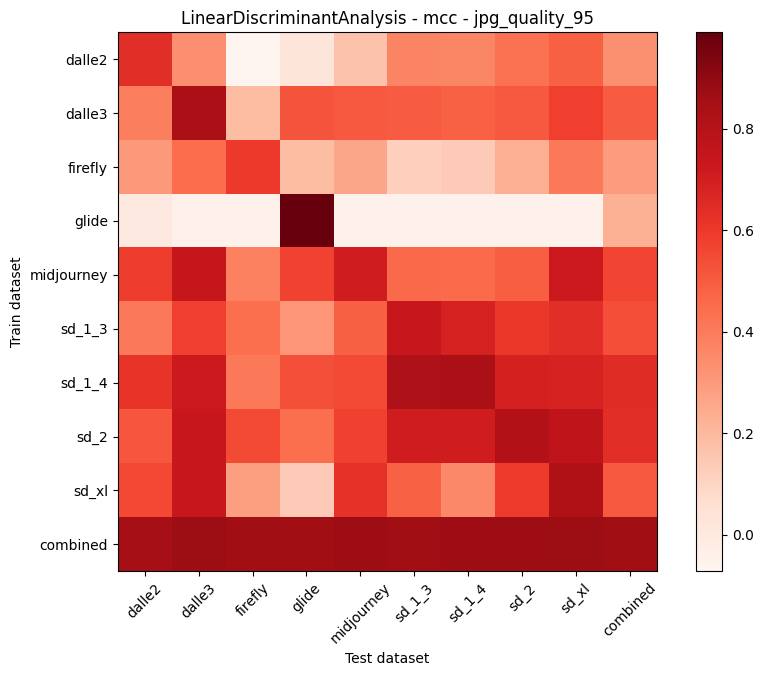

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.639966  0.337963 -0.072296  0.026542    0.166969  0.370108   
dalle3         0.385872  0.835068  0.187858  0.517093    0.508026  0.498974   
firefly        0.305004  0.449111  0.596319  0.186462    0.260326  0.122226   
glide          0.000000 -0.050063 -0.050063  0.990000   -0.050063 -0.050063   
midjourney     0.583541  0.746129  0.381364  0.569466    0.705079  0.458989   
sd_1_3         0.405046  0.576523  0.445139  0.311893    0.486028  0.729167   
sd_1_4         0.619107  0.720036  0.405658  0.531860    0.550019  0.823341   
sd_2           0.512915  0.736114  0.550035  0.439530    0.573480  0.705220   
sd_xl          0.554003  0.736558  0.285061  0.138246    0.625634  0.479692   
combined       0.856187  0.872992  0.861759  0.861759    0.867360  0.861759   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.365567  0.432346  0.484390  0.331216  
dalle3         0.480898  0.508026  0.576523  0.498471  
firefly        0.137116  0.230740  0.406840  0.295586  
glide         -0.050063 -0.050063 -0.050063  0.226880  
midjourney     0.454430  0.490947  0.720324  0.564793  
sd_1_3         0.685904  0.604326  0.638562  0.536792  
sd_1_4         0.834181  0.690553  0.680852  0.646290  
sd_2           0.705220  0.811364  0.767779  0.640513  
sd_xl          0.355544  0.591897  0.818057  0.506357  
combined       0.867360  0.867360  0.872992  0.865490

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.639966  0.337963 -0.072296  0.026542    0.166969  0.370108   
dalle3         0.385872  0.835068  0.187858  0.517093    0.508026  0.498974   
firefly        0.305004  0.449111  0.596319  0.186462    0.260326  0.122226   
glide          0.000000 -0.050063 -0.050063  0.990000   -0.050063 -0.050063   
midjourney     0.583541  0.746129  0.381364  0.569466    0.705079  0.458989   
sd_1_3         0.405046  0.576523  0.445139  0.311893    0.486028  0.729167   
sd_1_4         0.619107  0.720036  0.405658  0.531860    0.550019  0.823341   
sd_2           0.512915  0.736114  0.550035  0.439530    0.573480  0.705220   
sd_xl          0.554003  0.736558  0.285061  0.138246    0.625634  0.479692   
combined       0.856187  0.872992  0.861759  0.861759    0.867360  0.861759   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.365567  0.432346  0.484390  0.305729  
dalle3         0.480898  0.508026  0.576523  0.499815  
firefly        0.137116  0.230740  0.406840  0.299349  
glide         -0.050063 -0.050063 -0.050063  0.071062  
midjourney     0.454430  0.490947  0.720324  0.567808  
sd_1_3         0.685904  0.604326  0.638562  0.542510  
sd_1_4         0.834181  0.690553  0.680852  0.650623  
sd_2           0.705220  0.811364  0.767779  0.644629  
sd_xl          0.355544  0.591897  0.818057  0.509410  
combined       0.867360  0.867360  0.872992  0.865503

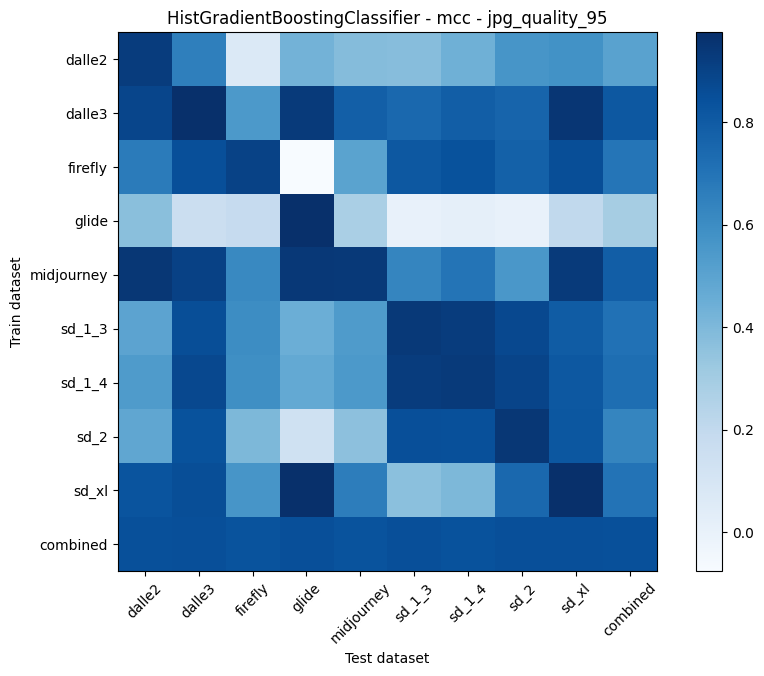

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.922262  0.651597  0.067505  0.426935    0.380424  0.376069   
dalle3         0.886876  0.975305  0.547830  0.930186    0.782786  0.748334   
firefly        0.669570  0.850681  0.900045 -0.076547    0.501115  0.812605   
glide          0.368243  0.154919  0.183176  0.975305    0.276916  0.000000   
midjourney     0.946433  0.905102  0.614268  0.941177    0.935948  0.626942   
sd_1_3         0.496912  0.855524  0.597432  0.446057    0.538816  0.935948   
sd_1_4         0.536343  0.875011  0.591080  0.473016    0.544753  0.925938   
sd_2           0.484278  0.836266  0.402717  0.136419    0.362500  0.850681   
sd_xl          0.828156  0.855190  0.563114  0.975110    0.659276  0.364073   
combined       0.845215  0.850963  0.833812  0.850963    0.833812  0.850963   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.439259  0.561915  0.577463  0.502867  
dalle3         0.787147  0.765466  0.950000  0.814093  
firefly        0.836266  0.775605  0.855524  0.692611  
glide          0.015287  0.000000  0.202733  0.291779  
midjourney     0.699864  0.555541  0.930745  0.786805  
sd_1_3         0.925567  0.875098  0.798612  0.710550  
sd_1_4         0.931165  0.890045  0.811992  0.722463  
sd_2           0.845857  0.946433  0.817302  0.629294  
sd_xl          0.403637  0.745888  0.975110  0.700085  
combined       0.839498  0.850963  0.850963  0.845215

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.922262  0.651597  0.067505  0.426935    0.380424  0.376069   
dalle3         0.886876  0.975305  0.547830  0.930186    0.782786  0.748334   
firefly        0.669570  0.850681  0.900045 -0.076547    0.501115  0.812605   
glide          0.368243  0.154919  0.183176  0.975305    0.276916  0.000000   
midjourney     0.946433  0.905102  0.614268  0.941177    0.935948  0.626942   
sd_1_3         0.496912  0.855524  0.597432  0.446057    0.538816  0.935948   
sd_1_4         0.536343  0.875011  0.591080  0.473016    0.544753  0.925938   
sd_2           0.484278  0.836266  0.402717  0.136419    0.362500  0.850681   
sd_xl          0.828156  0.855190  0.563114  0.975110    0.659276  0.364073   
combined       0.845215  0.850963  0.833812  0.850963    0.833812  0.850963   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.439259  0.561915  0.577463  0.489270  
dalle3         0.787147  0.765466  0.950000  0.819325  
firefly        0.836266  0.775605  0.855524  0.680540  
glide          0.015287  0.000000  0.202733  0.241842  
midjourney     0.699864  0.555541  0.930745  0.795113  
sd_1_3         0.925567  0.875098  0.798612  0.718885  
sd_1_4         0.931165  0.890045  0.811992  0.731038  
sd_2           0.845857  0.946433  0.817302  0.631384  
sd_xl          0.403637  0.745888  0.975110  0.707728  
combined       0.839498  0.850963  0.850963  0.845239

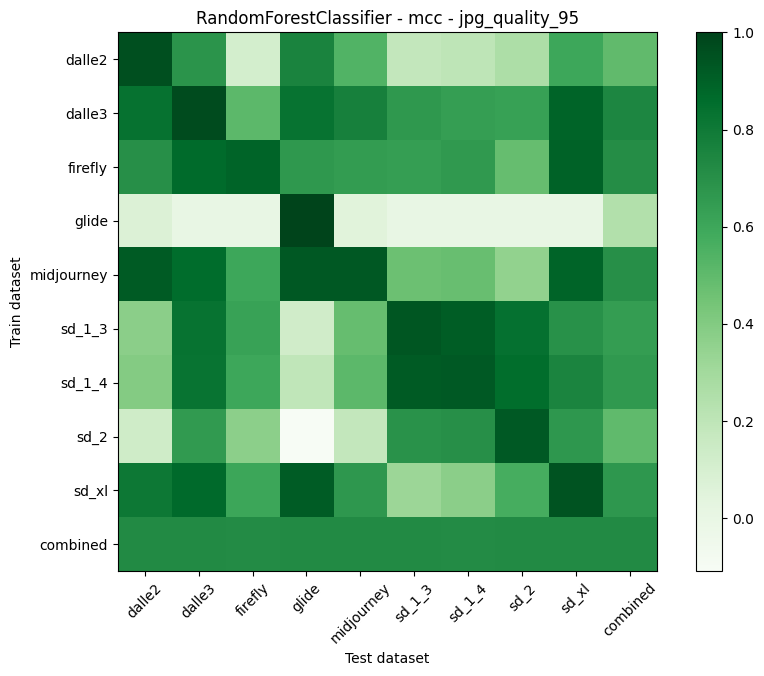

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.960000  0.679597  0.111537  0.754342    0.539162  0.182537   
dalle3         0.835068  0.970437  0.508068  0.830510    0.768261  0.662644   
firefly        0.701457  0.865011  0.890178  0.666325    0.648967  0.640333   
glide          0.070888  0.000000  0.000000  1.000000    0.050063  0.000000   
midjourney     0.921660  0.860000  0.599878  0.926960    0.926960  0.463412   
sd_1_3         0.375000  0.827330  0.620571  0.125501    0.482962  0.935573   
sd_1_4         0.397236  0.822637  0.599649  0.191761    0.508079  0.920184   
sd_2           0.129431  0.656710  0.371562 -0.108826    0.181973  0.691164   
sd_xl          0.805823  0.866311  0.604364  0.915011    0.666667  0.322562   
combined       0.725753  0.725753  0.719272  0.725753    0.725753  0.725753   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.202457  0.261262  0.599019  0.496317  
dalle3         0.638009  0.625758  0.891115  0.742361  
firefly        0.661974  0.483102  0.895280  0.712319  
glide          0.000000  0.000000  0.000000  0.244456  
midjourney     0.476281  0.352951  0.890401  0.702176  
sd_1_3         0.910046  0.836770  0.692763  0.644425  
sd_1_4         0.925289  0.855867  0.749658  0.659488  
sd_2           0.704228  0.925567  0.669570  0.498780  
sd_xl          0.373425  0.567367  0.945295  0.668066  
combined       0.719272  0.725753  0.725753  0.724309

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.960000  0.679597  0.111537  0.754342    0.539162  0.182537   
dalle3         0.835068  0.970437  0.508068  0.830510    0.768261  0.662644   
firefly        0.701457  0.865011  0.890178  0.666325    0.648967  0.640333   
glide          0.070888  0.000000  0.000000  1.000000    0.050063  0.000000   
midjourney     0.921660  0.860000  0.599878  0.926960    0.926960  0.463412   
sd_1_3         0.375000  0.827330  0.620571  0.125501    0.482962  0.935573   
sd_1_4         0.397236  0.822637  0.599649  0.191761    0.508079  0.920184   
sd_2           0.129431  0.656710  0.371562 -0.108826    0.181973  0.691164   
sd_xl          0.805823  0.866311  0.604364  0.915011    0.666667  0.322562   
combined       0.725753  0.725753  0.719272  0.725753    0.725753  0.725753   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.202457  0.261262  0.599019  0.476657  
dalle3         0.638009  0.625758  0.891115  0.747763  
firefly        0.661974  0.483102  0.895280  0.716959  
glide          0.000000  0.000000  0.000000  0.124550  
midjourney     0.476281  0.352951  0.890401  0.713167  
sd_1_3         0.910046  0.836770  0.692763  0.645169  
sd_1_4         0.925289  0.855867  0.749658  0.663373  
sd_2           0.704228  0.925567  0.669570  0.469042  
sd_xl          0.373425  0.567367  0.945295  0.674092  
combined       0.719272  0.725753  0.725753  0.724313

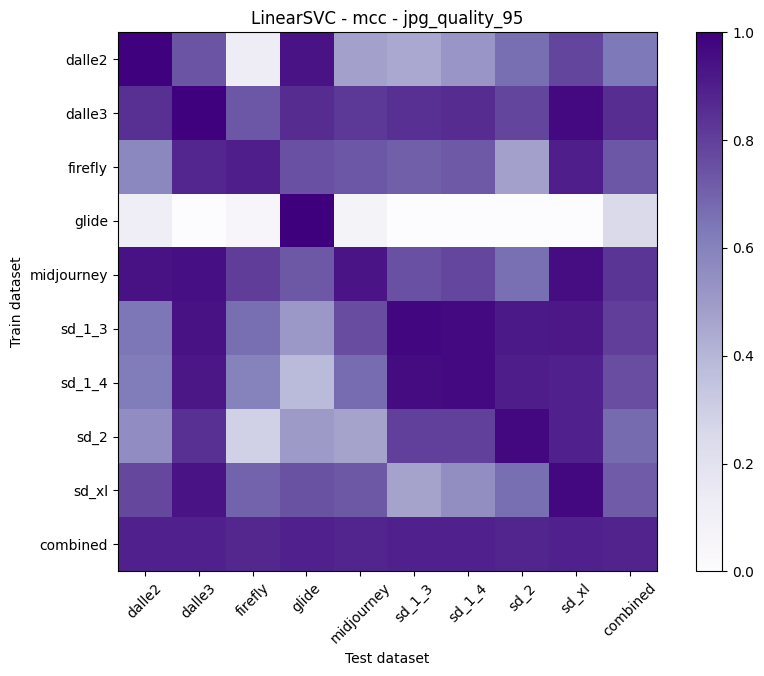

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.995012  0.739583  0.128103  0.936417    0.479555  0.447407   
dalle3         0.845215  0.995012  0.731432  0.858454    0.819140  0.845215   
firefly        0.576557  0.875274  0.901127  0.753778    0.730731  0.708010   
glide          0.123404  0.000000  0.050063  1.000000    0.070888  0.000000   
midjourney     0.940423  0.945579  0.804884  0.728994    0.930186  0.750930   
sd_1_3         0.640513  0.945012  0.664966  0.511524    0.765466  0.975305   
sd_1_4         0.621682  0.925104  0.601354  0.381612    0.670902  0.960192   
sd_2           0.551852  0.849697  0.292342  0.499352    0.470734  0.800310   
sd_xl          0.777333  0.935573  0.698271  0.743613    0.727001  0.470645   
combined       0.890911  0.890911  0.874383  0.890911    0.879864  0.890911   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.519015  0.667361  0.785132  0.635470  
dalle3         0.858454  0.785132  0.965302  0.853535  
firefly        0.726162  0.478116  0.901127  0.733785  
glide          0.000000  0.000000  0.000000  0.248261  
midjourney     0.777659  0.660465  0.955968  0.828515  
sd_1_3         0.965109  0.915561  0.920414  0.803252  
sd_1_4         0.965302  0.905555  0.891115  0.760062  
sd_2           0.800310  0.970194  0.891606  0.674987  
sd_xl          0.550634  0.665883  0.970000  0.721038  
combined       0.890911  0.879864  0.890911  0.886601

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.995012  0.739583  0.128103  0.936417    0.479555  0.447407   
dalle3         0.845215  0.995012  0.731432  0.858454    0.819140  0.845215   
firefly        0.576557  0.875274  0.901127  0.753778    0.730731  0.708010   
glide          0.123404  0.000000  0.050063  1.000000    0.070888  0.000000   
midjourney     0.940423  0.945579  0.804884  0.728994    0.930186  0.750930   
sd_1_3         0.640513  0.945012  0.664966  0.511524    0.765466  0.975305   
sd_1_4         0.621682  0.925104  0.601354  0.381612    0.670902  0.960192   
sd_2           0.551852  0.849697  0.292342  0.499352    0.470734  0.800310   
sd_xl          0.777333  0.935573  0.698271  0.743613    0.727001  0.470645   
combined       0.890911  0.890911  0.874383  0.890911    0.879864  0.890911   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.519015  0.667361  0.785132  0.633065  
dalle3         0.858454  0.785132  0.965302  0.855928  
firefly        0.726162  0.478116  0.901127  0.738987  
glide          0.000000  0.000000  0.000000  0.138262  
midjourney     0.777659  0.660465  0.955968  0.832788  
sd_1_3         0.965109  0.915561  0.920414  0.811541  
sd_1_4         0.965302  0.905555  0.891115  0.769202  
sd_2           0.800310  0.970194  0.891606  0.680711  
sd_xl          0.550634  0.665883  0.970000  0.726550  
combined       0.890911  0.879864  0.890911  0.886619









 ################ Evaluating models trained on standard and tested on standard. ################


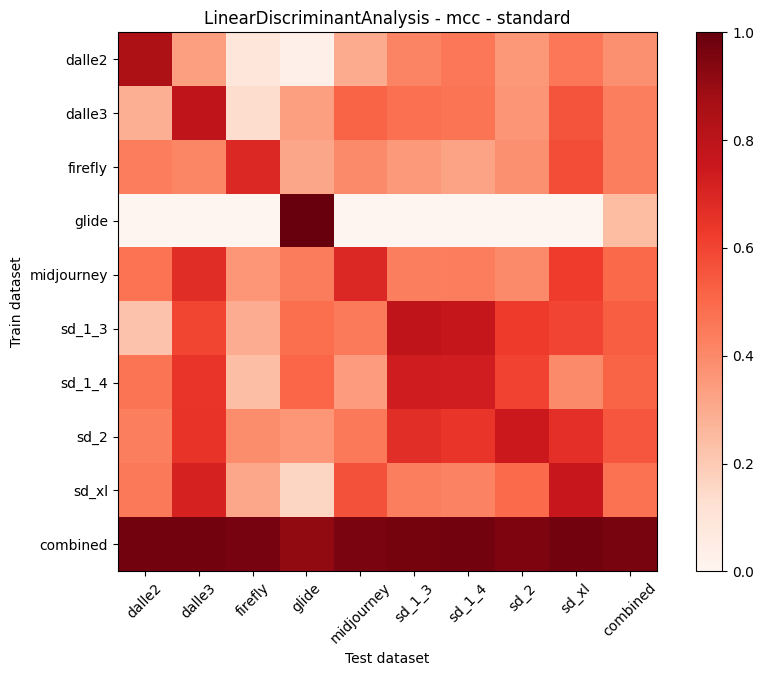

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.845011  0.333297  0.088782  0.034943    0.300000  0.414779   
dalle3         0.287133  0.792253  0.136119  0.338990    0.515073  0.477804   
firefly        0.439019  0.410628  0.689575  0.316309    0.401191  0.354079   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.471915  0.674091  0.362703  0.443203    0.690415  0.433680   
sd_1_3         0.224211  0.595067  0.291864  0.484108    0.446499  0.785770   
sd_1_4         0.468106  0.646367  0.240676  0.511254    0.345531  0.732744   
sd_2           0.437140  0.650521  0.390468  0.362466    0.451184  0.671209   
sd_xl          0.451184  0.713577  0.310824  0.163784    0.565573  0.437140   
combined       0.975305  0.975305  0.965109  0.910729    0.960048  0.970194   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.458466  0.356436  0.458466  0.379646  
dalle3         0.468535  0.366900  0.557522  0.436697  
firefly        0.321041  0.382340  0.575007  0.430066  
glide          0.000000  0.000000  0.000000  0.242536  
midjourney     0.438439  0.400489  0.621119  0.500902  
sd_1_3         0.768697  0.625070  0.600030  0.530104  
sd_1_4         0.727161  0.605189  0.401938  0.515016  
sd_2           0.645395  0.746333  0.666008  0.553685  
sd_xl          0.418454  0.498306  0.757460  0.476245  
combined       0.975305  0.950000  0.975305  0.961732

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.845011  0.333297  0.088782  0.034943    0.300000  0.414779   
dalle3         0.287133  0.792253  0.136119  0.338990    0.515073  0.477804   
firefly        0.439019  0.410628  0.689575  0.316309    0.401191  0.354079   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.471915  0.674091  0.362703  0.443203    0.690415  0.433680   
sd_1_3         0.224211  0.595067  0.291864  0.484108    0.446499  0.785770   
sd_1_4         0.468106  0.646367  0.240676  0.511254    0.345531  0.732744   
sd_2           0.437140  0.650521  0.390468  0.362466    0.451184  0.671209   
sd_xl          0.451184  0.713577  0.310824  0.163784    0.565573  0.437140   
combined       0.975305  0.975305  0.965109  0.910729    0.960048  0.970194   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.458466  0.356436  0.458466  0.365575  
dalle3         0.468535  0.366900  0.557522  0.437814  
firefly        0.321041  0.382340  0.575007  0.432132  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.438439  0.400489  0.621119  0.504006  
sd_1_3         0.768697  0.625070  0.600030  0.535702  
sd_1_4         0.727161  0.605189  0.401938  0.519885  
sd_2           0.645395  0.746333  0.666008  0.557858  
sd_xl          0.418454  0.498306  0.757460  0.479589  
combined       0.975305  0.950000  0.975305  0.961922

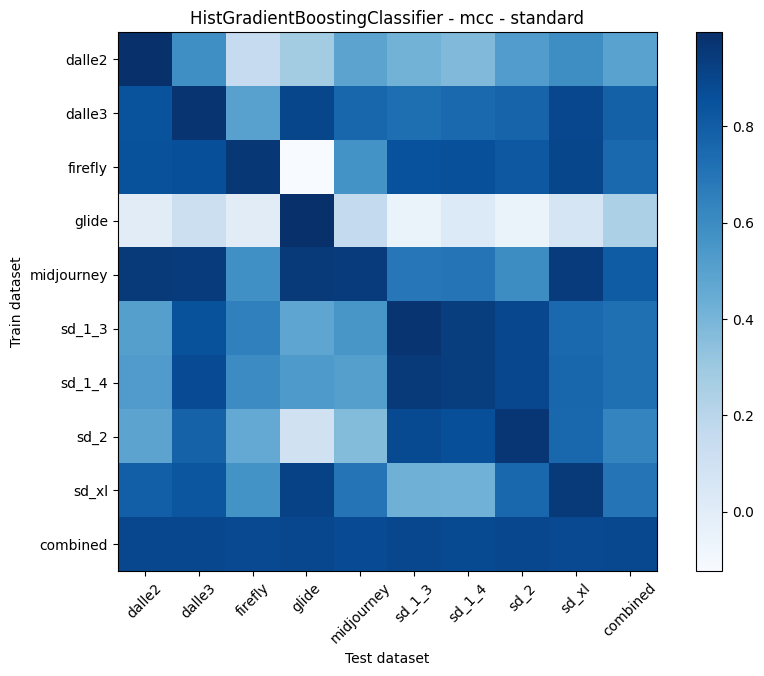

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990050  0.585639  0.153093  0.274272    0.487033  0.413381   
dalle3         0.844232  0.970437  0.499899  0.895908    0.759582  0.725312   
firefly        0.848839  0.862765  0.960192 -0.123404    0.568939  0.853464   
glide          0.000000  0.118002  0.000000  0.995012    0.163239 -0.050063   
midjourney     0.950190  0.945106  0.582357  0.955299    0.945106  0.685458   
sd_1_3         0.507077  0.850644  0.647151  0.478735    0.551145  0.970049   
sd_1_4         0.526299  0.875887  0.600245  0.534522    0.509819  0.955585   
sd_2           0.487130  0.778437  0.458349  0.096477    0.368243  0.877471   
sd_xl          0.793385  0.829586  0.570122  0.915103    0.702301  0.425383   
combined       0.890911  0.890911  0.885373  0.890911    0.874383  0.890911   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.374654  0.518823  0.589562  0.495017  
dalle3         0.750949  0.768261  0.891115  0.784792  
firefly        0.858106  0.821443  0.895908  0.746172  
glide          0.028976 -0.050063  0.067505  0.245943  
midjourney     0.698078  0.594603  0.945106  0.802844  
sd_1_3         0.935292  0.892189  0.754342  0.724006  
sd_1_4         0.935105  0.890401  0.761078  0.723797  
sd_2           0.863504  0.965109  0.756877  0.631501  
sd_xl          0.421103  0.758086  0.955299  0.701362  
combined       0.879864  0.890911  0.885373  0.886601

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990050  0.585639  0.153093  0.274272    0.487033  0.413381   
dalle3         0.844232  0.970437  0.499899  0.895908    0.759582  0.725312   
firefly        0.848839  0.862765  0.960192 -0.123404    0.568939  0.853464   
glide          0.000000  0.118002  0.000000  0.995012    0.163239 -0.050063   
midjourney     0.950190  0.945106  0.582357  0.955299    0.945106  0.685458   
sd_1_3         0.507077  0.850644  0.647151  0.478735    0.551145  0.970049   
sd_1_4         0.526299  0.875887  0.600245  0.534522    0.509819  0.955585   
sd_2           0.487130  0.778437  0.458349  0.096477    0.368243  0.877471   
sd_xl          0.793385  0.829586  0.570122  0.915103    0.702301  0.425383   
combined       0.890911  0.890911  0.885373  0.890911    0.874383  0.890911   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.374654  0.518823  0.589562  0.487390  
dalle3         0.750949  0.768261  0.891115  0.789521  
firefly        0.858106  0.821443  0.895908  0.727361  
glide          0.028976 -0.050063  0.067505  0.141401  
midjourney     0.698078  0.594603  0.945106  0.811256  
sd_1_3         0.935292  0.892189  0.754342  0.731847  
sd_1_4         0.935105  0.890401  0.761078  0.732105  
sd_2           0.863504  0.965109  0.756877  0.627955  
sd_xl          0.421103  0.758086  0.955299  0.707819  
combined       0.879864  0.890911  0.885373  0.886616

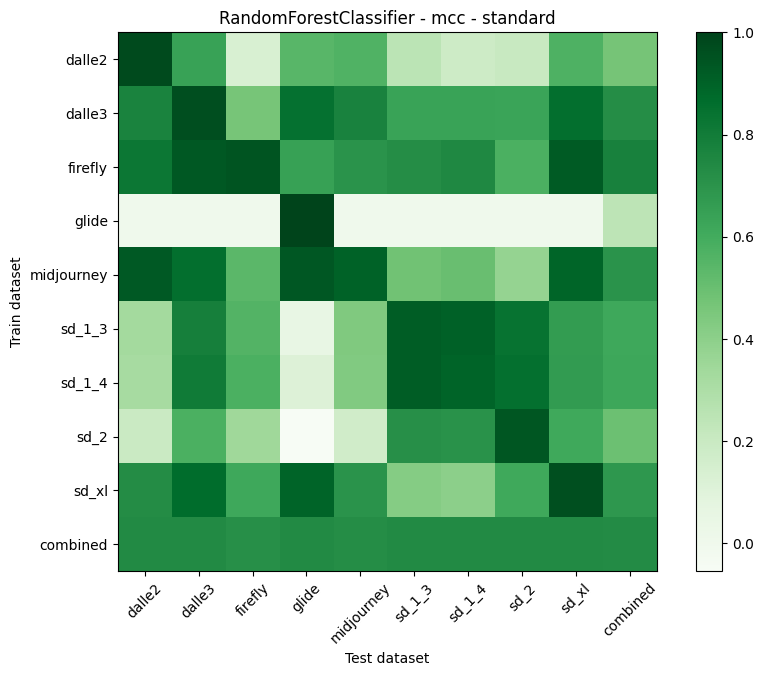

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975305  0.640513  0.131590  0.543807    0.563912  0.250000   
dalle3         0.765466  0.965109  0.462487  0.845129    0.769777  0.636455   
firefly        0.820443  0.930000  0.945106  0.643856    0.702301  0.727832   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.926402  0.855096  0.538195  0.936981    0.900405  0.478843   
sd_1_3         0.328976  0.785677  0.558014  0.051640    0.436322  0.915103   
sd_1_4         0.317147  0.802572  0.578422  0.112173    0.434471  0.915561   
sd_2           0.195724  0.577115  0.342135 -0.054413    0.170523  0.715965   
sd_xl          0.732121  0.866833  0.615061  0.895549    0.702301  0.421103   
combined       0.737836  0.737836  0.718750  0.737836    0.725070  0.737836   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.183176  0.202733  0.567930  0.468447  
dalle3         0.636455  0.632401  0.854282  0.724825  
firefly        0.745053  0.578277  0.925012  0.774651  
glide          0.000000  0.000000  0.000000  0.242536  
midjourney     0.500098  0.374174  0.890178  0.700473  
sd_1_3         0.905011  0.836770  0.662794  0.613586  
sd_1_4         0.895101  0.850383  0.667906  0.619326  
sd_2           0.707330  0.940423  0.610262  0.492937  
sd_xl          0.399479  0.610964  0.960432  0.683128  
combined       0.737836  0.737836  0.737836  0.734273

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975305  0.640513  0.131590  0.543807    0.563912  0.250000   
dalle3         0.765466  0.965109  0.462487  0.845129    0.769777  0.636455   
firefly        0.820443  0.930000  0.945106  0.643856    0.702301  0.727832   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.926402  0.855096  0.538195  0.936981    0.900405  0.478843   
sd_1_3         0.328976  0.785677  0.558014  0.051640    0.436322  0.915103   
sd_1_4         0.317147  0.802572  0.578422  0.112173    0.434471  0.915561   
sd_2           0.195724  0.577115  0.342135 -0.054413    0.170523  0.715965   
sd_xl          0.732121  0.866833  0.615061  0.895549    0.702301  0.421103   
combined       0.737836  0.737836  0.718750  0.737836    0.725070  0.737836   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.183176  0.202733  0.567930  0.450996  
dalle3         0.636455  0.632401  0.854282  0.729729  
firefly        0.745053  0.578277  0.925012  0.779764  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.500098  0.374174  0.890178  0.711153  
sd_1_3         0.905011  0.836770  0.662794  0.608923  
sd_1_4         0.895101  0.850383  0.667906  0.619304  
sd_2           0.707330  0.940423  0.610262  0.467229  
sd_xl          0.399479  0.610964  0.960432  0.689316  
combined       0.737836  0.737836  0.737836  0.734297

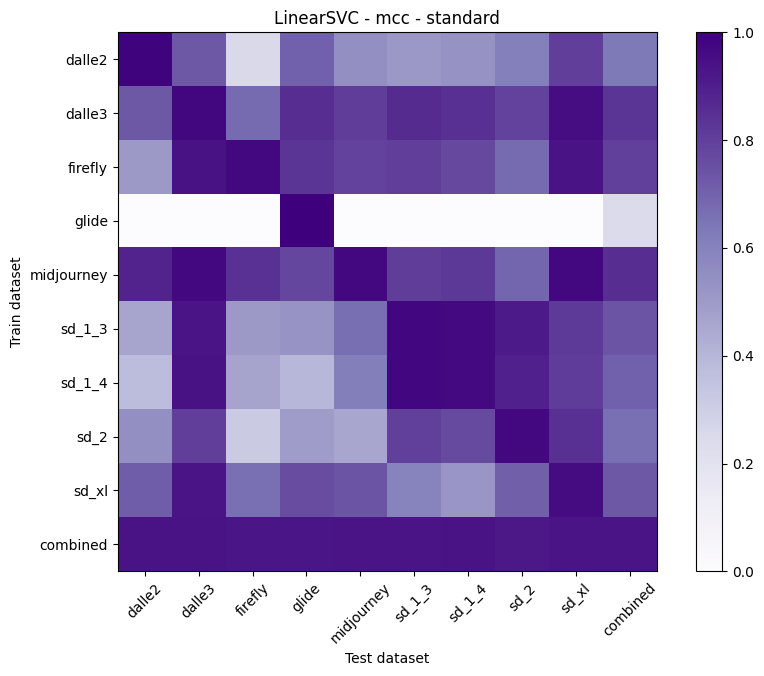

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985111  0.727001  0.251002  0.706438    0.546673  0.510892   
dalle3         0.727001  0.980049  0.677980  0.851680    0.807460  0.860710   
firefly        0.502895  0.945295  0.970000  0.829384    0.790169  0.803118   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.882830  0.970049  0.841601  0.779973    0.970049  0.806048   
sd_1_3         0.458259  0.930419  0.503047  0.527158    0.667386  0.975110   
sd_1_4         0.373026  0.940188  0.462373  0.390645    0.615012  0.975110   
sd_2           0.546401  0.804658  0.314772  0.491029    0.454764  0.800364   
sd_xl          0.714638  0.930745  0.661863  0.764605    0.739445  0.590202   
combined       0.936981  0.936981  0.926402  0.926402    0.931679  0.931679   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.534775  0.610010  0.803118  0.628992  
dalle3         0.847189  0.790169  0.955107  0.829875  
firefly        0.773079  0.677980  0.935573  0.797348  
glide          0.000000  0.000000  0.000000  0.242536  
midjourney     0.819269  0.687771  0.970049  0.855190  
sd_1_3         0.965012  0.911140  0.814848  0.740276  
sd_1_4         0.965012  0.892189  0.810441  0.703747  
sd_2           0.766465  0.970049  0.848355  0.661902  
sd_xl          0.518869  0.710534  0.960048  0.727460  
combined       0.936981  0.921152  0.931679  0.931091

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985111  0.727001  0.251002  0.706438    0.546673  0.510892   
dalle3         0.727001  0.980049  0.677980  0.851680    0.807460  0.860710   
firefly        0.502895  0.945295  0.970000  0.829384    0.790169  0.803118   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.882830  0.970049  0.841601  0.779973    0.970049  0.806048   
sd_1_3         0.458259  0.930419  0.503047  0.527158    0.667386  0.975110   
sd_1_4         0.373026  0.940188  0.462373  0.390645    0.615012  0.975110   
sd_2           0.546401  0.804658  0.314772  0.491029    0.454764  0.800364   
sd_xl          0.714638  0.930745  0.661863  0.764605    0.739445  0.590202   
combined       0.936981  0.936981  0.926402  0.926402    0.931679  0.931679   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.534775  0.610010  0.803118  0.630558  
dalle3         0.847189  0.790169  0.955107  0.833038  
firefly        0.773079  0.677980  0.935573  0.803055  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.819269  0.687771  0.970049  0.858626  
sd_1_3         0.965012  0.911140  0.814848  0.750264  
sd_1_4         0.965012  0.892189  0.810441  0.713777  
sd_2           0.766465  0.970049  0.848355  0.666317  
sd_xl          0.518869  0.710534  0.960048  0.732328  
combined       0.936981  0.921152  0.931679  0.931104

In [16]:
print("########################### MCC ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    df_pivot = df.pivot(index=["train_dataset", "model"], columns="test_dataset", values="mcc")
    df_pivot = df_pivot.reindex(index=X_train.keys())

    metric = "mcc"
    evaluation_data_name = "Test"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)